# Importing libraries

In [465]:
import pandas as pd
import time
import numpy 
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.patches import Patch
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from xgboost import XGBClassifier
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import Reweighing, LFR
from aif360.algorithms.postprocessing import RejectOptionClassification
from holisticai.bias.mitigation.preprocessing import DisparateImpactRemover

# Data pre-processing

## Loading both datasets

In [466]:
df_banking = pd.read_csv("Banking dataset.csv")
df_telecom = pd.read_csv("Telco dataset.csv")

## Enrich the telecommunication 
The partly preprocessed telecommunications dataset did not originally include the numerical Age column. To enrich it, the Age feature was retrieved from the original dataset and merged into the main dataset using customerID as a key. An inner join was applied to ensure that the Age column was only added for customers present in both datasets.

In [467]:
# Load the original telecommunication dataset
df_telecom2 = pd.read_csv("telco.csv")
df_telecom2 = df_telecom2[["Customer ID","Age"]]

# Changing the column name to the same name as the main dataset
df_telecom2 = df_telecom2.rename(columns={"Customer ID":"customerID"})

# Adding age column to the main dataset using customerID
df_telecom = pd.merge(df_telecom,df_telecom2, on="customerID",how="inner")

## Description of datasets

### Banking

In [468]:
df_banking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [469]:
df_banking.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Telecommunication

In [470]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [471]:
# Show all columns to inspect all columns
pd.set_option("display.max_columns", None)
df_telecom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,36
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,46
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,37
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,53
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,19


## Drop obviously irrelevant features such as identifiers (e.g., ID and surname)
Obvious irrelevant features in both the banking and telecommunications datasets are removed, as they provide no predictive value. Since these features are unique identifiers, they would only lead the model to memorize noise and increase the risk of overfitting. Additionally, in the telecommunications dataset, the SeniorCitizen variable is also dropped, as the dataset has been enriched with the Age column, making SeniorCitizen redundant.

### Banking

In [472]:
df_banking = df_banking.drop(columns=["RowNumber","CustomerId","Surname"])
df_banking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Telecommunication

In [473]:
df_telecom = df_telecom.drop(columns=["customerID","SeniorCitizen"])
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


## Missing values
No missing values were found for both datasets

In [474]:
# Banking
df_banking.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [475]:
# Telecommunication
df_telecom.isnull().sum()

gender              0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Age                 0
dtype: int64

### Hidden missing values
While the dataset initially appeared to have no missing values, converting the TotalCharges feature to numeric revealed 11 entries with empty string values (“ ”), which could not be converted. Upon inspection, all 11 records belonged to non-churners (the majority class). Given the very small size of this subset (≈0.001% of the total sample) and its restriction to the majority group, removing these samples is unlikely to impact model performance. This is especially reasonable since the main modeling challenge lies in correctly identifying churners, the minority class, rather than further modeling non-churners.

In [476]:
# Showing the samples with the hidden missing values
telecom_empty = df_telecom[df_telecom.TotalCharges == " "]

telecom_empty

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age
488,Female,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,43
753,Male,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,24
936,Female,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,40
1082,Male,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,39
1340,Female,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,64
3331,Male,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,56
3826,Male,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,22
4380,Female,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,23
5218,Male,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,38
6670,Female,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,25


In [477]:
# Dropping the samples with missing values
df_telecom = df_telecom.drop(index=telecom_empty.index)

# Print the new shape
print(df_telecom.shape)

(7032, 20)


In [478]:
# Double checking whether there are no empty values left
df_telecom[df_telecom.TotalCharges == " "]

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age


### Convert features to correct dtypes
Most features already have the correct dtypes based on the general dataset description. The only exception is TotalCharges in the telecommunications dataset, which will be converted to numeric. In the banking dataset, HasCrCard, IsActiveMember and Exited appear as numeric, although they are originally categorical (yes/no). The same goes for SeniorCitizen in the telecommunication dataset. Since these values are already encoded as 0/1, they can be kept in this format instead of re-encoding. However, care will be taken to exclude them from feature scaling, as only true continuous numerical features should be scaled.

In [479]:
# Converting TotalCharges to numerical
df_telecom.TotalCharges = pd.to_numeric(df_telecom.TotalCharges)

# Check whether it changed correctly
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   Partner           7032 non-null   object 
 2   Dependents        7032 non-null   object 
 3   tenure            7032 non-null   int64  
 4   PhoneService      7032 non-null   object 
 5   MultipleLines     7032 non-null   object 
 6   InternetService   7032 non-null   object 
 7   OnlineSecurity    7032 non-null   object 
 8   OnlineBackup      7032 non-null   object 
 9   DeviceProtection  7032 non-null   object 
 10  TechSupport       7032 non-null   object 
 11  StreamingTV       7032 non-null   object 
 12  StreamingMovies   7032 non-null   object 
 13  Contract          7032 non-null   object 
 14  PaperlessBilling  7032 non-null   object 
 15  PaymentMethod     7032 non-null   object 
 16  MonthlyCharges    7032 non-null   float64
 17  

## Obvious outliers/errors
There were no obvious errors found in the dataset. Additionally, with the z-score method where samples that are three standard deviations from the mean are are excluded, no outliers were found.

### Banking

In [480]:
# First simple check for obvious outliers for banking
df_banking.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [481]:
# Computing the mean and standard deviation across both financial metrics
banking_financial_metrics = df_banking[["Balance","EstimatedSalary"]]
banking_financial_mean = banking_financial_metrics.mean(axis=0)
banking_financial_std = banking_financial_metrics.std(axis=0)

In [482]:
# Finding all outliers
banking_outliers = banking_financial_metrics[
    (banking_financial_metrics.Balance < banking_financial_mean["Balance"] - 3 * banking_financial_std["Balance"])
    | (banking_financial_metrics.Balance > banking_financial_mean["Balance"] + 3 * banking_financial_std["Balance"])
    | (banking_financial_metrics.EstimatedSalary < banking_financial_mean["EstimatedSalary"] - 3 * banking_financial_std["EstimatedSalary"])
    | (banking_financial_metrics.EstimatedSalary > banking_financial_mean["EstimatedSalary"] + 3 * banking_financial_std["EstimatedSalary"])
    ]
print(banking_outliers.shape)

(0, 2)


### Telecommunication

In [483]:
# First simple check for obvious outliers for telecommunication
df_telecom.describe()

,tenure,MonthlyCharges,TotalCharges,Age
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,46.521331
std,24.545260,30.085974,2266.771362,16.751596
min,1.000000,18.250000,18.800000,19.000000
25%,9.000000,35.587500,401.450000,32.000000
50%,29.000000,70.350000,1397.475000,46.000000
75%,55.000000,89.862500,3794.737500,60.000000
max,72.000000,118.750000,8684.800000,80.000000


In [484]:
# Computing the mean and standard deviation across both financial metrics
telecom_financial_metrics = df_telecom[["MonthlyCharges", "TotalCharges"]]
telecom_financial_mean = telecom_financial_metrics.mean(axis=0)
telecom_financial_std = telecom_financial_metrics.std(axis=0)

In [485]:
# Finding all outliers
telecom_outliers = telecom_financial_metrics[
    (telecom_financial_metrics.MonthlyCharges < telecom_financial_mean["MonthlyCharges"] - 3 * telecom_financial_std["MonthlyCharges"])
    | (telecom_financial_metrics.MonthlyCharges > telecom_financial_mean["MonthlyCharges"] + 3 * telecom_financial_std["MonthlyCharges"])
    | (telecom_financial_metrics.TotalCharges < telecom_financial_mean["TotalCharges"] - 3 * telecom_financial_std["TotalCharges"])
    | (telecom_financial_metrics.TotalCharges > telecom_financial_mean["TotalCharges"] + 3 * telecom_financial_std["TotalCharges"])
]

print(telecom_outliers.shape)

(0, 2)


## EDA

### Churn rates across datasets

In [486]:
# Churn rates
banking_churn_counts = df_banking.Exited.value_counts()
banking_cr = round(banking_churn_counts[1] / df_banking.shape[0],3)
banking_nonchurners = 1-banking_cr

telecom_churn_counts = df_telecom.Churn.value_counts()
telecom_cr = round(telecom_churn_counts.iloc[1] / df_telecom.shape[0],3)
telecom_nonchurners = 1-telecom_cr

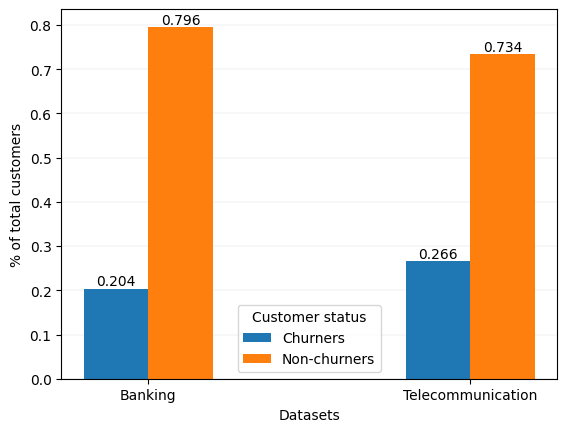

In [597]:
# The data
datasets = ["Banking","Telecommunication"]
category_churners = ["Churners","Non-churners"]
churn_rates = numpy.array([(banking_cr,telecom_cr),(banking_nonchurners,telecom_nonchurners)])
index_churners = numpy.arange(len(datasets))

bar_width = 0.20

# Plotting the bars
bars_churners = plt.bar(index_churners, churn_rates[0], bar_width, label=category_churners[0])
bars_nonchurners = plt.bar(index_churners + bar_width, churn_rates[1], bar_width, label=category_churners[1])
plt.bar_label(bars_churners, fmt="%.3f")
plt.bar_label(bars_nonchurners, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("% of total customers")
plt.legend(title="Customer status")
plt.gca().set_axisbelow(True)
plt.savefig("churn_rates.png")

### Gender

#### Churn rate per gender

In [488]:
# Subsetting dataset into male and female (banking)
banking_male = df_banking[df_banking.Gender == "Male"]
banking_female = df_banking[df_banking.Gender == "Female"]

# Computing churn rate for male 
banking_male_churn_counts = banking_male.Exited.value_counts()
banking_male_cr = round(banking_male_churn_counts[1]/ (banking_male_churn_counts[0]+banking_male_churn_counts[1]),3)

# Computing churn rate for female
banking_female_churn_counts = banking_female.Exited.value_counts()
banking_female_cr = round(banking_female_churn_counts[1]/ (banking_female_churn_counts[0]+banking_female_churn_counts[1]),3)

In [489]:
# Subsetting dataset into male and female (telecom)
telecom_male = df_telecom[df_telecom.gender == "Male"]
telecom_female = df_telecom[df_telecom.gender == "Female"]

# Computing churn rate for male 
telecom_male_churn_counts = telecom_male.Churn.value_counts()
telecom_male_cr = round(telecom_male_churn_counts.iloc[1]/ (telecom_male_churn_counts.iloc[0]+telecom_male_churn_counts.iloc[1]),3)

# Computing churn rate for female 
telecom_female_churn_counts = telecom_female.Churn.value_counts()
telecom_female_cr = round(telecom_female_churn_counts.iloc[1]/ (telecom_female_churn_counts.iloc[0]+telecom_female_churn_counts.iloc[1]),3)

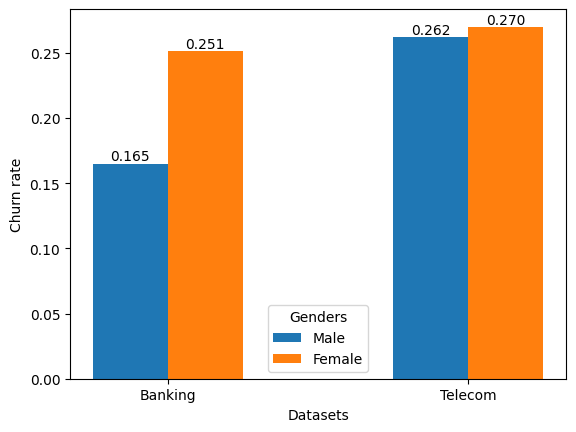

In [609]:
# The data
datasets = ["Banking","Telecom"]
category_gender = ["Male","Female"]
churn_rates_gender = numpy.array([(banking_male_cr,telecom_male_cr),(banking_female_cr,telecom_female_cr)])
index_gender = numpy.arange(len(datasets))

bar_width = 0.25

# Plotting the bars
bars_male = plt.bar(index_gender, churn_rates_gender[0], bar_width, label=category_gender[0])
bars_female = plt.bar(index_gender + bar_width, churn_rates_gender[1], bar_width, label=category_gender[1])
plt.bar_label(bars_male, fmt="%.3f")
plt.bar_label(bars_female, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("Churn rate")
plt.legend(title="Genders")
plt.xticks(index_gender + bar_width * (len(category_gender)-1) /2, datasets)
plt.savefig("gender_churnrates.png")

#### Gender distribution

In [491]:
# Gender distribution (banking)
banking_gender_distribution = df_banking.Gender.value_counts()
banking_male = round(banking_gender_distribution.iloc[0] / df_banking.shape[0],3)
banking_female = round(banking_gender_distribution.iloc[1] / df_banking.shape[0],3)

# Gender distribution (telecom)
telecom_gender_distribution = df_telecom.gender.value_counts()
telecom_male = round(telecom_gender_distribution.iloc[0] / df_telecom.shape[0],3)
telecom_female = round(telecom_gender_distribution.iloc[1] / df_telecom.shape[0],3)

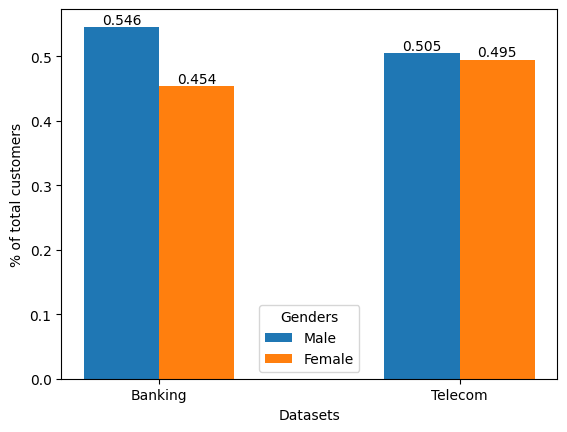

In [604]:
distribution_gender = numpy.array([(banking_male,telecom_male),(banking_female,telecom_female)])

bar_width = 0.25

# Plotting the bars
bars_male_distribution = plt.bar(index_gender, distribution_gender[0], bar_width, label=category_gender[0])
bars_female_distribution = plt.bar(index_gender + bar_width, distribution_gender[1], bar_width, label=category_gender[1])
plt.bar_label(bars_male_distribution, fmt="%.3f")
plt.bar_label(bars_female_distribution, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("% of total customers")
plt.legend(title="Genders")
plt.xticks(index_gender + bar_width * (len(category_gender)-1) /2, datasets)
plt.savefig("gender_distribution.png")

### Age

#### Age group churn rates

In [493]:
# Subsetting dataset in age bins (banking)
banking_30 = df_banking[df_banking.Age < 30]
banking_30_65 = df_banking[(df_banking.Age >= 30) & (df_banking.Age < 65)]
banking_65 = df_banking[df_banking.Age >= 65]

# Compute churn rate for age < 30
banking_30_churn_counts = banking_30.Exited.value_counts()
banking_30_cr = round(banking_30_churn_counts.iloc[1]/ (banking_30_churn_counts.iloc[0]+banking_30_churn_counts.iloc[1]),3)

# Compute churn rate for 30-65 
banking_30_65_churn_counts = banking_30_65.Exited.value_counts()
banking_30_65_cr = round(banking_30_65_churn_counts.iloc[1]/ (banking_30_65_churn_counts.iloc[0]+banking_30_65_churn_counts.iloc[1]),3)

# Compute churn rate for age ≥ 65
banking_65_churn_counts = banking_65.Exited.value_counts()
banking_65_cr = round(banking_65_churn_counts.iloc[1]/ (banking_65_churn_counts.iloc[0]+banking_65_churn_counts.iloc[1]),3)

In [494]:
# Subsetting dataset in age bins (telecom)
telecom_30 = df_telecom[df_telecom.Age < 30]
telecom_30_65 = df_telecom[(df_telecom.Age >= 30) & (df_telecom.Age < 65)]
telecom_65 = df_telecom[df_telecom.Age >= 65]

# Compute churn rate for age < 30
telecom_30_churn_counts = telecom_30.Churn.value_counts()
telecom_30_cr = round(telecom_30_churn_counts.iloc[1]/ (telecom_30_churn_counts.iloc[0]+telecom_30_churn_counts.iloc[1]),3)

# Compute churn rate for 30-65 
telecom_30_65_churn_counts = telecom_30_65.Churn.value_counts()
telecom_30_65_cr = round(telecom_30_65_churn_counts.iloc[1]/ (telecom_30_65_churn_counts.iloc[0]+telecom_30_65_churn_counts.iloc[1]),3)

# Compute churn rate for age ≥ 65
telecom_65_churn_counts = telecom_65.Churn.value_counts()
telecom_65_cr = round(telecom_65_churn_counts.iloc[1]/ (telecom_65_churn_counts.iloc[0]+telecom_65_churn_counts.iloc[1]),3)

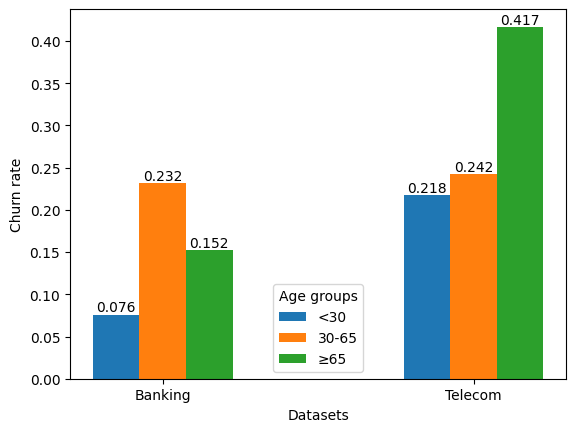

In [608]:
# The data
category_age = ["<30","30-65","≥65"]
churn_rates_age = numpy.array([(banking_30_cr,telecom_30_cr),(banking_30_65_cr,telecom_30_65_cr),(banking_65_cr,telecom_65_cr)])
index_age = numpy.arange(len(datasets))

bar_width = 0.15

# Plotting the bars
bars_30 = plt.bar(index_age, churn_rates_age[0], bar_width, label=category_age[0])
bars_30_65 = plt.bar(index_age + bar_width, churn_rates_age[1], bar_width, label=category_age[1])
bars_65 = plt.bar(index_age + bar_width * 2, churn_rates_age[2], bar_width, label=category_age[2])
plt.bar_label(bars_30, fmt="%.3f")
plt.bar_label(bars_30_65, fmt="%.3f")
plt.bar_label(bars_65, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("Churn rate")
plt.legend(title="Age groups",loc = 8)
plt.xticks(index_age + bar_width * (len(category_age)-1) /2, datasets)
plt.savefig("age_churnrates.png")

#### Age group distribution

In [496]:
# Age distribution across both datasets
distribution_30 = (round(banking_30.shape[0]/df_banking.shape[0],3),
                   round(telecom_30.shape[0]/df_telecom.shape[0],3))

distribution_30_65 = (round(banking_30_65.shape[0]/df_banking.shape[0],3),
                      round(telecom_30_65.shape[0]/df_telecom.shape[0],3))

distribution_65 = (round(banking_65.shape[0]/df_banking.shape[0],3),
                   round(telecom_65.shape[0]/df_telecom.shape[0],3))

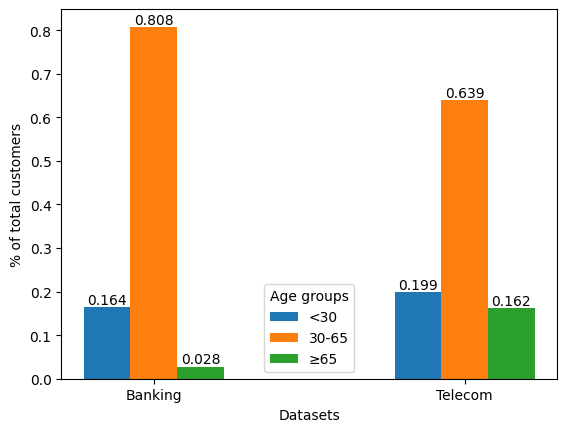

In [602]:
# The data
distribution_age = numpy.array([distribution_30,distribution_30_65,distribution_65])

bar_width = 0.15

# Plotting the bars
bars_30 = plt.bar(index_age, distribution_age[0], bar_width, label=category_age[0])
bars_30_65 = plt.bar(index_age + bar_width, distribution_age[1], bar_width, label=category_age[1])
bars_65 = plt.bar(index_age + bar_width * 2, distribution_age[2], bar_width, label=category_age[2])
plt.bar_label(bars_30, fmt="%.3f")
plt.bar_label(bars_30_65, fmt="%.3f")
plt.bar_label(bars_65, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("% of total customers")
plt.legend(title="Age groups",loc = 8)
plt.xticks(index_age + bar_width * (len(category_age)-1) /2, datasets)
plt.savefig("distribution_age.png")

### Location

In [498]:
# Subsetting banking dataset for all countries
banking_france = df_banking[df_banking.Geography == "France"]
banking_spain = df_banking[df_banking.Geography == "Spain"]
banking_germany = df_banking[df_banking.Geography == "Germany"]

#### Location distribution

In [499]:
# Location distribution
distribution_geography = (round(banking_france.shape[0]/df_banking.shape[0],3),
                       round(banking_spain.shape[0]/df_banking.shape[0],3),
                       round(banking_germany.shape[0]/df_banking.shape[0],3))

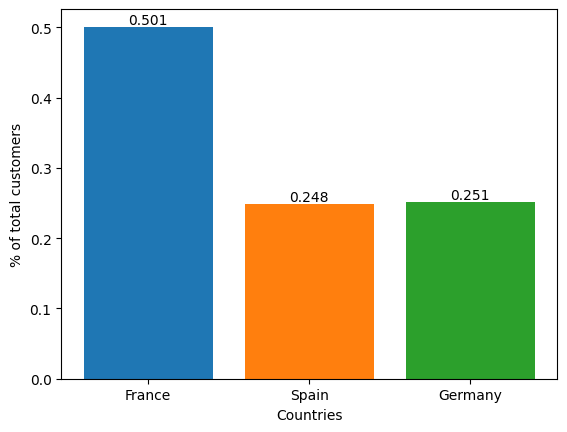

In [603]:
# Data 
datasets_location = ["Banking"]
category_location = ["France","Spain","Germany"]
index_location = numpy.arange(len(datasets_location))

bar_width = 0.40

# Plotting the bars
bars_geography = plt.bar(category_location, distribution_geography,color=["#1f77b4","#ff7f0e","#2ca02c"])
plt.bar_label(bars_geography, fmt="%.3f")

# Designing the barplot
plt.xlabel("Countries")
plt.ylabel("% of total customers")
plt.savefig("location_distribution.png")

#### Churn rates per country

In [501]:
# Computing churn rates across countries
france_churn_counts = banking_france.Exited.value_counts()
france_cr = round(france_churn_counts[1] / (france_churn_counts[0] + france_churn_counts[1]),3)

spain_churn_counts = banking_spain.Exited.value_counts()
spain_cr = round(spain_churn_counts[1] / (spain_churn_counts[0] + spain_churn_counts[1]),3)

germany_churn_counts = banking_germany.Exited.value_counts()
germany_cr = round(germany_churn_counts[1] / (germany_churn_counts[0] + germany_churn_counts[1]),3)

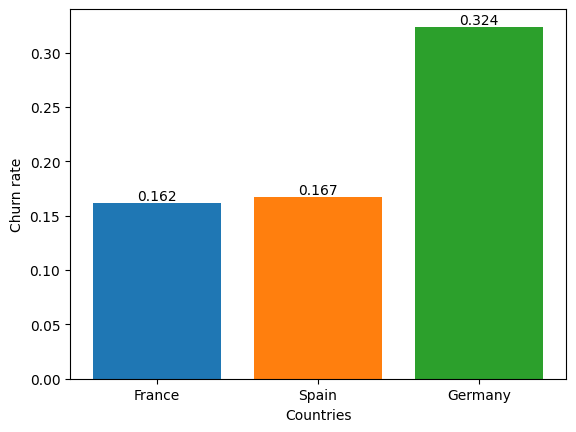

In [607]:
# Data 
bar_width = 0.40

# Plotting the bars
bars_geography = plt.bar(category_location, (france_cr,spain_cr,germany_cr),color=["#1f77b4","#ff7f0e","#2ca02c"])
plt.bar_label(bars_geography, fmt="%.3f")

# Designing the barplot
plt.xlabel("Countries")
plt.ylabel("Churn rate")
plt.savefig("location_churn_rate.png")

## Churn rates per contract type in banking

In [503]:
# Computing month to month churn rate
month_to_month = df_telecom[df_telecom.Contract == "Month-to-month"].Churn.value_counts()
month_cr = round(month_to_month.iloc[1] / (month_to_month.iloc[0] + month_to_month.iloc[1]),3)

# Computing one year churn rate
one_year = df_telecom[df_telecom.Contract == "One year"].Churn.value_counts()
year_cr = round(one_year.iloc[1] / (one_year.iloc[0] + one_year.iloc[1]),3)

# Computing two years churn rate
two_years = df_telecom[df_telecom.Contract == "Two year"].Churn.value_counts()
two_years_cr = round(two_years.iloc[1] / (two_years.iloc[0] + two_years.iloc[1]),3)

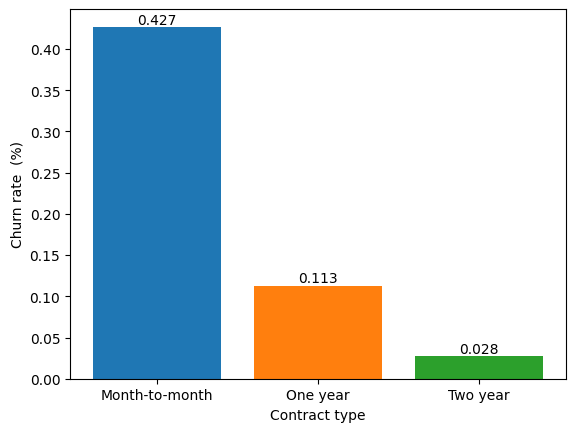

In [600]:
# Data 
category_contract = df_telecom.Contract.unique()
bar_width = 0.40

# Plotting the bars
bars_contract = plt.bar(category_contract, (month_cr,year_cr,two_years_cr),color=["#1f77b4","#ff7f0e","#2ca02c"])
plt.bar_label(bars_contract, fmt="%.3f")

# Designing the barplot
plt.xlabel("Contract type")
plt.ylabel("Churn rate  (%)")
plt.savefig("contract_churn_rate.png")

### Correlation heatmaps

#### Banking

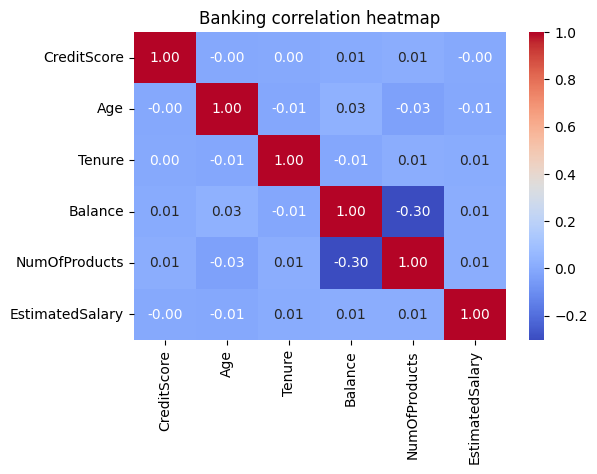

In [505]:
# Only use numerical features
banking_numerical = df_banking.select_dtypes(include="number").drop(columns=["HasCrCard","IsActiveMember","Exited"])
banking_correlation = banking_numerical.corr()

plt.figure(figsize=(6,4))
sns.heatmap(banking_correlation, annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Banking correlation heatmap")
plt.savefig("Banking correlation")

#### Telecommunication

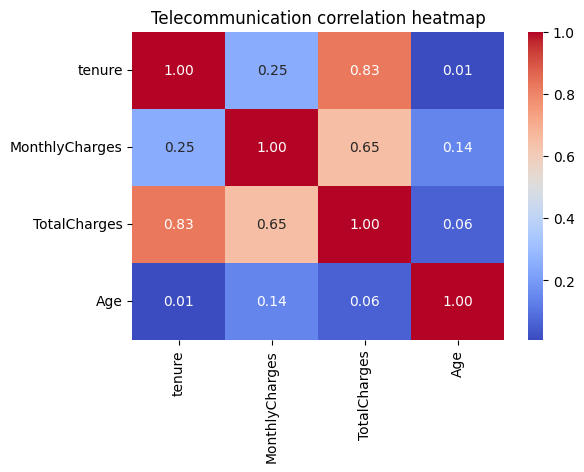

In [506]:
# Only use numerical features
telecom_numerical = df_telecom.select_dtypes(include="number")
telecom_correlation = telecom_numerical.corr()

plt.figure(figsize=(6,4))
sns.heatmap(telecom_correlation, annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Telecommunication correlation heatmap")
plt.savefig("Telecommunication correlation")

## Feature engineering

In [43]:
df_banking.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Encoding features
By far the most common encoding strategies in churn prediction are one-hot encoding and ordinal encoding, with one-hot encoding being the most widely used and only a small minority of studies applying target encoding. One-hot encoding is primarily applied to nominal features, but it can substantially increase dimensionality since it creates a new column for each category. In contrast, ordinal encoding does not increase dimensionality, as it assigns each category an integer value. However, it is only appropriate for ordinal features, as it assumes a natural ordering of categories where some values are inherently closer to others.  Additionally, target encoding replaces each category with the mean of the target variable for that category. This method is particularly useful for high-cardinality features, as it prevents dimensionality explosion while still capturing predictive signal. In contrast, for low-cardinality features, the dimensionality increase of one-hot encoding is minimal, and target encoding may instead increase the risk of overfitting, since the model can simply memorize small and potentially insignificant differences in churn rates between categories.

### Banking
Gender is a binary categorical variable, meaning one-hot encoding this feature would contain two features with the exact same information. Therefore, it is label encoded. Addtionally, Geography, are nominal with low cardinality. Consequently, one-hot encoding is the most appropriate strategy for representing this feature.

In [44]:
# Inspect the kind of values in the categorical variables
banking_categorical = df_banking.select_dtypes(include=["object"])

for column in banking_categorical.columns:
    print(column, df_banking[column].unique())

Geography ['France' 'Spain' 'Germany']
Gender ['Female' 'Male']


In [45]:
# Keep the dataset before applying encoding, so it can be used for Fairness mitigation techniques later on
df_banking_no_encoding = df_banking.drop(columns=["Exited"])
df_banking_no_encoding

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [46]:
# Selecting only categorical features 
banking_categorical_columns = df_banking.select_dtypes(include=["object"]).columns

# One hot encode categorical features
banking_encoded = pd.get_dummies(df_banking[banking_categorical_columns],columns=banking_categorical_columns, drop_first=False,dtype=int)

# Join the encoded dataframe with original dataframe
df_banking = df_banking.join(banking_encoded)

# Drop the not encoded columns
df_banking = df_banking.drop(columns=df_banking.select_dtypes(include=["object"]).columns)
df_banking

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0,0,1
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0,0,1
9997,709,36,7,0.00,1,0,1,42085.58,1,1,0,0,1,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,0,1,0,0,1


### Telecommunication
Since none of the features exhibit high cardinality and most are nominal without a natural order, they will be encoded using one-hot encoding. An exception is the feature Contract, which takes the values ‘Month-to-month,’ ‘One year,’ and ‘Two year.’ These categories follow a natural temporal order, and as shown in the EDA (‘Churn rate across different contract types in banking’), churn rates decrease with longer contracts. Therefore, ordinal encoding is applied to this feature so that models can directly capture the ordered relationship between contract length and churn. 

In [47]:
df_telecom

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,36
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,46
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,37
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,53
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,38
7039,Female,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,30
7040,Female,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,32
7041,Male,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,75


In [48]:
# Keep the dataset before applying encoding, so it can be used for Reweighing later on
df_telecom_no_encoding = df_telecom.drop(columns=["Churn"]).copy()

In [49]:
# Inspect the kind of values in the categorical variables
telecom_categorical = df_telecom.select_dtypes(include=["object"])

for column in telecom_categorical.columns:
    print(column, df_telecom[column].unique())

gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [50]:
# Initialize ordinal encoder
encoder = OrdinalEncoder()

# Encoding Contract and churn with ordinal encoder
df_telecom["Contract"] = encoder.fit_transform(df_telecom[["Contract"]])

# Encode target (Churn)
df_telecom["Churn"] = df_telecom["Churn"].map({"No": 0, "Yes": 1})

df_telecom

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,0.0,Yes,Electronic check,29.85,29.85,0,36
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,1.0,No,Mailed check,56.95,1889.50,0,46
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,0.0,Yes,Mailed check,53.85,108.15,1,37
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,1.0,No,Bank transfer (automatic),42.30,1840.75,0,53
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,0.0,Yes,Electronic check,70.70,151.65,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,1.0,Yes,Mailed check,84.80,1990.50,0,38
7039,Female,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,1.0,Yes,Credit card (automatic),103.20,7362.90,0,30
7040,Female,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,0.0,Yes,Electronic check,29.60,346.45,0,32
7041,Male,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,0.0,Yes,Mailed check,74.40,306.60,1,75


In [51]:
df_telecom.head()

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Age
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,0.0,Yes,Electronic check,29.85,29.85,0,36
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,1.0,No,Mailed check,56.95,1889.50,0,46
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,0.0,Yes,Mailed check,53.85,108.15,1,37
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,1.0,No,Bank transfer (automatic),42.30,1840.75,0,53
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,0.0,Yes,Electronic check,70.70,151.65,1,19


In [52]:
# Selecting only categorical features excluding the target
telecom_categorical_columns = df_telecom.select_dtypes(include=["object"]).columns

# One hot encode categorical features
telecom_encoded = pd.get_dummies(df_telecom[telecom_categorical_columns],columns=telecom_categorical_columns, drop_first=False,dtype=int)

# Join the encoded dataframe with original dataframe
df_telecom = df_telecom.join(telecom_encoded)

# Drop the not encoded columns
df_telecom = df_telecom.drop(columns = df_telecom.select_dtypes(include=["object"]).columns)
df_telecom

,tenure,Contract,MonthlyCharges,TotalCharges,Churn,Age,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0.0,29.85,29.85,0,36,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
1,34,1.0,56.95,1889.50,0,46,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
2,2,0.0,53.85,108.15,1,37,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
3,45,1.0,42.30,1840.75,0,53,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0
4,2,0.0,70.70,151.65,1,19,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1.0,84.80,1990.50,0,38,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
7039,72,1.0,103.20,7362.90,0,30,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0
7040,11,0.0,29.60,346.45,0,32,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
7041,4,0.0,74.40,306.60,1,75,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1


## Feature Importance

### Banking

#### Gender

##### Male

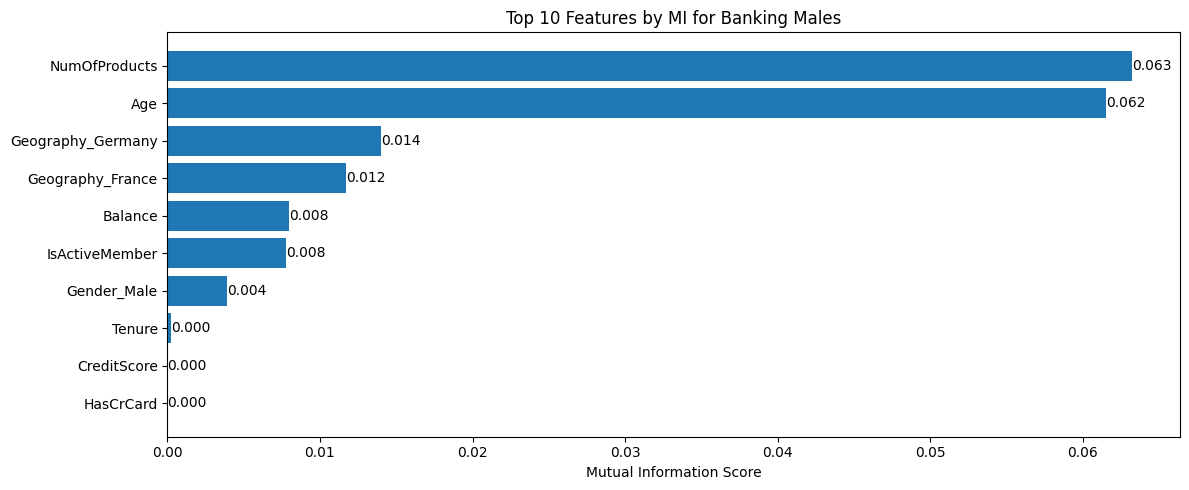

In [53]:
# Filter subgroup male
banking_male = df_banking[df_banking["Gender_Male"] == 1]

# Separate features and target
X_male = banking_male.drop(columns="Exited")
y_male = banking_male["Exited"]

# Compute mutual information
mi_male = mutual_info_classif(X_male, y_male, random_state=42)
mi_male_series = pd.Series(mi_male, index=X_male.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_male_series.index, mi_male_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Males")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_male_fi.png")
plt.show()

##### Female

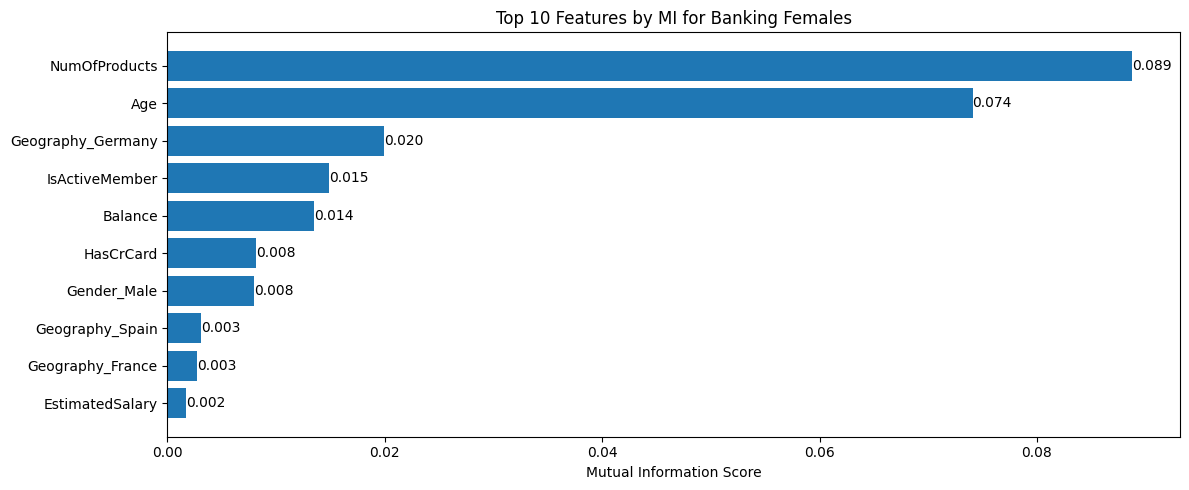

In [54]:
# Filter subgroup female
banking_female = df_banking[df_banking["Gender_Female"] == 1]

# Separate features and target
X_female = banking_female.drop(columns="Exited")
y_female = banking_female["Exited"]

# Compute mutual information
mi_female = mutual_info_classif(X_female, y_female, random_state=42)
mi_female_series = pd.Series(mi_female, index=X_female.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_female_series.index, mi_female_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Females")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_female_fi.png")
plt.show()

#### Age

##### <30

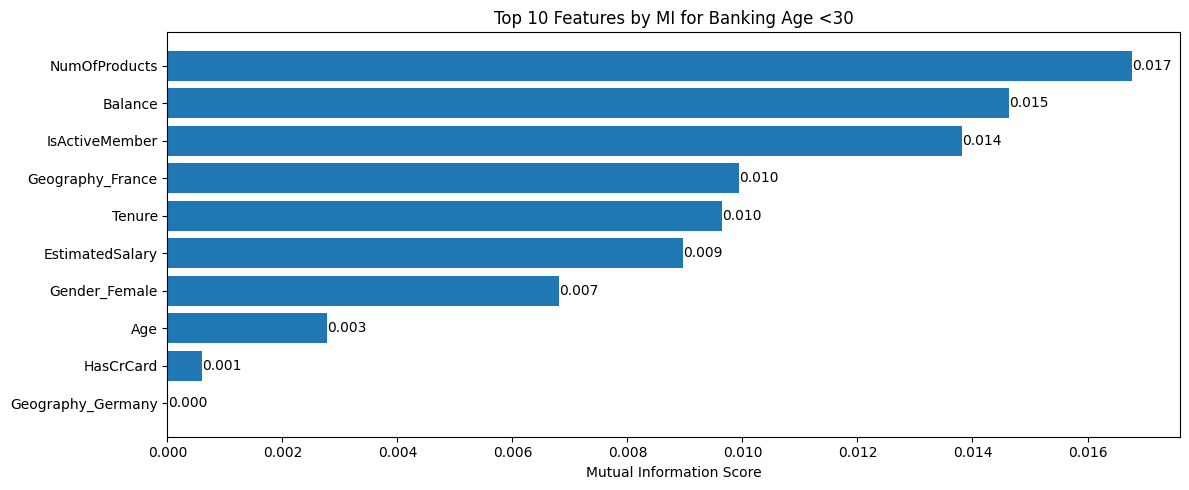

In [55]:
# Filter subgroup Age < 30
banking_30 = df_banking[df_banking.Age < 30]

# Separate features and target
X_30 = banking_30.drop(columns="Exited")
y_30 = banking_30["Exited"]

# Compute mutual information
mi = mutual_info_classif(X_30, y_30, random_state=42)
mi_series = pd.Series(mi, index=X_30.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_series.index, mi_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Age <30")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_age_30_fi.png")
plt.show()

##### 30-65

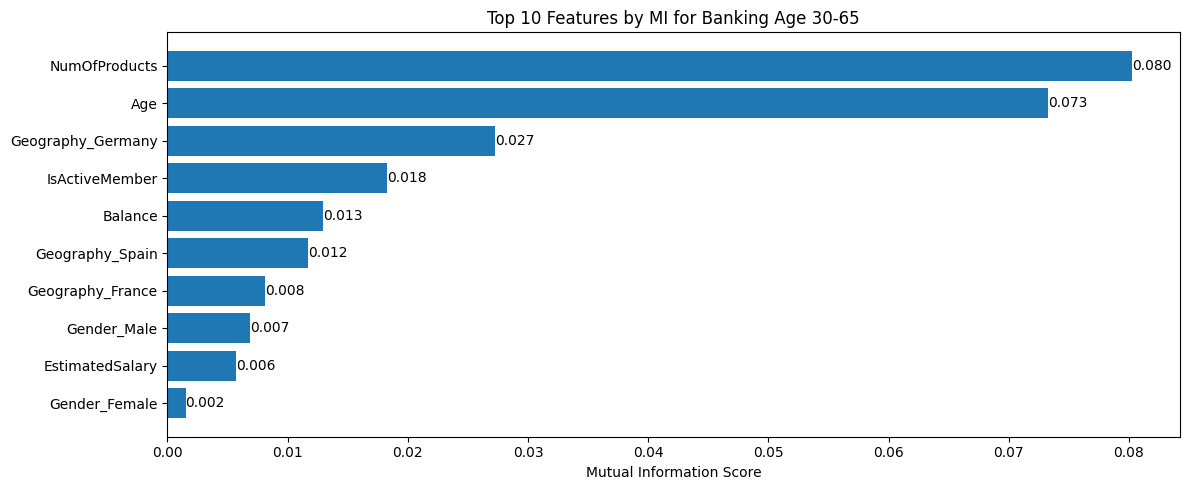

In [56]:
# Filter subgroup Age 30-65
banking_30_65 = df_banking[(df_banking.Age >= 30) & (df_banking.Age < 65)]

# Separate features and target
X_30_65 = banking_30_65.drop(columns="Exited")
y_30_65 = banking_30_65["Exited"]

# Compute mutual information
mi_30_65 = mutual_info_classif(X_30_65, y_30_65, random_state=42)
mi_30_65_series = pd.Series(mi_30_65, index=X_30_65.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_30_65_series.index, mi_30_65_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Age 30-65")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_age_30_65_fi.png")
plt.show()

##### ≥ 65

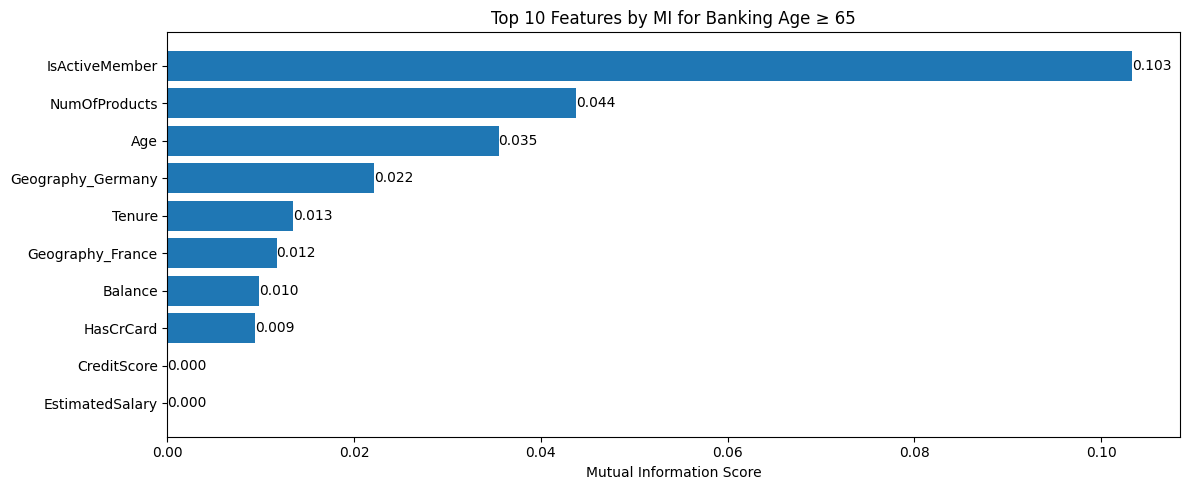

In [57]:
# Filter subgroup Age ≥ 65
banking_65 = df_banking[df_banking.Age >= 65]

# Separate features and target
X_65 = banking_65.drop(columns="Exited")
y_65 = banking_65["Exited"]

# Compute mutual information
mi_65 = mutual_info_classif(X_65, y_65, random_state=42)
mi_65_series = pd.Series(mi_65, index=X_65.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_65_series.index, mi_65_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Age ≥ 65")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_age_65_fi.png")
plt.show()

#### Location

##### France

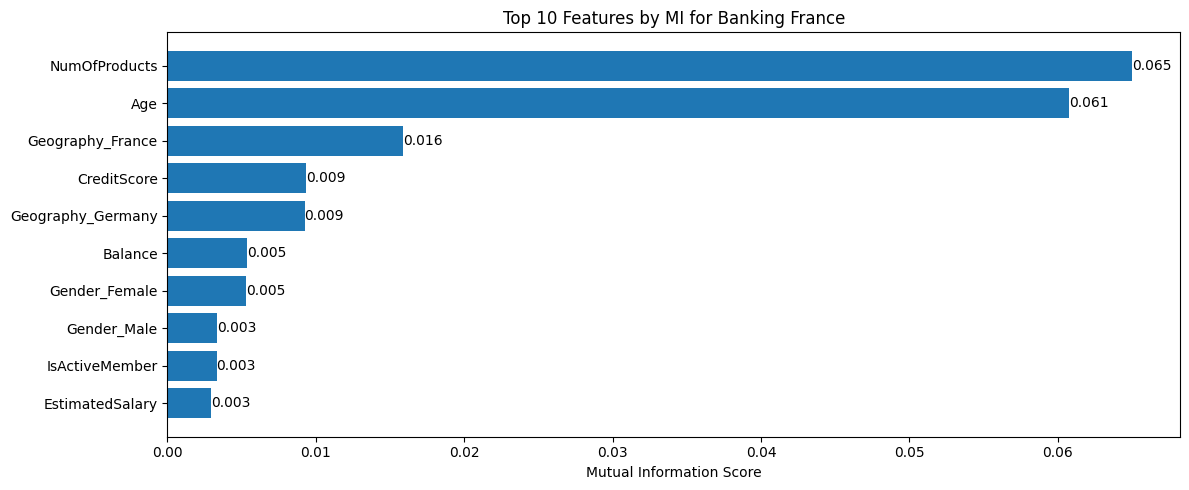

In [58]:
# Filter subgroup Geography = France
banking_france = df_banking[df_banking["Geography_France"] == 1]

# Separate features and target
X_france = banking_france.drop(columns="Exited")
y_france = banking_france["Exited"]

# Compute mutual information
mi_france = mutual_info_classif(X_france, y_france, random_state=42)
mi_france_series = pd.Series(mi_france, index=X_france.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_france_series.index, mi_france_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking France")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_france_fi.png")
plt.show()

##### Spain

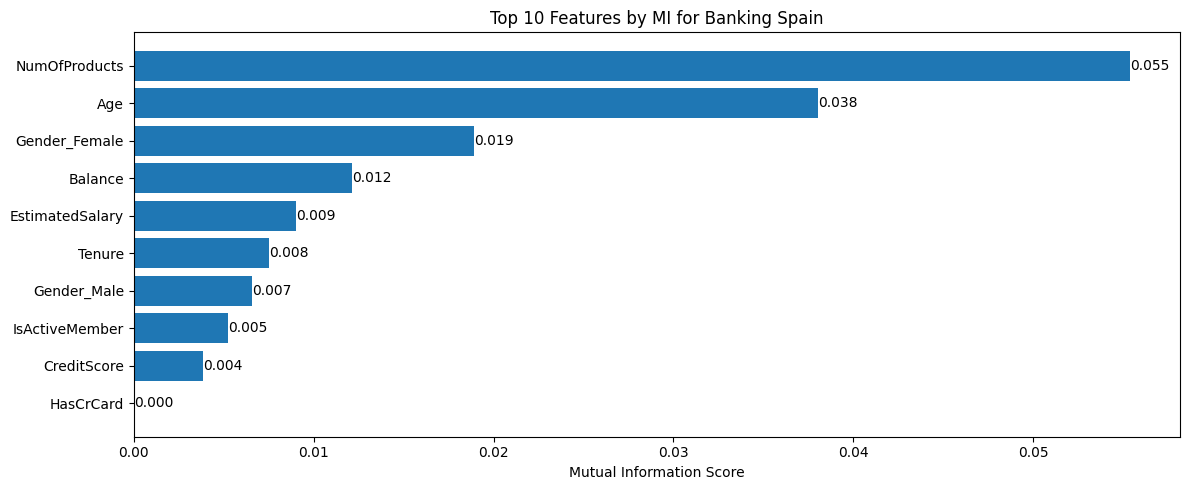

In [59]:
# Filter subgroup Geography = Spain
banking_spain = df_banking[df_banking["Geography_Spain"] == 1]

# Separate features and target
X_spain = banking_spain.drop(columns="Exited")
y_spain = banking_spain["Exited"]

# Compute mutual information
mi_spain = mutual_info_classif(X_spain, y_spain, random_state=42)
mi_spain_series = pd.Series(mi_spain, index=X_spain.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_spain_series.index, mi_spain_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Spain")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_spain_fi.png")
plt.show()

##### Germany

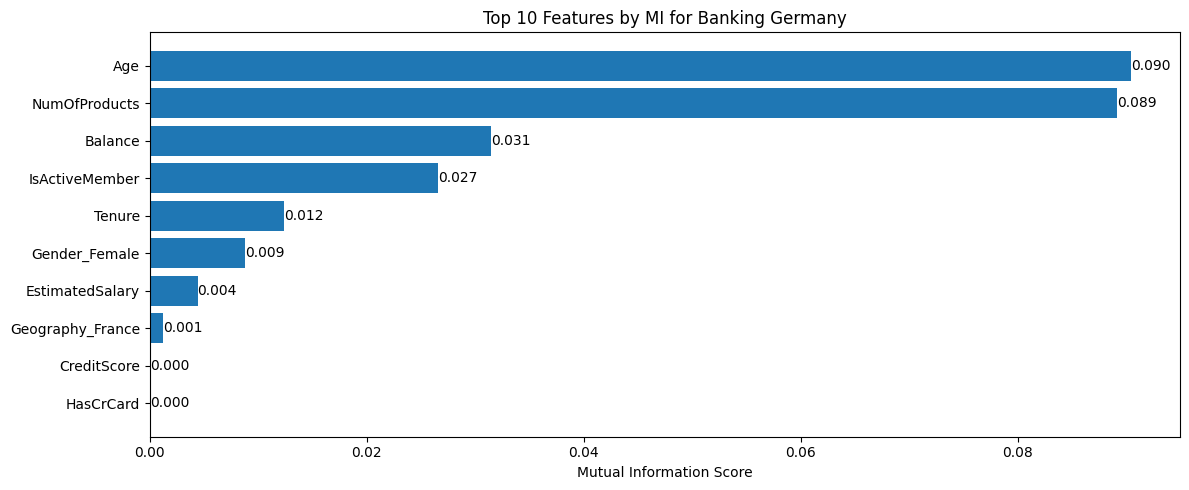

In [60]:
# Filter subgroup Geography = Germany
banking_germany = df_banking[df_banking["Geography_Germany"] == 1]

# Separate features and target
X_germany = banking_germany.drop(columns="Exited")
y_germany = banking_germany["Exited"]

# Compute mutual information
mi_germany = mutual_info_classif(X_germany, y_germany, random_state=42)
mi_germany_series = pd.Series(mi_germany, index=X_germany.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_germany_series.index, mi_germany_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Banking Germany")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("banking_germany_fi.png")
plt.show()

### Telecommunication

#### Gender

##### Male

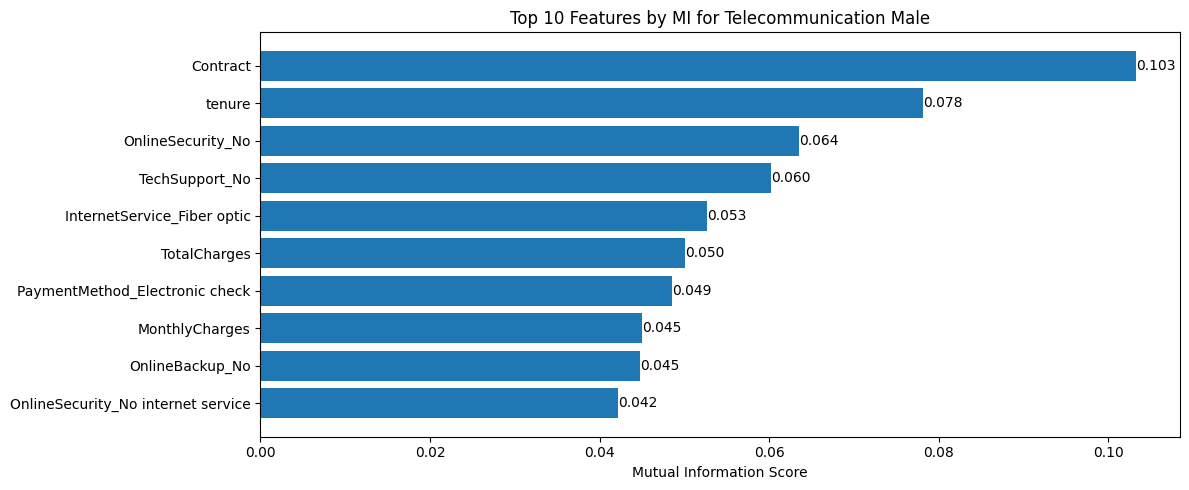

In [61]:
# Filter subgroup Gender = Female
telecom_female = df_telecom[df_telecom["gender_Female"] == 1]

# Separate features and target
X_female = telecom_female.drop(columns="Churn")
y_female = telecom_female["Churn"]

# Compute mutual information
mi_female = mutual_info_classif(X_female, y_female, random_state=42)
mi_female_series = pd.Series(mi_female, index=X_female.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_female_series.index, mi_female_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Telecommunication Male")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("telecom_male_fi.png")
plt.show()

##### Female

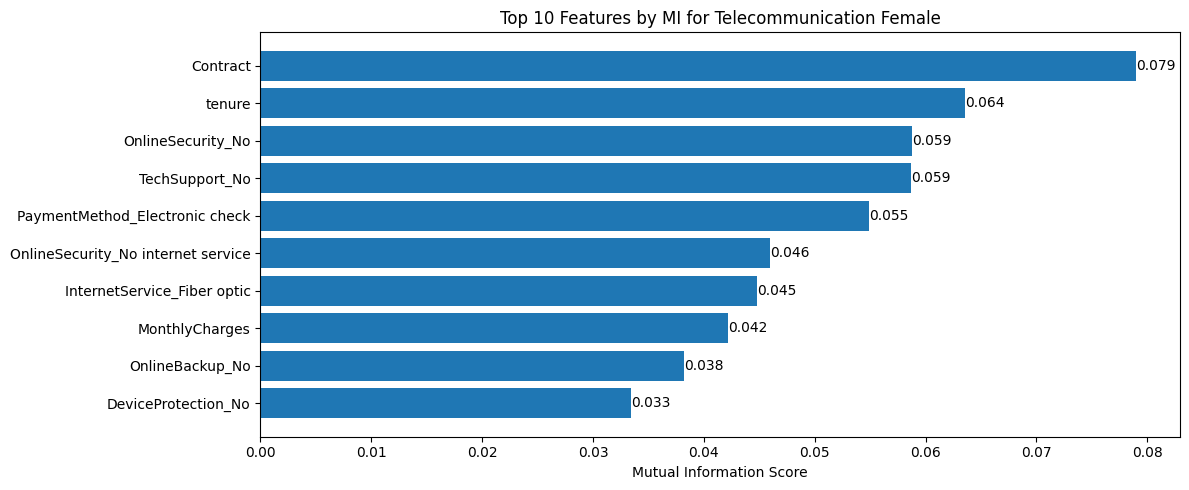

In [62]:
# Filter subgroup Gender = Male
telecom_male = df_telecom[df_telecom["gender_Male"] == 1]

# Separate features and target
X_male = telecom_male.drop(columns="Churn")
y_male = telecom_male["Churn"]

# Compute mutual information
mi_male = mutual_info_classif(X_male, y_male, random_state=42)
mi_male_series = pd.Series(mi_male, index=X_male.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_male_series.index, mi_male_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Telecommunication Female")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("telecom_female_fi.png")
plt.show()

#### Age

##### <30

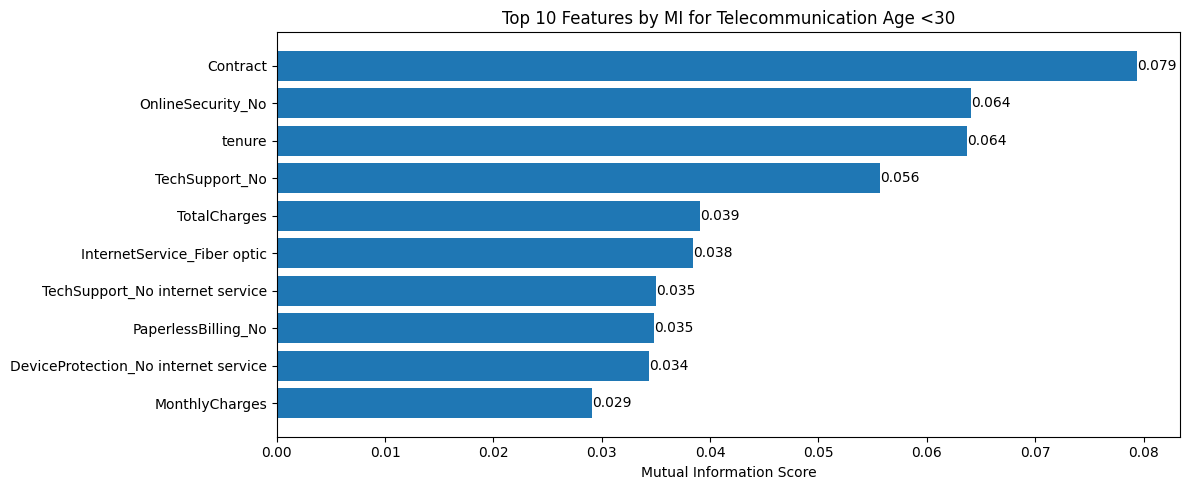

In [63]:
# Filter subgroup Age < 30
telecom_30 = df_telecom[df_telecom.Age < 30]

# Separate features and target
X_30 = telecom_30.drop(columns="Churn")
y_30 = telecom_30["Churn"]

# Compute mutual information
mi_30 = mutual_info_classif(X_30, y_30, random_state=42)
mi_30_series = pd.Series(mi_30, index=X_30.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_30_series.index, mi_30_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Telecommunication Age <30")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("telecom_age_30_fi.png")
plt.show()

##### 30-65

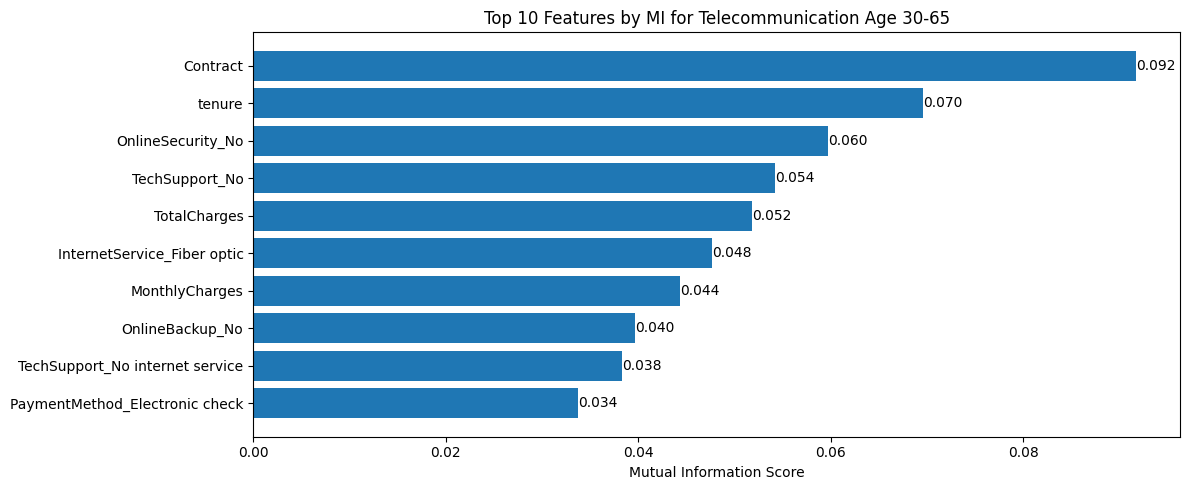

In [64]:
# Filter subgroup Age 30–65
telecom_30_65 = df_telecom[(df_telecom.Age >= 30) & (df_telecom.Age < 65)]

# Separate features and target
X_30_65 = telecom_30_65.drop(columns="Churn")
y_30_65 = telecom_30_65["Churn"]

# Compute mutual information
mi_30_65 = mutual_info_classif(X_30_65, y_30_65, random_state=42)
mi_30_65_series = pd.Series(mi_30_65, index=X_30_65.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_30_65_series.index, mi_30_65_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Telecommunication Age 30-65")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("telecom_age_30_65_fi.png")
plt.show()

##### ≥ 65

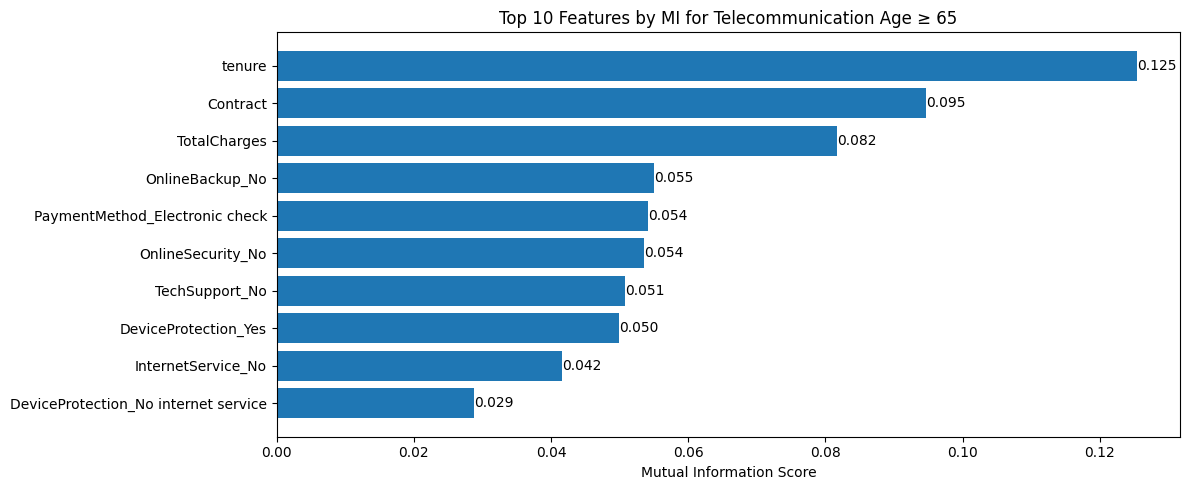

In [65]:
# Filter subgroup Age ≥ 65
telecom_65 = df_telecom[df_telecom.Age >= 65]

# Separate features and target
X_65 = telecom_65.drop(columns="Churn")
y_65 = telecom_65["Churn"]

# Compute mutual information
mi_65 = mutual_info_classif(X_65, y_65, random_state=42)
mi_65_series = pd.Series(mi_65, index=X_65.columns).sort_values(ascending=False).head(10)

# Create figure
plt.figure(figsize=(12, 5))

bars = plt.barh(mi_65_series.index, mi_65_series.values)

# Add labels on bars (same style you used before)
plt.bar_label(bars, fmt="%.3f")

plt.xlabel("Mutual Information Score")
plt.title("Top 10 Features by MI for Telecommunication Age ≥ 65")
plt.gca().invert_yaxis()   # Highest values on top
plt.tight_layout()
plt.savefig("telecom_age_65_fi.png")
plt.show()

## Feature selection
A common feature selection approach removes features that are highly correlated (often with thresholds between 0.7 and 0.9) to avoid multicollinearity. Multicollinearity means that two or more predictors carry very similar information, which leads to unstable and unreliable coefficient estimates in linear models. In such cases, small changes in the dataset can cause large fluctuations in coefficients, which undermines generalizability and increases the risk of overfitting.

In both datasets, only TotalCharges and Tenure (0.83) and TotalCharges and MonthlyCharges (0.65) show such correlations. However, feature removal will not be applied here for two reasons. First, all three features have been shown to provide strong predictive signal in prior churn studies using the same dataset. Second, state-of-the-art models such as Random Forest and XGBoost are robust to multicollinearity, so removing informative features could harm their performance.

While Logistic Regression and MLP are more sensitive to multicollinearity and therefore face an increased risk of overfitting, as they rely directly on coefficients. This risk is mitigated through L2 regularization, which shrinks correlated coefficients together, and dropout in MLPs, which reduces reliance on individual features. Consequently, retaining these informative features is advantageous overall, since tree-based ensembles can fully exploit their predictive value while the overfitting risk for LR and MLP remains minor.

Additionally, it has been checked whether there are obvious irrelevant features which have extremely low variance after encoding as this can increase the number of these features. A common threshold is features where one category holds more than 98% of that feature. However, no extreme low variance features were found and therefore no additional features are removed.

### Variance thresholding

#### Banking

In [461]:
# Remove features with very low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_banking.drop(columns=["Exited"]))

# Check which ones were removed
print(df_banking.drop(columns=["Exited"]).columns[~selector.get_support()])

Index([], dtype='object')


#### Telecommunication

In [462]:
# Remove features with very low variance except the target
selector = VarianceThreshold(threshold=0.01)
selector.fit(df_telecom.drop(columns=["Churn"]))

# Check which ones were removed
df_telecom.drop(columns=["Churn"]).columns[~selector.get_support()]

Index([], dtype='object')

# Model evaluation and optimization

## Functions

### Equal Opportunity Difference (EOD)

In [68]:
# === Fairness helpers (define once, reuse everywhere) ===
import numpy as np
import pandas as pd

def tpr_safe(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    pos = (y_true == 1)
    denom = pos.sum()
    return np.nan if denom == 0 else float((y_pred[pos] == 1).sum() / denom)

def group_tprs_onehot(X, y_true, y_pred, cols):
    """
    Compute per-group TPR and EOD (= max TPR - min TPR) for a list of one-hot columns.
    Returns: (tpr_dict, eod) with NaNs for empty/invalid groups; EOD=NaN if <2 valid groups.
    """
    tprs, vals = {}, []
    for c in cols:
        if c not in X.columns:
            continue
        idx = (X[c].values == 1)
        if idx.sum() == 0:
            tprs[c] = np.nan
        else:
            t = tpr_safe(y_true[idx], y_pred[idx])
            tprs[c] = t
            if not np.isnan(t):
                vals.append(t)
    eod = float(np.max(vals) - np.min(vals)) if len(vals) >= 2 else np.nan
    return tprs, eod

def age_bucketize(df, bins=(18, 30, 65, 200),
                  labels=("Age_<30", "Age_30-65", "Age_>=65")):
    """
    Build age buckets from numeric Age (fairness ONLY). Returns (df_with_buckets, label_names).
    Assumes df['Age'] exists and is numeric.
    """
    tmp = pd.get_dummies(
        pd.cut(df["Age"].clip(lower=bins[0], upper=bins[-1]),
               bins=bins, labels=labels, include_lowest=True),
        dtype=int
    )
    return df.join(tmp), list(labels)

def mean_std(arr_like):
    a = np.asarray(arr_like, dtype=float)
    a = a[~np.isnan(a)]
    if a.size == 0:
        return np.nan, np.nan
    return float(np.mean(a)), float(np.std(a))

def agg_means_stds(tpr_agg_dict):
    """
    tpr_agg_dict: dict[group_col] -> list of TPRs across folds (may contain NaN)
    Returns: (means_dict, stds_dict)
    """
    means, stds = {}, {}
    for g, vals in tpr_agg_dict.items():
        m, s = mean_std(vals)
        means[g], stds[g] = m, s
    return means, stds

def find_gender_cols(cols):
    # case-insensitive: matches 'Gender_*' AND 'gender_*'
    return sorted([c for c in cols if c.lower().startswith("gender_")])

def find_geo_cols(cols):
    # case-insensitive: matches 'Geography_*'/'geography_*' and 'Location_*'/'location_*'
    return sorted([c for c in cols if c.lower().startswith("geography_") or c.lower().startswith("location_")])

def _pretty_tprs(title, means, stds):
        if not means:
            print(f"{title}: (no groups found)")
            return
        print(f"\n=== {title} TPRs (mean ± std across folds) ===")
        for g in sorted(means.keys()):
            m = means[g]; s = stds[g]
            print(f"{g}: {np.round(m,4)} ± {np.round(s,4)}")

In [69]:
import time
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score

def run_nested_cv_with_diagnostics(
    pipe,
    param_grid,
    X,
    y,
    scorer="roc_auc",
    inner_splits=5,
    outer_splits=5,
    random_state=42
):
    """
    Nested CV:
      - Inner: GridSearchCV by scorer
      - Outer: evaluate on TEST folds (threshold=0.5)
      - Fairness: EOD (max TPR - min TPR) mean±std across folds,
                  and TPR per group (mean±std) for Age, Gender, Geography.

    Assumes:
      - X['Age'] is numeric
      - Gender is one-hot: 'Gender_*' or 'gender_*'
      - Geography is one-hot: 'Geography_*'/'geography_*' or 'Location_*'/'location_*'
    """
    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)
    oof_pred  = np.zeros(n, dtype=int)

    fold_train_metrics, fold_test_metrics = [], []
    fold_thresholds = []  # NEW: store chosen threshold per outer fold

    # Fairness aggregates across outer folds
    age_tpr_agg     = defaultdict(list)
    gender_tpr_agg  = defaultdict(list)
    geo_tpr_agg     = defaultdict(list)
    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []

    # case-insensitive detection on full X
    gender_cols_all = find_gender_cols(X.columns)
    geo_cols_all    = find_geo_cols(X.columns)

    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # Create outer folds
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr, X_te = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_tr, y_te = y.iloc[train_idx].values, y.iloc[test_idx].values

        # Inner-cv
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=scorer,
            refit=True,
            n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        best_model = grid.best_estimator_

        # --- threshold tuning on pooled inner-validation predictions (best model) ---
        inner_val_proba = cross_val_predict(
            best_model, X_tr, y_tr, cv=inner_cv, method="predict_proba"
        )[:, 1]
        # choose threshold that maximizes F1 on pooled inner-val predictions
        thresh_grid = np.linspace(0.01, 0.99, 99)
        # choose threshold that maximizes F2 on pooled inner-val predictions
        f2_vals = [fbeta_score(y_tr, (inner_val_proba >= t).astype(int), beta=2, zero_division=0)
                   for t in thresh_grid]
        chosen_threshold = float(thresh_grid[int(np.argmax(f2_vals))])
        fold_thresholds.append(chosen_threshold)  # NEW

        # Predict (using tuned threshold)
        train_proba = best_model.predict_proba(X_tr)[:, 1]
        test_proba  = best_model.predict_proba(X_te)[:, 1]
        train_pred  = (train_proba >= chosen_threshold).astype(int)
        test_pred   = (test_proba  >= chosen_threshold).astype(int)

        # Standard metrics
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba),
            "Recall": recall_score(y_tr, train_pred, zero_division=0),
            "Precision": precision_score(y_tr, train_pred, zero_division=0),
            "F1": f1_score(y_tr, train_pred, zero_division=0),
            "F2": fbeta_score(y_tr, train_pred, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba),
            "Recall": recall_score(y_te, test_pred, zero_division=0),
            "Precision": precision_score(y_te, test_pred, zero_division=0),
            "F1": f1_score(y_te, test_pred, zero_division=0),
            "F2": fbeta_score(y_te, test_pred, beta=2, zero_division=0),
        })

        # Fairness on TEST
        # Age buckets on-the-fly (assumes numeric Age exists)
        X_te_age, age_cols = age_bucketize(X_te)
        age_tprs, eod_age = group_tprs_onehot(X_te_age, y_te, test_pred, age_cols)
        for g, v in age_tprs.items():
            age_tpr_agg[g].append(v)
        eod_age_folds.append(eod_age)

        # Gender (case-insensitive)
        gcols = [c for c in gender_cols_all if c in X_te.columns]
        gen_tprs, eod_gen = group_tprs_onehot(X_te, y_te, test_pred, gcols)
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        # Geography (case-insensitive)
        lcols = [c for c in geo_cols_all if c in X_te.columns]
        geo_tprs, eod_geo = group_tprs_onehot(X_te, y_te, test_pred, lcols)
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

        # OOF
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx]  = test_pred

    # Pooled OOF metrics
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0)
    }

    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics ).set_index("Fold").sort_index()

    # EOD summaries
    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    # TPR per group summaries (mean±std)
    def _agg_means_stds_local(tpr_agg):  # thin wrapper; uses global helper
        return agg_means_stds(tpr_agg)

    age_tpr_means,    age_tpr_stds    = _agg_means_stds_local(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = _agg_means_stds_local(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = _agg_means_stds_local(geo_tpr_agg)

    # ---- prints (no per-fold EOD table) ----
    print("\n=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " + train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics (outer folds; threshold=0.5) ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " + test_df.std().round(4).astype(str))

    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    _pretty_tprs("Age",       age_tpr_means,    age_tpr_stds)
    _pretty_tprs("Gender",    gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means,    geo_tpr_stds)

    print("\n=== OOF metrics (pooled) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    # NEW: also show chosen thresholds per outer fold
    print(f"\nThresholds chosen per outer fold: {np.array(fold_thresholds)}")

    print(f"Total runtime: {time.time() - start:.2f} s")

    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,
        "oof_pred": oof_pred,
        "oof_results": oof_results,
        # handy for mitigation functions that want per-fold fairness
        "fold_eod": {
            "age": eod_age_folds, "gender": eod_gender_folds, "geography": eod_geo_folds
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        },
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "fold_thresholds": np.array(fold_thresholds),  # NEW
    }

In [70]:
def compute_tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).reshape(4)
    return float(tp / (tp + fn))  # force Python float

def compute_eod(X, y_true, y_pred, group_cols):
    tprs = {}
    for group in group_cols:
        subgroup = X[group] == 1
        tprs[group] = float(compute_tpr(y_true[subgroup], y_pred[subgroup]))
    return float(max(tprs.values()) - min(tprs.values())), tprs

def evaluate_fairness_final(model_name, X, X_with_age, y_true, y_pred, age_labels, gender_cols, location_cols=None):
    """
    Compute EOD and TPRs for Age, Gender, and (optionally) Location groups for a given model.
    Works for both banking (with location) and telecom (without).
    """
    results = {}

    # --- Age ---
    age_results = compute_eod(X_with_age, y_true, y_pred, age_labels)
    results["Age_EOD"], results["Age_TPRs"] = age_results[0], age_results[1]

    # --- Gender ---
    gender_results = compute_eod(X, y_true, y_pred, gender_cols)
    results["Gender_EOD"], results["Gender_TPRs"] = gender_results[0], gender_results[1]

    # --- Location (optional) ---
    if location_cols is not None:
        location_results = compute_eod(X, y_true, y_pred, location_cols)
        results["Location_EOD"], results["Location_TPRs"] = location_results[0], location_results[1]

    # Print summary
    print(f"\n=== Fairness results for {model_name} ===")
    print(f"Age EOD: {results['Age_EOD']:.4f} \nTPRs Age: {results['Age_TPRs']}")
    print(f"Gender EOD: {results['Gender_EOD']:.4f} \nTPRs Gender: {results['Gender_TPRs']}")
    if location_cols is not None:
        print(f"Location EOD: {results['Location_EOD']:.4f} \nTPRs Location: {results['Location_TPRs']}")

    return results

In [416]:
def extract_mean(val):
    """Extract float mean from strings like '0.847 ± 0.009'."""
    if isinstance(val, (int, float)):
        return float(val)
    if isinstance(val, str):
        return float(val.split("±")[0].strip())
    raise ValueError(f"Unexpected value type: {val}")

def annotate_deltas(ax, bars_xgb, bars_mlp, deltas, base_vals, lower_is_better=False, dy=0.07):
    """
    Annotate difference between MLP and XGB above each pair.

    dy controls how high above the bars the annotation appears.
    """
    for b1, b2, dl, base in zip(bars_xgb, bars_mlp, deltas, base_vals):
        x = (b1.get_x() + b2.get_x()) / 2 + b1.get_width() / 2
        
        # height of tallest bar
        y = max(b1.get_height(), b2.get_height())

        pct = (dl / base) * 100 if base != 0 else 0

        
        if lower_is_better:
            # fairness: lower is better → negative = green
            color = "tab:green" if dl <= 0 else "tab:red"
        else:
            # performance: higher is better → positive = green
            color = "tab:green" if dl >= 0 else "tab:red"
        
        ax.text(
            x, y + dy,
            f"{dl:+.3f} ({pct:+.1f}%)",
            ha="center", va="bottom",
            color=color,
            fontsize=7,      # smaller font
            fontweight="normal"
        )

def annotate_values(ax, bars, dy=0.01, fmt="{:.3f}"):
    """
    Annotate each bar with its numeric value.

    Parameters
    ----------
    ax : matplotlib axis
    bars : BarContainer
        Bars to annotate.
    dy : float
        Vertical offset above the bar height.
    fmt : str
        Format string for the value (default 3 decimals).
    """
    for b in bars:
        h = b.get_height()
        ax.text(
            b.get_x() + b.get_width()/2,
            h + dy,
            fmt.format(h),
            ha="center",
            va="bottom",
            fontsize=8
        )

## Banking

In [72]:
# Retrieve the samples (X) and the target (y)
banking_X = df_banking.drop(columns="Exited")
banking_y = df_banking["Exited"]

In [73]:
# Bins for age column
age_bins   = [18, 30, 65, 92]
age_labels = ["Age_<30", "Age_30-65", "Age_>=65"]

# Create one hot columns for the age groups
banking_age_ohe = pd.get_dummies(pd.cut(banking_X["Age"], bins=age_bins, labels=age_labels), dtype=int)

# Join one hot encoded age columns to X 
banking_X_with_age_ohe = banking_X.join(banking_age_ohe)

banking_gender_cols = ["Gender_Female","Gender_Male"]
location_cols = ["Geography_France","Geography_Germany","Geography_Spain"]

### Logistic Regression

In [74]:
pipe_lr = Pipeline([
    ("scaler", MinMaxScaler()),
    ("sampling", SMOTEENN(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000, solver ="liblinear"))
])

param_grid_lr = {
    "clf__C": numpy.logspace(-4, 4, 50),
    "clf__penalty": ["l1", "l2"],
}

banking_lr_results = run_nested_cv_with_diagnostics(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X=banking_X,       
    y=banking_y,
)

# Access pieces if needed:
banking_lr_train_df = banking_lr_results["train_df"]
banking_lr_test_df   = banking_lr_results["test_df"]
banking_lr_pred = banking_lr_results["oof_pred"]
banking_lr_proba = banking_lr_results["oof_proba"]
banking_lr_eod = banking_lr_results["eod_summary"]
banking_lr_tpr = banking_lr_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7640  0.8293     0.3111  0.4524  0.6221
2     0.7730  0.8453     0.3187  0.4629  0.6353
3     0.7708  0.8135     0.3261  0.4656  0.6263
4     0.7694  0.8411     0.3199  0.4635  0.6344
5     0.7628  0.8497     0.3037  0.4474  0.6249

Mean (±std) TRAIN:
AUC           0.768 ± 0.0044
Recall       0.8358 ± 0.0146
Precision    0.3159 ± 0.0087
F1            0.4584 ± 0.008
F2           0.6286 ± 0.0059
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7844  0.8873     0.3206  0.4710  0.6556
2     0.7466  0.8064     0.3010  0.4384  0.6037
3     0.7516  0.7764     0.3215  0.4547  0.6051
4     0.7674  0.8354     0.3151  0.4576  0.6280
5     0.7817  0.8550     0.3080  0.4528  0.6309

Mean (±std) TEST:
AUC   

#### Confusion Matrix

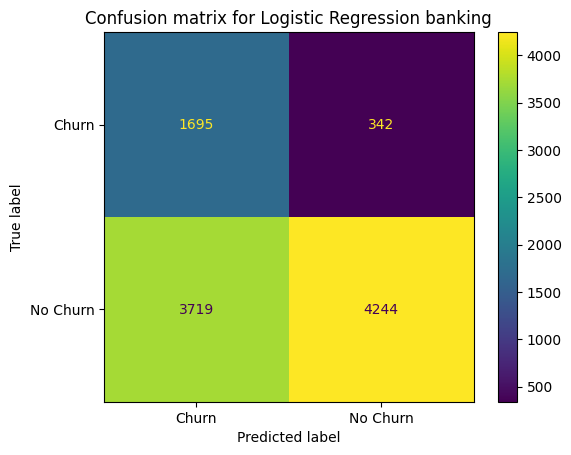

In [507]:
# Swap the labels so "1" (Exited / Churn) is shown first
banking_lr_cm = confusion_matrix(banking_y, banking_lr_pred, labels=[1, 0])

# Plot
banking_cm_lr_display = ConfusionMatrixDisplay(confusion_matrix=banking_lr_cm,display_labels=["Churn", "No Churn"])
banking_cm_lr_display.plot()
plt.title("Confusion matrix for Logistic Regression banking")
plt.savefig("banking_lr_cm")
plt.show()

### Random Forest

In [76]:
pipe_rf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("sampling", SMOTEENN(random_state=42)),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    "clf__n_estimators": [50, 100, 200, 250],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [2,4,6,8],
    "clf__min_samples_leaf": [1, 3, 5, 7, 9],         
    "clf__max_features": ["sqrt", "log2"],    
}

banking_rf_results = run_nested_cv_with_diagnostics(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X=banking_X,        
    y=banking_y,       
)

# Access pieces if needed:
banking_rf_train_df = banking_rf_results["train_df"]
banking_rf_test_df   = banking_rf_results["test_df"]
banking_rf_pred = banking_rf_results["oof_pred"]
banking_rf_proba = banking_rf_results["oof_proba"]
banking_rf_eod = banking_rf_results["eod_summary"]
banking_rf_tpr = banking_rf_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8821  0.8975     0.4046  0.5578  0.7217
2     0.8810  0.8870     0.4207  0.5707  0.7261
3     0.8829  0.9172     0.3851  0.5425  0.7186
4     0.8822  0.9037     0.4028  0.5572  0.7237
5     0.8835  0.8804     0.4282  0.5762  0.7269

Mean (±std) TRAIN:
AUC          0.8823 ± 0.0009
Recall       0.8972 ± 0.0144
Precision    0.4083 ± 0.0168
F1           0.5609 ± 0.0132
F2           0.7234 ± 0.0034
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8525  0.8775     0.3809  0.5312  0.6960
2     0.8360  0.8137     0.3948  0.5316  0.6712
3     0.8459  0.8919     0.3652  0.5182  0.6922
4     0.8465  0.8428     0.3630  0.5074  0.6665
5     0.8566  0.8329     0.4216  0.5599  0.6970

Mean (±std) TEST:
AUC   

#### Confusion matrix

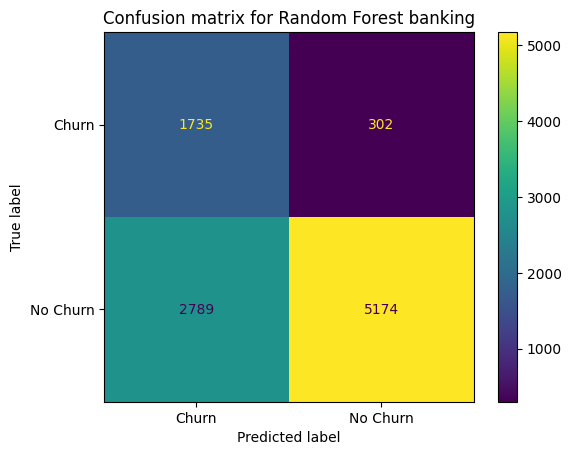

In [508]:
# Swap the labels so "1" (Exited / Churn) is shown first
banking_rf_cm = confusion_matrix(banking_y, banking_rf_pred, labels=[1, 0])

# Plot
banking_cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=banking_rf_cm,display_labels=["Churn", "No Churn"])
banking_cm_rf_display.plot()
plt.title("Confusion matrix for Random Forest banking")
plt.savefig("banking_rf_cm")
plt.show()

### XGBoost

In [78]:
pipe_xgb = Pipeline([
    ("scaler", MinMaxScaler()),
    ("sampling", SMOTEENN(random_state=42)),
    ("clf", XGBClassifier(eval_metric="logloss", random_state=42))
])

param_grid_xgb = {
    "clf__max_depth":        [3, 4, 5, 6],
    "clf__n_estimators":     [50, 100, 150, 200, 250],
    "clf__learning_rate":    [0.01, 0.1, 0.2],
}

banking_xgb_results = run_nested_cv_with_diagnostics(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X=banking_X,        
    y=banking_y,        
)

# Access pieces if needed:
banking_xgb_train_df = banking_xgb_results["train_df"]
banking_xgb_test_df   = banking_xgb_results["test_df"]
banking_xgb_pred = banking_xgb_results["oof_pred"]
banking_xgb_proba = banking_xgb_results["oof_proba"]
banking_xgb_eod = banking_xgb_results["eod_summary"]
banking_xgb_tpr = banking_xgb_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8831  0.8692     0.4312  0.5764  0.7224
2     0.8805  0.8735     0.4188  0.5661  0.7177
3     0.8882  0.9061     0.3989  0.5539  0.7224
4     0.8836  0.8963     0.4071  0.5599  0.7226
5     0.8811  0.8840     0.4032  0.5538  0.7138

Mean (±std) TRAIN:
AUC           0.8833 ± 0.003
Recall       0.8859 ± 0.0154
Precision    0.4118 ± 0.0131
F1            0.562 ± 0.0095
F2           0.7198 ± 0.0039
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8662  0.8456     0.4021  0.5450  0.6928
2     0.8467  0.8284     0.3972  0.5369  0.6806
3     0.8601  0.8894     0.3791  0.5316  0.7007
4     0.8659  0.8600     0.3813  0.5283  0.6874
5     0.8690  0.8575     0.4011  0.5466  0.6986

Mean (±std) TEST:
AUC   

#### Confusion matrix

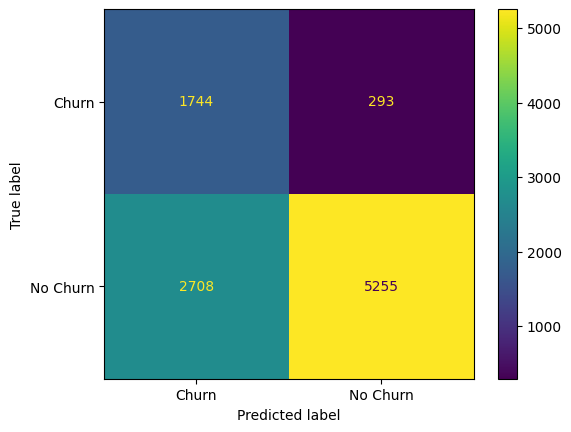

In [651]:
# Swap the labels so "1" (Exited / Churn) is shown first
banking_xgb_cm = confusion_matrix(banking_y, banking_xgb_pred, labels=[1, 0])

# Plot
banking_cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix=banking_xgb_cm,display_labels=["Churn", "No Churn"])
banking_cm_xgb_display.plot()
plt.savefig("banking_xgb_cm.png")
plt.show()

### Multi Layer Perceptron

In [80]:
pipe_mlp = Pipeline([
    ("scaler", MinMaxScaler()),  
    ("sampling", SMOTEENN(random_state=42)),  
    ("clf", MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])

param_grid_mlp = {
    "clf__hidden_layer_sizes": [(50,), (100,), (150,), (200,), (250,)], 
    "clf__activation": ["relu", "tanh", "logistic"],
    "clf__solver": ["adam", "sgd"],
    "clf__batch_size": [32, 64],     
    "clf__learning_rate_init": [0.001, 0.005, 0.01]  
}

banking_mlp_results = run_nested_cv_with_diagnostics(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X=banking_X,       
    y=banking_y,        
)

# Access pieces if needed:
banking_mlp_train_df = banking_mlp_results["train_df"]
banking_mlp_test_df   = banking_mlp_results["test_df"]
banking_mlp_pred = banking_mlp_results["oof_pred"]
banking_mlp_proba = banking_mlp_results["oof_proba"]
banking_mlp_eod = banking_mlp_results["eod_summary"]
banking_mlp_tpr = banking_mlp_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8603  0.8699     0.3927  0.5411  0.6998
2     0.8639  0.8840     0.3917  0.5429  0.7064
3     0.8529  0.9135     0.3481  0.5041  0.6895
4     0.8701  0.8215     0.4572  0.5874  0.7085
5     0.8594  0.8969     0.3640  0.5179  0.6938

Mean (±std) TRAIN:
AUC          0.8613 ± 0.0063
Recall        0.8771 ± 0.035
Precision    0.3907 ± 0.0417
F1           0.5387 ± 0.0317
F2           0.6996 ± 0.0081
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8507  0.8529     0.3762  0.5221  0.6805
2     0.8341  0.8603     0.3750  0.5223  0.6834
3     0.8509  0.9066     0.3484  0.5034  0.6866
4     0.8436  0.7641     0.4152  0.5381  0.6542
5     0.8571  0.8698     0.3653  0.5145  0.6816

Mean (±std) TEST:
AUC   

#### Confusion Matrix

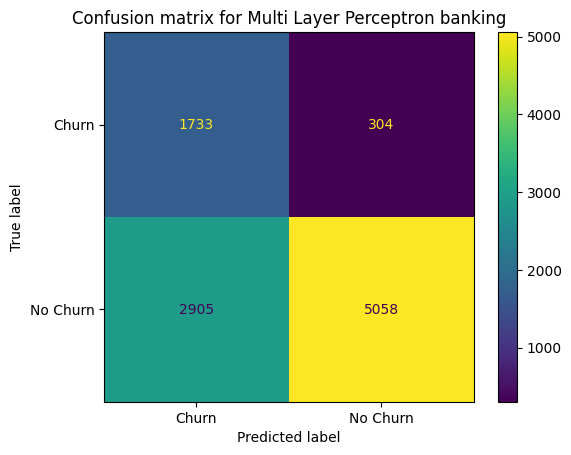

In [509]:
# Swap the labels so "1" (Exited / Churn) is shown first
banking_mlp_cm = confusion_matrix(banking_y, banking_mlp_pred, labels=[1, 0])

# Plot
banking_cm_mlp_display = ConfusionMatrixDisplay(confusion_matrix=banking_mlp_cm,display_labels=["Churn", "No Churn"])
banking_cm_mlp_display.plot()
plt.title("Confusion matrix for Multi Layer Perceptron banking")
plt.savefig("banking_mlp_cm")
plt.show()

### Results

#### ROC Curves

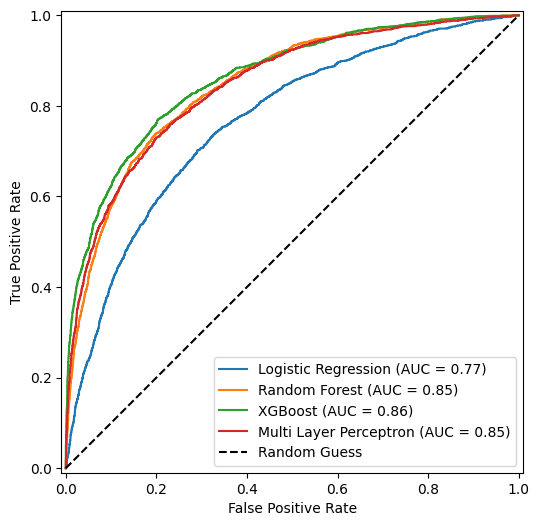

In [642]:
fig, ax = plt.subplots(figsize=(8, 6))

RocCurveDisplay.from_predictions(banking_y, banking_lr_proba, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(banking_y, banking_rf_proba, name="Random Forest", ax=ax)
RocCurveDisplay.from_predictions(banking_y, banking_xgb_proba, name="XGBoost", ax=ax)
RocCurveDisplay.from_predictions(banking_y, banking_mlp_proba, name="Multi Layer Perceptron", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("ROC curves banking")
plt.show()

#### Performance

##### Training

In [83]:
# Create columns by using dictionary
banking_performance = {
    "Logistic Regression test": (banking_lr_test_df.mean().round(3)),
    "Random Forest test": (banking_rf_test_df.mean().round(3)),
    "XGBoost test": (banking_xgb_test_df.mean().round(3)),
    "Multi Layer Perceptron test": (banking_mlp_test_df.mean().round(3))
}

# Create rows
performance_metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

# Create DataFrame
df_banking_performance = pd.DataFrame(banking_performance, index=performance_metrics)

# Display nicely
df_banking_performance

,Logistic Regression test,Random Forest test,XGBoost test,Multi Layer Perceptron test
AUC,0.766,0.847,0.862,0.847
Recall,0.832,0.852,0.856,0.851
Precision,0.313,0.385,0.392,0.376
F1,0.455,0.530,0.538,0.520
F2,0.625,0.685,0.692,0.677


In [85]:
# Create columns by using dictionary
banking_performance_std = {
    "Logistic Regression test": (banking_lr_test_df.mean().round(3)).astype(str) + " ± " +
                                banking_lr_test_df.std().round(3).astype(str),
    "Random Forest test": (banking_rf_test_df.mean().round(3)).astype(str) + " ± " +
                          banking_rf_test_df.std().round(3).astype(str),
    "XGBoost test": (banking_xgb_test_df.mean().round(3)).astype(str) + " ± " +
                    banking_xgb_test_df.std().round(3).astype(str),
    "Multi Layer Perceptron test": (banking_mlp_test_df.mean().round(3)).astype(str) + " ± " +
                                   banking_mlp_test_df.std().round(3).astype(str),
}

# Create rows
performance_metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

# Create DataFrame
df_banking_performance_std = pd.DataFrame(banking_performance_std, index=performance_metrics)

# Display nicely
df_banking_performance_std

,Logistic Regression test,Random Forest test,XGBoost test,Multi Layer Perceptron test
AUC,0.766 ± 0.017,0.847 ± 0.008,0.862 ± 0.009,0.847 ± 0.009
Recall,0.832 ± 0.043,0.852 ± 0.032,0.856 ± 0.022,0.851 ± 0.053
Precision,0.313 ± 0.009,0.385 ± 0.024,0.392 ± 0.011,0.376 ± 0.025
F1,0.455 ± 0.012,0.53 ± 0.02,0.538 ± 0.008,0.52 ± 0.013
F2,0.625 ± 0.021,0.685 ± 0.015,0.692 ± 0.008,0.677 ± 0.013


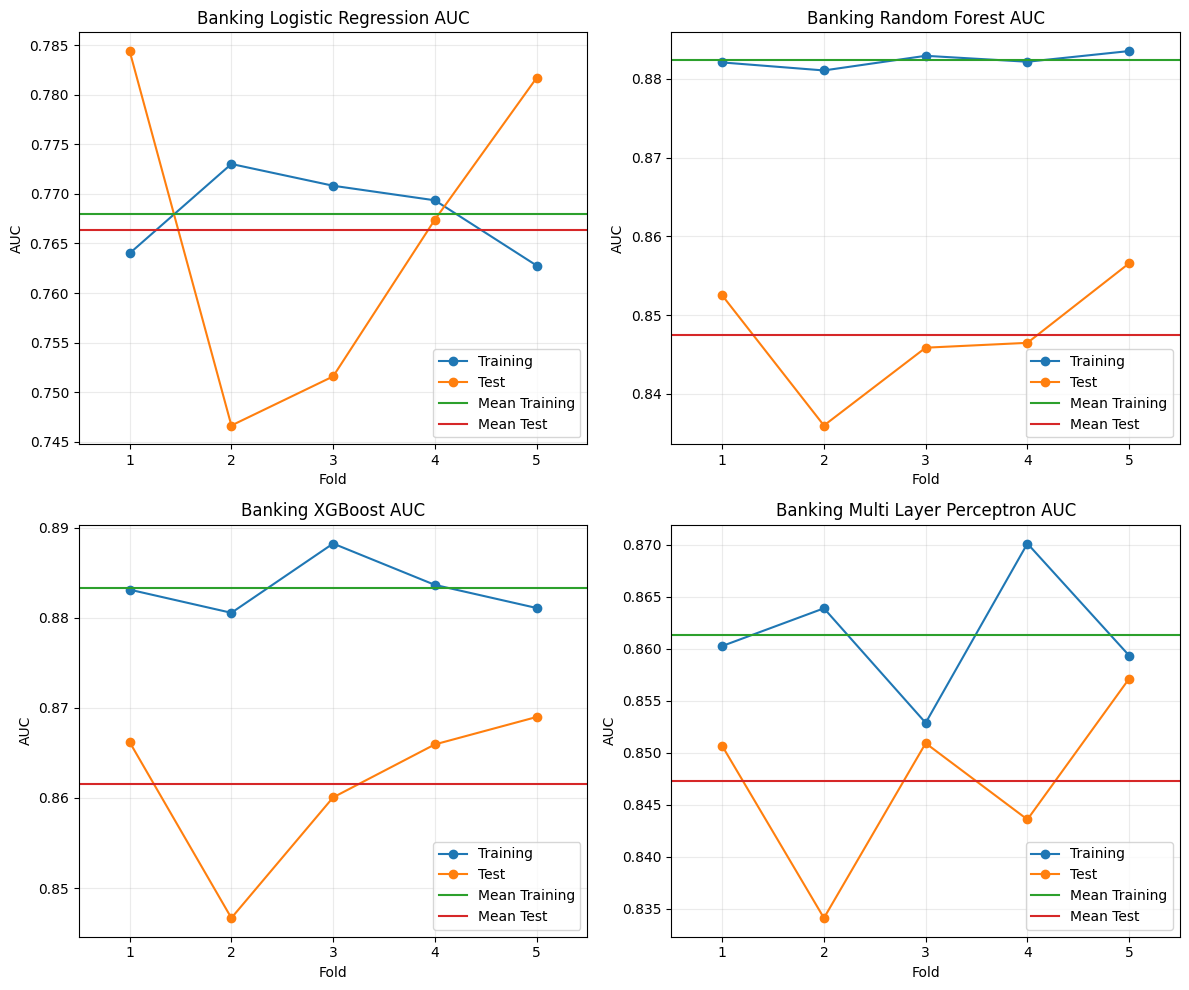

In [239]:
def plot_fold_curves(ax, train_df, test_df, index_loc, title):
    y_tr = train_df["AUC"].to_numpy()
    y_te = test_df["AUC"].to_numpy()
    x = np.arange(1, len(y_tr) + 1)     # 1..n folds

    ax.plot(x, y_tr, marker='o', label="Training")
    ax.plot(x, y_te, marker='o', label="Test")
    ax.axhline(y_tr.mean(), color="#2ca02c", label="Mean Training")
    ax.axhline(y_te.mean(), color="#d62728", label="Mean Test")
    ax.set_title(title)
    ax.set_xlabel("Fold")
    ax.set_ylabel("AUC")

    # Make ticks exactly 1..n and center points nicely
    ax.set_xlim(0.5, x[-1] + 0.5)
    ax.xaxis.set_major_locator(FixedLocator(x))
    ax.xaxis.set_major_formatter(FixedFormatter([str(i) for i in x]))
    ax.legend(loc=index_loc)
    ax.grid(True, alpha=0.25)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)

plot_fold_curves(axes[0,0], banking_lr_train_df,  banking_lr_test_df, 4, "Banking Logistic Regression AUC")
plot_fold_curves(axes[0,1], banking_rf_train_df,  banking_rf_test_df, 4, "Banking Random Forest AUC")
plot_fold_curves(axes[1,0], banking_xgb_train_df, banking_xgb_test_df, 4, "Banking XGBoost AUC")
plot_fold_curves(axes[1,1], banking_mlp_train_df, banking_mlp_test_df, 4, "Banking Multi Layer Perceptron AUC")

plt.tight_layout()
plt.savefig("Overfitting banking")
plt.show()

#### Fairness 

##### EOD

In [87]:
# ---- Create formatted fairness summary table ----
banking_fairness_EOD = {
    "Logistic Regression": [
        f"{round(banking_lr_eod['age_mean'],3)} ± {round(banking_lr_eod['age_std'],3)}",
        f"{round(banking_lr_eod['gender_mean'],3)} ± {round(banking_lr_eod['gender_std'],3)}",
        f"{round(banking_lr_eod['geography_mean'],3)} ± {round(banking_lr_eod['geography_std'],3)}"
    ],
    "Random Forest": [
        f"{round(banking_rf_eod['age_mean'],3)} ± {round(banking_rf_eod['age_std'],3)}",
        f"{round(banking_rf_eod['gender_mean'],3)} ± {round(banking_rf_eod['gender_std'],3)}",
        f"{round(banking_rf_eod['geography_mean'],3)} ± {round(banking_rf_eod['geography_std'],3)}"
    ],
    "XGBoost": [
        f"{round(banking_xgb_eod['age_mean'],3)} ± {round(banking_xgb_eod['age_std'],3)}",
        f"{round(banking_xgb_eod['gender_mean'],3)} ± {round(banking_xgb_eod['gender_std'],3)}",
        f"{round(banking_xgb_eod['geography_mean'],3)} ± {round(banking_xgb_eod['geography_std'],3)}"
    ],
    "Multi Layer Perceptron": [
        f"{round(banking_mlp_eod['age_mean'],3)} ± {round(banking_mlp_eod['age_std'],3)}",
        f"{round(banking_mlp_eod['gender_mean'],3)} ± {round(banking_mlp_eod['gender_std'],3)}",
        f"{round(banking_mlp_eod['geography_mean'],3)} ± {round(banking_mlp_eod['geography_std'],3)}"
    ],
}

df_banking_fairness = pd.DataFrame(
    banking_fairness_EOD,
    index=["Age EOD", "Gender EOD", "Geography EOD"]
)

# ---- Compute mean absolute EOD from raw numeric data ----
raw_data = {
    "Logistic Regression": [banking_lr_eod["age_mean"], banking_lr_eod["gender_mean"], banking_lr_eod["geography_mean"]],
    "Random Forest": [banking_rf_eod["age_mean"], banking_rf_eod["gender_mean"], banking_rf_eod["geography_mean"]],
    "XGBoost": [banking_xgb_eod["age_mean"], banking_xgb_eod["gender_mean"], banking_xgb_eod["geography_mean"]],
    "Multi Layer Perceptron": [banking_mlp_eod["age_mean"], banking_mlp_eod["gender_mean"], banking_mlp_eod["geography_mean"]],
}

# Convert raw_data to DataFrame
df_banking_raw = pd.DataFrame(raw_data, index=["Age EOD", "Gender EOD", "Geography EOD"])

# Add mean absolute EOD as a new row (rounded to 3 decimals)
df_banking_fairness.loc["Mean Absolute EOD"] = df_banking_raw.abs().mean().round(3)

df_banking_fairness

,Logistic Regression,Random Forest,XGBoost,Multi Layer Perceptron
Age EOD,0.621 ± 0.088,0.405 ± 0.091,0.464 ± 0.125,0.512 ± 0.072
Gender EOD,0.139 ± 0.049,0.093 ± 0.037,0.082 ± 0.046,0.061 ± 0.031
Geography EOD,0.225 ± 0.056,0.168 ± 0.035,0.155 ± 0.028,0.153 ± 0.034
Mean Absolute EOD,0.328,0.222,0.234,0.242


##### TPRs

In [88]:
import numpy as np
import pandas as pd

# helper to format mean ± std for a fixed index order
def _fmt_mean_std(means_dict, stds_dict, idx_order):
    out = {}
    for k in idx_order:
        m = means_dict.get(k, np.nan)
        s = stds_dict.get(k, np.nan)
        out[k] = f"{round(m,3)} ± {round(s,3)}" if not np.isnan(m) else "—"
    return pd.Series(out)

# ---- expected inputs (examples) ----
# Each *_tpr is the .get("tpr_summary") from your nested-cv run, e.g.:
# banking_lr_tpr = lr_results["tpr_summary"]
# and contains keys: age_means/age_stds, gender_means/gender_stds, geography_means/geography_stds

# Indices to show (match your one-hot names)
age_idx     = ["Age_<30", "Age_30-65", "Age_>=65"]
gender_idx  = ["Gender_Female", "Gender_Male"]
geo_idx     = ["Geography_France", "Geography_Germany", "Geography_Spain"]

# ---- Age TPRs (mean ± std) ----
banking_age_tprs_df = pd.DataFrame({
    "Logistic Regression":  _fmt_mean_std(banking_lr_tpr["age_means"],          banking_lr_tpr["age_stds"],          age_idx),
    "Random Forest":        _fmt_mean_std(banking_rf_tpr["age_means"],          banking_rf_tpr["age_stds"],          age_idx),
    "XGBoost":              _fmt_mean_std(banking_xgb_tpr["age_means"],         banking_xgb_tpr["age_stds"],         age_idx),
    "Multi Layer Perceptron": _fmt_mean_std(banking_mlp_tpr["age_means"],       banking_mlp_tpr["age_stds"],         age_idx),
}).reindex(age_idx)

# ---- Gender TPRs (mean ± std) ----
banking_gender_tprs_df = pd.DataFrame({
    "Logistic Regression":  _fmt_mean_std(banking_lr_tpr["gender_means"],       banking_lr_tpr["gender_stds"],       gender_idx),
    "Random Forest":        _fmt_mean_std(banking_rf_tpr["gender_means"],       banking_rf_tpr["gender_stds"],       gender_idx),
    "XGBoost":              _fmt_mean_std(banking_xgb_tpr["gender_means"],      banking_xgb_tpr["gender_stds"],      gender_idx),
    "Multi Layer Perceptron": _fmt_mean_std(banking_mlp_tpr["gender_means"],    banking_mlp_tpr["gender_stds"],      gender_idx),
}).reindex(gender_idx).rename(index={"Gender_Female": "Female", "Gender_Male": "Male"})

# ---- Location TPRs (mean ± std) ----
banking_location_tprs_df = pd.DataFrame({
    "Logistic Regression":  _fmt_mean_std(banking_lr_tpr["geography_means"],       banking_lr_tpr["geography_stds"],       geo_idx),
    "Random Forest":        _fmt_mean_std(banking_rf_tpr["geography_means"],       banking_rf_tpr["geography_stds"],       geo_idx),
    "XGBoost":              _fmt_mean_std(banking_xgb_tpr["geography_means"],      banking_xgb_tpr["geography_stds"],      geo_idx),
    "Multi Layer Perceptron": _fmt_mean_std(banking_mlp_tpr["geography_means"],    banking_mlp_tpr["geography_stds"],      geo_idx),
}).reindex(geo_idx).rename(index={
    "Geography_France": "France",
    "Geography_Germany": "Germany",
    "Geography_Spain": "Spain"
})

# ---- Combine all TPR tables ----
banking_tprs_df = pd.concat([banking_age_tprs_df, banking_gender_tprs_df, banking_location_tprs_df])
banking_tprs_df

,Logistic Regression,Random Forest,XGBoost,Multi Layer Perceptron
Age_<30,0.379 ± 0.088,0.497 ± 0.055,0.47 ± 0.087,0.437 ± 0.111
Age_30-65,0.866 ± 0.038,0.88 ± 0.027,0.887 ± 0.017,0.882 ± 0.041
Age_>=65,1.0 ± 0.0,0.813 ± 0.129,0.843 ± 0.139,0.905 ± 0.131
Female,0.894 ± 0.031,0.885 ± 0.041,0.887 ± 0.045,0.873 ± 0.042
Male,0.755 ± 0.056,0.812 ± 0.051,0.82 ± 0.03,0.825 ± 0.064
France,0.749 ± 0.054,0.787 ± 0.041,0.806 ± 0.033,0.796 ± 0.055
Germany,0.96 ± 0.013,0.947 ± 0.024,0.938 ± 0.021,0.933 ± 0.035
Spain,0.748 ± 0.064,0.79 ± 0.037,0.795 ± 0.029,0.795 ± 0.075


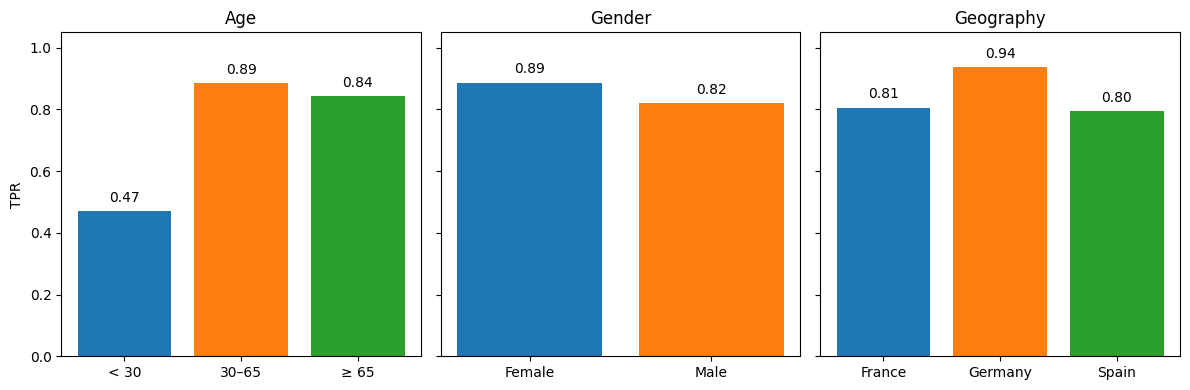

In [633]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# --- nice label maps ---
age_label_map = {
    "Age_<30": "< 30",
    "Age_30-65": "30–65",
    "Age_>=65": "≥ 65"
}
gender_label_map = {
    "Gender_Female": "Female",
    "Gender_Male": "Male"
}
geo_label_map = {
    "Geography_France": "France",
    "Geography_Germany": "Germany",
    "Geography_Spain": "Spain"
}

# ---------- Age ----------
age_keys = list(banking_xgb_tpr['age_means'].keys())
age_vals = list(banking_xgb_tpr['age_means'].values())
x_age = np.arange(len(age_keys))

axes[0].bar(x_age, age_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Age")
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("TPR")
axes[0].set_xticks(x_age)
axes[0].set_xticklabels([age_label_map[k] for k in age_keys])
for i, v in enumerate(age_vals):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# ---------- Gender ----------
gender_keys = list(banking_xgb_tpr['gender_means'].keys())
gender_vals = list(banking_xgb_tpr['gender_means'].values())
x_gender = np.arange(len(gender_keys))

axes[1].bar(x_gender, gender_vals, color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Gender")
axes[1].set_ylim(0, 1.05)
axes[1].set_xticks(x_gender)
axes[1].set_xticklabels([gender_label_map[k] for k in gender_keys])
for i, v in enumerate(gender_vals):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# ---------- Geography ----------
geo_keys = list(banking_xgb_tpr['geography_means'].keys())
geo_vals = list(banking_xgb_tpr['geography_means'].values())
x_geo = np.arange(len(geo_keys))

axes[2].bar(x_geo, geo_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[2].set_title("Geography")
axes[2].set_ylim(0, 1.05)
axes[2].set_xticks(x_geo)
axes[2].set_xticklabels([geo_label_map[k] for k in geo_keys])
for i, v in enumerate(geo_vals):
    axes[2].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("TPRs_banking_xgb")
plt.show()

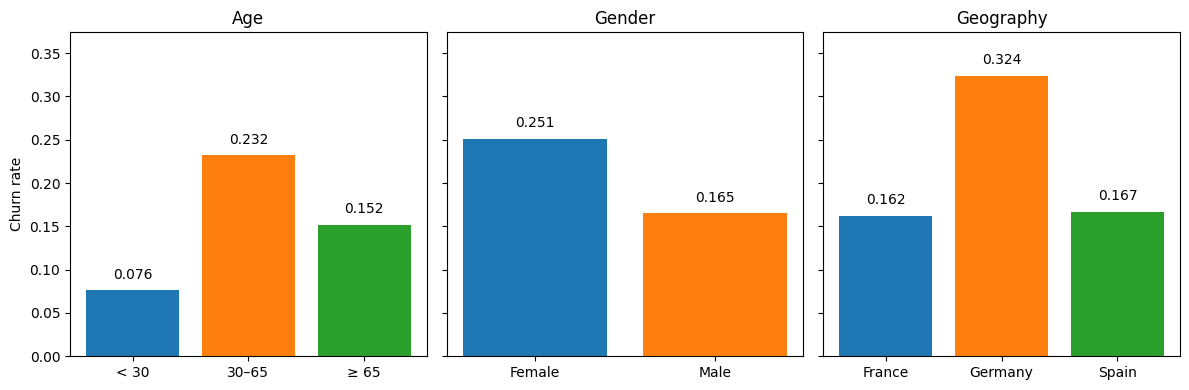

In [634]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Assemble churn-rate dicts from your variables ----
age_cr = {
    "Age_<30": banking_30_cr,
    "Age_30-65": banking_30_65_cr,
    "Age_>=65": banking_65_cr
}

gender_cr = {
    "Gender_Female": banking_female_cr,
    "Gender_Male": banking_male_cr
}

geo_cr = {
    "Geography_France": france_cr,
    "Geography_Germany": germany_cr,
    "Geography_Spain": spain_cr
}

# Global y-limit so all subplots share the same scale
global_max = max(
    max(age_cr.values()),
    max(gender_cr.values()),
    max(geo_cr.values())
)
y_top = min(1.05, global_max + 0.05)  # keep headroom, cap at 1.05

# ---- Plot (same style as your TPR figure) ----
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# ---------- Age ----------
age_keys = list(age_cr.keys())
age_vals = list(age_cr.values())
x_age = np.arange(len(age_keys))

axes[0].bar(x_age, age_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Age")
axes[0].set_ylim(0, y_top)
axes[0].set_ylabel("Churn rate")
axes[0].set_xticks(x_age)
axes[0].set_xticklabels([age_label_map[k] for k in age_keys])
for i, v in enumerate(age_vals):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

# ---------- Gender ----------
gender_keys = list(gender_cr.keys())
gender_vals = list(gender_cr.values())
x_gender = np.arange(len(gender_keys))

axes[1].bar(x_gender, gender_vals, color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Gender")
axes[1].set_ylim(0, y_top)
axes[1].set_xticks(x_gender)
axes[1].set_xticklabels([gender_label_map[k] for k in gender_keys])
for i, v in enumerate(gender_vals):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

# ---------- Geography ----------
geo_keys = list(geo_cr.keys())
geo_vals = list(geo_cr.values())
x_geo = np.arange(len(geo_keys))

axes[2].bar(x_geo, geo_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[2].set_title("Geography")
axes[2].set_ylim(0, y_top)
axes[2].set_xticks(x_geo)
axes[2].set_xticklabels([geo_label_map[k] for k in geo_keys])
for i, v in enumerate(geo_vals):
    axes[2].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("ChurnRates_banking.png", bbox_inches="tight")
plt.show()

## Telecommunication

In [89]:
# Retrieve the samples (X) and the target (y)
telecom_X = df_telecom.drop(columns="Churn")
telecom_y = df_telecom["Churn"]

In [90]:
# Create one hot columns for the age groups
telecom_age_ohe = pd.get_dummies(pd.cut(telecom_X["Age"], bins=age_bins, labels=age_labels), dtype=int)

# Join one hot encoded age columns to X 
telecom_X_with_age_ohe = telecom_X.join(telecom_age_ohe)

telecom_gender_cols = ["gender_Female", "gender_Male"]

### Logistic Regression

In [91]:
telecom_lr_results = run_nested_cv_with_diagnostics(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X=telecom_X,
    y=telecom_y,
)
telecom_lr_train_df = telecom_lr_results["train_df"]
telecom_lr_test_df = telecom_lr_results["test_df"]
telecom_lr_pred = telecom_lr_results["oof_pred"]
telecom_lr_proba = telecom_lr_results["oof_proba"]
telecom_lr_eod = telecom_lr_results["eod_summary"]
telecom_lr_tpr = telecom_lr_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8415  0.9171     0.4343  0.5894  0.7502
2     0.8443  0.9211     0.4295  0.5858  0.7495
3     0.8449  0.9118     0.4281  0.5827  0.7437
4     0.8415  0.8977     0.4406  0.5911  0.7434
5     0.8438  0.8816     0.4642  0.6082  0.7473

Mean (±std) TRAIN:
AUC          0.8432 ± 0.0016
Recall       0.9058 ± 0.0162
Precision    0.4393 ± 0.0147
F1           0.5914 ± 0.0099
F2           0.7468 ± 0.0032
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8463  0.9091     0.4337  0.5872  0.7456
2     0.8430  0.9225     0.4367  0.5928  0.7546
3     0.8407  0.9249     0.4223  0.5798  0.7471
4     0.8357  0.9037     0.4447  0.5961  0.7491
5     0.8389  0.8476     0.4509  0.5887  0.7208

Mean (±std) TEST:
AUC   

#### Confusion Matrix

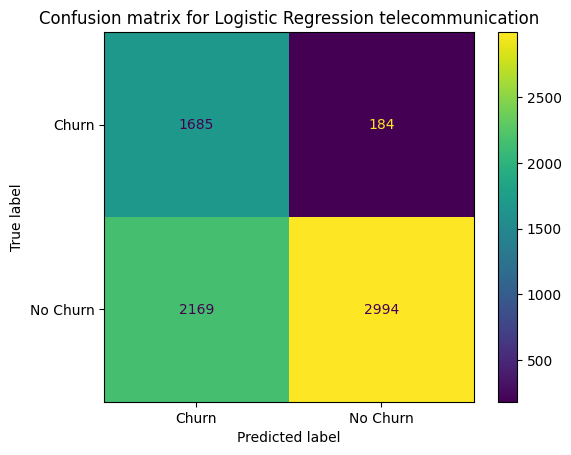

In [510]:
# Swap the labels so "1" (Exited / Churn) is shown first
telecom_lr_cm = confusion_matrix(telecom_y, telecom_lr_pred, labels=[1, 0])

# Plot
telecom_cm_lr_display = ConfusionMatrixDisplay(confusion_matrix=telecom_lr_cm,display_labels=["Churn", "No Churn"])
telecom_cm_lr_display.plot()
plt.title("Confusion matrix for Logistic Regression telecommunication")
plt.savefig("telecom_lr_cm")
plt.show()

### Random Forest

In [93]:
telecom_rf_results = run_nested_cv_with_diagnostics(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X=telecom_X,
    y=telecom_y,
)
telecom_rf_train_df = telecom_rf_results["train_df"]
telecom_rf_test_df = telecom_rf_results["test_df"]
telecom_rf_pred = telecom_rf_results["oof_pred"]
telecom_rf_proba = telecom_rf_results["oof_proba"]
telecom_rf_eod = telecom_rf_results["eod_summary"]
telecom_rf_tpr = telecom_rf_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8617  0.9545     0.4219  0.5852  0.7621
2     0.8576  0.9378     0.4320  0.5916  0.7599
3     0.8570  0.9225     0.4419  0.5975  0.7577
4     0.8605  0.9338     0.4423  0.6003  0.7640
5     0.8587  0.9231     0.4495  0.6046  0.7624

Mean (±std) TRAIN:
AUC           0.8591 ± 0.002
Recall       0.9343 ± 0.0131
Precision    0.4375 ± 0.0107
F1           0.5958 ± 0.0076
F2           0.7612 ± 0.0025
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8423  0.9251     0.4061  0.5644  0.7368
2     0.8424  0.9332     0.4190  0.5783  0.7492
3     0.8337  0.9115     0.4192  0.5743  0.7382
4     0.8359  0.9091     0.4353  0.5887  0.7466
5     0.8316  0.8850     0.4265  0.5757  0.7284

Mean (±std) TEST:
AUC   

#### Confusion Matrix

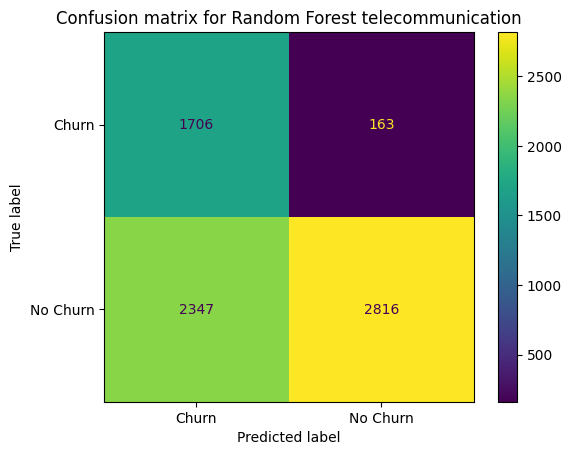

In [511]:
# Swap the labels so "1" (Exited / Churn) is shown first
telecom_rf_cm = confusion_matrix(telecom_y, telecom_rf_pred, labels=[1, 0])

# Plot
telecom_cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=telecom_rf_cm,display_labels=["Churn", "No Churn"])
telecom_cm_rf_display.plot()
plt.title("Confusion matrix for Random Forest telecommunication")
plt.savefig("telecom_rf_cm")
plt.show()

### XGBoost

In [95]:
telecom_xgb_results = run_nested_cv_with_diagnostics(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X=telecom_X,
    y=telecom_y,
)
telecom_xgb_train_df = telecom_xgb_results["train_df"]
telecom_xgb_test_df   = telecom_xgb_results["test_df"]
telecom_xgb_pred     = telecom_xgb_results["oof_pred"]
telecom_xgb_proba     = telecom_xgb_results["oof_proba"]
telecom_xgb_eod = telecom_xgb_results["eod_summary"]
telecom_xgb_tpr = telecom_xgb_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8529  0.9344     0.4320  0.5908  0.7581
2     0.8525  0.9351     0.4288  0.5880  0.7565
3     0.8545  0.9271     0.4413  0.5980  0.7598
4     0.8555  0.9211     0.4528  0.6071  0.7632
5     0.8530  0.9204     0.4432  0.5983  0.7573

Mean (±std) TRAIN:
AUC          0.8537 ± 0.0013
Recall        0.9276 ± 0.007
Precision    0.4396 ± 0.0095
F1           0.5964 ± 0.0075
F2            0.759 ± 0.0027
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8473  0.9091     0.4245  0.5787  0.7401
2     0.8459  0.9251     0.4230  0.5805  0.7476
3     0.8412  0.9223     0.4316  0.5880  0.7514
4     0.8341  0.8930     0.4471  0.5959  0.7445
5     0.8342  0.8904     0.4258  0.5761  0.7309

Mean (±std) TEST:
AUC   

#### Confusion matrix

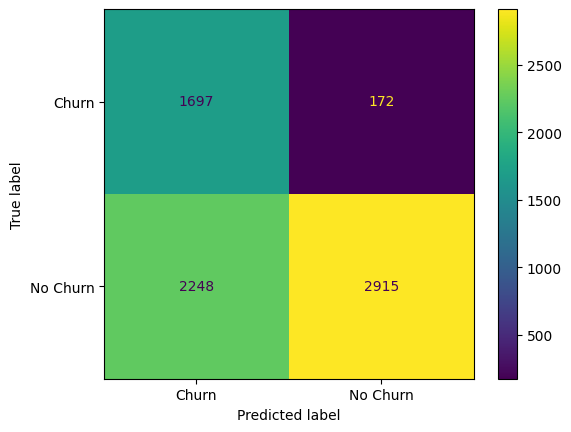

In [650]:
# Swap the labels so "1" (Exited / Churn) is shown first
telecom_xgb_cm = confusion_matrix(telecom_y, telecom_xgb_pred, labels=[1, 0])

# Plot
telecom_cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix=telecom_xgb_cm,display_labels=["Churn", "No Churn"])
telecom_cm_xgb_display.plot()
plt.savefig("telecom_xgb_cm")
plt.show()

### Multi Layer Perceptron

In [97]:
telecom_mlp_results = run_nested_cv_with_diagnostics(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X=telecom_X,
    y=telecom_y,
)
telecom_mlp_train_df = telecom_mlp_results["train_df"]
telecom_mlp_test_df = telecom_mlp_results["test_df"]
telecom_mlp_pred = telecom_mlp_results["oof_pred"]
telecom_mlp_proba = telecom_mlp_results["oof_proba"]
telecom_mlp_eod = telecom_mlp_results["eod_summary"]
telecom_mlp_tpr = telecom_mlp_results["tpr_summary"]


=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8447  0.8936     0.4634  0.6103  0.7537
2     0.8545  0.9425     0.4287  0.5893  0.7602
3     0.8633  0.9178     0.4807  0.6310  0.7766
4     0.8424  0.8890     0.4451  0.5932  0.7411
5     0.8428  0.8742     0.4681  0.6098  0.7450

Mean (±std) TRAIN:
AUC          0.8495 ± 0.0091
Recall       0.9034 ± 0.0269
Precision    0.4572 ± 0.0205
F1           0.6067 ± 0.0166
F2            0.7553 ± 0.014
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8438  0.8610     0.4607  0.6002  0.7335
2     0.8393  0.9332     0.4190  0.5783  0.7492
3     0.8172  0.8740     0.4447  0.5895  0.7326
4     0.8374  0.9037     0.4525  0.6030  0.7535
5     0.8377  0.8396     0.4538  0.5891  0.7176

Mean (±std) TEST:
AUC   

#### Confusion Matrix

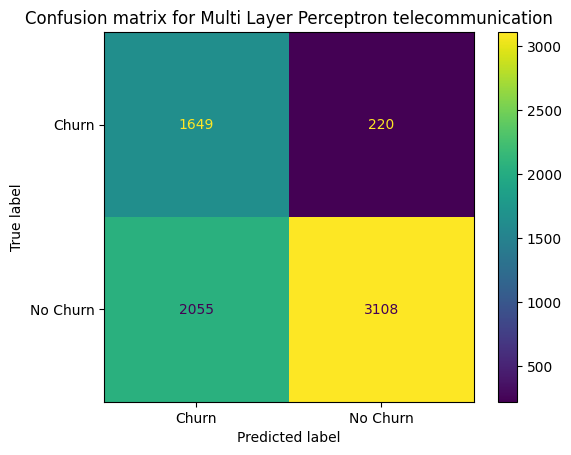

In [512]:
# Swap the labels so "1" (Exited / Churn) is shown first
telecom_mlp_cm = confusion_matrix(telecom_y, telecom_mlp_pred, labels=[1, 0])

# Plot
telecom_cm_mlp_display = ConfusionMatrixDisplay(confusion_matrix=telecom_mlp_cm,display_labels=["Churn", "No Churn"])
telecom_cm_mlp_display.plot()
plt.title("Confusion matrix for Multi Layer Perceptron telecommunication")
plt.savefig("telecom_mlp_cm.png")
plt.show()

### ROC Curves

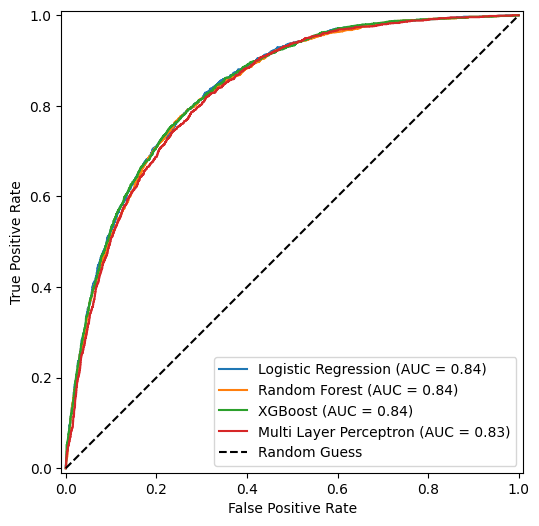

In [641]:
fig, ax = plt.subplots(figsize=(8, 6))

RocCurveDisplay.from_predictions(telecom_y, telecom_lr_proba, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(telecom_y, telecom_rf_proba, name="Random Forest", ax=ax)
RocCurveDisplay.from_predictions(telecom_y, telecom_xgb_proba, name="XGBoost", ax=ax)
RocCurveDisplay.from_predictions(telecom_y, telecom_mlp_proba, name="Multi Layer Perceptron", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("ROC curves telecom")
plt.show()

### Results

#### Performance

In [100]:
# Create columns by using dictionary
telecom_performance = {
    "Logistic Regression test": (telecom_lr_test_df.mean().round(3)),
    "Random Forest test": (telecom_rf_test_df.mean().round(3)),
    "XGBoost test": (telecom_xgb_test_df.mean().round(3)),
    "Multi Layer Perceptron test": (telecom_mlp_test_df.mean().round(3))
}

# Create rows
performance_metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

# Create DataFrame
df_telecom_performance = pd.DataFrame(telecom_performance, index=performance_metrics)

# Display nicely
df_telecom_performance

,Logistic Regression test,Random Forest test,XGBoost test,Multi Layer Perceptron test
AUC,0.841,0.837,0.841,0.835
Recall,0.902,0.913,0.908,0.882
Precision,0.438,0.421,0.430,0.446
F1,0.589,0.576,0.584,0.592
F2,0.743,0.740,0.743,0.737


#### Trade-off (distance)

In [101]:
optimal_auc = 1
optimal_f2 = 1

telecom_distance_dict = {}

for x in range(4):
    auc = df_telecom_performance.iloc[0,x]
    f2 = df_telecom_performance.iloc[4,x]
    model = df_telecom_performance.columns[x]
    distance = round(sqrt((optimal_auc - auc)**2 + (optimal_f2 - f2)**2),3)
    telecom_distance_dict[model] = distance

telecom_distance_dict

{'Logistic Regression test': 0.302,
 'Random Forest test': 0.307,
 'XGBoost test': 0.302,
 'Multi Layer Perceptron test': 0.31}

In [102]:
# Create columns by using dictionary
telecom_performance_std = {
    "Logistic Regression test": (telecom_lr_test_df.mean().round(3)).astype(str) + " ± " +
                                telecom_lr_test_df.std().round(3).astype(str),
    "Random Forest test": (telecom_rf_test_df.mean().round(3)).astype(str) + " ± " +
                          telecom_rf_test_df.std().round(3).astype(str),
    "XGBoost test": (telecom_xgb_test_df.mean().round(3)).astype(str) + " ± " +
                    telecom_xgb_test_df.std().round(3).astype(str),
    "Multi Layer Perceptron test": (telecom_mlp_test_df.mean().round(3)).astype(str) + " ± " +
                                   telecom_mlp_test_df.std().round(3).astype(str),
}

# Create rows
performance_metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

# Create DataFrame
df_telecom_performance_std = pd.DataFrame(telecom_performance_std, index=performance_metrics)

# Display nicely
df_telecom_performance_std

,Logistic Regression test,Random Forest test,XGBoost test,Multi Layer Perceptron test
AUC,0.841 ± 0.004,0.837 ± 0.005,0.841 ± 0.006,0.835 ± 0.01
Recall,0.902 ± 0.031,0.913 ± 0.018,0.908 ± 0.016,0.882 ± 0.037
Precision,0.438 ± 0.011,0.421 ± 0.011,0.43 ± 0.01,0.446 ± 0.016
F1,0.589 ± 0.006,0.576 ± 0.009,0.584 ± 0.008,0.592 ± 0.01
F2,0.743 ± 0.013,0.74 ± 0.008,0.743 ± 0.008,0.737 ± 0.014


#### Checking under- overfitting

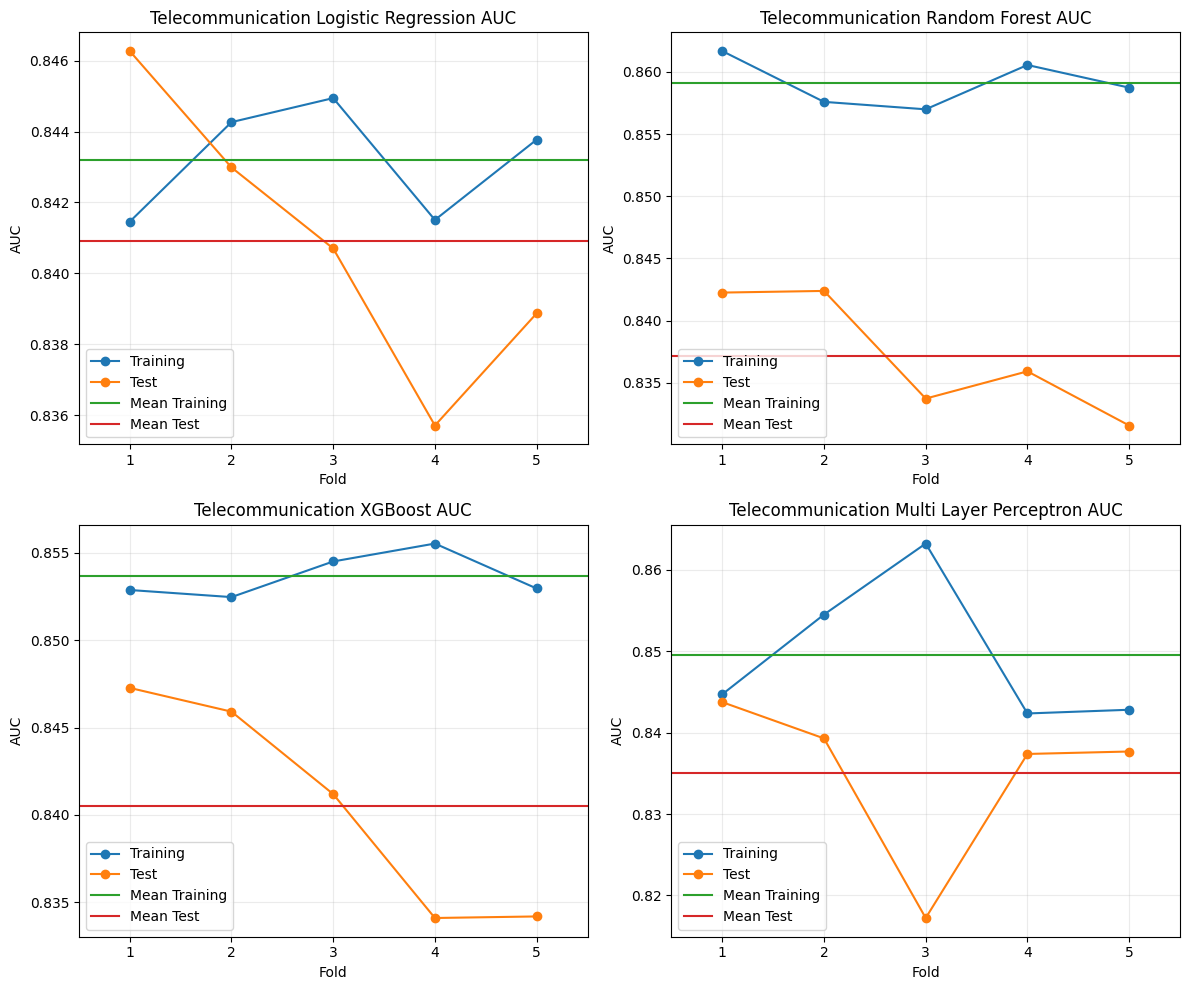

In [515]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), 
                         sharex=False, sharey=False)

plot_fold_curves(axes[0,0], telecom_lr_train_df,  telecom_lr_test_df, 3, "Telecommunication Logistic Regression AUC")
plot_fold_curves(axes[0,1], telecom_rf_train_df,  telecom_rf_test_df, 3, "Telecommunication Random Forest AUC")
plot_fold_curves(axes[1,0], telecom_xgb_train_df, telecom_xgb_test_df, 3, "Telecommunication XGBoost AUC")
plot_fold_curves(axes[1,1], telecom_mlp_train_df, telecom_mlp_test_df, 3, "Telecommunication Multi Layer Perceptron AUC")

plt.tight_layout()
plt.savefig("Overfitting telecommunication")

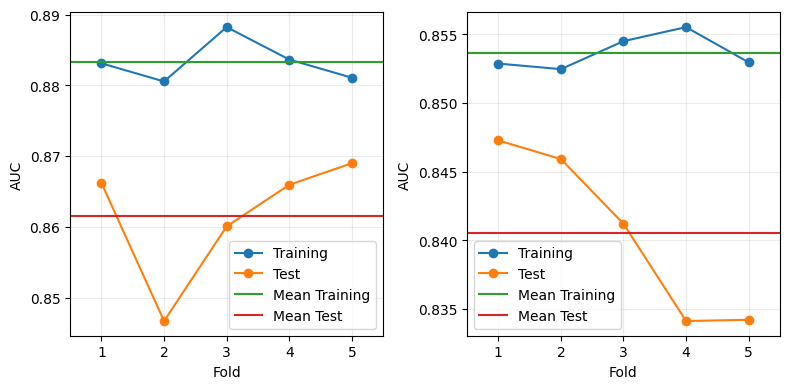

In [649]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), 
                         sharex=False, sharey=False)

plot_fold_curves(axes[0], banking_xgb_train_df, banking_xgb_test_df, "lower right", "")
plot_fold_curves(axes[1], telecom_xgb_train_df, telecom_xgb_test_df, "lower left", "")

plt.tight_layout()
plt.savefig("Overfitting XGBoost")

#### Fairness

In [104]:
# ---- Create formatted fairness summary table (telecom) ----
telecom_fairness_EOD = {
    "Logistic Regression": [
        f"{round(telecom_lr_eod['age_mean'],3)} ± {round(telecom_lr_eod['age_std'],3)}",
        f"{round(telecom_lr_eod['gender_mean'],3)} ± {round(telecom_lr_eod['gender_std'],3)}",
    ],
    "Random Forest": [
        f"{round(telecom_rf_eod['age_mean'],3)} ± {round(telecom_rf_eod['age_std'],3)}",
        f"{round(telecom_rf_eod['gender_mean'],3)} ± {round(telecom_rf_eod['gender_std'],3)}",
    ],
    "XGBoost": [
        f"{round(telecom_xgb_eod['age_mean'],3)} ± {round(telecom_xgb_eod['age_std'],3)}",
        f"{round(telecom_xgb_eod['gender_mean'],3)} ± {round(telecom_xgb_eod['gender_std'],3)}",
    ],
    "Multi Layer Perceptron": [
        f"{round(telecom_mlp_eod['age_mean'],3)} ± {round(telecom_mlp_eod['age_std'],3)}",
        f"{round(telecom_mlp_eod['gender_mean'],3)} ± {round(telecom_mlp_eod['gender_std'],3)}",
    ],
}

df_telecom_fairness = pd.DataFrame(
    telecom_fairness_EOD,
    index=["Age EOD", "Gender EOD"]
)

# ---- Numeric raw means (same column order as above) ----
raw_telecom = {
    "Logistic Regression": [telecom_lr_eod["age_mean"], telecom_lr_eod["gender_mean"]],
    "Random Forest": [telecom_rf_eod["age_mean"], telecom_rf_eod["gender_mean"]],
    "XGBoost": [telecom_xgb_eod["age_mean"], telecom_xgb_eod["gender_mean"]],
    "Multi Layer Perceptron": [telecom_mlp_eod["age_mean"], telecom_mlp_eod["gender_mean"]],
}
df_telecom_raw = pd.DataFrame(raw_telecom, index=["Age EOD", "Gender EOD"])

# ---- Append mean absolute EOD (as strings to match table formatting) ----
df_telecom_fairness.loc["Mean Absolute EOD"] = df_telecom_raw.abs().mean().round(3)

df_telecom_fairness

,Logistic Regression,Random Forest,XGBoost,Multi Layer Perceptron
Age EOD,0.105 ± 0.024,0.093 ± 0.017,0.097 ± 0.045,0.107 ± 0.03
Gender EOD,0.029 ± 0.016,0.03 ± 0.016,0.035 ± 0.012,0.024 ± 0.014
Mean Absolute EOD,0.067,0.062,0.066,0.066


##### TPRs

In [105]:
import numpy as np
import pandas as pd

# ---- Expected inputs ----
# Each *_tpr is the .get("tpr_summary") from your nested-CV run, e.g.:
# telecom_lr_tpr = lr_results["tpr_summary"]
# and contains keys: age_means/age_stds, gender_means/gender_stds

# ---- Indices to show (match your one-hot names) ----
age_idx    = ["Age_<30", "Age_30-65", "Age_>=65"]
gender_idx = ["gender_Female", "gender_Male"]

# ---- Age TPRs (mean ± std) ----
telecom_age_tprs_df = pd.DataFrame({
    "Logistic Regression":  _fmt_mean_std(telecom_lr_tpr["age_means"],          telecom_lr_tpr["age_stds"],          age_idx),
    "Random Forest":        _fmt_mean_std(telecom_rf_tpr["age_means"],          telecom_rf_tpr["age_stds"],          age_idx),
    "XGBoost":              _fmt_mean_std(telecom_xgb_tpr["age_means"],         telecom_xgb_tpr["age_stds"],         age_idx),
    "Multi Layer Perceptron": _fmt_mean_std(telecom_mlp_tpr["age_means"],       telecom_mlp_tpr["age_stds"],         age_idx),
}).reindex(age_idx)

# ---- Gender TPRs (mean ± std) ----
telecom_gender_tprs_df = pd.DataFrame({
    "Logistic Regression":  _fmt_mean_std(telecom_lr_tpr["gender_means"],       telecom_lr_tpr["gender_stds"],       gender_idx),
    "Random Forest":        _fmt_mean_std(telecom_rf_tpr["gender_means"],       telecom_rf_tpr["gender_stds"],       gender_idx),
    "XGBoost":              _fmt_mean_std(telecom_xgb_tpr["gender_means"],      telecom_xgb_tpr["gender_stds"],      gender_idx),
    "Multi Layer Perceptron": _fmt_mean_std(telecom_mlp_tpr["gender_means"],    telecom_mlp_tpr["gender_stds"],      gender_idx),
}).reindex(gender_idx).rename(index={"gender_Female": "Female", "gender_Male": "Male"})

# ---- Combine all TPR tables ----
telecom_tprs_df = pd.concat([telecom_age_tprs_df, telecom_gender_tprs_df])

telecom_tprs_df

,Logistic Regression,Random Forest,XGBoost,Multi Layer Perceptron
Age_<30,0.855 ± 0.04,0.869 ± 0.03,0.862 ± 0.04,0.844 ± 0.044
Age_30-65,0.892 ± 0.029,0.908 ± 0.022,0.904 ± 0.022,0.868 ± 0.037
Age_>=65,0.96 ± 0.025,0.958 ± 0.014,0.953 ± 0.022,0.948 ± 0.023
Female,0.91 ± 0.043,0.915 ± 0.032,0.913 ± 0.029,0.888 ± 0.042
Male,0.894 ± 0.015,0.911 ± 0.009,0.903 ± 0.015,0.877 ± 0.026


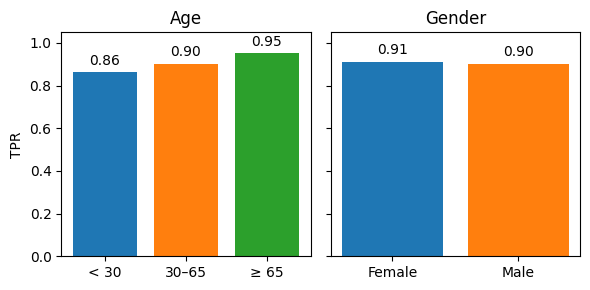

In [640]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

gender_label_map = {
    "gender_Female": "Female",
    "gender_Male": "Male"
}

# ----- Age subplot -----
age_keys = list(telecom_xgb_tpr['age_means'].keys())
age_vals = list(telecom_xgb_tpr['age_means'].values())
x_age = np.arange(len(age_keys))

axes[0].bar(x_age, age_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Age")
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel("TPR")
axes[0].set_xticks(x_age)
axes[0].set_xticklabels([age_label_map[k] for k in age_keys])
for i, v in enumerate(age_vals):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# ----- Gender subplot -----
gender_keys = list(telecom_xgb_tpr['gender_means'].keys())
gender_vals = list(telecom_xgb_tpr['gender_means'].values())
x_gender = np.arange(len(gender_keys))

axes[1].bar(x_gender, gender_vals, color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Gender")
axes[1].set_ylim(0, 1.05)
axes[1].set_xticks(x_gender)
axes[1].set_xticklabels([gender_label_map[k] for k in gender_keys])
for i, v in enumerate(gender_vals):
    axes[1].text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("TPRs_telecom_xgb")
plt.show()

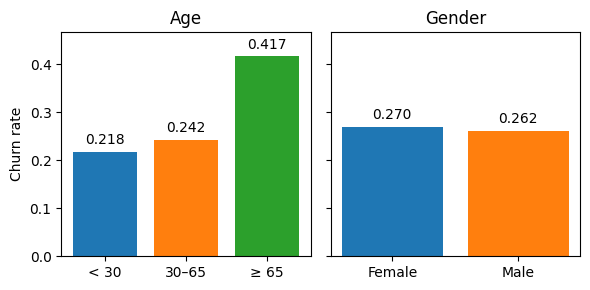

In [639]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Assemble churn-rate dicts for plotting ----
age_cr_tel = {
    "Age_<30": telecom_30_cr,
    "Age_30-65": telecom_30_65_cr,
    "Age_>=65": telecom_65_cr
}

gender_cr_tel = {
    "gender_Female": telecom_female_cr,
    "gender_Male": telecom_male_cr
}

# Shared y-limit (nice headroom)
y_top = min(1.05, max(max(age_cr_tel.values()), max(gender_cr_tel.values())) + 0.05)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

# ----- Age subplot -----
age_keys = list(age_cr_tel.keys())
age_vals = list(age_cr_tel.values())
x_age = np.arange(len(age_keys))

axes[0].bar(x_age, age_vals, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
axes[0].set_title("Age")
axes[0].set_ylim(0, y_top)
axes[0].set_ylabel("Churn rate")
axes[0].set_xticks(x_age)
axes[0].set_xticklabels([age_label_map[k] for k in age_keys])
for i, v in enumerate(age_vals):
    axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

# ----- Gender subplot -----
gender_keys = list(gender_cr_tel.keys())
gender_vals = list(gender_cr_tel.values())
x_gender = np.arange(len(gender_keys))

axes[1].bar(x_gender, gender_vals, color=["#1f77b4", "#ff7f0e"])
axes[1].set_title("Gender")
axes[1].set_ylim(0, y_top)
axes[1].set_xticks(x_gender)
axes[1].set_xticklabels([gender_label_map[k] for k in gender_keys])
for i, v in enumerate(gender_vals):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("ChurnRates_telecom.png", dpi=300, bbox_inches="tight")
plt.show()

## Final results

In [106]:
# Preparing all models distances
lr_distance = (
    banking_distance_dict["Logistic Regression test"], 
    telecom_distance_dict["Logistic Regression test"]
)

rf_distance = (
    banking_distance_dict["Random Forest test"], 
    telecom_distance_dict["Random Forest test"]
) 

xgb_distance = (
    banking_distance_dict["XGBoost test"], 
    telecom_distance_dict["XGBoost test"]
) 

mlp_distance = (
    banking_distance_dict["Multi Layer Perceptron test"], 
    telecom_distance_dict["Multi Layer Perceptron test"]
) 

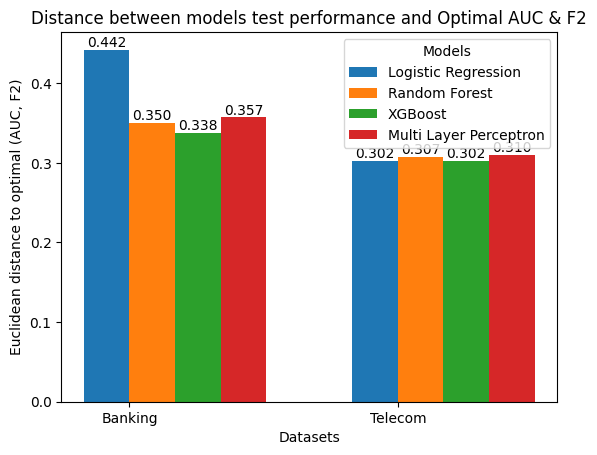

In [107]:
# The data
category_distance = ["Logistic Regression", "Random Forest", "XGBoost", "Multi Layer Perceptron"]
index_distance = numpy.arange(len(datasets))

bar_width = 0.17

# Plotting the bars
bars_lr = plt.bar(index_distance + bar_width, lr_distance, bar_width, label=category_distance[0])
bars_rf = plt.bar(index_distance + bar_width * 2, rf_distance, bar_width, label=category_distance[1])
bars_xgb = plt.bar(index_distance + bar_width * 3, xgb_distance, bar_width, label=category_distance[2])
bars_mlp = plt.bar(index_distance + bar_width * 4, mlp_distance, bar_width, label=category_distance[3])
plt.bar_label(bars_lr, fmt="%.3f")
plt.bar_label(bars_rf, fmt="%.3f")
plt.bar_label(bars_xgb, fmt="%.3f")
plt.bar_label(bars_mlp, fmt="%.3f")

# Designing the barplot
plt.xlabel("Datasets")
plt.ylabel("Euclidean distance to optimal (AUC, F2)")
plt.title("Distance between models test performance and Optimal AUC & F2")
plt.legend(title="Models",loc = 1)
plt.xticks(index_distance + bar_width * (len(category_distance)-1) /2, datasets)
plt.savefig("distance.png")

# Fairness mitigation

## Baseline

In [108]:
def run_nested_cv_with_diagnostics_baseline(
    pipe,
    param_grid,
    X,
    y,
    scorer="roc_auc",
    inner_splits=5,
    outer_splits=5,
    random_state=42,
    sensitive_drop=None,   # <--- NEW: columns to drop from the MODEL view only
):
    """
    Nested CV (Baseline):
      - Inner: GridSearchCV by `scorer`
      - Outer: evaluate on TEST folds (threshold=0.5)
      - Fairness: EOD (max TPR - min TPR) mean±std across folds,
                  and TPR per group (mean±std) for Age, Gender, Geography.

    Assumes:
      - X['Age'] is numeric
      - Gender is one-hot: 'Gender_*' or 'gender_*'
      - Geography is one-hot: 'Geography_*'/'geography_*' or 'Location_*'/'location_*'

    Note:
      - Any columns listed in `sensitive_drop` are removed from the model inputs
        (both train and test) but NOT from the fairness computation, which uses
        the original X. Pass e.g. ["Age"] or ["Age","Gender_Female","Gender_Male",...].
    """
    import time, numpy as np, pandas as pd
    from collections import defaultdict
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
    from sklearn.base import clone

    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)
    oof_pred  = np.zeros(n, dtype=int)

    fold_train_metrics, fold_test_metrics = [], []
    fold_thresholds = []  # <--- NEW: track chosen threshold per outer fold

    # Fairness aggregates across outer folds
    age_tpr_agg     = defaultdict(list)
    gender_tpr_agg  = defaultdict(list)
    geo_tpr_agg     = defaultdict(list)
    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []

    # detect sensitive columns on full X (for fairness)
    gender_cols_all = find_gender_cols(X.columns)
    geo_cols_all    = find_geo_cols(X.columns)

    # Build model vs fairness views
    drop_cols = list(sensitive_drop) if sensitive_drop is not None else []
    X_model = X.drop(columns=drop_cols, errors="ignore")  # what the model sees
    X_fair  = X                                          # what fairness uses

    # --- Report exactly what is dropped ---
    if drop_cols:
        missing = [c for c in drop_cols if c not in X.columns]
        kept = [c for c in drop_cols if c in X.columns]
        print(f"[Baseline] Model will be trained WITHOUT the following sensitive columns ({len(kept)} found):")
        for c in kept:
            print(f"  - {c}")
        if missing:
            print(f"[Warning] {len(missing)} columns listed in `sensitive_drop` not found in X: {missing}")
    else:
        print("[Baseline] No sensitive columns were dropped — model sees all features.")

    # ---- Cross-validation ----
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_model, y), start=1):
        X_tr_m, X_te_m = X_model.iloc[train_idx].copy(), X_model.iloc[test_idx].copy()
        y_tr,   y_te   = y.iloc[train_idx].values,      y.iloc[test_idx].values
        X_te_f = X_fair.iloc[test_idx].copy()  # fairness uses original features

        # Tune on outer-train
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=scorer,
            refit=True,
            n_jobs=-1
        )
        grid.fit(X_tr_m, y_tr)
        best_model = grid.best_estimator_

        # ===== NEW: pooled inner-validation threshold tuning (F2) =====
        thresh_grid = np.linspace(0.0, 1.0, 101)
        pooled_val_proba, pooled_val_true = [], []
        for in_tr_idx, in_va_idx in inner_cv.split(X_tr_m, y_tr):
            X_in_tr, X_in_va = X_tr_m.iloc[in_tr_idx], X_tr_m.iloc[in_va_idx]
            y_in_tr, y_in_va = y_tr[in_tr_idx],        y_tr[in_va_idx]
            m = clone(best_model)  # fit best params on each inner-train
            m.fit(X_in_tr, y_in_tr)
            pooled_val_proba.append(m.predict_proba(X_in_va)[:, 1])
            pooled_val_true.append(y_in_va)

        # Always derive threshold from pooled inner-val predictions 
        inner_val_proba = np.concatenate(pooled_val_proba, axis=0)
        inner_val_true  = np.concatenate(pooled_val_true,  axis=0)
        f2_vals = [fbeta_score(inner_val_true, (inner_val_proba >= t).astype(int),
                               beta=2, zero_division=0) for t in thresh_grid]
        chosen_threshold = float(thresh_grid[int(np.argmax(f2_vals))])
        fold_thresholds.append(chosen_threshold)  # <--- NEW

        # Predict with tuned threshold
        train_proba = best_model.predict_proba(X_tr_m)[:, 1]
        test_proba  = best_model.predict_proba(X_te_m)[:, 1]
        train_pred  = (train_proba >= chosen_threshold).astype(int)
        test_pred   = (test_proba  >= chosen_threshold).astype(int)

        # Standard metrics
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba),
            "Recall": recall_score(y_tr, train_pred, zero_division=0),
            "Precision": precision_score(y_tr, train_pred, zero_division=0),
            "F1": f1_score(y_tr, train_pred, zero_division=0),
            "F2": fbeta_score(y_tr, train_pred, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba),
            "Recall": recall_score(y_te, test_pred, zero_division=0),
            "Precision": precision_score(y_te, test_pred, zero_division=0),
            "F1": f1_score(y_te, test_pred, zero_division=0),
            "F2": fbeta_score(y_te, test_pred, beta=2, zero_division=0),
        })

        # --- Fairness on TEST (original X) ---
        if "Age" in X_te_f.columns and np.issubdtype(X_te_f["Age"].dtype, np.number):
            X_te_age, age_cols = age_bucketize(X_te_f)
            age_tprs, eod_age = group_tprs_onehot(X_te_age, y_te, test_pred, age_cols)
            for g, v in age_tprs.items():
                age_tpr_agg[g].append(v)
            eod_age_folds.append(eod_age)
        else:
            eod_age_folds.append(np.nan)

        gcols = [c for c in gender_cols_all if c in X_te_f.columns]
        gen_tprs, eod_gen = group_tprs_onehot(X_te_f, y_te, test_pred, gcols)
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        lcols = [c for c in geo_cols_all if c in X_te_f.columns]
        geo_tprs, eod_geo = group_tprs_onehot(X_te_f, y_te, test_pred, lcols)
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

        # OOF
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx]  = test_pred

    # ---- Aggregate results ----
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0)
    }

    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics ).set_index("Fold").sort_index()

    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    age_tpr_means,    age_tpr_stds    = agg_means_stds(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = agg_means_stds(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = agg_means_stds(geo_tpr_agg)

    # ---- Prints ----
    print("\n=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " + train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics (outer folds; threshold=0.5) ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " + test_df.std().round(4).astype(str))

    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    _pretty_tprs("Age",       age_tpr_means,    age_tpr_stds)
    _pretty_tprs("Gender",    gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means,    geo_tpr_stds)

    print("\n=== OOF metrics (pooled) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    # NEW: also show chosen thresholds per outer fold
    print(f"\nThresholds chosen per outer fold: {np.array(fold_thresholds)}")

    print(f"Total runtime: {time.time() - start:.2f} s")

    # ---- Return ----
    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,
        "oof_pred": oof_pred,
        "oof_results": oof_results,
        "fold_eod": {
            "age": eod_age_folds, "gender": eod_gender_folds, "geography": eod_geo_folds
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        },
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "dropped_from_model": [c for c in drop_cols if c in X.columns],
        "fold_thresholds": np.array(fold_thresholds),  # <--- NEW: return thresholds
    }

### Banking

#### Logistic Regression

##### Age

In [109]:
banking_lr_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X=banking_X,       
    y=banking_y,
    sensitive_drop=["Age"]
)

# Access pieces if needed:
banking_lr_train_baseline_age_df = banking_lr_results_baseline_age["train_df"]
banking_lr_test_baseline_age_df   = banking_lr_results_baseline_age["test_df"]
banking_lr_baseline_age_pred = banking_lr_results_baseline_age["oof_pred"]
banking_lr_baseline_age_eod = banking_lr_results_baseline_age["eod_summary"]
banking_lr_baseline_age_tpr = banking_lr_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6772  0.8754     0.2493  0.3881  0.5827
2     0.6806  0.8435     0.2476  0.3828  0.5694
3     0.6871  0.8822     0.2517  0.3917  0.5878
4     0.6817  0.8423     0.2541  0.3904  0.5758
5     0.6820  0.8423     0.2476  0.3827  0.5690

Mean (±std) TRAIN:
AUC          0.6817 ± 0.0036
Recall       0.8571 ± 0.0199
Precision    0.2501 ± 0.0028
F1           0.3871 ± 0.0042
F2           0.5769 ± 0.0082
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6981  0.8848     0.2510  0.3911  0.5879
2     0.6800  0.8505     0.2463  0.3819  0.5705
3     0.6519  0.8133     0.2334  0.3627  0.5433
4     0.6864  0.8673     0.26

##### Joint

In [110]:
banking_lr_results_baseline = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X=banking_X,       
    y=banking_y,  
    sensitive_drop=["Gender_Female","Gender_Male","Age","Geography_Spain","Geography_France","Geography_Germany"]
)

# Access pieces if needed:
banking_lr_train_baseline_df = banking_lr_results_baseline["train_df"]
banking_lr_test_baseline_df   = banking_lr_results_baseline["test_df"]
banking_lr_baseline_pred = banking_lr_results_baseline["oof_pred"]
banking_lr_baseline_eod = banking_lr_results_baseline["eod_summary"]
banking_lr_baseline_tpr = banking_lr_results_baseline["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (6 found):
  - Gender_Female
  - Gender_Male
  - Age
  - Geography_Spain
  - Geography_France
  - Geography_Germany

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6392  0.9441     0.2280  0.3673  0.5799
2     0.6464  0.9466     0.2286  0.3682  0.5814
3     0.6499  0.9644     0.2293  0.3705  0.5876
4     0.6427  0.9479     0.2300  0.3702  0.5836
5     0.6398  0.9417     0.2298  0.3694  0.5814

Mean (±std) TRAIN:
AUC          0.6436 ± 0.0045
Recall        0.9489 ± 0.009
Precision    0.2291 ± 0.0008
F1           0.3691 ± 0.0013
F2            0.5828 ± 0.003
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6649  0.9583     0.2339  0.3760  0.5917
2     0.6291  0.9559     0.2

#### Random Forest

##### Age

In [111]:
# --- Age baseline (drop numeric Age) ---
banking_rf_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Age"]
)

banking_rf_train_baseline_age_df = banking_rf_results_baseline_age["train_df"]
banking_rf_test_baseline_age_df  = banking_rf_results_baseline_age["test_df"]
banking_rf_baseline_age_pred     = banking_rf_results_baseline_age["oof_pred"]
banking_rf_baseline_age_eod = banking_rf_results_baseline_age["eod_summary"]
banking_rf_baseline_age_tpr = banking_rf_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8257  0.8619     0.3563  0.5042  0.6714
2     0.8333  0.8711     0.3643  0.5138  0.6815
3     0.8331  0.9147     0.3262  0.4809  0.6722
4     0.8359  0.9135     0.3327  0.4878  0.6771
5     0.8302  0.8982     0.3341  0.4870  0.6714

Mean (±std) TRAIN:
AUC          0.8316 ± 0.0039
Recall       0.8919 ± 0.0243
Precision    0.3427 ± 0.0166
F1           0.4947 ± 0.0137
F2           0.6747 ± 0.0045
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7886  0.8284     0.3387  0.4808  0.6426
2     0.7855  0.8284     0.3301  0.4721  0.6363
3     0.7945  0.8747     0.3153  0.4635  0.6456
4     0.7878  0.8796     0.31

##### Joint

In [112]:
# --- All-sensitive-dropped baseline ---
banking_rf_results_baseline = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Gender_Female","Gender_Male","Age","Geography_Spain","Geography_France","Geography_Germany"]
)

banking_rf_train_baseline_df = banking_rf_results_baseline["train_df"]
banking_rf_test_baseline_df  = banking_rf_results_baseline["test_df"]
banking_rf_baseline_pred     = banking_rf_results_baseline["oof_pred"]
banking_rf_baseline_eod = banking_rf_results_baseline["eod_summary"]
banking_rf_baseline_tpr = banking_rf_results_baseline["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (6 found):
  - Gender_Female
  - Gender_Male
  - Age
  - Geography_Spain
  - Geography_France
  - Geography_Germany

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7957  0.9441     0.2807  0.4327  0.6410
2     0.8006  0.9503     0.2784  0.4306  0.6409
3     0.8023  0.9491     0.2778  0.4298  0.6399
4     0.8006  0.9558     0.2759  0.4283  0.6403
5     0.8026  0.9405     0.2870  0.4398  0.6462

Mean (±std) TRAIN:
AUC          0.8003 ± 0.0028
Recall        0.948 ± 0.0059
Precision      0.28 ± 0.0043
F1           0.4322 ± 0.0045
F2           0.6417 ± 0.0026
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7572  0.9118     0.2791  0.4273  0.6273
2     0.7522  0.9461     0.2

#### XGBoost

##### Age

In [113]:
# --- Age baseline (drop numeric Age) ---
banking_xgb_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Age"]
)

banking_xgb_train_baseline_age_df = banking_xgb_results_baseline_age["train_df"]
banking_xgb_test_baseline_age_df  = banking_xgb_results_baseline_age["test_df"]
banking_xgb_baseline_age_pred     = banking_xgb_results_baseline_age["oof_pred"]
banking_xgb_baseline_age_eod = banking_xgb_results_baseline_age["eod_summary"]
banking_xgb_baseline_age_tpr = banking_xgb_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8205  0.8662     0.3417  0.4901  0.6628
2     0.8203  0.8692     0.3424  0.4913  0.6647
3     0.8268  0.8994     0.3219  0.4741  0.6619
4     0.8289  0.8908     0.3323  0.4841  0.6667
5     0.8249  0.8546     0.3676  0.5141  0.6756

Mean (±std) TRAIN:
AUC          0.8243 ± 0.0038
Recall        0.876 ± 0.0185
Precision     0.3412 ± 0.017
F1           0.4908 ± 0.0147
F2           0.6663 ± 0.0055
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7977  0.8480     0.3346  0.4799  0.6489
2     0.7977  0.8358     0.3187  0.4614  0.6310
3     0.8119  0.8943     0.3221  0.4736  0.6599
4     0.8060  0.8722     0.32

##### Joint

In [114]:
# --- All-sensitive-dropped baseline ---
banking_xgb_results_baseline = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Gender_Female","Gender_Male","Age","Geography_Spain","Geography_France","Geography_Germany"]
)

banking_xgb_train_baseline_df = banking_xgb_results_baseline["train_df"]
banking_xgb_test_baseline_df  = banking_xgb_results_baseline["test_df"]
banking_xgb_baseline_pred     = banking_xgb_results_baseline["oof_pred"]
banking_xgb_baseline_eod = banking_xgb_results_baseline["eod_summary"]
banking_xgb_baseline_tpr = banking_xgb_results_baseline["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (6 found):
  - Gender_Female
  - Gender_Male
  - Age
  - Geography_Spain
  - Geography_France
  - Geography_Germany

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7882  0.8907     0.3037  0.4530  0.6424
2     0.7811  0.9337     0.2810  0.4320  0.6375
3     0.7812  0.9344     0.2774  0.4278  0.6341
4     0.7819  0.9448     0.2801  0.4320  0.6407
5     0.7778  0.9577     0.2639  0.4137  0.6276

Mean (±std) TRAIN:
AUC           0.782 ± 0.0038
Recall       0.9322 ± 0.0252
Precision    0.2812 ± 0.0144
F1           0.4317 ± 0.0141
F2           0.6365 ± 0.0059
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7632  0.8627     0.3019  0.4473  0.6290
2     0.7604  0.9338     0.2

#### Multi Layer Perceptron

##### Age

In [115]:
# --- Age baseline (drop numeric Age) ---
banking_mlp_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Age"]
)

banking_mlp_train_baseline_age_df = banking_mlp_results_baseline_age["train_df"]
banking_mlp_test_baseline_age_df  = banking_mlp_results_baseline_age["test_df"]
banking_mlp_baseline_age_pred     = banking_mlp_results_baseline_age["oof_pred"]
banking_mlp_baseline_age_eod = banking_mlp_results_baseline_age["eod_summary"]
banking_mlp_baseline_age_tpr = banking_mlp_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8143  0.8883     0.3208  0.4713  0.6561
2     0.8165  0.8643     0.3399  0.4880  0.6605
3     0.8025  0.8724     0.3255  0.4742  0.6530
4     0.8136  0.8460     0.3510  0.4961  0.6599
5     0.8123  0.8589     0.3463  0.4936  0.6627

Mean (±std) TRAIN:
AUC          0.8119 ± 0.0054
Recall        0.866 ± 0.0157
Precision    0.3367 ± 0.0131
F1           0.4846 ± 0.0113
F2           0.6584 ± 0.0039
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7956  0.8750     0.3165  0.4648  0.6467
2     0.7920  0.8284     0.3130  0.4543  0.6232
3     0.7957  0.8796     0.3278  0.4777  0.6581
4     0.7935  0.8182     0.33

##### Joint

In [116]:
# --- All-sensitive-dropped baseline ---
banking_mlp_results_baseline = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X=banking_X,
    y=banking_y,
    sensitive_drop=["Gender_Female","Gender_Male","Age","Geography_Spain","Geography_France","Geography_Germany"]
)

banking_mlp_train_baseline_df = banking_mlp_results_baseline["train_df"]
banking_mlp_test_baseline_df  = banking_mlp_results_baseline["test_df"]
banking_mlp_baseline_pred     = banking_mlp_results_baseline["oof_pred"]
banking_mlp_baseline_eod = banking_mlp_results_baseline["eod_summary"]
banking_mlp_baseline_tpr = banking_mlp_results_baseline["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (6 found):
  - Gender_Female
  - Gender_Male
  - Age
  - Geography_Spain
  - Geography_France
  - Geography_Germany

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7742  0.9441     0.2731  0.4237  0.6331
2     0.7737  0.9134     0.2879  0.4378  0.6368
3     0.7610  0.8595     0.2997  0.4444  0.6257
4     0.7652  0.9147     0.2934  0.4443  0.6426
5     0.7798  0.9160     0.2924  0.4433  0.6421

Mean (±std) TRAIN:
AUC          0.7708 ± 0.0076
Recall       0.9096 ± 0.0308
Precision      0.2893 ± 0.01
F1           0.4387 ± 0.0088
F2             0.636 ± 0.007
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7603  0.9265     0.2745  0.4235  0.6281
2     0.7587  0.9093     0.2

### Telecommunication

#### Logistic Regression

In [117]:
telecom_lr_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X=telecom_X,       
    y=telecom_y, 
    sensitive_drop=["Age"]
)

telecom_lr_train_baseline_age_df = telecom_lr_results_baseline_age["train_df"]
telecom_lr_test_baseline_age_df  = telecom_lr_results_baseline_age["test_df"]
telecom_lr_baseline_age_pred     = telecom_lr_results_baseline_age["oof_pred"]
telecom_lr_baseline_age_eod = telecom_lr_results_baseline_age["eod_summary"]
telecom_lr_baseline_age_tpr = telecom_lr_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8410  0.9003     0.4382  0.5894  0.7435
2     0.8419  0.9204     0.4260  0.5824  0.7470
3     0.8452  0.9011     0.4408  0.5920  0.7454
4     0.8420  0.9030     0.4369  0.5889  0.7442
5     0.8448  0.9211     0.4385  0.5942  0.7549

Mean (±std) TRAIN:
AUC           0.843 ± 0.0019
Recall       0.9092 ± 0.0106
Precision    0.4361 ± 0.0058
F1           0.5894 ± 0.0044
F2            0.747 ± 0.0046
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8448  0.9064     0.4461  0.5979  0.7513
2     0.8435  0.9198     0.4252  0.5816  0.7462
3     0.8396  0.9088     0.4275  0.5815  0.7418
4     0.8384  0.9144     0.44

#### Random Forest

In [118]:
telecom_rf_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X=telecom_X,       
    y=telecom_y,  
    sensitive_drop=["Age"]
)

telecom_rf_train_baseline_age_df = telecom_rf_results_baseline_age["train_df"]
telecom_rf_test_baseline_age_df  = telecom_rf_results_baseline_age["test_df"]
telecom_rf_baseline_age_pred     = telecom_rf_results_baseline_age["oof_pred"]
telecom_rf_baseline_age_eod = telecom_rf_results_baseline_age["eod_summary"]
telecom_rf_baseline_age_tpr = telecom_rf_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8584  0.9431     0.4294  0.5901  0.7610
2     0.8572  0.9478     0.4182  0.5804  0.7563
3     0.8529  0.9044     0.4474  0.5987  0.7510
4     0.8585  0.9512     0.4154  0.5783  0.7561
5     0.8581  0.9358     0.4379  0.5966  0.7624

Mean (±std) TRAIN:
AUC           0.857 ± 0.0023
Recall       0.9365 ± 0.0188
Precision    0.4297 ± 0.0134
F1           0.5888 ± 0.0092
F2           0.7574 ± 0.0045
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8415  0.9064     0.4119  0.5664  0.7309
2     0.8439  0.9519     0.4183  0.5812  0.7584
3     0.8344  0.9142     0.4327  0.5874  0.7478
4     0.8373  0.9305     0.41

#### XGBoost

In [119]:
telecom_xgb_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X=telecom_X,       
    y=telecom_y, 
    sensitive_drop=["Age"]
)

telecom_xgb_train_baseline_age_df = telecom_xgb_results_baseline_age["train_df"]
telecom_xgb_test_baseline_age_df  = telecom_xgb_results_baseline_age["test_df"]
telecom_xgb_baseline_age_pred     = telecom_xgb_results_baseline_age["oof_pred"]
telecom_xgb_baseline_age_eod = telecom_xgb_results_baseline_age["eod_summary"]
telecom_xgb_baseline_age_tpr = telecom_xgb_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8552  0.9365     0.4351  0.5941  0.7610
2     0.8517  0.9010     0.4582  0.6074  0.7550
3     0.8565  0.8937     0.4636  0.6105  0.7538
4     0.8556  0.9224     0.4428  0.5984  0.7582
5     0.8559  0.9231     0.4488  0.6039  0.7620

Mean (±std) TRAIN:
AUC           0.855 ± 0.0019
Recall       0.9153 ± 0.0175
Precision    0.4497 ± 0.0115
F1           0.6029 ± 0.0067
F2            0.758 ± 0.0036
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8472  0.9037     0.4252  0.5783  0.7377
2     0.8515  0.9091     0.4539  0.6055  0.7572
3     0.8425  0.9035     0.4499  0.6007  0.7519
4     0.8371  0.8930     0.44

#### Multi Layer Perceptron

In [120]:
telecom_mlp_results_baseline_age = run_nested_cv_with_diagnostics_baseline(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X=telecom_X,       
    y=telecom_y, 
    sensitive_drop=["Age"]
)

telecom_mlp_train_baseline_age_df = telecom_mlp_results_baseline_age["train_df"]
telecom_mlp_test_baseline_age_df  = telecom_mlp_results_baseline_age["test_df"]
telecom_mlp_baseline_age_pred     = telecom_mlp_results_baseline_age["oof_pred"]
telecom_mlp_baseline_age_eod = telecom_mlp_results_baseline_age["eod_summary"]
telecom_mlp_baseline_age_tpr = telecom_mlp_results_baseline_age["tpr_summary"]

[Baseline] Model will be trained WITHOUT the following sensitive columns (1 found):
  - Age

=== Per-fold TRAIN metrics (inner-CV tuned; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8508  0.9023     0.4553  0.6052  0.7542
2     0.8414  0.8990     0.4481  0.5981  0.7484
3     0.8490  0.9251     0.4343  0.5911  0.7546
4     0.8405  0.8776     0.4538  0.5983  0.7395
5     0.8521  0.9231     0.4519  0.6067  0.7638

Mean (±std) TRAIN:
AUC          0.8468 ± 0.0054
Recall       0.9054 ± 0.0195
Precision    0.4487 ± 0.0085
F1           0.5999 ± 0.0063
F2           0.7521 ± 0.0089
dtype: object

=== Per-fold TEST metrics (outer folds; threshold=0.5) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8398  0.8850     0.4497  0.5964  0.7415
2     0.8422  0.9037     0.4471  0.5982  0.7504
3     0.8379  0.9196     0.4203  0.5770  0.7431
4     0.8388  0.8904     0.45

## Reweighing

In [121]:
import time, numpy as np, pandas as pd
from collections import defaultdict
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
from sklearn.preprocessing import MinMaxScaler
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

def run_nested_cv_with_reweighing(
    pipe,
    param_grid,
    X_onehot,
    y,
    protected_attributes,
    privileged_map,
    scorer="roc_auc",
    inner_splits=5,
    outer_splits=5,
    random_state=42,
    sample_weight_param="clf__sample_weight",
    onehot_groups=None,
    keep_prot_attr=False
):
    """
    Nested CV with AIF360 Reweighing (NO resampling).
    - Inner CV: Reweighing on original inner-TRAIN -> fit -> AUC (param select),
                model sees TRAIN-ONLY MinMax-scaled features (validation scaled with same scaler).
    - Outer CV: Reweighing on original outer-TRAIN -> refit -> eval on TEST
                (model sees TRAIN-ONLY MinMax-scaled features).
    - Sensitive columns are dropped from the classifier if keep_prot_attr=False.
    - Tuned decision threshold via pooled inner-val F2; applied per outer fold.

    NOTE: Do NOT include a sampler in `pipe`. Weighting is handled here. Scaling is preserved.
    """

    # ---- Helpers ----

    # Find one-hot columns for each protected attribute if not provided
    def _infer_onehot_groups(X, attrs):
        groups = {}
        for a in attrs:
            cols = [c for c in X.columns if c.startswith(a + "_") or c.startswith(a + "=")]
            if not cols:
                cols = [c for c in X.columns
                        if (c.split("_", 1)[0] == a) or (c.split("=", 1)[0] == a)]
            if not cols:
                raise ValueError(
                    f"Could not infer one-hot columns for protected attribute '{a}'. "
                    f"Pass onehot_groups={{'{a}':[...], ...}}."
                )
            groups[a] = cols
        return groups

    # Decode protected attrs from one-hot back to string categories
    def _decode_protected_from_onehot(Xdf, groups):
        out = {}
        for attr, cols in groups.items():
            sub = Xdf[cols].to_numpy()
            idx = np.argmax(sub, axis=1)
            chosen = np.array(cols, dtype=object)[idx]
            cats = []
            for name in chosen:
                if name.startswith(attr + "_"):
                    cats.append(name[len(attr)+1:])
                elif name.startswith(attr + "="):
                    cats.append(name[len(attr)+1:])
                else:
                    if "_" in name:
                        cats.append(name.split("_", 1)[1])
                    elif "=" in name:
                        cats.append(name.split("=", 1)[1])
                    else:
                        cats.append(name)
            out[attr] = pd.Series(cats, index=Xdf.index, dtype="object")
        return pd.DataFrame(out, index=Xdf.index)

    # Build a BinaryLabelDataset with a single intersectional protected column "__bin__ALL"
    def _build_bld_from_protected(df_prot_str, y_vec, attrs, priv_map,
                                  label_name="__label__", fav=1, unfav=0):

        missing = [a for a in attrs if a not in df_prot_str.columns]
        if missing:
            raise ValueError(f"Missing protected columns in df_prot_str: {missing}")
        missing_priv = [a for a in attrs if a not in priv_map]
        if missing_priv:
            raise ValueError(f"Missing privileged value(s) in privileged_map for: {missing_priv}")

        inter = np.ones(len(df_prot_str), dtype=int)
        for a in attrs:
            vals = priv_map[a]
            priv_vals = set(str(v) for v in vals) if isinstance(vals, (list, tuple, set)) else {str(vals)}
            inter &= df_prot_str[a].astype(str).isin(priv_vals).astype(int).values

        df_for_aif = pd.DataFrame({"__bin__ALL": inter}, index=df_prot_str.index)
        y_series = y_vec if isinstance(y_vec, pd.Series) else pd.Series(y_vec, index=df_prot_str.index)
        df_for_aif[label_name] = y_series.values

        return BinaryLabelDataset(
            df=df_for_aif,
            label_names=[label_name],
            protected_attribute_names=["__bin__ALL"],
            favorable_label=fav,
            unfavorable_label=unfav,
            privileged_protected_attributes=[[1]],
            unprivileged_protected_attributes=[[0]],
        )

    # ---- Setup ----
    if onehot_groups is None:
        onehot_groups = _infer_onehot_groups(X_onehot, protected_attributes)

    # Drop sensitive OHE cols from the classifier if requested
    attrs_to_drop = set() if keep_prot_attr else set(protected_attributes)
    drop_cols_present = sorted({
        col
        for a in attrs_to_drop
        for col in onehot_groups.get(a, [])
        if col in X_onehot.columns
    })
    if not keep_prot_attr:
        if drop_cols_present:
            print("[RW] Dropping sensitive one-hot columns from the classifier:", drop_cols_present)
        else:
            print("[RW] Warning: No matching sensitive columns found to drop.")

    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)
    oof_pred  = np.zeros(n, dtype=int)
    fold_train_metrics, fold_test_metrics = [], []
    fold_thresholds = []  # store chosen threshold per outer fold

    # --- Fairness tracking (assumes helpers exist elsewhere) ---
    gender_cols_all = find_gender_cols(X_onehot.columns)
    geo_cols_all    = find_geo_cols(X_onehot.columns)
    age_cols_all    = [c for c in X_onehot.columns if c.lower().startswith("age_")]

    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []
    age_tpr_agg, gender_tpr_agg, geo_tpr_agg = defaultdict(list), defaultdict(list), defaultdict(list)

    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # ---- Nested CV ----
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_onehot, y), start=1):
        X_tr_raw, X_te_raw = X_onehot.iloc[train_idx], X_onehot.iloc[test_idx]
        y_tr, y_te         = y.iloc[train_idx],       y.iloc[test_idx]

        # ---- INNER: manual grid using RW on original inner-TRAIN (no resampling), with scaling ----
        best_params, best_mean_auc = None, -np.inf
        best_inner_val_proba, best_inner_val_true = None, None

        inner_cache = []
        for in_tr_idx, in_va_idx in inner_cv.split(X_tr_raw, y_tr):
            X_in_tr, X_in_va = X_tr_raw.iloc[in_tr_idx], X_tr_raw.iloc[in_va_idx]
            y_in_tr, y_in_va = y_tr.iloc[in_tr_idx],     y_tr.iloc[in_va_idx]

            # Reweighing weights computed on ORIGINAL inner-train (unscaled)
            df_prot_tr = _decode_protected_from_onehot(X_in_tr, onehot_groups)
            bld = _build_bld_from_protected(df_prot_tr, y_in_tr, protected_attributes, privileged_map)
            unpriv = [{c: 0.0} for c in bld.protected_attribute_names]
            priv   = [{c: 1.0} for c in bld.protected_attribute_names]
            rw = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)
            rw.fit(bld)
            sw_in_tr = rw.transform(bld).instance_weights  # len == len(X_in_tr)

            # Classifier view: drop sensitives, then TRAIN-ONLY MinMax scale
            X_fit_in_tr = X_in_tr.drop(columns=drop_cols_present)
            X_fit_in_va = X_in_va.drop(columns=drop_cols_present)

            scaler_in = MinMaxScaler()
            X_fit_in_tr_sc = pd.DataFrame(
                scaler_in.fit_transform(X_fit_in_tr.astype(float)),
                index=X_fit_in_tr.index, columns=X_fit_in_tr.columns
            )
            X_fit_in_va_sc = pd.DataFrame(
                scaler_in.transform(X_fit_in_va.astype(float)),
                index=X_fit_in_va.index, columns=X_fit_in_va.columns
            )

            inner_cache.append({
                "X_tr": X_fit_in_tr_sc,
                "y_tr": y_in_tr,
                "sw_tr": sw_in_tr,
                "X_va": X_fit_in_va_sc,
                "y_va": y_in_va
            })

        # Param loop using cached RW+scaled folds
        for params in ParameterGrid(param_grid):
            aucs, fold_val_proba, fold_val_true = [], [], []
            for blk in inner_cache:
                model = clone(pipe).set_params(**params)
                model.fit(blk["X_tr"], blk["y_tr"], **{sample_weight_param: blk["sw_tr"]})
                val_proba = model.predict_proba(blk["X_va"])[:, 1]
                aucs.append(roc_auc_score(blk["y_va"], val_proba))
                fold_val_proba.append(val_proba)
                fold_val_true.append(blk["y_va"].values if hasattr(blk["y_va"], "values") else blk["y_va"])
            if aucs:
                mean_auc = float(np.mean(aucs))
                if mean_auc > best_mean_auc:
                    best_mean_auc = mean_auc
                    best_params = params
                    best_inner_val_proba = np.concatenate(fold_val_proba, axis=0)
                    best_inner_val_true  = np.concatenate(fold_val_true,  axis=0)

        # === F2 threshold from pooled inner-val predictions of the best model ===
        thresh_grid = np.linspace(0.0, 1.0, 101)
        f2_vals = [fbeta_score(best_inner_val_true,
                               (best_inner_val_proba >= t).astype(int),
                               beta=2, zero_division=0)
                   for t in thresh_grid]
        chosen_threshold = float(thresh_grid[int(np.argmax(f2_vals))])
        fold_thresholds.append(chosen_threshold)

        # ---- OUTER: RW on ORIGINAL outer-train (unscaled), with TRAIN-ONLY scaling for the classifier ----
        df_prot_tr = _decode_protected_from_onehot(X_tr_raw, onehot_groups)
        bld_tr = _build_bld_from_protected(df_prot_tr, y_tr, protected_attributes, privileged_map)
        unpriv = [{c: 0.0} for c in bld_tr.protected_attribute_names]
        priv   = [{c: 1.0} for c in bld_tr.protected_attribute_names]
        rw = Reweighing(unprivileged_groups=unpriv, privileged_groups=priv)
        rw.fit(bld_tr)
        sw_tr = rw.transform(bld_tr).instance_weights

        # Classifier view: drop sensitives, then TRAIN-ONLY scale and evaluate
        X_fit_tr = X_tr_raw.drop(columns=drop_cols_present)
        X_fit_te = X_te_raw.drop(columns=drop_cols_present)

        scaler_out = MinMaxScaler()
        X_fit_tr_sc = pd.DataFrame(
            scaler_out.fit_transform(X_fit_tr.astype(float)),
            index=X_fit_tr.index, columns=X_fit_tr.columns
        )
        X_fit_te_sc = pd.DataFrame(
            scaler_out.transform(X_fit_te.astype(float)),
            index=X_fit_te.index, columns=X_fit_te.columns
        )

        best_model = clone(pipe).set_params(**best_params)
        best_model.fit(X_fit_tr_sc, y_tr, **{sample_weight_param: sw_tr})

        train_proba = best_model.predict_proba(X_fit_tr_sc)[:, 1]
        test_proba  = best_model.predict_proba(X_fit_te_sc)[:, 1]
        train_pred  = (train_proba >= chosen_threshold).astype(int)
        test_pred   = (test_proba  >= chosen_threshold).astype(int)

        # store OOF
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx]  = test_pred

        # Metrics 
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba),
            "Recall": recall_score(y_tr, train_pred, zero_division=0),
            "Precision": precision_score(y_tr, train_pred, zero_division=0),
            "F1": f1_score(y_tr, train_pred, zero_division=0),
            "F2": fbeta_score(y_tr, train_pred, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba),
            "Recall": recall_score(y_te, test_pred, zero_division=0),
            "Precision": precision_score(y_te, test_pred, zero_division=0),
            "F1": f1_score(y_te, test_pred, zero_division=0),
            "F2": fbeta_score(y_te, test_pred, beta=2, zero_division=0),
        })

        # --- Fairness per TEST fold (use ORIGINAL X_te) ---
        gcols = [c for c in gender_cols_all if c in X_te_raw.columns]
        gen_tprs, eod_gen = group_tprs_onehot(X_te_raw, y_te.values, test_pred, gcols)
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        lcols = [c for c in geo_cols_all if c in X_te_raw.columns]
        geo_tprs, eod_geo = group_tprs_onehot(X_te_raw, y_te.values, test_pred, lcols)
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

        acols = [c for c in age_cols_all if c in X_te_raw.columns]
        if len(acols) >= 2:
            age_tprs, eod_age = group_tprs_onehot(X_te_raw, y_te.values, test_pred, acols)
            for g, v in age_tprs.items():
                age_tpr_agg[g].append(v)
            eod_age_folds.append(eod_age)
        else:
            eod_age_folds.append(np.nan)

    # Final Results 
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0),
    }

    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics).set_index("Fold").sort_index()

    # Prints 
    print("\n=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " + train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " + test_df.std().round(4).astype(str))

    # --- Fairness reports ---
    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    age_tpr_means,    age_tpr_stds    = agg_means_stds(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = agg_means_stds(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = agg_means_stds(geo_tpr_agg)

    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    def _pretty_tprs(title, means, stds):
        if not means:
            print(f"{title}: (no groups found)")
            return
        print(f"\n=== {title} TPRs (mean ± std across folds) ===")
        for g in sorted(means.keys()):
            m = means[g]; s = stds[g]
            print(f"{g}: {np.round(m,4)} ± {np.round(s,4)}")

    _pretty_tprs("Age", age_tpr_means, age_tpr_stds)
    _pretty_tprs("Gender", gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means, geo_tpr_stds)

    print("\n=== OOF metrics (pooled; tuned F2 threshold applied per fold) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    # Show thresholds per outer fold
    print(f"\nThresholds chosen per outer fold: {np.array(fold_thresholds)}")
    print(f"Total runtime: {time.time() - start:.2f} s")

    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,
        "oof_pred": oof_pred,
        "oof_results": oof_results,
        "dropped_features": drop_cols_present,
        "fold_thresholds": np.array(fold_thresholds),

        # summaries
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        }
    }

### Banking

#### Logistic Regression

##### Age

In [122]:
# Protected attributes + privileged (reference) value per attribute
protected_attributes_age = ["Age_bucket"]
privileged_map_age = {
    "Age_bucket": "30-65"
}

# No scaling and sampling technique
pipe_lr_fairness = Pipeline([
    ("clf", LogisticRegression(max_iter=1000, solver ="liblinear"))
])

banking_lr_results_rw_age = run_nested_cv_with_reweighing(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),            # must include Age_<30, Age_30-65, Age_>=65
    y=banking_y,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

banking_lr_train_rw_age_df = banking_lr_results_rw_age["train_df"]
banking_lr_test_rw_age_df   = banking_lr_results_rw_age["test_df"]
banking_lr_rw_age_pred = banking_lr_results_rw_age["oof_pred"]
banking_lr_rw_age_eod = banking_lr_results_rw_age["eod_summary"]
banking_lr_rw_age_tpr = banking_lr_results_rw_age["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6784  0.8815     0.2404  0.3777  0.5749
2     0.6829  0.8840     0.2390  0.3763  0.5742
3     0.6898  0.8798     0.2526  0.3924  0.5878
4     0.6815  0.8663     0.2481  0.3857  0.5781
5     0.6823  0.8945     0.2392  0.3775  0.5779

Mean (±std) TRAIN:
AUC           0.683 ± 0.0042
Recall       0.8812 ± 0.0101
Precision    0.2439 ± 0.0061
F1            0.3819 ± 0.007
F2           0.5786 ± 0.0055
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6955  0.8971     0.2430  0.3824  0.5832
2     0.6813  0.9044     0.2412  0

##### Joint

In [123]:
# Protected attributes + privileged (reference) value per attribute
protected_attributes = ["Gender", "Age_bucket", "Geography"]
privileged_map = {
    "Gender": "Female",
    "Age_bucket": "30-65",
    "Geography": "Germany"
}

onehot_groups = {
    "Gender": ["Gender_Female", "Gender_Male"],
    "Age_bucket": ["Age_<30", "Age_30-65", "Age_>=65"],
    "Geography": ["Geography_France", "Geography_Germany", "Geography_Spain"]
}

banking_lr_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),  # must contain Age + age-bucket dummies
    y=banking_y,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups,
    keep_prot_attr=False
)
banking_lr_train_rw_df = banking_lr_results_rw["train_df"]
banking_lr_test_rw_df   = banking_lr_results_rw["test_df"]
banking_lr_rw_pred = banking_lr_results_rw["oof_pred"]
banking_lr_rw_eod = banking_lr_results_rw["eod_summary"]
banking_lr_rw_tpr = banking_lr_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6340  0.9503     0.2210  0.3587  0.5725
2     0.6413  0.9319     0.2261  0.3639  0.5737
3     0.6444  0.9417     0.2269  0.3657  0.5778
4     0.6377  0.9442     0.2252  0.3637  0.5763
5     0.6375  0.9423     0.2276  0.3667  0.5788

Mean (±std) TRAIN:
AUC            0.639 ± 0.004
Recall       0.9421 ± 0.0066
Precision    0.2254 ± 0.0026
F1           0.3637 ± 0.0031
F2           0.5758 ± 0.0027
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                  

#### Random Forest

##### Age

In [124]:
pipe_rf_fairness = Pipeline([
    ("clf", RandomForestClassifier(random_state=42))
])

banking_rf_results_rw_age = run_nested_cv_with_reweighing(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

banking_rf_train_rw_age_df = banking_rf_results_rw_age["train_df"]
banking_rf_test_rw_age_df  = banking_rf_results_rw_age["test_df"]
banking_rf_rw_age_pred     = banking_rf_results_rw_age["oof_pred"]
banking_rf_rw_age_eod = banking_rf_results_rw_age["eod_summary"]
banking_rf_rw_age_tpr = banking_rf_results_rw_age["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8670  0.8932     0.3790  0.5322  0.7026
2     0.8697  0.9073     0.3674  0.5230  0.7012
3     0.8681  0.9368     0.3338  0.4923  0.6882
4     0.8719  0.9239     0.3521  0.5099  0.6974
5     0.8676  0.9086     0.3644  0.5202  0.6996

Mean (±std) TRAIN:
AUC           0.8689 ± 0.002
Recall        0.914 ± 0.0168
Precision    0.3594 ± 0.0172
F1           0.5155 ± 0.0152
F2           0.6978 ± 0.0057
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8100  0.8358     0.3448  0.4882  0.6505
2     0.7998  0.8529     0.3283  0

##### Joint

In [125]:
banking_rf_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_rf_fairness,                         # your sklearn Pipeline (ending in 'clf')
    param_grid=param_grid_rf,             # your grid
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups,
    keep_prot_attr=False
)

# Access pieces if needed:
banking_rf_train_rw_df = banking_rf_results_rw["train_df"]
banking_rf_test_rw_df   = banking_rf_results_rw["test_df"]
banking_rf_rw_pred = banking_rf_results_rw["oof_pred"]
banking_rf_rw_eod = banking_rf_results_rw["eod_summary"]
banking_rf_rw_tpr = banking_rf_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8103  0.9159     0.2946  0.4458  0.6442
2     0.8071  0.9024     0.3097  0.4612  0.6526
3     0.8058  0.9092     0.2952  0.4456  0.6421
4     0.8078  0.9190     0.2940  0.4455  0.6449
5     0.8077  0.9092     0.2962  0.4468  0.6430

Mean (±std) TRAIN:
AUC          0.8077 ± 0.0016
Recall       0.9111 ± 0.0065
Precision    0.2979 ± 0.0066
F1            0.449 ± 0.0068
F2           0.6453 ± 0.0042
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                  

#### XGBoost

##### Age

In [126]:
pipe_xgb_fairness = Pipeline([
    ("clf", XGBClassifier(eval_metric="logloss", random_state=42))
])

banking_xgb_results_rw_age = run_nested_cv_with_reweighing(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)
banking_xgb_train_rw_age_df = banking_xgb_results_rw_age["train_df"]
banking_xgb_test_rw_age_df  = banking_xgb_results_rw_age["test_df"]
banking_xgb_rw_age_pred     = banking_xgb_results_rw_age["oof_pred"]
banking_xgb_rw_age_eod = banking_xgb_results_rw_age["eod_summary"]
banking_xgb_rw_age_tpr = banking_xgb_results_rw_age["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8329  0.8484     0.3589  0.5044  0.6665
2     0.8345  0.8637     0.3619  0.5101  0.6762
3     0.8310  0.8650     0.3482  0.4966  0.6670
4     0.8350  0.8896     0.3329  0.4845  0.6666
5     0.8321  0.8748     0.3513  0.5013  0.6740

Mean (±std) TRAIN:
AUC          0.8331 ± 0.0017
Recall       0.8683 ± 0.0152
Precision    0.3506 ± 0.0114
F1           0.4994 ± 0.0097
F2           0.6701 ± 0.0046
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8056  0.8358     0.3545  0.4978  0.6573
2     0.8020  0.8309     0.3366  0

##### Joint

In [127]:
banking_xgb_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_xgb_fairness,                         # your sklearn Pipeline (ending in 'clf')
    param_grid=param_grid_xgb,             # your grid
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups,
    keep_prot_attr=False 
)

# Access pieces if needed:
banking_xgb_train_rw_df = banking_xgb_results_rw["train_df"]
banking_xgb_test_rw_df   = banking_xgb_results_rw["test_df"]
banking_xgb_rw_pred = banking_xgb_results_rw["oof_pred"]
banking_xgb_rw_eod = banking_xgb_results_rw["eod_summary"]
banking_xgb_rw_tpr = banking_xgb_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8037  0.9276     0.2919  0.4441  0.6462
2     0.7917  0.9061     0.2955  0.4457  0.6411
3     0.7881  0.9110     0.2871  0.4366  0.6350
4     0.7874  0.9123     0.2954  0.4463  0.6435
5     0.7867  0.9387     0.2780  0.4290  0.6363

Mean (±std) TRAIN:
AUC          0.7915 ± 0.0071
Recall       0.9191 ± 0.0136
Precision    0.2896 ± 0.0073
F1           0.4403 ± 0.0074
F2           0.6404 ± 0.0047
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                  

#### Multi Layer Perceptron

In [128]:
pipe_mlp_fairness = Pipeline([
    ("clf", MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])

banking_mlp_results_rw_age = run_nested_cv_with_reweighing(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)
banking_mlp_train_rw_age_df = banking_mlp_results_rw_age["train_df"]
banking_mlp_test_rw_age_df  = banking_mlp_results_rw_age["test_df"]
banking_mlp_rw_age_pred     = banking_mlp_results_rw_age["oof_pred"]
banking_mlp_rw_age_eod = banking_mlp_results_rw_age["eod_summary"]
banking_mlp_rw_age_tpr = banking_mlp_results_rw_age["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8146  0.8361     0.3503  0.4937  0.6546
2     0.8147  0.9079     0.3087  0.4607  0.6540
3     0.8142  0.8368     0.3506  0.4941  0.6551
4     0.8082  0.8387     0.3467  0.4906  0.6533
5     0.8080  0.7724     0.3834  0.5124  0.6421

Mean (±std) TRAIN:
AUC          0.8119 ± 0.0035
Recall        0.8384 ± 0.048
Precision    0.3479 ± 0.0265
F1           0.4903 ± 0.0186
F2           0.6518 ± 0.0055
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7917  0.8284     0.3521  0.4942  0.6520
2     0.7964  0.8971     0.2961  0

In [129]:
banking_mlp_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_mlp_fairness,                         # your sklearn Pipeline (ending in 'clf')
    param_grid=param_grid_mlp,             # your grid
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups,
    keep_prot_attr=False 
)

# Access pieces if needed:
banking_mlp_train_rw_df = banking_mlp_results_rw["train_df"]
banking_mlp_test_rw_df   = banking_mlp_results_rw["test_df"]
banking_mlp_rw_pred = banking_mlp_results_rw["oof_pred"]
banking_mlp_rw_eod = banking_mlp_results_rw["eod_summary"]
banking_mlp_rw_tpr = banking_mlp_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7805  0.9435     0.2750  0.4259  0.6349
2     0.7718  0.9196     0.2778  0.4267  0.6289
3     0.7724  0.9233     0.2755  0.4244  0.6280
4     0.7689  0.9307     0.2751  0.4246  0.6302
5     0.7810  0.9104     0.2916  0.4417  0.6391

Mean (±std) TRAIN:
AUC          0.7749 ± 0.0055
Recall       0.9255 ± 0.0124
Precision     0.279 ± 0.0071
F1           0.4287 ± 0.0073
F2           0.6322 ± 0.0047
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                  

### Telecommunication

#### Logistic Regression

In [130]:
# Protected attributes + privileged (reference) value per attribute
protected_attributes_age = ["Age_bucket"]
telecom_privileged_map_age = {"Age_bucket": ">=65"}

# ------------------- Run nested CV with Reweighing -------------------
telecom_lr_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_lr_fairness,                         # your sklearn Pipeline (ending in 'clf')
    param_grid=param_grid_lr,             # your grid
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)

# ------------------- Access pieces if needed -------------------
telecom_lr_train_rw_df = telecom_lr_results_rw["train_df"]
telecom_lr_test_rw_df  = telecom_lr_results_rw["test_df"]
telecom_lr_rw_pred     = telecom_lr_results_rw["oof_pred"]
telecom_lr_rw_eod    = telecom_lr_results_rw["eod_summary"]
telecom_lr_rw_tpr    = telecom_lr_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8465  0.9064     0.4488  0.6004  0.7529
2     0.8473  0.9184     0.4356  0.5909  0.7518
3     0.8477  0.9205     0.4347  0.5905  0.7523
4     0.8476  0.9104     0.4419  0.5950  0.7511
5     0.8492  0.9184     0.4378  0.5930  0.7531

Mean (±std) TRAIN:
AUC          0.8477 ± 0.0009
Recall       0.9148 ± 0.0061
Precision    0.4398 ± 0.0058
F1            0.5939 ± 0.004
F2           0.7522 ± 0.0008
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8488  0.8984     0.4450  0.5952  0.7463
2     0.8458  0.9225     0.4389  0

#### Random Forest

In [131]:
telecom_rf_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_rf_fairness,                         # your sklearn Pipeline (ending in 'clf')
    param_grid=param_grid_rf,             # your grid
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)

# Access pieces if needed:
telecom_rf_train_rw_df = telecom_rf_results_rw["train_df"]
telecom_rf_test_rw_df  = telecom_rf_results_rw["test_df"]
telecom_rf_rw_pred     = telecom_rf_results_rw["oof_pred"]
telecom_rf_rw_eod    = telecom_rf_results_rw["eod_summary"]
telecom_rf_rw_tpr    = telecom_rf_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8924  0.9645     0.4550  0.6184  0.7881
2     0.8840  0.9338     0.4768  0.6312  0.7836
3     0.8685  0.9144     0.4625  0.6143  0.7649
4     0.8878  0.9559     0.4604  0.6214  0.7865
5     0.8885  0.9458     0.4701  0.6280  0.7866

Mean (±std) TRAIN:
AUC          0.8843 ± 0.0093
Recall       0.9429 ± 0.0196
Precision    0.4649 ± 0.0085
F1           0.6227 ± 0.0069
F2           0.7819 ± 0.0097
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8449  0.9118     0.4236  0.5785  0.7410
2     0.8489  0.9064     0.4538  0

#### XGBoost

In [132]:
# ------------------- Run nested CV with Reweighing -------------------
telecom_xgb_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_xgb_fairness,                         
    param_grid=param_grid_xgb,             
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)

# ------------------- Access pieces if needed -------------------
telecom_xgb_train_rw_df = telecom_xgb_results_rw["train_df"]
telecom_xgb_test_rw_df  = telecom_xgb_results_rw["test_df"]
telecom_xgb_rw_pred     = telecom_xgb_results_rw["oof_pred"]
telecom_xgb_rw_eod    = telecom_xgb_results_rw["eod_summary"]
telecom_xgb_rw_tpr    = telecom_xgb_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8640  0.9144     0.4515  0.6045  0.7588
2     0.8637  0.9050     0.4618  0.6115  0.7593
3     0.8635  0.9285     0.4356  0.5930  0.7571
4     0.8651  0.9017     0.4712  0.6189  0.7624
5     0.8686  0.9164     0.4674  0.6191  0.7687

Mean (±std) TRAIN:
AUC           0.865 ± 0.0021
Recall       0.9132 ± 0.0105
Precision    0.4575 ± 0.0143
F1            0.6094 ± 0.011
F2           0.7612 ± 0.0046
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8462  0.8850     0.4402  0.5879  0.7362
2     0.8535  0.9064     0.4550  0

#### Multi Layer Perceptron

In [133]:
# ------------------- Run nested CV with Reweighing -------------------
telecom_mlp_results_rw = run_nested_cv_with_reweighing(
    pipe=pipe_mlp_fairness,                         
    param_grid=param_grid_mlp,             
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False 
)

# ------------------- Access pieces if needed -------------------
telecom_mlp_train_rw_df = telecom_mlp_results_rw["train_df"]
telecom_mlp_test_rw_df  = telecom_mlp_results_rw["test_df"]
telecom_mlp_rw_pred     = telecom_mlp_results_rw["oof_pred"]
telecom_mlp_rw_eod    = telecom_mlp_results_rw["eod_summary"]
telecom_mlp_rw_tpr    = telecom_mlp_results_rw["tpr_summary"]

[RW] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (Reweigh; inner-CV tuned; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8488  0.9411     0.4144  0.5755  0.7504
2     0.8550  0.9264     0.4321  0.5894  0.7539
3     0.8504  0.9378     0.4112  0.5717  0.7466
4     0.8451  0.8789     0.4624  0.6059  0.7447
5     0.8484  0.8642     0.4787  0.6161  0.7443

Mean (±std) TRAIN:
AUC          0.8495 ± 0.0036
Recall       0.9097 ± 0.0356
Precision    0.4398 ± 0.0298
F1           0.5917 ± 0.0192
F2            0.748 ± 0.0041
dtype: object

=== Per-fold TEST metrics (Reweigh; tuned F2 threshold; NO resampling; TRAIN-ONLY scaling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8478  0.9278     0.4131  0.5717  0.7427
2     0.8459  0.9198     0.4322  0

## Disparate Impact Remover

In [134]:
def _dir_repair(  
    X_tr, y_tr, X_te, y_te,
    prot_attr,                
    privileged_values=None,    
    repair_level=1.0,
    keep_prot_attr=False,
    positive_label=1,         
    label_name="__label__",    
):
    """
    HolisticAI DIR: fit on TRAIN, transform TRAIN+TEST with the same fitter.
    Works sequentially per protected attribute.
    """
    import numpy as np
    import pandas as pd

    # Make sure that privileged values are always a list of string
    def _to_str_list(x):
        if isinstance(x, (list, tuple, set, np.ndarray)):
            return [str(v) for v in x]
        return [str(x)]

    # ---- Setup ----
    
    # Make a list of the sensitive attributes
    prot_attrs_orig = list(prot_attr) if isinstance(prot_attr, (list, tuple)) else [prot_attr]

    # Return a dictionary with the sensitive attribute as key and the privileged group as value in a list
    if isinstance(privileged_values, dict):
        pv_map_full = {a: _to_str_list(privileged_values[a]) for a in prot_attrs_orig}
    else:
        if len(prot_attrs_orig) != 1:
            raise ValueError("For multiple protected attributes, pass privileged_values as a dict {attr: value(s)}.")
        pv_map_full = {prot_attrs_orig[0]: _to_str_list(privileged_values)}

    # Build intersection column (privileged on ALL attrs vs REST) when multiple protected attributes are provided
    df_tr = X_tr.copy()
    df_te = X_te.copy()
    if len(prot_attrs_orig) > 1:
        mask_tr = np.ones(len(df_tr), dtype=bool)
        mask_te = np.ones(len(df_te), dtype=bool)
        for a in prot_attrs_orig:
            pv_set = set(pv_map_full[a])
            mask_tr &= df_tr[a].astype(str).isin(pv_set).to_numpy()
            mask_te &= df_te[a].astype(str).isin(pv_set).to_numpy()
        df_tr["__S_INTER__"] = np.where(mask_tr, "1", "0")
        df_te["__S_INTER__"] = np.where(mask_te, "1", "0")
        prot_attrs = ["__S_INTER__"]
        pv_map = {"__S_INTER__": ["1"]}
    else:
        prot_attrs = prot_attrs_orig
        pv_map = pv_map_full

    # Store all features that are needed for repairing
    features_to_keep = [c for c in X_tr.columns if keep_prot_attr or c not in prot_attrs_orig]

    # Make copies of training and test sets, so it will not affect the original dataset
    # (df_tr and df_te are already copies above; keep as is)

    # Prepare the dataset that will be used for repairing
    Xtr_rep = df_tr[features_to_keep].copy()
    Xte_rep = df_te[features_to_keep].copy()

    # Apply DIR to sensitive attributes
    for attr in prot_attrs:
        in_cols = features_to_keep

        # Make a copy so it will not change the original dataset
        num_tr = df_tr[in_cols].copy()
        num_te = df_te[in_cols].copy()

        # Create a boolean array for sensitive and non-sensitive groups
        pv_set = set(pv_map[attr])
        g_priv_tr = df_tr[attr].astype(str).isin(pv_set).to_numpy()
        g_unpr_tr = ~g_priv_tr
        g_priv_te = df_te[attr].astype(str).isin(pv_set).to_numpy()
        g_unpr_te = ~g_priv_te

        if g_unpr_tr.sum() == 0 or g_priv_tr.sum() == 0:
            raise ValueError(f"Protected attr '{attr}': one of the groups is empty in TRAIN.")

        # fit on train, transform train/test
        dir_ = DisparateImpactRemover(repair_level=float(repair_level))
        tr_out = dir_.fit_transform(num_tr.to_numpy(), g_unpr_tr, g_priv_tr)
        te_out = dir_.transform(num_te.to_numpy(),    g_unpr_te, g_priv_te)

        # Build the repaired dataset
        rep_tr = pd.DataFrame(tr_out, columns=in_cols, index=df_tr.index)
        rep_te = pd.DataFrame(te_out, columns=in_cols, index=df_te.index)

        # Update outputs with repaired non-sensitive features
        Xtr_rep.loc[:, in_cols] = rep_tr.values
        Xte_rep.loc[:, in_cols] = rep_te.values

        # Update original tr and test set, so sensitive attributes are repaired on already debiased dataset
        df_tr.loc[:, in_cols] = rep_tr.values.astype(float)
        df_te.loc[:, in_cols] = rep_te.values.astype(float)

    return Xtr_rep, Xte_rep

In [135]:
def run_nested_cv_with_diagnostics_dir(
    pipe, param_grid, X, y,
    scorer="roc_auc",
    inner_splits=5, outer_splits=5, random_state=42,

    prot_attr=None, privileged_values=None,
    keep_prot_attr=False, positive_label=1,
    repair_level=0.6,

    thresholds=[0.5]
):
    """
    Inner CV: DIR on inner-train -> model -> AUC (for hyperparam select) and pooled inner-val probs (for threshold).
    Outer CV: DIR on full outer-train -> refit best model -> evaluate on outer-test with tuned threshold.

    IMPORTANT: Do NOT include a sampler in pipe. No resampling is performed here.
    Assumes X already has protected columns present (as strings) and other features ready for modeling.
    """
    if prot_attr is None:
        raise ValueError("Provide prot_attr (str or list[str]) for DIR.")

    # Make a list of the sensitive attributes
    prot_cols = list(prot_attr) if isinstance(prot_attr, (list, tuple)) else [prot_attr]
    missing = [c for c in prot_cols if c not in X.columns]
    if missing:
        raise ValueError(f"Sensitive column(s) not in X: {missing}")

    # Report which exact columns will be removed from the X input
    if keep_prot_attr:
        print(f"[DIR] keep_prot_attr=True → sensitive attributes KEPT in model: {prot_cols}")
    else:
        print(f"[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: {prot_cols}")

    # Cross-validation bookkeeping
    import time, numpy as np, pandas as pd
    from collections import defaultdict
    from sklearn.base import clone
    from sklearn.model_selection import StratifiedKFold, ParameterGrid
    from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
    from sklearn.preprocessing import MinMaxScaler  # <-- train-only scaling

    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)
    oof_pred  = np.zeros(n, dtype=int)
    fold_train_metrics, fold_test_metrics, fold_thresholds = [], [], []
    removed_sensitive_by_fold = {}

    # === Fairness bookkeeping (added earlier; unchanged) ===
    gender_cols_all = find_gender_cols(X.columns)   # one-hot (case-insensitive)
    geo_cols_all    = find_geo_cols(X.columns)      # one-hot (case-insensitive)
    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []
    age_tpr_agg, gender_tpr_agg, geo_tpr_agg = defaultdict(list), defaultdict(list), defaultdict(list)

    # Initialize inner and outer CV
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # ---- Nested Cross-Validation ----
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr_raw = X.iloc[train_idx].copy()
        X_te_raw = X.iloc[test_idx].copy()
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # ---- INNER CV: hyperparam selection (DIR on inner-TRAIN only) ----
        best_params, best_mean_auc = None, -np.inf
        best_inner_val_proba = None
        best_inner_val_true  = None

        # CACHE BUILD: compute DIR transforms once per inner split and reuse for all params
        inner_cache = []
        for in_tr_idx, in_va_idx in inner_cv.split(X_tr_raw, y_tr):
            X_in_tr, X_in_va = X_tr_raw.iloc[in_tr_idx], X_tr_raw.iloc[in_va_idx]
            y_in_tr, y_in_va = y_tr.iloc[in_tr_idx],     y_tr.iloc[in_va_idx]

            # Fit DIR on the inner-train set and transform both inner-train and inner-validation sets
            X_dir_tr, X_dir_va = _dir_repair(
                X_in_tr, y_in_tr, X_in_va, y_in_va,
                prot_attr=prot_cols, privileged_values=privileged_values,
                repair_level=repair_level, keep_prot_attr=keep_prot_attr, positive_label=positive_label
            )

            # Train-only MinMax scaling (fit on repaired train; apply to repaired val)
            scaler_in = MinMaxScaler()
            X_dir_tr_sc = pd.DataFrame(
                scaler_in.fit_transform(X_dir_tr.astype(float)),
                index=X_dir_tr.index, columns=X_dir_tr.columns
            )
            X_dir_va_sc = pd.DataFrame(
                scaler_in.transform(X_dir_va.astype(float)),
                index=X_dir_va.index, columns=X_dir_va.columns
            )

            inner_cache.append({
                "X_tr": X_dir_tr_sc, "y_tr": y_in_tr,
                "X_va": X_dir_va_sc, "y_va": y_in_va,
                "in_va_idx": in_va_idx
            })

        # USE CACHE: iterate params using precomputed inner DIR(+scaling) data
        for params in ParameterGrid(param_grid):
            val_scores = []
            pooled_val_proba = []
            pooled_val_true  = []
            for blk in inner_cache:
                X_dir_tr_use, X_dir_va_use = blk["X_tr"], blk["X_va"]
                y_in_tr_use,  y_in_va_use  = blk["y_tr"], blk["y_va"]
                model = clone(pipe).set_params(**params)
                model.fit(X_dir_tr_use, y_in_tr_use)
                val_proba = model.predict_proba(X_dir_va_use)[:, 1]
                val_scores.append(roc_auc_score(y_in_va_use, val_proba))
                pooled_val_proba.append(val_proba)
                pooled_val_true.append(
                    y_in_va_use.to_numpy() if hasattr(y_in_va_use, "to_numpy") else np.asarray(y_in_va_use)
                )
            if val_scores:
                mean_auc = float(np.mean(val_scores))
                if mean_auc > best_mean_auc:
                    best_mean_auc = mean_auc
                    best_params = params
                    # store pooled inner-val preds/labels for threshold tuning
                    best_inner_val_proba = np.concatenate(pooled_val_proba, axis=0)
                    best_inner_val_true  = np.concatenate(pooled_val_true,  axis=0)

        # ===== threshold tuning on pooled inner-val with F2 (no leakage) =====
        thresh_grid = np.linspace(0.0, 1.0, 101)
        f2_vals = [fbeta_score(best_inner_val_true,
                               (best_inner_val_proba >= t).astype(int),
                               beta=2, zero_division=0) for t in thresh_grid]
        chosen_threshold = float(thresh_grid[int(np.argmax(f2_vals))])
        fold_thresholds.append(chosen_threshold)

        # Fit DIR on the full outer-train set and transform both outer-train and outer-test sets
        X_tr_use, X_te_use = _dir_repair(
            X_tr_raw, y_tr, X_te_raw, y_te,
            prot_attr=prot_cols, privileged_values=privileged_values,
            repair_level=repair_level, keep_prot_attr=keep_prot_attr, positive_label=positive_label
        )

        # Record which sensitive columns were removed by DIR (if any)
        removed_sensitive_by_fold[fold_idx] = [
            c for c in prot_cols if (c in X_tr_raw.columns) and (c not in X_tr_use.columns)
        ]

        # Train-only MinMax scaling for outer fold
        scaler_out = MinMaxScaler()
        X_tr_use_sc = pd.DataFrame(
            scaler_out.fit_transform(X_tr_use.astype(float)),
            index=X_tr_use.index, columns=X_tr_use.columns
        )
        X_te_use_sc = pd.DataFrame(
            scaler_out.transform(X_te_use.astype(float)),
            index=X_te_use.index, columns=X_te_use.columns
        )

        # Train and predict (no resampling)
        best_model = clone(pipe).set_params(**best_params)
        best_model.fit(X_tr_use_sc, y_tr)
        train_proba = best_model.predict_proba(X_tr_use_sc)[:, 1]
        test_proba  = best_model.predict_proba(X_te_use_sc)[:, 1]
        train_pred  = (train_proba >= chosen_threshold).astype(int)
        test_pred   = (test_proba  >= chosen_threshold).astype(int)

        oof_proba[test_idx] = test_proba
        oof_pred[test_idx]  = test_pred

        # Metrics 
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba),
            "Recall": recall_score(y_tr, train_pred, zero_division=0),
            "Precision": precision_score(y_tr, train_pred, zero_division=0),
            "F1": f1_score(y_tr, train_pred, zero_division=0),
            "F2": fbeta_score(y_tr, train_pred, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba),
            "Recall": recall_score(y_te, test_pred, zero_division=0),
            "Precision": precision_score(y_te, test_pred, zero_division=0),
            "F1": f1_score(y_te, test_pred, zero_division=0),
            "F2": fbeta_score(y_te, test_pred, beta=2, zero_division=0),
        })

        # === Fairness on TEST (TWEAKED to handle one-hot OR categorical) ===
        # Age (expects categorical Age_bucket; one-hot on the fly)
        if "Age_bucket" in X_te_raw.columns:
            age_ohe = pd.get_dummies(X_te_raw["Age_bucket"].astype(str), prefix="Age", dtype=int)
            age_cols = list(age_ohe.columns)
            age_tprs, eod_age = group_tprs_onehot(age_ohe, y_te.values, test_pred, age_cols)
            for g, v in age_tprs.items():
                age_tpr_agg[g].append(v)
            eod_age_folds.append(eod_age)
        else:
            eod_age_folds.append(np.nan)

        # Gender: use one-hot if present; otherwise one-hot the categorical 'Gender' column
        gcols = [c for c in gender_cols_all if c in X_te_raw.columns]
        if gcols:
            gen_tprs, eod_gen = group_tprs_onehot(X_te_raw, y_te.values, test_pred, gcols)
        else:
            gender_cat = next((c for c in X_te_raw.columns if c.lower() == "gender"), None)
            if gender_cat is not None:
                gender_ohe = pd.get_dummies(X_te_raw[gender_cat].astype(str), prefix="Gender", dtype=int)
                gcols_tmp = list(gender_ohe.columns)
                gen_tprs, eod_gen = group_tprs_onehot(gender_ohe, y_te.values, test_pred, gcols_tmp)
            else:
                gen_tprs, eod_gen = {}, np.nan
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        # Geography/Location: use one-hot if present; otherwise one-hot the categorical column
        lcols = [c for c in geo_cols_all if c in X_te_raw.columns]
        if lcols:
            geo_tprs, eod_geo = group_tprs_onehot(X_te_raw, y_te.values, test_pred, lcols)
        else:
            geo_cat = next((c for c in X_te_raw.columns if c.lower() in ("geography", "location")), None)
            if geo_cat is not None:
                prefix = "Geography" if geo_cat.lower() == "geography" else "Location"
                geo_ohe = pd.get_dummies(X_te_raw[geo_cat].astype(str), prefix=prefix, dtype=int)
                lcols_tmp = list(geo_ohe.columns)
                geo_tprs, eod_geo = group_tprs_onehot(geo_ohe, y_te.values, test_pred, lcols_tmp)
            else:
                geo_tprs, eod_geo = {}, np.nan
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

    # Final Results 
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0),
    }

    # store OOF
    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics ).set_index("Fold").sort_index()

    # === Fairness summaries (unchanged) ===
    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    age_tpr_means,    age_tpr_stds    = agg_means_stds(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = agg_means_stds(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = agg_means_stds(geo_tpr_agg)

    # ---- Prints (unchanged) ----
    print("\n=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " +
          train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " +
          test_df.std().round(4).astype(str))

    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    _pretty_tprs("Age",       age_tpr_means,    age_tpr_stds)
    _pretty_tprs("Gender",    gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means,    geo_tpr_stds)

    print("\n=== OOF metrics (fold thresholds applied) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    print(f"\nThresholds chosen per outer fold: {np.array(fold_thresholds)}")
    print(f"Total runtime: {time.time() - start:.2f} s")

    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,
        "oof_pred": oof_pred,
        "oof_results": oof_results,
        "fold_thresholds": np.array(fold_thresholds),
        "removed_sensitive_by_fold": removed_sensitive_by_fold,
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        }
    }

### Banking

In [136]:
# Define the bins and labels
age_bins = [0, 30, 65, np.inf]
age_values = ["<30", "30-65", ">=65"]

# Create the Age_bucket column
df_banking_no_encoding = df_banking_no_encoding.copy()
df_banking_no_encoding["Age_bucket"] = pd.cut(
    df_banking_no_encoding["Age"],
    bins=age_bins,
    labels=age_values,
    right=False
)

# Optional: ensure string type (for DIR / fairness functions)
df_banking_no_encoding["Age_bucket"] = df_banking_no_encoding["Age_bucket"].astype(str)

df_banking_no_encoding

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_bucket
0,619,France,Female,42,2,0.00,1,1,1,101348.88,30-65
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,30-65
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,30-65
3,699,France,Female,39,1,0.00,2,0,0,93826.63,30-65
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,30-65
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,30-65
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,30-65
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,30-65
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,30-65


In [137]:
# start from your OHE frame
banking_X_for_dir_age = banking_X.drop(
    columns=[c for c in banking_X.columns if c.startswith("Age_")],
    errors="ignore"
).copy()

# add raw Age_bucket just for DIR (model won’t see it with keep_prot_attr=False)
banking_X_for_dir_age["Age_bucket"] = df_banking_no_encoding.loc[banking_X.index, "Age_bucket"].astype(str)

banking_X_for_dir_age = banking_X_for_dir_age.drop(columns=["Age"])

banking_X_for_dir_age

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,Age_bucket
0,619,2,0.00,1,1,1,101348.88,1,0,0,1,0,30-65
1,608,1,83807.86,1,0,1,112542.58,0,0,1,1,0,30-65
2,502,8,159660.80,3,1,0,113931.57,1,0,0,1,0,30-65
3,699,1,0.00,2,0,0,93826.63,1,0,0,1,0,30-65
4,850,2,125510.82,1,1,1,79084.10,0,0,1,1,0,30-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,5,0.00,2,1,0,96270.64,1,0,0,0,1,30-65
9996,516,10,57369.61,1,1,1,101699.77,1,0,0,0,1,30-65
9997,709,7,0.00,1,0,1,42085.58,1,0,0,1,0,30-65
9998,772,3,75075.31,2,1,0,92888.52,0,1,0,0,1,30-65


#### Logistic Regression

##### Age

In [138]:
banking_lr_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],   # <- set your policy
    keep_prot_attr=False,
)

# Access results
banking_lr_train_dir_age_df = banking_lr_results_dir_age["train_df"]
banking_lr_test_dir_age_df  = banking_lr_results_dir_age["test_df"]
banking_lr_dir_age_pred     = banking_lr_results_dir_age["oof_pred"]
banking_lr_dir_age_eod     = banking_lr_results_dir_age["eod_summary"]
banking_lr_dir_age_tpr     = banking_lr_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6783  0.8797     0.2402  0.3774  0.5741
2     0.6824  0.8791     0.2406  0.3778  0.5743
3     0.6893  0.8798     0.2539  0.3941  0.5893
4     0.6812  0.8681     0.2473  0.3850  0.5780
5     0.6821  0.8712     0.2476  0.3856  0.5794

Mean (±std) TRAIN:
AUC           0.6827 ± 0.004
Recall       0.8756 ± 0.0055
Precision    0.2459 ± 0.0057
F1            0.384 ± 0.0068
F2            0.579 ± 0.0062
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7024  0.8971     0.2440  0.3836  0.5843
2     0.6815  0.8971     0.2405  0.3793  0.5802
3     0.6613  0.8182     0.2379  0.3686  0.5499
4     0.6951  0.9066     0.2586  0.4024  0.6039
5     0.6843  0.8796  

##### Joint

In [139]:
banking_X_for_dir_joint = banking_X.drop(
    columns=[c for c in banking_X.columns
             if c.startswith("Gender_") or c.startswith("Age_") or c.startswith("Geography_")] + ["Age"],
    errors="ignore"
).copy()

# Add the raw protected columns (string) from the non-encoded dataframe, aligned by index
banking_X_for_dir_joint["Gender"]     = df_banking_no_encoding.loc[banking_X_for_dir_joint.index, "Gender"].astype(str)
banking_X_for_dir_joint["Age_bucket"] = df_banking_no_encoding.loc[banking_X_for_dir_joint.index, "Age_bucket"].astype(str)
banking_X_for_dir_joint["Geography"]  = df_banking_no_encoding.loc[banking_X_for_dir_joint.index, "Geography"].astype(str)

banking_X_for_dir_joint

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,Age_bucket,Geography
0,619,2,0.00,1,1,1,101348.88,Female,30-65,France
1,608,1,83807.86,1,0,1,112542.58,Female,30-65,Spain
2,502,8,159660.80,3,1,0,113931.57,Female,30-65,France
3,699,1,0.00,2,0,0,93826.63,Female,30-65,France
4,850,2,125510.82,1,1,1,79084.10,Female,30-65,Spain
...,...,...,...,...,...,...,...,...,...,...
9995,771,5,0.00,2,1,0,96270.64,Male,30-65,France
9996,516,10,57369.61,1,1,1,101699.77,Male,30-65,France
9997,709,7,0.00,1,0,1,42085.58,Female,30-65,France
9998,772,3,75075.31,2,1,0,92888.52,Male,30-65,Germany


In [140]:
banking_lr_results_dir = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values = {"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    keep_prot_attr=False,
    positive_label=1,
)

# Access results
banking_lr_train_dir_df = banking_lr_results_dir["train_df"]
banking_lr_test_dir_df  = banking_lr_results_dir["test_df"]
banking_lr_dir_pred     = banking_lr_results_dir["oof_pred"]
banking_lr_dir_eod     = banking_lr_results_dir["eod_summary"]
banking_lr_dir_tpr     = banking_lr_results_dir["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Gender', 'Age_bucket', 'Geography']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6351  0.9177     0.2278  0.3650  0.5716
2     0.6429  0.9171     0.2290  0.3665  0.5729
3     0.6457  0.9215     0.2309  0.3693  0.5766
4     0.6384  0.9080     0.2279  0.3644  0.5687
5     0.6382  0.9258     0.2298  0.3682  0.5765

Mean (±std) TRAIN:
AUC            0.64 ± 0.0042
Recall        0.918 ± 0.0066
Precision    0.2291 ± 0.0013
F1           0.3667 ± 0.0021
F2           0.5733 ± 0.0034
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6586  0.9191     0.2338  0.3728  0.5794
2     0.6313  0.9436     0.2318  0.3722  0.5846
3     0.6134  0.9066     0.2228  0.3577  0.5618
4     0.6386  0.9705     0.2172  0.3549  0.5730

#### Random Forest

##### Age

In [141]:
pipe_rf_no_sampling = Pipeline([
    ("scaler", MinMaxScaler()),  # optional for RF; keep for consistency across models
    ("clf", RandomForestClassifier(random_state=42))
])

banking_rf_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],   # <- set your policy
    keep_prot_attr=False,
)

# Access results
banking_rf_train_dir_age_df = banking_rf_results_dir_age["train_df"]
banking_rf_test_dir_age_df  = banking_rf_results_dir_age["test_df"]
banking_rf_dir_age_pred     = banking_rf_results_dir_age["oof_pred"]
banking_rf_dir_age_eod     = banking_rf_results_dir_age["eod_summary"]
banking_rf_dir_age_tpr     = banking_rf_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8640  0.9177     0.3528  0.5097  0.6952
2     0.8658  0.8963     0.3714  0.5252  0.6988
3     0.8676  0.9479     0.3101  0.4673  0.6716
4     0.8718  0.9460     0.3349  0.4946  0.6930
5     0.8639  0.9092     0.3569  0.5125  0.6943

Mean (±std) TRAIN:
AUC          0.8666 ± 0.0033
Recall       0.9234 ± 0.0228
Precision    0.3452 ± 0.0236
F1           0.5019 ± 0.0222
F2           0.6906 ± 0.0108
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7600  0.8186     0.3169  0.4569  0.6217
2     0.8010  0.8358     0.3295  0.4726  0.6393
3     0.7481  0.8403     0.2783  0.4181  0.5985
4     0.7650  0.8280     0.2982  0.4385  0.6109
5     0.8092  0.8575  

##### Joint

In [142]:
banking_rf_results_dir = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values = {"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    keep_prot_attr=False,
    positive_label=1,
)

# Access results
banking_rf_train_dir_df = banking_rf_results_dir["train_df"]
banking_rf_test_dir_df  = banking_rf_results_dir["test_df"]
banking_rf_dir_pred     = banking_rf_results_dir["oof_pred"]
banking_rf_dir_eod     = banking_rf_results_dir["eod_summary"]
banking_rf_dir_tpr     = banking_rf_results_dir["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Gender', 'Age_bucket', 'Geography']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8107  0.9282     0.2892  0.4409  0.6437
2     0.8065  0.9134     0.2989  0.4504  0.6473
3     0.7992  0.9123     0.2955  0.4463  0.6436
4     0.8302  0.9393     0.2969  0.4512  0.6556
5     0.8255  0.9239     0.3041  0.4576  0.6564

Mean (±std) TRAIN:
AUC           0.8144 ± 0.013
Recall       0.9234 ± 0.0112
Precision    0.2969 ± 0.0054
F1           0.4493 ± 0.0062
F2           0.6493 ± 0.0063
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7715  0.9093     0.2903  0.4401  0.6375
2     0.7594  0.8995     0.2739  0.4199  0.6174
3     0.7348  0.9214     0.2527  0.3966  0.6025
4     0.7508  0.9386     0.2472  0.3914  0.6020

#### XGBoost

##### Age

In [143]:
banking_xgb_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=banking_X_for_dir_age,                   # numeric non-sensitive features + raw 'Gender'
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],   # <- set your policy
    keep_prot_attr=False,          # model won’t see 'Gender'
)

# Access results
banking_xgb_train_dir_age_df = banking_xgb_results_dir_age["train_df"]
banking_xgb_test_dir_age_df  = banking_xgb_results_dir_age["test_df"]
banking_xgb_dir_age_pred     = banking_xgb_results_dir_age["oof_pred"]
banking_xgb_dir_age_eod     = banking_xgb_results_dir_age["eod_summary"]
banking_xgb_dir_age_tpr     = banking_xgb_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8341  0.9141     0.3190  0.4729  0.6657
2     0.8347  0.8717     0.3551  0.5046  0.6752
3     0.8506  0.8804     0.3647  0.5157  0.6863
4     0.8455  0.9061     0.3385  0.4929  0.6786
5     0.8320  0.8890     0.3364  0.4881  0.6692

Mean (±std) TRAIN:
AUC          0.8394 ± 0.0082
Recall       0.8922 ± 0.0176
Precision    0.3427 ± 0.0177
F1           0.4949 ± 0.0163
F2            0.675 ± 0.0081
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7581  0.8480     0.3046  0.4482  0.6250
2     0.8052  0.8480     0.3267  0.4717  0.6429
3     0.7586  0.7862     0.3386  0.4734  0.6218
4     0.7640  0.8157     0.3114  0.4508  0.6162
5     0.8121  0.8600  

##### Joint

In [144]:
banking_xgb_results_dir = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values = {"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    keep_prot_attr=False,
)

# Access results
banking_xgb_train_dir_df = banking_xgb_results_dir["train_df"]
banking_xgb_test_dir_df  = banking_xgb_results_dir["test_df"]
banking_xgb_dir_pred     = banking_xgb_results_dir["oof_pred"]
banking_xgb_dir_eod     = banking_xgb_results_dir["eod_summary"]
banking_xgb_dir_tpr     = banking_xgb_results_dir["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Gender', 'Age_bucket', 'Geography']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8033  0.9417     0.2800  0.4317  0.6395
2     0.7920  0.9263     0.2892  0.4408  0.6430
3     0.7906  0.9252     0.2838  0.4343  0.6371
4     0.7922  0.9006     0.2987  0.4487  0.6419
5     0.7883  0.9166     0.2876  0.4379  0.6377

Mean (±std) TRAIN:
AUC          0.7933 ± 0.0058
Recall        0.9221 ± 0.015
Precision     0.2879 ± 0.007
F1           0.4387 ± 0.0066
F2           0.6399 ± 0.0026
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7662  0.9191     0.2796  0.4288  0.6307
2     0.7647  0.9216     0.2796  0.4290  0.6315
3     0.7849  0.9361     0.2897  0.4425  0.6473
4     0.7769  0.8821     0.2902  0.4367  0.6265

#### Multi Layer Perceptron

##### Age

In [145]:
# Your existing classifier pipe (numeric scaler + clf). We'll prepend the encoder internally.
banking_mlp_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=banking_X_for_dir_age,                   # numeric non-sensitive features + raw 'Gender'
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],   # <- set your policy
    repair_level=0.6,
    keep_prot_attr=False,          # model won’t see 'Gender'
    positive_label=1,
)

# Access results
banking_mlp_train_dir_age_df = banking_mlp_results_dir_age["train_df"]
banking_mlp_test_dir_age_df  = banking_mlp_results_dir_age["test_df"]
banking_mlp_dir_age_pred     = banking_mlp_results_dir_age["oof_pred"]
banking_mlp_dir_age_eod     = banking_mlp_results_dir_age["eod_summary"]
banking_mlp_dir_age_tpr     = banking_mlp_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8096  0.9312     0.2862  0.4379  0.6419
2     0.8030  0.9478     0.2694  0.4195  0.6303
3     0.8008  0.8436     0.3344  0.4789  0.6466
4     0.8192  0.9362     0.2860  0.4382  0.6436
5     0.8103  0.8209     0.3634  0.5038  0.6558

Mean (±std) TRAIN:
AUC          0.8086 ± 0.0072
Recall        0.8959 ± 0.059
Precision    0.3079 ± 0.0394
F1           0.4557 ± 0.0346
F2           0.6436 ± 0.0092
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7514  0.8848     0.2785  0.4237  0.6165
2     0.7935  0.9461     0.2646  0.4135  0.6244
3     0.7349  0.7789     0.3176  0.4512  0.6036
4     0.7595  0.8722     0.2741  0.4172  0.6073
5     0.8034  0.7715  

##### Joint

In [454]:
banking_mlp_results_dir = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values = {"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    repair_level=0.6,
    keep_prot_attr=False,
    positive_label=1,
)

# Access results
banking_mlp_train_dir_df = banking_mlp_results_dir["train_df"]
banking_mlp_test_dir_df  = banking_mlp_results_dir["test_df"]
banking_mlp_dir_pred     = banking_mlp_results_dir["oof_pred"]
banking_mlp_dir_proba    = banking_mlp_results_dir["oof_proba"]
banking_mlp_dir_eod     = banking_mlp_results_dir["eod_summary"]
banking_mlp_dir_tpr     = banking_mlp_results_dir["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Gender', 'Age_bucket', 'Geography']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7737  0.9269     0.2785  0.4284  0.6325
2     0.7788  0.8883     0.2985  0.4469  0.6367
3     0.7730  0.9086     0.2835  0.4322  0.6305
4     0.7817  0.9405     0.2794  0.4308  0.6384
5     0.7703  0.9123     0.2848  0.4341  0.6333

Mean (±std) TRAIN:
AUC          0.7755 ± 0.0046
Recall       0.9153 ± 0.0197
Precision      0.285 ± 0.008
F1           0.4345 ± 0.0072
F2           0.6343 ± 0.0032
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7597  0.9118     0.2818  0.4306  0.6301
2     0.7632  0.8775     0.2887  0.4345  0.6233
3     0.7782  0.9386     0.2929  0.4465  0.6514
4     0.7675  0.9337     0.2542  0.3996  0.6084

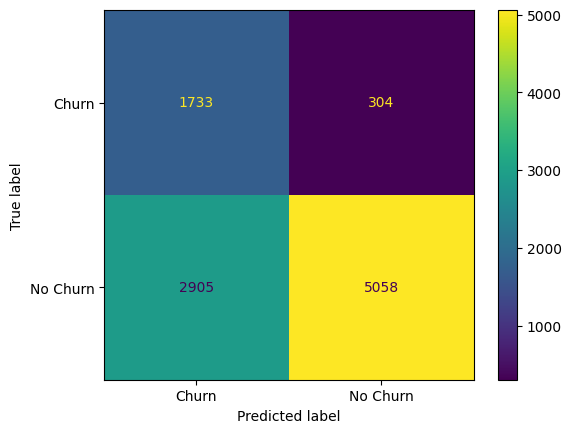

In [670]:
# Swap the labels so "1" (Exited / Churn) is shown first
banking_mlp_dir_cm = confusion_matrix(banking_y, banking_mlp_dir_pred, labels=[1, 0])

# Plot
banking_cm_mlp_display = ConfusionMatrixDisplay(confusion_matrix=banking_mlp_cm,display_labels=["Churn", "No Churn"])
banking_cm_mlp_display.plot()
plt.savefig("banking_mlp_dir_cm")
plt.show()

### Telecommunication

In [147]:
# Start from your OHE feature frame that still has raw numeric Age
telecom_X_for_dir_age = telecom_X.copy()

# Make Age_bucket from the raw Age right here
age_bins   = [0, 30, 65, numpy.inf]
age_values = ["<30", "30-65", ">=65"]

telecom_X_for_dir_age["Age_bucket"] = pd.cut(
    telecom_X_for_dir_age["Age"],
    bins=age_bins,
    labels=age_values,
    right=False
).astype(str)  # DIR expects strings

# Drop raw Age so the model doesn’t see it (DIR will still use Age_bucket)
telecom_X_for_dir_age.drop(columns=["Age"], inplace=True)

# quick sanity checks
print(telecom_X_for_dir_age.shape)
print(telecom_X_for_dir_age["Age_bucket"].value_counts())
telecom_X_for_dir_age

(7032, 43)
Age_bucket
30-65    4493
<30      1397
>=65     1142
Name: count, dtype: int64


,tenure,Contract,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Age_bucket
0,1,0.0,29.85,29.85,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,30-65
1,34,1.0,56.95,1889.50,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,30-65
2,2,0.0,53.85,108.15,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,30-65
3,45,1.0,42.30,1840.75,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,30-65
4,2,0.0,70.70,151.65,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,1.0,84.80,1990.50,0,1,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,30-65
7039,72,1.0,103.20,7362.90,1,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,30-65
7040,11,0.0,29.60,346.45,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,30-65
7041,4,0.0,74.40,306.60,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,>=65


In [148]:
# Create Age_bucket
df_telecom_no_encoding["Age_bucket"] = pd.cut(
    df_telecom_no_encoding["Age"],
    bins=age_bins,
    labels=age_values,
    right=False
)

# Optional: ensure string type (for DIR / fairness functions)
df_telecom_no_encoding["Age_bucket"] = df_telecom_no_encoding["Age_bucket"].astype(str)

df_telecom_no_encoding

,gender,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Age,Age_bucket
0,Female,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,36,30-65
1,Male,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,46,30-65
2,Male,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,37,30-65
3,Male,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,53,30-65
4,Female,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,19,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,38,30-65
7039,Female,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,30,30-65
7040,Female,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,32,30-65
7041,Male,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,75,>=65


#### Logistic Regression

In [149]:
telecom_lr_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=telecom_X_for_dir_age,             # numeric non-sensitive features + raw 'Age_bucket'
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],    # <-- your chosen privileged group for age
    repair_level=0.6,
    keep_prot_attr=False,           # model won’t see Age_bucket
    positive_label=1,
)

# Access results
telecom_lr_train_dir_age_df = telecom_lr_results_dir_age["train_df"]
telecom_lr_test_dir_age_df  = telecom_lr_results_dir_age["test_df"]
telecom_lr_dir_age_pred     = telecom_lr_results_dir_age["oof_pred"]
telecom_lr_dir_age_eod     = telecom_lr_results_dir_age["eod_summary"]
telecom_lr_dir_age_tpr    = telecom_lr_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8467  0.9224     0.4392  0.5950  0.7560
2     0.8475  0.9184     0.4378  0.5930  0.7531
3     0.8480  0.9198     0.4392  0.5945  0.7546
4     0.8479  0.9151     0.4393  0.5936  0.7521
5     0.8490  0.9197     0.4417  0.5968  0.7561

Mean (±std) TRAIN:
AUC          0.8478 ± 0.0008
Recall       0.9191 ± 0.0027
Precision    0.4394 ± 0.0014
F1           0.5946 ± 0.0015
F2           0.7544 ± 0.0018
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8487  0.9144     0.4362  0.5907  0.7500
2     0.8475  0.9198     0.4422  0.5972  0.7564
3     0.8431  0.9223     0.4289  0.5855  0.7498
4     0.8429  0.9278     0.4398  0.5967  0.7593
5     0.8413  0.9064  

#### Random Forest

##### Age

In [150]:
telecom_rf_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=telecom_X_for_dir_age,             # numeric non-sensitive features + raw 'Age_bucket'
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],    # <-- your chosen privileged group for age
    repair_level=0.6,
    keep_prot_attr=False,           # model won’t see Age_bucket
    positive_label=1,
)

# Access results
telecom_rf_train_dir_age_df = telecom_rf_results_dir_age["train_df"]
telecom_rf_test_dir_age_df  = telecom_rf_results_dir_age["test_df"]
telecom_rf_dir_age_pred     = telecom_rf_results_dir_age["oof_pred"]
telecom_rf_dir_age_eod     = telecom_rf_results_dir_age["eod_summary"]
telecom_rf_dir_age_tpr    = telecom_rf_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8873  0.9478     0.4720  0.6302  0.7888
2     0.8864  0.9385     0.4766  0.6321  0.7861
3     0.8866  0.9579     0.4450  0.6077  0.7785
4     0.8937  0.9498     0.4799  0.6376  0.7943
5     0.8881  0.9525     0.4608  0.6212  0.7850

Mean (±std) TRAIN:
AUC           0.8884 ± 0.003
Recall       0.9493 ± 0.0071
Precision    0.4669 ± 0.0142
F1           0.6258 ± 0.0117
F2           0.7865 ± 0.0058
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8480  0.8984     0.4480  0.5979  0.7480
2     0.8517  0.9118     0.4529  0.6051  0.7581
3     0.8428  0.9437     0.4141  0.5756  0.7515
4     0.8468  0.8877     0.4554  0.6020  0.7461
5     0.8435  0.8957  

#### XGBoost

In [151]:
telecom_xgb_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=telecom_X_for_dir_age,             # numeric non-sensitive features + raw 'Age_bucket'
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],    # <-- your chosen privileged group for age
    repair_level=0.6,
    keep_prot_attr=False,           # model won’t see Age_bucket
    positive_label=1,
)

# Access results
telecom_xgb_train_dir_age_df = telecom_xgb_results_dir_age["train_df"]
telecom_xgb_test_dir_age_df  = telecom_xgb_results_dir_age["test_df"]
telecom_xgb_dir_age_pred     = telecom_xgb_results_dir_age["oof_pred"]
telecom_xgb_dir_age_eod     = telecom_xgb_results_dir_age["eod_summary"]
telecom_xgb_dir_age_tpr    = telecom_xgb_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8652  0.9311     0.4384  0.5961  0.7602
2     0.8637  0.9191     0.4484  0.6028  0.7596
3     0.8641  0.9238     0.4404  0.5965  0.7575
4     0.8754  0.9211     0.4644  0.6175  0.7697
5     0.8808  0.9338     0.4727  0.6277  0.7814

Mean (±std) TRAIN:
AUC          0.8698 ± 0.0078
Recall       0.9258 ± 0.0064
Precision    0.4529 ± 0.0151
F1            0.6081 ± 0.014
F2           0.7657 ± 0.0099
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8457  0.9144     0.4335  0.5881  0.7484
2     0.8541  0.9171     0.4426  0.5970  0.7552
3     0.8450  0.9383     0.4300  0.5897  0.7589
4     0.8455  0.8904     0.4555  0.6027  0.7476
5     0.8401  0.8770  

#### Multi Layer Perceptron

In [455]:
telecom_mlp_results_dir_age = run_nested_cv_with_diagnostics_dir(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=telecom_X_for_dir_age,             # numeric non-sensitive features + raw 'Age_bucket'
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],    # <-- your chosen privileged group for age
    repair_level=0.6,
    keep_prot_attr=False,           # model won’t see Age_bucket
    positive_label=1,
)

# Access results
telecom_mlp_train_dir_age_df = telecom_mlp_results_dir_age["train_df"]
telecom_mlp_test_dir_age_df  = telecom_mlp_results_dir_age["test_df"]
telecom_mlp_dir_age_pred     = telecom_mlp_results_dir_age["oof_pred"]
telecom_mlp_dir_age_proba    = telecom_mlp_results_dir_age["oof_proba"]
telecom_mlp_dir_age_eod     = telecom_mlp_results_dir_age["eod_summary"]
telecom_mlp_dir_age_tpr    = telecom_mlp_results_dir_age["tpr_summary"]

[DIR] keep_prot_attr=False → sensitive attributes REMOVED from model: ['Age_bucket']

=== Per-fold TRAIN metrics (DIR tuned; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8431  0.9385     0.4043  0.5652  0.7423
2     0.8452  0.9331     0.4165  0.5760  0.7477
3     0.8530  0.9378     0.4203  0.5805  0.7525
4     0.8456  0.8957     0.4440  0.5937  0.7442
5     0.8477  0.9438     0.4099  0.5716  0.7488

Mean (±std) TRAIN:
AUC          0.8469 ± 0.0038
Recall       0.9298 ± 0.0194
Precision     0.419 ± 0.0152
F1           0.5774 ± 0.0107
F2            0.7471 ± 0.004
dtype: object

=== Per-fold TEST metrics ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8468  0.9305     0.4061  0.5654  0.7395
2     0.8470  0.9385     0.4204  0.5806  0.7529
3     0.8441  0.9464     0.4119  0.5740  0.7514
4     0.8412  0.9171     0.4478  0.6018  0.7582
5     0.8385  0.9251  

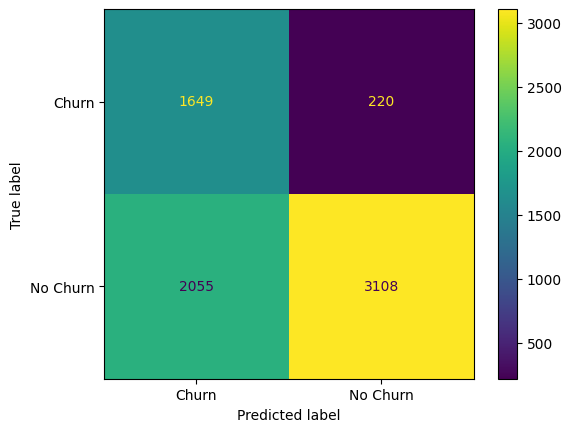

In [671]:
# Swap the labels so "1" (Exited / Churn) is shown first
telecom_mlp_dir_cm = confusion_matrix(telecom_y, telecom_mlp_dir_age_pred, labels=[1, 0])

# Plot
telecom_cm_mlp_display = ConfusionMatrixDisplay(confusion_matrix=telecom_mlp_cm,display_labels=["Churn", "No Churn"])
telecom_cm_mlp_display.plot()
plt.savefig("telecom_mlp_dir_cm")
plt.show()

## Learning Fair Representations

In [153]:
def _lfr_repair(
    X_tr, y_tr, X_te, y_te,
    prot_attr,                 # str: the single protected attribute name (already in X_tr/X_te)
    privileged_values=None,    # list-like of privileged values (strings)
    k=5, Ax=0.01, Ay=1.0, Az=50.0,
    keep_prot_attr=False,
    positive_label=1,
    label_name="__label__",
    random_state=None
):
    # Make copies of training and test sets, so it will not affect the original dataset
    df_tr = X_tr.copy()
    df_te = X_te.copy()

    # Attach target values to the dataset, which is needed for LFR
    df_tr[label_name] = y_tr.values
    df_te[label_name] = y_te.values

    # Only use original dataset features (so remove created (__S_INTER__) and sensitive features)
    feature_candidates = [c for c in X_tr.columns if c != prot_attr]
    num_cols = [c for c in feature_candidates
                if pd.api.types.is_numeric_dtype(X_tr[c])]

    feat_keep = num_cols  # what LFR will see as X

    # NEW: scale numeric features to [0, 1] on TRAIN, then apply to TEST (before building AIF360 datasets)
    scaler = MinMaxScaler()

    if len(num_cols) > 0:
        # Ensure dtype is float first (prevents Pandas dtype mismatch warnings)
        df_tr[num_cols] = df_tr[num_cols].astype(float)
        df_te[num_cols] = df_te[num_cols].astype(float)
    
        # Now safely assign scaled values
        df_tr[num_cols] = scaler.fit_transform(df_tr[num_cols])
        df_te[num_cols] = scaler.transform(df_te[num_cols])

    # Build AIF360 datasets
    ds_tr = StandardDataset(
        df=df_tr,
        label_name=label_name,
        favorable_classes=[positive_label],
        protected_attribute_names=[prot_attr],
        privileged_classes=[privileged_values],
        features_to_keep=feat_keep
    )
    ds_te = StandardDataset(
        df=df_te,
        label_name=label_name,
        favorable_classes=[positive_label],
        protected_attribute_names=[prot_attr],
        privileged_classes=[privileged_values],
        features_to_keep=feat_keep
    )

    # Create binary columns whether a sample is privileged given a sensitive attribute
    name = ds_tr.protected_attribute_names[0]
    unprivileged_groups = [{name: 0.0}]
    privileged_groups   = [{name: 1.0}]

    # fit LFR on train, transform train/test
    lfr = LFR(
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
        k=k, Ax=Ax, Ay=Ay, Az=Az,
        verbose=0,
        seed=random_state
    )
    lfr.fit(ds_tr)
    ds_tr_rep = lfr.transform(ds_tr)
    ds_te_rep = lfr.transform(ds_te)

    # Return the transformed dataset
    k_out = ds_tr_rep.features.shape[1]
    cols = [f"lfr_{i}" for i in range(k_out)]
    X_tr_rep = pd.DataFrame(ds_tr_rep.features, columns=cols, index=X_tr.index)
    X_te_rep = pd.DataFrame(ds_te_rep.features, columns=cols, index=X_te.index)
    return X_tr_rep, X_te_rep

In [154]:
def run_nested_cv_with_diagnostics_lfr(
    pipe, param_grid, X, y,
    scorer="roc_auc",
    inner_splits=5, outer_splits=5, random_state=42,
    prot_attr=None, privileged_values=None,
    keep_prot_attr=False, positive_label=1,
    k=5, Ax=0.01, Ay=1.0, Az=50.0,
):
    """
    LFR without any resampling.
    Inner CV:
      - Cache LFR transforms per inner split ONCE.
      - For each param set, fit → predict on cached folds → AUC.
      - Keep pooled inner-val probs (best params) → tune F2 threshold.
    Outer CV:
      - Single LFR fit on full outer-train; refit best model; evaluate on TEST
        using the inner-tuned threshold (per fold).
    """
    import numpy as np, pandas as pd, time
    from sklearn.base import clone
    from sklearn.model_selection import StratifiedKFold, ParameterGrid
    from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
    from collections import defaultdict

    # Make sure that privileged values are always a list of strings
    def _as_list(x):
        if isinstance(x, (list, tuple, set, np.ndarray)):
            return [str(v) for v in x]
        return [str(x)]

    # Create a binary column marking samples that are privileged across all protected attributes
    def _make_intersection_col(df: pd.DataFrame, priv_map: dict, prot_cols_local, name="__S_INTER__"):
        m = np.ones(len(df), dtype=bool)
        for a in prot_cols_local:
            pv = priv_map[a]
            pv_list = [str(x) for x in (pv if isinstance(pv, (list, tuple, np.ndarray, set)) else [pv])]
            m &= df[a].astype(str).isin(pv_list).values
        out = df.copy()
        out[name] = np.where(m, "1", "0")
        return out

    # ---- Setup ----
    if prot_attr is None:
        raise ValueError("Provide prot_attr (str or list[str]) for LFR.")
    prot_cols = _as_list(prot_attr)
    missing = [c for c in prot_cols if c not in X.columns]
    if missing:
        raise ValueError(f"Sensitive column(s) not in X: {missing}")

    use_intersection = len(prot_cols) > 1

    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)
    oof_pred  = np.zeros(n, dtype=int)
    fold_train_metrics, fold_test_metrics = [], []
    fold_thresholds = []
    removed_sensitive_once = None

    # === Fairness bookkeeping (same helpers as other runs) ===
    gender_cols_all = find_gender_cols(X.columns)   # one-hot (case-insensitive)
    geo_cols_all    = find_geo_cols(X.columns)      # one-hot (case-insensitive)
    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []
    age_tpr_agg, gender_tpr_agg, geo_tpr_agg = defaultdict(list), defaultdict(list), defaultdict(list)

    # Initialize inner and outer CV
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # ---- Nested Cross-Validation ----
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr_raw = X.iloc[train_idx].copy()
        X_te_raw = X.iloc[test_idx].copy()
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # Prepare single protected name + values (supports intersection)
        if use_intersection:
            if not isinstance(privileged_values, dict):
                raise ValueError("For intersectional LFR, pass privileged_values as dict {attr: value(s)}.")
            X_tr_use = _make_intersection_col(X_tr_raw, privileged_values, prot_cols, name="__S_INTER__")
            X_te_use = _make_intersection_col(X_te_raw, privileged_values, prot_cols, name="__S_INTER__")
            prot_name = "__S_INTER__"
            priv_for_lfr = ["1"]  # privileged across all attrs
            human_desc = f"{prot_name} (intersection of {prot_cols})"
        else:
            X_tr_use, X_te_use = X_tr_raw, X_te_raw
            prot_name = prot_cols[0]
            priv_for_lfr = [str(v) for v in _as_list(privileged_values)]
            human_desc = prot_name

        # Report which exact columns will be removed from the model (only once)
        if not keep_prot_attr and removed_sensitive_once is None:
            print(f"[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [{human_desc}]")
            removed_sensitive_once = [human_desc]
        elif keep_prot_attr and removed_sensitive_once is None:
            print(f"[LFR] keep_prot_attr=True  → model WILL receive protected attribute(s): [{human_desc}]")
            removed_sensitive_once = [human_desc]

        # ---- INNER CV: cache LFR transforms (no resampling) ----
        inner_cache = []
        for in_tr_idx, in_va_idx in inner_cv.split(X_tr_use, y_tr):
            X_in_tr, X_in_va = X_tr_use.iloc[in_tr_idx], X_tr_use.iloc[in_va_idx]
            y_in_tr, y_in_va = y_tr.iloc[in_tr_idx],   y_tr.iloc[in_va_idx]

            # Fit LFR on the inner-train set and transform both inner-train and inner-validation sets
            X_lfr_tr, X_lfr_va = _lfr_repair(
                X_in_tr, y_in_tr, X_in_va, y_in_va,
                prot_attr=prot_name, privileged_values=priv_for_lfr,
                k=k, Ax=Ax, Ay=Ay, Az=Az,
                keep_prot_attr=keep_prot_attr, positive_label=positive_label,
                random_state=random_state
            )

            inner_cache.append({
                "X_tr": X_lfr_tr, "y_tr": y_in_tr,   # NO resampling
                "X_va": X_lfr_va, "y_va": y_in_va
            })

        if not inner_cache:
            raise RuntimeError("Inner CV produced no valid splits for LFR; check data/config.")

        # ---- Manual grid search using cached LFR data + pooled inner-val for threshold ----
        best_params = None
        best_mean_auc = -np.inf
        best_inner_val_proba = None
        best_inner_val_true  = None

        for params in ParameterGrid(param_grid):
            aucs, pooled_val_proba, pooled_val_true = [], [], []
            for blk in inner_cache:
                model = clone(pipe).set_params(**params)
                model.fit(blk["X_tr"], blk["y_tr"])
                val_proba = model.predict_proba(blk["X_va"])[:, 1]
                aucs.append(roc_auc_score(blk["y_va"], val_proba))
                pooled_val_proba.append(val_proba)
                pooled_val_true.append(
                    blk["y_va"].to_numpy() if hasattr(blk["y_va"], "to_numpy") else np.asarray(blk["y_va"])
                )

            if aucs:
                mean_auc = float(np.mean(aucs))
                if mean_auc > best_mean_auc:
                    best_mean_auc = mean_auc
                    best_params = params
                    best_inner_val_proba = np.concatenate(pooled_val_proba, axis=0)
                    best_inner_val_true  = np.concatenate(pooled_val_true,  axis=0)

        # === F2 threshold from pooled inner-val predictions of the best model ===
        thresh_grid = np.linspace(0.0, 1.0, 101)
        f2_vals = [fbeta_score(best_inner_val_true,
                               (best_inner_val_proba >= t).astype(int),
                               beta=2, zero_division=0)
                   for t in thresh_grid]
        chosen_threshold = float(thresh_grid[int(np.argmax(f2_vals))])
        fold_thresholds.append(chosen_threshold)

        # ---- OUTER: fit single LFR on full outer-train; evaluate on outer-test ----
        X_tr_lfr, X_te_lfr = _lfr_repair(
            X_tr_use, y_tr, X_te_use, y_te,
            prot_attr=prot_name, privileged_values=priv_for_lfr,
            k=k, Ax=Ax, Ay=Ay, Az=Az,
            keep_prot_attr=keep_prot_attr, positive_label=positive_label,
            random_state=random_state
        )

        # Train best model (no resampling) and apply tuned threshold
        best_model = clone(pipe).set_params(**best_params)
        best_model.fit(X_tr_lfr, y_tr)

        train_proba = best_model.predict_proba(X_tr_lfr)[:, 1]
        test_proba  = best_model.predict_proba(X_te_lfr)[:, 1]
        train_pred  = (train_proba >= chosen_threshold).astype(int)
        test_pred   = (test_proba  >= chosen_threshold).astype(int)

        # store OOF
        oof_proba[test_idx] = test_proba
        oof_pred[test_idx]  = test_pred

        # Metrics 
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba),
            "Recall": recall_score(y_tr, train_pred, zero_division=0),
            "Precision": precision_score(y_tr, train_pred, zero_division=0),
            "F1": f1_score(y_tr, train_pred, zero_division=0),
            "F2": fbeta_score(y_tr, train_pred, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba),
            "Recall": recall_score(y_te, test_pred, zero_division=0),
            "Precision": precision_score(y_te, test_pred, zero_division=0),
            "F1": f1_score(y_te, test_pred, zero_division=0),
            "F2": fbeta_score(y_te, test_pred, beta=2, zero_division=0),
        })

        # === Fairness on TEST (handles one-hot OR categorical) ===
        # Age via Age_bucket in original raw features
        if "Age_bucket" in X_te_raw.columns:
            age_ohe = pd.get_dummies(X_te_raw["Age_bucket"].astype(str), prefix="Age", dtype=int)
            age_cols = list(age_ohe.columns)
            age_tprs, eod_age = group_tprs_onehot(age_ohe, y_te.values, test_pred, age_cols)
            for g, v in age_tprs.items():
                age_tpr_agg[g].append(v)
            eod_age_folds.append(eod_age)
        else:
            eod_age_folds.append(np.nan)

        # Gender
        gcols = [c for c in gender_cols_all if c in X_te_raw.columns]
        if gcols:
            gen_tprs, eod_gen = group_tprs_onehot(X_te_raw, y_te.values, test_pred, gcols)
        else:
            gender_cat = next((c for c in X_te_raw.columns if c.lower() == "gender"), None)
            if gender_cat is not None:
                gender_ohe = pd.get_dummies(X_te_raw[gender_cat].astype(str), prefix="Gender", dtype=int)
                gcols_tmp = list(gender_ohe.columns)
                gen_tprs, eod_gen = group_tprs_onehot(gender_ohe, y_te.values, test_pred, gcols_tmp)
            else:
                gen_tprs, eod_gen = {}, np.nan
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        # Geography / Location
        lcols = [c for c in geo_cols_all if c in X_te_raw.columns]
        if lcols:
            geo_tprs, eod_geo = group_tprs_onehot(X_te_raw, y_te.values, test_pred, lcols)
        else:
            geo_cat = next((c for c in X_te_raw.columns if c.lower() in ("geography", "location")), None)
            if geo_cat is not None:
                prefix = "Geography" if geo_cat.lower() == "geography" else "Location"
                geo_ohe = pd.get_dummies(X_te_raw[geo_cat].astype(str), prefix=prefix, dtype=int)
                lcols_tmp = list(geo_ohe.columns)
                geo_tprs, eod_geo = group_tprs_onehot(geo_ohe, y_te.values, test_pred, lcols_tmp)
            else:
                geo_tprs, eod_geo = {}, np.nan
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

    # Final Results 
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0),
    }

    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics ).set_index("Fold").sort_index()

    # === Fairness summaries ===
    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    age_tpr_means,    age_tpr_stds    = agg_means_stds(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = agg_means_stds(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = agg_means_stds(geo_tpr_agg)

    # ---- Prints ----
    print("\n=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " +
          train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " +
          test_df.std().round(4).astype(str))

    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    _pretty_tprs("Age",       age_tpr_means,    age_tpr_stds)
    _pretty_tprs("Gender",    gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means,    geo_tpr_stds)

    print("\n=== OOF metrics (pooled; tuned F2 threshold applied per fold) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    # Show thresholds like the other functions
    print(f"\nThresholds chosen per outer fold: {np.array(fold_thresholds)}")

    print(f"Total runtime: {time.time() - start:.2f} s")

    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,
        "oof_pred": oof_pred,
        "oof_results": oof_results,
        "fold_thresholds": np.array(fold_thresholds),
        "removed_sensitive": removed_sensitive_once if removed_sensitive_once is not None else [],
        # summaries
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        }
    }

### Banking

#### Logistic Regression

##### Age

In [155]:
banking_lr_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_lr_train_lfr_age_df = banking_lr_results_lfr_age["train_df"]
banking_lr_test_lfr_age_df  = banking_lr_results_lfr_age["test_df"]
banking_lr_lfr_age_pred     = banking_lr_results_lfr_age["oof_pred"]
banking_lr_lfr_age_eod     = banking_lr_results_lfr_age["eod_summary"]
banking_lr_lfr_age_tpr    = banking_lr_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.5696  1.0000     0.2037  0.3384  0.5612
2     0.5626  1.0000     0.2038  0.3386  0.5613
3     0.5700  1.0000     0.2038  0.3386  0.5614
4     0.5667  1.0000     0.2038  0.3386  0.5613
5     0.5751  0.9994     0.2038  0.3386  0.5613

Mean (±std) TRAIN:
AUC          0.5688 ± 0.0046
Recall       0.9999 ± 0.0003
Precision    0.2038 ± 0.0001
F1           0.3386 ± 0.0001
F2           0.5613 ± 0.0001
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.5723  1.0000     0.2042  0.3392  0.5620
2     0.5673  0.9975     0.2036  0.3382  0.5605
3     0.5517  1.0000     0.2035  0.3382  0.

##### Joint

In [156]:
banking_lr_results_lfr = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values={"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},   # 1 = Female & 30-65 & Germany
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

# Access results
banking_lr_train_lfr_df = banking_lr_results_lfr["train_df"]
banking_lr_test_lfr_df  = banking_lr_results_lfr["test_df"]
banking_lr_lfr_pred     = banking_lr_results_lfr["oof_pred"]
banking_lr_lfr_eod     = banking_lr_results_lfr["eod_summary"]
banking_lr_lfr_tpr     = banking_lr_results_lfr["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [__S_INTER__ (intersection of ['Gender', 'Age_bucket', 'Geography'])]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6183  0.9251     0.2203  0.3559  0.5642
2     0.6229  0.9184     0.2229  0.3588  0.5655
3     0.6271  0.9025     0.2269  0.3627  0.5657
4     0.6232  0.9196     0.2223  0.3581  0.5651
5     0.6196  0.9245     0.2179  0.3527  0.5608

Mean (±std) TRAIN:
AUC          0.6222 ± 0.0034
Recall        0.918 ± 0.0092
Precision    0.2221 ± 0.0034
F1           0.3576 ± 0.0037
F2            0.5643 ± 0.002
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6367  0.9338     0.2242  0.3617  0.5719
2     0.6233  0.9191     0.2263  0

#### Random Forest

##### Age

In [157]:
banking_rf_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_rf_train_lfr_age_df = banking_rf_results_lfr_age["train_df"]
banking_rf_test_lfr_age_df  = banking_rf_results_lfr_age["test_df"]
banking_rf_lfr_age_pred     = banking_rf_results_lfr_age["oof_pred"]
banking_rf_lfr_age_eod     = banking_rf_results_lfr_age["eod_summary"]
banking_rf_lfr_age_tpr    = banking_rf_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8527  0.9490     0.3136  0.4714  0.6753
2     0.8625  0.9693     0.2970  0.4547  0.6673
3     0.8554  0.9773     0.2667  0.4190  0.6375
4     0.8554  0.9466     0.3130  0.4704  0.6738
5     0.8495  0.9613     0.2840  0.4384  0.6509

Mean (±std) TRAIN:
AUC          0.8551 ± 0.0048
Recall       0.9607 ± 0.0131
Precision      0.2948 ± 0.02
F1           0.4508 ± 0.0223
F2            0.661 ± 0.0163
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7244  0.8824     0.2786  0.4235  0.6156
2     0.7112  0.8971     0.2603  0.4035  0.6024
3     0.7006  0.9042     0.2387  0.3776  0.

##### Joint

In [158]:
banking_rf_results_lfr = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values={"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_rf_train_lfr_df = banking_rf_results_lfr["train_df"]
banking_rf_test_lfr_df  = banking_rf_results_lfr["test_df"]
banking_rf_lfr_pred     = banking_rf_results_lfr["oof_pred"]
banking_rf_lfr_eod     = banking_rf_results_lfr["eod_summary"]
banking_rf_lfr_tpr     = banking_rf_results_lfr["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [__S_INTER__ (intersection of ['Gender', 'Age_bucket', 'Geography'])]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8091  1.0000     0.2246  0.3669  0.5916
2     0.8021  0.9994     0.2226  0.3642  0.5887
3     0.7788  0.9957     0.2237  0.3653  0.5891
4     0.7964  0.9945     0.2246  0.3665  0.5901
5     0.7799  0.9994     0.2138  0.3522  0.5760

Mean (±std) TRAIN:
AUC          0.7933 ± 0.0135
Recall       0.9978 ± 0.0025
Precision    0.2219 ± 0.0046
F1            0.363 ± 0.0061
F2           0.5871 ± 0.0063
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6548  0.9706     0.2179  0.3560  0.5741
2     0.6693  0.9706     0.2173  0

#### XGBoost

##### Age

In [159]:
banking_xgb_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_xgb_train_lfr_age_df = banking_xgb_results_lfr_age["train_df"]
banking_xgb_test_lfr_age_df  = banking_xgb_results_lfr_age["test_df"]
banking_xgb_lfr_age_pred     = banking_xgb_results_lfr_age["oof_pred"]
banking_xgb_lfr_age_eod     = banking_xgb_results_lfr_age["eod_summary"]
banking_xgb_lfr_age_tpr    = banking_xgb_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.9120  0.9877     0.2882  0.4463  0.6650
2     0.8557  0.9638     0.2872  0.4425  0.6551
3     0.9123  0.9834     0.2902  0.4481  0.6655
4     0.9262  0.9798     0.3368  0.5013  0.7091
5     0.9139  0.9742     0.3161  0.4773  0.6878

Mean (±std) TRAIN:
AUC           0.904 ± 0.0277
Recall       0.9778 ± 0.0093
Precision    0.3037 ± 0.0221
F1           0.4631 ± 0.0255
F2           0.6765 ± 0.0218
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7185  0.9044     0.2604  0.4044  0.6051
2     0.7220  0.9069     0.2604  0.4046  0.6060
3     0.6945  0.8575     0.2451  0.3812  0.

##### Joint

In [160]:
banking_xgb_results_lfr = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values={"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_xgb_train_lfr_df = banking_xgb_results_lfr["train_df"]
banking_xgb_test_lfr_df  = banking_xgb_results_lfr["test_df"]
banking_xgb_lfr_pred     = banking_xgb_results_lfr["oof_pred"]
banking_xgb_lfr_eod     = banking_xgb_results_lfr["eod_summary"]
banking_xgb_lfr_tpr     = banking_xgb_results_lfr["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [__S_INTER__ (intersection of ['Gender', 'Age_bucket', 'Geography'])]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8320  0.9982     0.2155  0.3545  0.5782
2     0.7866  0.9859     0.2268  0.3688  0.5906
3     0.6871  0.9528     0.2276  0.3674  0.5819
4     0.7206  0.9663     0.2264  0.3669  0.5844
5     0.7756  1.0000     0.2118  0.3496  0.5733

Mean (±std) TRAIN:
AUC           0.7604 ± 0.057
Recall       0.9806 ± 0.0206
Precision    0.2216 ± 0.0074
F1           0.3614 ± 0.0088
F2           0.5817 ± 0.0065
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6464  0.9828     0.2140  0.3514  0.5719
2     0.6723  0.9461     0.2187  0

#### Multi Layer Perceptron

##### Age

In [161]:
banking_mlp_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=banking_X_for_dir_age,
    y=banking_y,
    prot_attr="Age_bucket",
    privileged_values=["30-65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_mlp_train_lfr_age_df = banking_mlp_results_lfr_age["train_df"]
banking_mlp_test_lfr_age_df  = banking_mlp_results_lfr_age["test_df"]
banking_mlp_lfr_age_pred     = banking_mlp_results_lfr_age["oof_pred"]
banking_mlp_lfr_age_eod     = banking_mlp_results_lfr_age["eod_summary"]
banking_mlp_lfr_age_tpr    = banking_mlp_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.5337     1.0     0.2036  0.3384  0.5611
2     0.5323     1.0     0.2036  0.3384  0.5611
3     0.5392     1.0     0.2037  0.3385  0.5613
4     0.5395     1.0     0.2037  0.3385  0.5613
5     0.5393     1.0     0.2037  0.3385  0.5613

Mean (±std) TRAIN:
AUC          0.5368 ± 0.0035
Recall             1.0 ± 0.0
Precision    0.2037 ± 0.0001
F1           0.3385 ± 0.0001
F2           0.5612 ± 0.0001
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.5336     1.0     0.2040  0.3389  0.5617
2     0.5412     1.0     0.2040  0.3389  0.5617
3     0.5370     1.0     0.2035  0.3382  0.

##### Joint

In [162]:
banking_mlp_results_lfr = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=banking_X_for_dir_joint,
    y=banking_y,
    prot_attr=["Gender","Age_bucket","Geography"],
    privileged_values={"Gender": ["Male"], "Age_bucket": ["30-65"], "Geography": ["Germany"]},
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

banking_mlp_train_lfr_df = banking_mlp_results_lfr["train_df"]
banking_mlp_test_lfr_df  = banking_mlp_results_lfr["test_df"]
banking_mlp_lfr_pred     = banking_mlp_results_lfr["oof_pred"]
banking_mlp_lfr_eod     = banking_mlp_results_lfr["eod_summary"]
banking_mlp_lfr_tpr     = banking_mlp_results_lfr["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [__S_INTER__ (intersection of ['Gender', 'Age_bucket', 'Geography'])]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6151     1.0     0.2036  0.3384  0.5611
2     0.6190     1.0     0.2036  0.3384  0.5611
3     0.6242     1.0     0.2037  0.3385  0.5613
4     0.6197     1.0     0.2037  0.3385  0.5613
5     0.6143     1.0     0.2037  0.3385  0.5613

Mean (±std) TRAIN:
AUC           0.6184 ± 0.004
Recall             1.0 ± 0.0
Precision    0.2037 ± 0.0001
F1           0.3385 ± 0.0001
F2           0.5612 ± 0.0001
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6359     1.0     0.2040  0.3389  0.5617
2     0.6199     1.0     0.2040  0

### Telecommunication

#### Logistic Regression

In [163]:
telecom_lr_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_lr_fairness,
    param_grid=param_grid_lr,
    X=telecom_X_for_dir_age,
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

telecom_lr_train_lfr_age_df = telecom_lr_results_lfr_age["train_df"]
telecom_lr_test_lfr_age_df  = telecom_lr_results_lfr_age["test_df"]
telecom_lr_lfr_age_pred     = telecom_lr_results_lfr_age["oof_pred"]
telecom_lr_lfr_age_eod     = telecom_lr_results_lfr_age["eod_summary"]
telecom_lr_lfr_age_tpr    = telecom_lr_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6616  0.9980     0.2665  0.4207  0.6443
2     0.6685  0.9425     0.2849  0.4375  0.6448
3     0.6624  0.9993     0.2663  0.4205  0.6445
4     0.6641  0.9967     0.2666  0.4207  0.6440
5     0.6643  0.9973     0.2667  0.4208  0.6443

Mean (±std) TRAIN:
AUC          0.6642 ± 0.0027
Recall       0.9868 ± 0.0248
Precision    0.2702 ± 0.0082
F1            0.424 ± 0.0075
F2           0.6444 ± 0.0003
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6729  0.9973     0.2662  0.4203  0.6438
2     0.6617  0.9465     0.2787  0.4307  0.6399
3     0.6476  0.9973     0.2648  0.4184  0.

#### Random Forest

In [164]:
telecom_rf_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_rf_fairness,
    param_grid=param_grid_rf,
    X=telecom_X_for_dir_age,
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

telecom_rf_train_lfr_age_df = telecom_rf_results_lfr_age["train_df"]
telecom_rf_test_lfr_age_df  = telecom_rf_results_lfr_age["test_df"]
telecom_rf_lfr_age_pred     = telecom_rf_results_lfr_age["oof_pred"]
telecom_rf_lfr_age_eod     = telecom_rf_results_lfr_age["eod_summary"]
telecom_rf_lfr_age_tpr    = telecom_rf_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8587  0.9933     0.3448  0.5119  0.7218
2     0.8532  0.9920     0.3431  0.5099  0.7198
3     0.8535  0.9806     0.3705  0.5378  0.7376
4     0.8455  0.9967     0.3350  0.5014  0.7144
5     0.8475  0.9779     0.3587  0.5249  0.7269

Mean (±std) TRAIN:
AUC          0.8517 ± 0.0053
Recall       0.9881 ± 0.0083
Precision    0.3504 ± 0.0141
F1           0.5172 ± 0.0142
F2           0.7241 ± 0.0088
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7181  0.9225     0.3183  0.4733  0.6686
2     0.7074  0.9358     0.3106  0.4664  0.6672
3     0.7002  0.8981     0.3221  0.4742  0.

#### XGBoost

In [165]:
telecom_xgb_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_xgb_fairness,
    param_grid=param_grid_xgb,
    X=telecom_X_for_dir_age,
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

telecom_xgb_train_lfr_age_df = telecom_xgb_results_lfr_age["train_df"]
telecom_xgb_test_lfr_age_df  = telecom_xgb_results_lfr_age["test_df"]
telecom_xgb_lfr_age_pred     = telecom_xgb_results_lfr_age["oof_pred"]
telecom_xgb_lfr_age_eod     = telecom_xgb_results_lfr_age["eod_summary"]
telecom_xgb_lfr_age_tpr    = telecom_xgb_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8289  0.9880     0.3300  0.4947  0.7063
2     0.8300  0.9873     0.3293  0.4939  0.7054
3     0.8614  0.9926     0.3483  0.5156  0.7245
4     0.8675  0.9960     0.3364  0.5030  0.7155
5     0.8662  0.9913     0.3334  0.4990  0.7108

Mean (±std) TRAIN:
AUC          0.8508 ± 0.0196
Recall        0.991 ± 0.0036
Precision    0.3355 ± 0.0077
F1           0.5012 ± 0.0088
F2           0.7125 ± 0.0078
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7224  0.9251     0.3168  0.4720  0.6685
2     0.6949  0.9358     0.3033  0.4581  0.6604
3     0.7019  0.9142     0.3117  0.4649  0.

#### Multi Layer Perceptron

In [166]:
telecom_mlp_results_lfr_age = run_nested_cv_with_diagnostics_lfr(
    pipe=pipe_mlp_fairness,
    param_grid=param_grid_mlp,
    X=telecom_X_for_dir_age,
    y=telecom_y,
    prot_attr="Age_bucket",
    privileged_values=[">=65"],
    keep_prot_attr=False,
    k=5, Ax=0.01, Ay=1.0, Az=50.0
)

telecom_mlp_train_lfr_age_df = telecom_mlp_results_lfr_age["train_df"]
telecom_mlp_test_lfr_age_df  = telecom_mlp_results_lfr_age["test_df"]
telecom_mlp_lfr_age_pred     = telecom_mlp_results_lfr_age["oof_pred"]
telecom_mlp_lfr_age_eod     = telecom_mlp_results_lfr_age["eod_summary"]
telecom_mlp_lfr_age_tpr    = telecom_mlp_results_lfr_age["tpr_summary"]

[LFR] keep_prot_attr=False → model will NOT receive protected attribute(s): [Age_bucket]

=== Per-fold TRAIN metrics (LFR; inner-CV tuned; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6462  1.0000     0.2658  0.4199  0.6441
2     0.6589  1.0000     0.2658  0.4199  0.6441
3     0.6240  0.0000     0.0000  0.0000  0.0000
4     0.6562  1.0000     0.2657  0.4199  0.6441
5     0.6332  0.2508     0.4181  0.3135  0.2726

Mean (±std) TRAIN:
AUC          0.6437 ± 0.0149
Recall       0.6502 ± 0.4872
Precision     0.2431 ± 0.151
F1           0.3147 ± 0.1818
F2            0.441 ± 0.2944
dtype: object

=== Per-fold TEST metrics (LFR; tuned F2 threshold; no resampling) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6556  1.0000     0.2658  0.4200  0.6442
2     0.6525  1.0000     0.2658  0.4200  0.6442
3     0.6066  0.0000     0.0000  0.0000  0.

## Equal Odds Post-processing

In [167]:
def build_bld_from_categorical(
    df_categorical: pd.DataFrame,
    y: pd.Series,
    protected_attributes: list,    # e.g., ["Gender","Age_bucket","Geography"]
    privileged_map: dict,          # e.g., {"Gender":"Male","Age_bucket":"30-65","Geography":"France"}
    label_name: str = "label",
    favorable_label: int = 1,
    unfavorable_label: int = 0,
):
    # 1) Work only with protected columns
    work = df_categorical.loc[:, protected_attributes].copy()

    # 2) Binarize each protected attribute (1 if value == privileged, else 0)
    bin_cols = []
    for attr in protected_attributes:
        if attr not in privileged_map:
            raise ValueError(f"Missing privileged value for '{attr}' in privileged_map.")
        priv_val = str(privileged_map[attr])
        col_bin = f"__bin__{attr}"
        work[col_bin] = (work[attr].astype(str) == priv_val).astype(int)
        bin_cols.append(col_bin)

    # 3) Dataset with ONLY binary protected columns + label
    df_for_aif = pd.concat([work[bin_cols], y.rename(label_name)], axis=1)

    # 4) Build bld (AIF360) dataset using binary protected attributes
    bld = BinaryLabelDataset(
        df=df_for_aif,
        label_names=[label_name],
        protected_attribute_names=bin_cols,
        favorable_label=favorable_label,
        unfavorable_label=unfavorable_label,
        privileged_protected_attributes=[[1] for _ in bin_cols],
        unprivileged_protected_attributes=[[0] for _ in bin_cols],
    )

    # Mapping back (handy if you want to know which bin col belongs to which attr)
    attr_to_bin = dict(zip(protected_attributes, bin_cols))
    return bld, attr_to_bin

In [168]:
def run_nested_cv_with_equal_opportunity_postproc(
    pipe,
    param_grid,
    X_onehot,                   # OHE features for the model
    y,                          # labels (0/1)
    df_categorical,             # raw categorical DF (must contain protected attrs)
    protected_attributes,       # e.g. ["Gender","Age_bucket","Geography"]
    privileged_map,             # e.g. {"Gender":"Female","Age_bucket":"30-65","Geography":"Germany"}

    # model selection
    scorer="roc_auc",
    inner_splits=5,
    outer_splits=5,
    random_state=42,

    # AIF360 ROC (Equal Opportunity) settings
    favorable_label=1,
    unfavorable_label=0,
    metric_name="Equal opportunity difference",
    metric_lb=-0.02,
    metric_ub=0.02,
    num_class_thresh=100,
    num_ROC_margin=50,
    low_class_thresh=0.01,
    high_class_thresh=0.99,

    # base threshold ONLY for constructing dataset_pred (ROC will do the fairness adjustments)
    base_thresh=0.5,

    # intersectional groups on by default (disjoint masks)
    intersectional=True,

    # control whether the classifier sees protected one-hot columns
    keep_prot_attr=False,
    onehot_groups=None
):
    """
    Nested CV with Equal Opportunity post-processing (RejectOptionClassification).

    For each outer fold:
      1) Inner CV -> pick hyperparams (by `scorer`, e.g., AUC).
      2) Fit best model on outer-train (optionally without protected OHE cols); get raw probabilities on train/test.
      3) Build AIF360 'true' datasets from df_categorical + y.
      4) Build AIF360 'pred' datasets from raw probs using a fixed base_thresh (default 0.5).
      5) Train ROC on outer-train; apply to outer-test; report metrics.

    - AUC is computed from raw probabilities (pre-postproc).
    - Recall/Precision/F1/F2 use postprocessed labels from ROC.
    - No inner-threshold tuning (ROC handles group-wise thresholding itself).
    """

    import time, numpy as np, pandas as pd
    from sklearn.model_selection import StratifiedKFold, GridSearchCV
    from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, fbeta_score
    from aif360.algorithms.postprocessing import RejectOptionClassification
    from aif360.datasets import BinaryLabelDataset  # added for building intersectional BLD
    from collections import defaultdict

    # Return a bld dataframe that replaces true labels with prediction labels and scores
    def _make_pred_dataset_from_true_bld(bld_true, scores, base_thresh, fav, unfav):
        """Copy bld_true; set scores and hard labels from base_thresh."""
        bld_pred = bld_true.copy(deepcopy=True)
        scores = np.asarray(scores).reshape(-1, 1)
        hard = (scores.ravel() >= base_thresh).astype(int)
        hard = np.where(hard == 1, fav, unfav).reshape(-1, 1)
        bld_pred.scores = scores
        bld_pred.labels = hard
        return bld_pred

    # ---- NEW: Build BinaryLabelDataset with one intersectional column "__bin__ALL" (privileged-for-all vs rest) ----
    def _build_intersection_bld(df_cat, y_vec, attrs, priv_map,
                                label_name="label", fav=1, unfav=0):
        # Validate inputs
        missing = [a for a in attrs if a not in df_cat.columns]
        if missing:
            raise ValueError(f"Missing protected columns in df_categorical: {missing}")
        missing_priv = [a for a in attrs if a not in priv_map]
        if missing_priv:
            raise ValueError(f"Missing privileged value(s) in privileged_map for: {missing_priv}")

        # privileged-for-all vs rest flag
        inter = np.ones(len(df_cat), dtype=int)
        for a in attrs:
            vals = priv_map[a]
            priv_vals = set([str(v) for v in vals]) if isinstance(vals, (list, tuple, set)) else {str(vals)}
            inter &= df_cat[a].astype(str).isin(priv_vals).astype(int).values

        # assemble AIF360 dataframe
        df_for_aif = pd.DataFrame({"__bin__ALL": inter}, index=df_cat.index)
        y_series = y_vec if isinstance(y_vec, pd.Series) else pd.Series(y_vec, index=df_cat.index)
        df_for_aif[label_name] = y_series.values

        # one protected attribute with privileged=1, unprivileged=0
        return BinaryLabelDataset(
            df=df_for_aif,
            label_names=[label_name],
            protected_attribute_names=["__bin__ALL"],
            favorable_label=fav,
            unfavorable_label=unfav,
            privileged_protected_attributes=[[1]],
            unprivileged_protected_attributes=[[0]],
        )

    # ---- Setup ----
    
    # Report which exact columns will be removed from the X input
    drop_cols_present = []
    if not keep_prot_attr:
        drop_cols_present = sorted({
            col
            for a in protected_attributes
            for col in onehot_groups.get(a, [])
            if col in X_onehot.columns
        })
        if drop_cols_present:
            print("[EO-PP] Dropping sensitive one-hot columns from the classifier:", drop_cols_present)
        else:
            print("[EO-PP] Warning: no matching sensitive columns found to drop.")

    # === Fairness bookkeeping (added) ===
    gender_cols_all = find_gender_cols(X_onehot.columns)   # one-hot in X
    geo_cols_all    = find_geo_cols(X_onehot.columns)      # one-hot in X
    eod_age_folds, eod_gender_folds, eod_geo_folds = [], [], []
    age_tpr_agg, gender_tpr_agg, geo_tpr_agg = defaultdict(list), defaultdict(list), defaultdict(list)

    # Cross-validation bookkeeping
    start = time.time()
    n = len(y)
    oof_proba = np.zeros(n, dtype=float)   
    oof_pred  = np.zeros(n, dtype=int)     
    fold_train_metrics, fold_test_metrics = [], []

    # Initialize inner and outer CV
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    # ---- Nested Cross-Validation ----
    # Create outer training and test folds
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X_onehot, y), start=1):
        X_tr_raw, X_te_raw = X_onehot.iloc[train_idx], X_onehot.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        df_cat_tr  = df_categorical.iloc[train_idx]
        df_cat_te  = df_categorical.iloc[test_idx]

        # Drop sensitive attributes
        X_tr = X_tr_raw.drop(columns=drop_cols_present)
        X_te = X_te_raw.drop(columns=drop_cols_present) 

        # Inner-CV
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=scorer,
            refit=True,
            n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        best_model = grid.best_estimator_  

        # Raw probabilities which can be used for EOPP
        train_proba_raw = best_model.predict_proba(X_tr)[:, 1]
        test_proba_raw  = best_model.predict_proba(X_te)[:, 1]

        # Build 'true' bld datasets from categorical + y 
        bld_tr_true = _build_intersection_bld(
            df_cat_tr,
            y_tr,
            protected_attributes,
            privileged_map,
            label_name="label",
            fav=favorable_label,
            unfav=unfavorable_label,
        )
        bld_te_true = _build_intersection_bld(
            df_cat_te,
            y_te,
            protected_attributes,
            privileged_map,
            label_name="label",
            fav=favorable_label,
            unfav=unfavorable_label,
        )

        # Build 'pred' bld datasets from raw probs using a 0.5 threshold 
        bld_tr_pred = _make_pred_dataset_from_true_bld(
            bld_true=bld_tr_true,
            scores=train_proba_raw,
            base_thresh=base_thresh,
            fav=favorable_label,
            unfav=unfavorable_label
        )
        bld_te_pred = _make_pred_dataset_from_true_bld(
            bld_true=bld_te_true,
            scores=test_proba_raw,
            base_thresh=base_thresh,
            fav=favorable_label,
            unfav=unfavorable_label
        )

        # Create intersectional group definitions 
        # Always use privileged-for-all vs. rest (intersectional fairness)
        privileged_groups   = [{"__bin__ALL": 1.0}]
        unprivileged_groups = [{"__bin__ALL": 0.0}]

        # Train EOPP on the outer-train folds 
        roc = RejectOptionClassification(
            unprivileged_groups=unprivileged_groups,
            privileged_groups=privileged_groups,
            low_class_thresh=low_class_thresh,
            high_class_thresh=high_class_thresh,
            num_class_thresh=num_class_thresh,
            num_ROC_margin=num_ROC_margin,
            metric_name=metric_name,      
            metric_lb=metric_lb,
            metric_ub=metric_ub
        )
        roc.fit(bld_tr_true, bld_tr_pred)

        # Apply ROC to TRAIN and TEST predicted datasets
        bld_tr_post = roc.predict(bld_tr_pred)
        bld_te_post = roc.predict(bld_te_pred)

        y_tr_post = bld_tr_post.labels.ravel().astype(int)
        y_te_post = bld_te_post.labels.ravel().astype(int)

        # Metrics 
        fold_train_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_tr, train_proba_raw),  # pre-postproc
            "Recall": recall_score(y_tr, y_tr_post, zero_division=0),
            "Precision": precision_score(y_tr, y_tr_post, zero_division=0),
            "F1": f1_score(y_tr, y_tr_post, zero_division=0),
            "F2": fbeta_score(y_tr, y_tr_post, beta=2, zero_division=0),
        })
        fold_test_metrics.append({
            "Fold": fold_idx,
            "AUC": roc_auc_score(y_te, test_proba_raw),   # pre-postproc
            "Recall": recall_score(y_te, y_te_post, zero_division=0),
            "Precision": precision_score(y_te, y_te_post, zero_division=0),
            "F1": f1_score(y_te, y_te_post, zero_division=0),
            "F2": fbeta_score(y_te, y_te_post, beta=2, zero_division=0),
        })

        # pooled OOF storage
        oof_proba[test_idx] = test_proba_raw
        oof_pred[test_idx]  = y_te_post

        # === Fairness on TEST (added) ===
        # Age via Age_bucket in df_cat_te (categorical -> one-hot on the fly)
        if "Age_bucket" in df_cat_te.columns:
            age_ohe = pd.get_dummies(df_cat_te["Age_bucket"], prefix="Age", dtype=int)
            age_cols = list(age_ohe.columns)
            age_tprs, eod_age = group_tprs_onehot(age_ohe, y_te.values, y_te_post, age_cols)
            for g, v in age_tprs.items():
                age_tpr_agg[g].append(v)
            eod_age_folds.append(eod_age)
        else:
            eod_age_folds.append(np.nan)

        # Gender (one-hot present in X_onehot)
        gcols = [c for c in gender_cols_all if c in X_te_raw.columns]
        gen_tprs, eod_gen = group_tprs_onehot(X_te_raw, y_te.values, y_te_post, gcols) if gcols else ({}, np.nan)
        for g, v in gen_tprs.items():
            gender_tpr_agg[g].append(v)
        eod_gender_folds.append(eod_gen)

        # Geography / Location (one-hot present in X_onehot)
        lcols = [c for c in geo_cols_all if c in X_te_raw.columns]
        geo_tprs, eod_geo = group_tprs_onehot(X_te_raw, y_te.values, y_te_post, lcols) if lcols else ({}, np.nan)
        for g, v in geo_tprs.items():
            geo_tpr_agg[g].append(v)
        eod_geo_folds.append(eod_geo)

    # ---- Pooled OOF metrics ----
    oof_results = {
        "AUC": roc_auc_score(y, oof_proba),                  # pre-postproc AUC
        "Recall": recall_score(y, oof_pred, zero_division=0),
        "Precision": precision_score(y, oof_pred, zero_division=0),
        "F1": f1_score(y, oof_pred, zero_division=0),
        "F2": fbeta_score(y, oof_pred, beta=2, zero_division=0)
    }

    train_df = pd.DataFrame(fold_train_metrics).set_index("Fold").sort_index()
    test_df  = pd.DataFrame(fold_test_metrics ).set_index("Fold").sort_index()

    # === Fairness summaries (added) ===
    eod_age_mean,    eod_age_std    = mean_std(eod_age_folds)
    eod_gender_mean, eod_gender_std = mean_std(eod_gender_folds)
    eod_geo_mean,    eod_geo_std    = mean_std(eod_geo_folds)

    age_tpr_means,    age_tpr_stds    = agg_means_stds(age_tpr_agg)
    gender_tpr_means, gender_tpr_stds = agg_means_stds(gender_tpr_agg)
    geo_tpr_means,    geo_tpr_stds    = agg_means_stds(geo_tpr_agg)

    print("\n=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===")
    print(train_df.round(4))
    print("\nMean (±std) TRAIN:")
    print((train_df.mean().round(4)).astype(str) + " ± " + train_df.std().round(4).astype(str))

    print("\n=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===")
    print(test_df.round(4))
    print("\nMean (±std) TEST:")
    print((test_df.mean().round(4)).astype(str) + " ± " + test_df.std().round(4).astype(str))

    # === Fairness reports (added) ===
    print("\n=== EOD (Equal Opportunity Difference) mean ± std across folds ===")
    print(f"Age:       {np.round(eod_age_mean,4)} ± {np.round(eod_age_std,4)}")
    print(f"Gender:    {np.round(eod_gender_mean,4)} ± {np.round(eod_gender_std,4)}")
    print(f"Geography: {np.round(eod_geo_mean,4)} ± {np.round(eod_geo_std,4)}")

    _pretty_tprs("Age",       age_tpr_means,    age_tpr_stds)
    _pretty_tprs("Gender",    gender_tpr_means, gender_tpr_stds)
    _pretty_tprs("Geography", geo_tpr_means,    geo_tpr_stds)

    print("\n=== OOF metrics (pooled) ===")
    for k, v in oof_results.items():
        print(f"{k}: {v:.4f}")

    print(f"\nTotal runtime: {time.time() - start:.2f} s")

    return {
        "train_df": train_df,
        "test_df": test_df,
        "oof_proba": oof_proba,   # raw probs (pre-postproc)
        "oof_pred": oof_pred,     # postprocessed labels
        "oof_results": oof_results,
        "dropped_features": drop_cols_present,
        # added summaries:
        "eod_summary": {
            "age_mean": eod_age_mean, "age_std": eod_age_std,
            "gender_mean": eod_gender_mean, "gender_std": eod_gender_std,
            "geography_mean": eod_geo_mean, "geography_std": eod_geo_std,
        },
        "tpr_summary": {
            "age_means": age_tpr_means, "age_stds": age_tpr_stds,
            "gender_means": gender_tpr_means, "gender_stds": gender_tpr_stds,
            "geography_means": geo_tpr_means, "geography_stds": geo_tpr_stds,
        }
    }

### Banking

#### Logistic Regression

##### Age

In [169]:
banking_lr_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    # (optional) fairness tightness
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

banking_lr_train_eopp_age_df = banking_lr_results_eopp_age["train_df"]
banking_lr_test_eopp_age_df   = banking_lr_results_eopp_age["test_df"]
banking_lr_eopp_age_pred = banking_lr_results_eopp_age["oof_pred"]
banking_lr_eopp_age_eod = banking_lr_results_eopp_age["eod_summary"]
banking_lr_eopp_age_tpr = banking_lr_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6772  0.5083     0.3635  0.4239  0.4708
2     0.6806  0.5746     0.3562  0.4397  0.5118
3     0.6871  0.5196     0.3645  0.4284  0.4789
4     0.6817  0.5387     0.3691  0.4380  0.4933
5     0.6820  0.5380     0.3727  0.4404  0.4942

Mean (±std) TRAIN:
AUC          0.6817 ± 0.0036
Recall       0.5358 ± 0.0252
Precision    0.3652 ± 0.0063
F1           0.4341 ± 0.0075
F2           0.4898 ± 0.0158
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6981  0.5343     0.3805  0.4444  0.4943
2     0.6799  0.5784     0.3496  0.4358  0.5115
3     0.6519  0.5037     0.3687  0.4258  0.4693
4     0.686

##### Joint

In [171]:
# Protected attributes + privileged (reference) value per attribute
protected_attributes = ["Gender", "Age_bucket", "Geography"]
privileged_map = {
    "Gender": "Female",
    "Age_bucket": "30-65",
    "Geography": "Germany"
}

banking_lr_results_eopp = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups,
    # (optional) fairness tightness
    keep_prot_attr=False
)

banking_lr_train_eopp_df = banking_lr_results_eopp["train_df"]
banking_lr_test_eopp_df   = banking_lr_results_eopp["test_df"]
banking_lr_eopp_pred = banking_lr_results_eopp["oof_pred"]
banking_lr_eopp_eod = banking_lr_results_eopp["eod_summary"]
banking_lr_eopp_tpr = banking_lr_results_eopp["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6379  0.6311     0.3079  0.4138  0.5216
2     0.6464  0.6446     0.2882  0.3983  0.5168
3     0.6499  0.6552     0.3020  0.4134  0.5310
4     0.6427  0.6577     0.2895  0.4020  0.5243
5     0.6398  0.6202     0.2817  0.3874  0.5000

Mean (±std) TRAIN:
AUC          0.6433 ± 0.0049
Recall        0.6418 ± 0.016
Precision    0.2938 ± 0.0107
F1            0.403 ± 0.0111
F2           0.5187 ± 0.0116
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.6650  0.6397     0.3156  0.4227  0.5307
2     0.6291  0

#### Random Forest

##### Age

In [172]:
banking_rf_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes_age,  
    privileged_map=privileged_map_age,             
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]}
)

banking_rf_train_eopp_age_df = banking_rf_results_eopp_age["train_df"]
banking_rf_test_eopp_age_df  = banking_rf_results_eopp_age["test_df"]
banking_rf_eopp_age_pred     = banking_rf_results_eopp_age["oof_pred"]
banking_rf_eopp_age_eod = banking_rf_results_eopp_age["eod_summary"]
banking_rf_eopp_age_tpr = banking_rf_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8257  0.7808     0.4197  0.5459  0.6662
2     0.8333  0.7366     0.4566  0.5638  0.6562
3     0.8331  0.7785     0.4405  0.5626  0.6749
4     0.8359  0.8129     0.4069  0.5424  0.6777
5     0.8302  0.7902     0.4152  0.5444  0.6693

Mean (±std) TRAIN:
AUC          0.8316 ± 0.0039
Recall       0.7798 ± 0.0277
Precision    0.4278 ± 0.0203
F1           0.5518 ± 0.0105
F2           0.6689 ± 0.0084
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7886  0.7132     0.3906  0.5048  0.6121
2     0.7855  0.6814     0.4106  0.5124  0.6020
3     0.7945  0.7224     0.4016  0.5162  0.6229
4     0.787

##### Joint

In [173]:
banking_rf_results_eopp = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups
)

banking_rf_train_eopp_df = banking_rf_results_eopp["train_df"]
banking_rf_test_eopp_df  = banking_rf_results_eopp["test_df"]
banking_rf_eopp_pred     = banking_rf_results_eopp["oof_pred"]
banking_rf_eopp_eod = banking_rf_results_eopp["eod_summary"]
banking_rf_eopp_tpr = banking_rf_results_eopp["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7957  0.7256     0.4009  0.5165  0.6245
2     0.8006  0.7845     0.3818  0.5137  0.6479
3     0.8023  0.7387     0.4073  0.5251  0.6353
4     0.8006  0.7595     0.3870  0.5127  0.6369
5     0.8026  0.7485     0.4016  0.5227  0.6382

Mean (±std) TRAIN:
AUC          0.8003 ± 0.0028
Recall       0.7514 ± 0.0224
Precision    0.3957 ± 0.0108
F1           0.5181 ± 0.0055
F2           0.6365 ± 0.0083
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7572  0.6593     0.3768  0.4795  0.5733
2     0.7522  0

#### XGBoost

##### Age

In [174]:
banking_xgb_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]}
)

banking_xgb_train_eopp_age_df = banking_xgb_results_eopp_age["train_df"]
banking_xgb_test_eopp_age_df  = banking_xgb_results_eopp_age["test_df"]
banking_xgb_eopp_age_pred     = banking_xgb_results_eopp_age["oof_pred"]
banking_xgb_eopp_age_eod = banking_xgb_results_eopp_age["eod_summary"]
banking_xgb_eopp_age_tpr = banking_xgb_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8205  0.7158     0.4383  0.5437  0.6354
2     0.8203  0.7495     0.4223  0.5403  0.6490
3     0.8268  0.8025     0.4082  0.5412  0.6726
4     0.8289  0.7638     0.4240  0.5453  0.6583
5     0.8249  0.7877     0.4020  0.5323  0.6609

Mean (±std) TRAIN:
AUC          0.8243 ± 0.0038
Recall       0.7639 ± 0.0338
Precision     0.419 ± 0.0143
F1            0.5406 ± 0.005
F2           0.6552 ± 0.0139
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7977  0.6691     0.4118  0.5098  0.5948
2     0.7977  0.7328     0.3853  0.5051  0.6208
3     0.8119  0.7568     0.3869  0.5121  0.6353
4     0.806

##### Joint

In [175]:
banking_xgb_results_eopp = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups
)

banking_xgb_train_eopp_df = banking_xgb_results_eopp["train_df"]
banking_xgb_test_eopp_df  = banking_xgb_results_eopp["test_df"]
banking_xgb_eopp_pred     = banking_xgb_results_eopp["oof_pred"]
banking_xgb_eopp_eod = banking_xgb_results_eopp["eod_summary"]
banking_xgb_eopp_tpr = banking_xgb_results_eopp["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7882  0.7023     0.3965  0.5069  0.6084
2     0.7811  0.7170     0.3754  0.4928  0.6066
3     0.7812  0.7178     0.3757  0.4933  0.6072
4     0.7819  0.7460     0.3654  0.4905  0.6174
5     0.7778  0.7951     0.3345  0.4709  0.6234

Mean (±std) TRAIN:
AUC           0.782 ± 0.0038
Recall       0.7356 ± 0.0368
Precision    0.3695 ± 0.0226
F1           0.4909 ± 0.0129
F2           0.6126 ± 0.0075
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7632  0.6495     0.3722  0.4732  0.5653
2     0.7604  0

#### Multi Layer Perceptron

##### Age

In [176]:
banking_mlp_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]}
)

banking_mlp_train_eopp_age_df = banking_mlp_results_eopp_age["train_df"]
banking_mlp_test_eopp_age_df  = banking_mlp_results_eopp_age["test_df"]
banking_mlp_eopp_age_pred     = banking_mlp_results_eopp_age["oof_pred"]
banking_mlp_eopp_age_eod = banking_mlp_results_eopp_age["eod_summary"]
banking_mlp_eopp_age_tpr = banking_mlp_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8143  0.7379     0.4197  0.5351  0.6407
2     0.8165  0.7907     0.4040  0.5348  0.6636
3     0.8025  0.7546     0.3956  0.5191  0.6387
4     0.8136  0.7252     0.4158  0.5285  0.6312
5     0.8123  0.7810     0.3935  0.5233  0.6525

Mean (±std) TRAIN:
AUC          0.8119 ± 0.0054
Recall       0.7579 ± 0.0278
Precision    0.4057 ± 0.0117
F1            0.5282 ± 0.007
F2           0.6454 ± 0.0128
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7956  0.7255     0.4105  0.5244  0.6290
2     0.7920  0.7549     0.3733  0.4996  0.6268
3     0.7957  0.7371     0.3802  0.5017  0.6206
4     0.793

##### Joint

In [177]:
banking_mlp_results_eopp = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X_onehot=banking_X_with_age_ohe.drop(columns=["Age"]),
    y=banking_y,
    df_categorical=df_banking_no_encoding,
    protected_attributes=protected_attributes,
    privileged_map=privileged_map,
    onehot_groups=onehot_groups
)

banking_mlp_train_eopp_df = banking_mlp_results_eopp["train_df"]
banking_mlp_test_eopp_df  = banking_mlp_results_eopp["test_df"]
banking_mlp_eopp_pred     = banking_mlp_results_eopp["oof_pred"]
banking_mlp_eopp_eod = banking_mlp_results_eopp["eod_summary"]
banking_mlp_eopp_tpr = banking_mlp_results_eopp["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65', 'Gender_Female', 'Gender_Male', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7742  0.6169     0.4244  0.5029  0.5656
2     0.7737  0.7133     0.3718  0.4889  0.6026
3     0.7610  0.6098     0.4140  0.4932  0.5571
4     0.7652  0.7190     0.3659  0.4850  0.6027
5     0.7798  0.7534     0.3512  0.4790  0.6130

Mean (±std) TRAIN:
AUC          0.7708 ± 0.0076
Recall        0.6825 ± 0.065
Precision    0.3855 ± 0.0319
F1            0.4898 ± 0.009
F2            0.5882 ± 0.025
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.7603  0.5956     0.4084  0.4845  0.5456
2     0.7587  0

### Telecommunication

#### Logistic Regression

In [178]:
telecom_lr_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_lr,
    param_grid=param_grid_lr,
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    df_categorical=df_telecom_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

telecom_lr_train_eopp_age_df = telecom_lr_results_eopp_age["train_df"]
telecom_lr_test_eopp_age_df  = telecom_lr_results_eopp_age["test_df"]
telecom_lr_eopp_age_pred     = telecom_lr_results_eopp_age["oof_pred"]
telecom_lr_eopp_age_eod     = telecom_lr_results_eopp_age["eod_summary"]
telecom_lr_eopp_age_tpr     = telecom_lr_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8410  0.8087     0.5010  0.6187  0.7202
2     0.8439  0.7331     0.5632  0.6370  0.6914
3     0.8452  0.7660     0.5298  0.6264  0.7033
4     0.8432  0.7358     0.5522  0.6309  0.6899
5     0.8449  0.8227     0.5008  0.6226  0.7290

Mean (±std) TRAIN:
AUC          0.8437 ± 0.0017
Recall       0.7733 ± 0.0411
Precision    0.5294 ± 0.0287
F1           0.6271 ± 0.0071
F2           0.7068 ± 0.0174
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8448  0.7888     0.5026  0.6139  0.7081
2     0.8438  0.7246     0.5553  0.6288  0.6830
3     0.8396  0.7909     0.5185  0.6263  0.7157
4     0.840

#### Random Forest

In [179]:
telecom_rf_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_rf,
    param_grid=param_grid_rf,
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    df_categorical=df_telecom_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

telecom_rf_train_eopp_age_df = telecom_rf_results_eopp_age["train_df"]
telecom_rf_test_eopp_age_df  = telecom_rf_results_eopp_age["test_df"]
telecom_rf_eopp_age_pred     = telecom_rf_results_eopp_age["oof_pred"]
telecom_rf_eopp_age_eod     = telecom_rf_results_eopp_age["eod_summary"]
telecom_rf_eopp_age_tpr     = telecom_rf_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8584  0.8809     0.4929  0.6321  0.7611
2     0.8572  0.7753     0.5615  0.6513  0.7204
3     0.8529  0.7848     0.5356  0.6367  0.7180
4     0.8585  0.7993     0.5380  0.6432  0.7286
5     0.8581  0.8154     0.5447  0.6531  0.7417

Mean (±std) TRAIN:
AUC           0.857 ± 0.0023
Recall       0.8111 ± 0.0419
Precision    0.5345 ± 0.0254
F1           0.6433 ± 0.0091
F2           0.7339 ± 0.0178
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8415  0.8369     0.4742  0.6054  0.7259
2     0.8439  0.7567     0.5360  0.6275  0.6991
3     0.8344  0.7694     0.5000  0.6061  0.6946
4     0.837

#### XGBoost

In [180]:
telecom_xgb_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_xgb,
    param_grid=param_grid_xgb,
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    df_categorical=df_telecom_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30","Age_30-65","Age_>=65"]},
    keep_prot_attr=False
)

telecom_xgb_train_eopp_age_df = telecom_xgb_results_eopp_age["train_df"]
telecom_xgb_test_eopp_age_df  = telecom_xgb_results_eopp_age["test_df"]
telecom_xgb_eopp_age_pred     = telecom_xgb_results_eopp_age["oof_pred"]
telecom_xgb_eopp_age_eod     = telecom_xgb_results_eopp_age["eod_summary"]
telecom_xgb_eopp_age_tpr     = telecom_xgb_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8552  0.8736     0.4941  0.6312  0.7573
2     0.8517  0.7639     0.5533  0.6418  0.7098
3     0.8565  0.7868     0.5431  0.6426  0.7220
4     0.8556  0.8207     0.5250  0.6404  0.7376
5     0.8559  0.8294     0.5239  0.6422  0.7428

Mean (±std) TRAIN:
AUC           0.855 ± 0.0019
Recall       0.8149 ± 0.0421
Precision    0.5279 ± 0.0226
F1           0.6396 ± 0.0048
F2           0.7339 ± 0.0184
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8472  0.8476     0.4869  0.6185  0.7382
2     0.8515  0.7594     0.5338  0.6269  0.7002
3     0.8425  0.7802     0.5141  0.6198  0.7070
4     0.837

#### Multi Layer Perceptron

In [181]:
telecom_mlp_results_eopp_age = run_nested_cv_with_equal_opportunity_postproc(
    pipe=pipe_mlp,
    param_grid=param_grid_mlp,
    X_onehot=telecom_X_with_age_ohe.drop(columns=["Age"]),
    y=telecom_y,
    df_categorical=df_telecom_no_encoding,
    protected_attributes=protected_attributes_age,
    privileged_map=telecom_privileged_map_age,
    onehot_groups={"Age_bucket": ["Age_<30", "Age_30-65", "Age_>=65"]},
    keep_prot_attr=False
)

telecom_mlp_train_eopp_age_df = telecom_mlp_results_eopp_age["train_df"]
telecom_mlp_test_eopp_age_df  = telecom_mlp_results_eopp_age["test_df"]
telecom_mlp_eopp_age_pred     = telecom_mlp_results_eopp_age["oof_pred"]
telecom_mlp_eopp_age_eod     = telecom_mlp_results_eopp_age["eod_summary"]
telecom_mlp_eopp_age_tpr     = telecom_mlp_results_eopp_age["tpr_summary"]

[EO-PP] Dropping sensitive one-hot columns from the classifier: ['Age_30-65', 'Age_<30', 'Age_>=65']

=== Per-fold TRAIN metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8508  0.8100     0.5256  0.6375  0.7309
2     0.8414  0.7378     0.5499  0.6301  0.6906
3     0.8490  0.7821     0.5292  0.6312  0.7138
4     0.8405  0.7605     0.5261  0.6220  0.6983
5     0.8521  0.8294     0.5141  0.6348  0.7388

Mean (±std) TRAIN:
AUC          0.8468 ± 0.0054
Recall        0.784 ± 0.0368
Precision      0.529 ± 0.013
F1           0.6311 ± 0.0059
F2           0.7145 ± 0.0206
dtype: object

=== Per-fold TEST metrics (EO postproc; no threshold tuning) ===
         AUC  Recall  Precision      F1      F2
Fold                                           
1     0.8398  0.7807     0.5348  0.6348  0.7150
2     0.8422  0.7273     0.5397  0.6196  0.6800
3     0.8379  0.8070     0.5093  0.6245  0.7225
4     0.838

## Results

### Performance

#### Banking

##### Logistic Regression

In [182]:
# Create columns by using dictionary
banking_performance_fairness_lr = {
    "LR no mitigation": (banking_lr_test_df.mean().round(3)),

    "LR + fairness baseline (Age)": (banking_lr_test_baseline_age_df.mean().round(3)),

    "LR + fairness baseline (Joint)": (banking_lr_test_baseline_df.mean().round(3)),

    "LR + RW (Age)": (banking_lr_test_rw_age_df.mean().round(3)),

    "LR + RW (Joint)": (banking_lr_test_rw_df.mean().round(3)),

    "LR + DIR (Age)": (banking_lr_test_dir_age_df.mean().round(3)),

    "LR + DIR (Joint)": (banking_lr_test_dir_df.mean().round(3)),

    "LR + LFR (Age)": (banking_lr_test_lfr_age_df.mean().round(3)),

    "LR + LFR (Joint)": (banking_lr_test_lfr_df.mean().round(3)),

    "LR + EOPP (Age)": (banking_lr_test_eopp_age_df.mean().round(3)),

    "LR + EOPP (Joint)": (banking_lr_test_eopp_df.mean().round(3))
}

# Create DataFrame
df_banking_performance_fairness_lr = pd.DataFrame(banking_performance_fairness_lr, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_lr

,LR no mitigation,LR + fairness baseline (Age),LR + fairness baseline (Joint),LR + RW (Age),LR + RW (Joint),LR + DIR (Age),LR + DIR (Joint),LR + LFR (Age),LR + LFR (Joint),LR + EOPP (Age),LR + EOPP (Joint)
AUC,0.766,0.680,0.639,0.681,0.637,0.685,0.637,0.568,0.621,0.680,0.639
Recall,0.832,0.852,0.948,0.881,0.943,0.880,0.935,1.000,0.920,0.533,0.628
Precision,0.313,0.248,0.229,0.244,0.225,0.246,0.224,0.204,0.223,0.363,0.285
F1,0.455,0.384,0.368,0.382,0.363,0.385,0.362,0.339,0.359,0.432,0.392
F2,0.625,0.573,0.582,0.579,0.576,0.581,0.572,0.561,0.566,0.487,0.506


In [183]:
# Create columns by using dictionary
banking_performance_fairness_lr_std = {
    "LR no mitigation": (banking_lr_test_df.mean().round(3)).astype(str) + " ± " +
                        banking_lr_test_df.std().round(3).astype(str),

    "LR + fairness baseline (Age)": (banking_lr_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    banking_lr_test_baseline_age_df.std().round(3).astype(str),

    "LR + fairness baseline (Joint)": (banking_lr_test_baseline_df.mean().round(3)).astype(str) + " ± " +
                                      banking_lr_test_baseline_df.std().round(3).astype(str),

    "LR + RW (Age)": (banking_lr_test_rw_age_df.mean().round(3)).astype(str) + " ± " +
                     banking_lr_test_rw_age_df.std().round(3).astype(str),

    "LR + RW (Joint)": (banking_lr_test_rw_df.mean().round(3)).astype(str) + " ± " +
                       banking_lr_test_rw_df.std().round(3).astype(str),

    "LR + DIR (Age)": (banking_lr_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      banking_lr_test_dir_age_df.std().round(3).astype(str),

    "LR + DIR (Joint)": (banking_lr_test_dir_df.mean().round(3)).astype(str) + " ± " +
                        banking_lr_test_dir_df.std().round(3).astype(str),

    "LR + LFR (Age)": (banking_lr_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      banking_lr_test_lfr_age_df.std().round(3).astype(str),

    "LR + LFR (Joint)": (banking_lr_test_lfr_df.mean().round(3)).astype(str) + " ± " +
                        banking_lr_test_lfr_df.std().round(3).astype(str),

    "LR + EOPP (Age)": (banking_lr_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_lr_test_eopp_age_df.std().round(3).astype(str),

    "LR + EOPP (Joint)": (banking_lr_test_eopp_df.mean().round(3)).astype(str) + " ± " +
                         banking_lr_test_eopp_df.std().round(3).astype(str),
}

# Create DataFrame
df_banking_performance_fairness_lr_std = pd.DataFrame(banking_performance_fairness_lr_std, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_lr_std

,LR no mitigation,LR + fairness baseline (Age),LR + fairness baseline (Joint),LR + RW (Age),LR + RW (Joint),LR + DIR (Age),LR + DIR (Joint),LR + LFR (Age),LR + LFR (Joint),LR + EOPP (Age),LR + EOPP (Joint)
AUC,0.766 ± 0.017,0.68 ± 0.017,0.639 ± 0.016,0.681 ± 0.016,0.637 ± 0.016,0.685 ± 0.016,0.637 ± 0.017,0.568 ± 0.01,0.621 ± 0.012,0.68 ± 0.017,0.639 ± 0.016
Recall,0.832 ± 0.043,0.852 ± 0.027,0.948 ± 0.012,0.881 ± 0.04,0.943 ± 0.011,0.88 ± 0.036,0.935 ± 0.024,1.0 ± 0.001,0.92 ± 0.026,0.533 ± 0.028,0.628 ± 0.016
Precision,0.313 ± 0.009,0.248 ± 0.01,0.229 ± 0.004,0.244 ± 0.008,0.225 ± 0.003,0.246 ± 0.008,0.224 ± 0.008,0.204 ± 0.0,0.223 ± 0.003,0.363 ± 0.012,0.285 ± 0.018
F1,0.455 ± 0.012,0.384 ± 0.014,0.368 ± 0.006,0.382 ± 0.012,0.363 ± 0.004,0.385 ± 0.012,0.362 ± 0.01,0.339 ± 0.0,0.359 ± 0.005,0.432 ± 0.008,0.392 ± 0.018
F2,0.625 ± 0.021,0.573 ± 0.019,0.582 ± 0.008,0.579 ± 0.02,0.576 ± 0.006,0.581 ± 0.019,0.572 ± 0.01,0.561 ± 0.001,0.566 ± 0.01,0.487 ± 0.017,0.506 ± 0.016


##### Random Forest

In [184]:
# Create columns by using dictionary
banking_performance_fairness_rf = {
    "RF no mitigation": (banking_rf_test_df.mean().round(3)),

    "RF + fairness baseline (Age)": (banking_rf_test_baseline_age_df.mean().round(3)),

    "RF + fairness baseline (Joint)": (banking_rf_test_baseline_df.mean().round(3)),

    "RF + RW (Age)": (banking_rf_test_rw_age_df.mean().round(3)),

    "RF + RW (Joint)": (banking_rf_test_rw_df.mean().round(3)),

    "RF + DIR (Age)": (banking_rf_test_dir_age_df.mean().round(3)),

    "RF + DIR (Joint)": (banking_rf_test_dir_df.mean().round(3)),

    "RF + LFR (Age)": (banking_rf_test_lfr_age_df.mean().round(3)),

    "RF + LFR (Joint)": (banking_rf_test_lfr_df.mean().round(3)),

    "RF + EOPP (Age)": (banking_rf_test_eopp_age_df.mean().round(3)),

    "RF + EOPP (Joint)": (banking_rf_test_eopp_df.mean().round(3))}

# Create DataFrame
df_banking_performance_fairness_rf = pd.DataFrame(banking_performance_fairness_rf, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_rf

,RF no mitigation,RF + fairness baseline (Age),RF + fairness baseline (Joint),RF + RW (Age),RF + RW (Joint),RF + DIR (Age),RF + DIR (Joint),RF + LFR (Age),RF + LFR (Joint),RF + EOPP (Age),RF + EOPP (Joint)
AUC,0.847,0.789,0.761,0.804,0.776,0.777,0.754,0.716,0.650,0.789,0.761
Recall,0.852,0.856,0.935,0.852,0.899,0.836,0.922,0.884,0.971,0.715,0.686
Precision,0.385,0.324,0.275,0.328,0.293,0.311,0.264,0.263,0.214,0.392,0.363
F1,0.530,0.470,0.425,0.474,0.442,0.453,0.410,0.405,0.351,0.506,0.474
F2,0.685,0.644,0.632,0.646,0.636,0.624,0.614,0.599,0.569,0.613,0.582


In [185]:
# Create columns by using dictionary
banking_performance_fairness_rf_std = {
    "RF no mitigation": (banking_rf_test_df.mean().round(3)).astype(str) + " ± " +
                        banking_rf_test_df.std().round(3).astype(str),

    "RF + fairness baseline (Age)": (banking_rf_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    banking_rf_test_baseline_age_df.std().round(3).astype(str),

    "RF + fairness baseline (Joint)": (banking_rf_test_baseline_df.mean().round(3)).astype(str) + " ± " +
                                      banking_rf_test_baseline_df.std().round(3).astype(str),

    "RF + RW (Age)": (banking_rf_test_rw_age_df.mean().round(3)).astype(str) + " ± " +
                     banking_rf_test_rw_age_df.std().round(3).astype(str),

    "RF + RW (Joint)": (banking_rf_test_rw_df.mean().round(3)).astype(str) + " ± " +
                       banking_rf_test_rw_df.std().round(3).astype(str),

    "RF + DIR (Age)": (banking_rf_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      banking_rf_test_dir_age_df.std().round(3).astype(str),

    "RF + DIR (Joint)": (banking_rf_test_dir_df.mean().round(3)).astype(str) + " ± " +
                        banking_rf_test_dir_df.std().round(3).astype(str),

    "RF + LFR (Age)": (banking_rf_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      banking_rf_test_lfr_age_df.std().round(3).astype(str),

    "RF + LFR (Joint)": (banking_rf_test_lfr_df.mean().round(3)).astype(str) + " ± " +
                        banking_rf_test_lfr_df.std().round(3).astype(str),

    "RF + EOPP (Age)": (banking_rf_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_rf_test_eopp_age_df.std().round(3).astype(str),

    "RF + EOPP (Joint)": (banking_rf_test_eopp_df.mean().round(3)).astype(str) + " ± " +
                         banking_rf_test_eopp_df.std().round(3).astype(str),
}

# Create DataFrame
df_banking_performance_fairness_rf_std = pd.DataFrame(banking_performance_fairness_rf_std, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_rf_std

,RF no mitigation,RF + fairness baseline (Age),RF + fairness baseline (Joint),RF + RW (Age),RF + RW (Joint),RF + DIR (Age),RF + DIR (Joint),RF + LFR (Age),RF + LFR (Joint),RF + EOPP (Age),RF + EOPP (Joint)
AUC,0.847 ± 0.008,0.789 ± 0.003,0.761 ± 0.006,0.804 ± 0.005,0.776 ± 0.007,0.777 ± 0.027,0.754 ± 0.013,0.716 ± 0.012,0.65 ± 0.013,0.789 ± 0.003,0.761 ± 0.006
Recall,0.852 ± 0.032,0.856 ± 0.026,0.935 ± 0.017,0.852 ± 0.013,0.899 ± 0.019,0.836 ± 0.015,0.922 ± 0.019,0.884 ± 0.036,0.971 ± 0.01,0.715 ± 0.025,0.686 ± 0.029
Precision,0.385 ± 0.024,0.324 ± 0.01,0.275 ± 0.006,0.328 ± 0.012,0.293 ± 0.006,0.311 ± 0.022,0.264 ± 0.018,0.263 ± 0.015,0.214 ± 0.004,0.392 ± 0.015,0.363 ± 0.014
F1,0.53 ± 0.02,0.47 ± 0.007,0.425 ± 0.007,0.474 ± 0.011,0.442 ± 0.008,0.453 ± 0.025,0.41 ± 0.02,0.405 ± 0.017,0.351 ± 0.005,0.506 ± 0.009,0.474 ± 0.007
F2,0.685 ± 0.015,0.644 ± 0.005,0.632 ± 0.008,0.646 ± 0.004,0.636 ± 0.012,0.624 ± 0.021,0.614 ± 0.015,0.599 ± 0.015,0.569 ± 0.006,0.613 ± 0.011,0.582 ± 0.011


##### XGBoost

In [186]:
# Create columns by using dictionary
banking_performance_fairness_xgb = {
    "XGB no mitigation": (banking_xgb_test_df.mean().round(3)),

    "XGB + fairness baseline (Age)": (banking_xgb_test_baseline_age_df.mean().round(3)),

    "XGB + fairness baseline (Joint)": (banking_xgb_test_baseline_df.mean().round(3)),

    "XGB + RW (Age)": (banking_xgb_test_rw_age_df.mean().round(3)),

    "XGB + RW (Joint)": (banking_xgb_test_rw_df.mean().round(3)),

    "XGB + DIR (Age)": (banking_xgb_test_dir_age_df.mean().round(3)),

    "XGB + DIR (Joint)": (banking_xgb_test_dir_df.mean().round(3)),

    "XGB + LFR (Age)": (banking_xgb_test_lfr_age_df.mean().round(3)),

    "XGB + LFR (Joint)": (banking_xgb_test_lfr_df.mean().round(3)),

    "XGB + EOPP (Age)": (banking_xgb_test_eopp_age_df.mean().round(3)),

    "XGB + EOPP (Joint)": (banking_xgb_test_eopp_df.mean().round(3))
}

# Create DataFrame
df_banking_performance_fairness_xgb = pd.DataFrame(banking_performance_fairness_xgb, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_xgb

,XGB no mitigation,XGB + fairness baseline (Age),XGB + fairness baseline (Joint),XGB + RW (Age),XGB + RW (Joint),XGB + DIR (Age),XGB + DIR (Joint),XGB + LFR (Age),XGB + LFR (Joint),XGB + EOPP (Age),XGB + EOPP (Joint)
AUC,0.862,0.803,0.772,0.808,0.775,0.780,0.774,0.715,0.644,0.803,0.772
Recall,0.856,0.853,0.924,0.845,0.910,0.832,0.917,0.865,0.953,0.725,0.711
Precision,0.392,0.331,0.278,0.340,0.288,0.322,0.286,0.262,0.215,0.394,0.354
F1,0.538,0.476,0.428,0.485,0.437,0.464,0.435,0.402,0.350,0.510,0.472
F2,0.692,0.647,0.630,0.651,0.635,0.631,0.636,0.592,0.564,0.620,0.591


In [187]:
# Create columns by using dictionary
banking_performance_fairness_xgb_std = {
    "XGB no mitigation": (banking_xgb_test_df.mean().round(3)).astype(str) + " ± " +
                         banking_xgb_test_df.std().round(3).astype(str),

    "XGB + fairness baseline (Age)": (banking_xgb_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                     banking_xgb_test_baseline_age_df.std().round(3).astype(str),

    "XGB + fairness baseline (Joint)": (banking_xgb_test_baseline_df.mean().round(3)).astype(str) + " ± " +
                                       banking_xgb_test_baseline_df.std().round(3).astype(str),

    "XGB + RW (Age)": (banking_xgb_test_rw_age_df.mean().round(3)).astype(str) + " ± " +
                      banking_xgb_test_rw_age_df.std().round(3).astype(str),

    "XGB + RW (Joint)": (banking_xgb_test_rw_df.mean().round(3)).astype(str) + " ± " +
                        banking_xgb_test_rw_df.std().round(3).astype(str),

    "XGB + DIR (Age)": (banking_xgb_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_xgb_test_dir_age_df.std().round(3).astype(str),

    "XGB + DIR (Joint)": (banking_xgb_test_dir_df.mean().round(3)).astype(str) + " ± " +
                         banking_xgb_test_dir_df.std().round(3).astype(str),

    "XGB + LFR (Age)": (banking_xgb_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_xgb_test_lfr_age_df.std().round(3).astype(str),

    "XGB + LFR (Joint)": (banking_xgb_test_lfr_df.mean().round(3)).astype(str) + " ± " +
                         banking_xgb_test_lfr_df.std().round(3).astype(str),

    "XGB + EOPP (Age)": (banking_xgb_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                        banking_xgb_test_eopp_age_df.std().round(3).astype(str),

    "XGB + EOPP (Joint)": (banking_xgb_test_eopp_df.mean().round(3)).astype(str) + " ± " +
                          banking_xgb_test_eopp_df.std().round(3).astype(str),
}

# Create DataFrame
df_banking_performance_fairness_xgb_std = pd.DataFrame(banking_performance_fairness_xgb_std, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_xgb_std

,XGB no mitigation,XGB + fairness baseline (Age),XGB + fairness baseline (Joint),XGB + RW (Age),XGB + RW (Joint),XGB + DIR (Age),XGB + DIR (Joint),XGB + LFR (Age),XGB + LFR (Joint),XGB + EOPP (Age),XGB + EOPP (Joint)
AUC,0.862 ± 0.009,0.803 ± 0.006,0.772 ± 0.009,0.808 ± 0.005,0.775 ± 0.009,0.78 ± 0.027,0.774 ± 0.009,0.715 ± 0.012,0.644 ± 0.018,0.803 ± 0.006,0.772 ± 0.009
Recall,0.856 ± 0.022,0.853 ± 0.032,0.924 ± 0.038,0.845 ± 0.018,0.91 ± 0.024,0.832 ± 0.03,0.917 ± 0.02,0.865 ± 0.041,0.953 ± 0.035,0.725 ± 0.034,0.711 ± 0.043
Precision,0.392 ± 0.011,0.331 ± 0.013,0.278 ± 0.015,0.34 ± 0.01,0.288 ± 0.008,0.322 ± 0.014,0.286 ± 0.005,0.262 ± 0.012,0.215 ± 0.005,0.394 ± 0.011,0.354 ± 0.019
F1,0.538 ± 0.008,0.476 ± 0.011,0.428 ± 0.014,0.485 ± 0.009,0.437 ± 0.009,0.464 ± 0.013,0.435 ± 0.006,0.402 ± 0.012,0.35 ± 0.005,0.51 ± 0.003,0.472 ± 0.013
F2,0.692 ± 0.008,0.647 ± 0.011,0.63 ± 0.009,0.651 ± 0.008,0.635 ± 0.011,0.631 ± 0.014,0.636 ± 0.009,0.592 ± 0.014,0.564 ± 0.008,0.62 ± 0.016,0.591 ± 0.018


##### Multi Layer Perceptron

In [188]:
# Create columns by using dictionary
banking_performance_fairness_mlp = {
    "MLP no mitigation": (banking_mlp_test_df.mean().round(3)),

    "MLP + fairness baseline (Age)": (banking_mlp_test_baseline_age_df.mean().round(3)),

    "MLP + fairness baseline (Joint)": (banking_mlp_test_baseline_df.mean().round(3)),

    "MLP + RW (Age)": (banking_mlp_test_rw_age_df.mean().round(3)),

    "MLP + RW (Joint)": (banking_mlp_test_rw_df.mean().round(3)),

    "MLP + DIR (Age)": (banking_mlp_test_dir_age_df.mean().round(3)),

    "MLP + DIR (Joint)": (banking_mlp_test_dir_df.mean().round(3)),

    "MLP + LFR (Age)": (banking_mlp_test_lfr_age_df.mean().round(3)),

    "MLP + LFR (Joint)": (banking_mlp_test_lfr_df.mean().round(3)),

    "MLP + EOPP (Age)": (banking_mlp_test_eopp_age_df.mean().round(3)),

    "MLP + EOPP (Joint)": (banking_mlp_test_eopp_df.mean().round(3))
}

# Create DataFrame
df_banking_performance_fairness_mlp = pd.DataFrame(banking_performance_fairness_mlp, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_mlp

,MLP no mitigation,MLP + fairness baseline (Age),MLP + fairness baseline (Joint),MLP + RW (Age),MLP + RW (Joint),MLP + DIR (Age),MLP + DIR (Joint),MLP + LFR (Age),MLP + LFR (Joint),MLP + EOPP (Age),MLP + EOPP (Joint)
AUC,0.847,0.795,0.760,0.798,0.766,0.769,0.768,0.537,0.619,0.795,0.760
Recall,0.851,0.844,0.900,0.820,0.922,0.851,0.917,1.000,1.000,0.729,0.671
Precision,0.376,0.326,0.286,0.343,0.277,0.298,0.280,0.204,0.204,0.390,0.374
F1,0.520,0.470,0.434,0.482,0.426,0.439,0.429,0.338,0.338,0.507,0.477
F2,0.677,0.640,0.629,0.639,0.629,0.616,0.630,0.561,0.561,0.620,0.575


In [189]:
# Create columns by using dictionary
banking_performance_fairness_mlp_std = {
    "MLP no mitigation": (banking_mlp_test_df.mean().round(3)).astype(str) + " ± " +
                         banking_mlp_test_df.std().round(3).astype(str),

    "MLP + fairness baseline (Age)": (banking_mlp_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                     banking_mlp_test_baseline_age_df.std().round(3).astype(str),

    "MLP + fairness baseline (Joint)": (banking_mlp_test_baseline_df.mean().round(3)).astype(str) + " ± " +
                                       banking_mlp_test_baseline_df.std().round(3).astype(str),

    "MLP + RW (Age)": (banking_mlp_test_rw_age_df.mean().round(3)).astype(str) + " ± " +
                     banking_mlp_test_rw_age_df.std().round(3).astype(str),

    "MLP + RW (Joint)": (banking_lr_test_rw_df.mean().round(3)).astype(str) + " ± " +
                       banking_lr_test_rw_df.std().round(3).astype(str),

    "MLP + DIR (Age)": (banking_mlp_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_mlp_test_dir_age_df.std().round(3).astype(str),

    "MLP + DIR (Joint)": (banking_mlp_test_dir_df.mean().round(3)).astype(str) + " ± " +
                         banking_mlp_test_dir_df.std().round(3).astype(str),

    "MLP + LFR (Age)": (banking_mlp_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                       banking_mlp_test_lfr_age_df.std().round(3).astype(str),

    "MLP + LFR (Joint)": (banking_mlp_test_lfr_df.mean().round(3)).astype(str) + " ± " +
                         banking_mlp_test_lfr_df.std().round(3).astype(str),

    "MLP + EOPP (Age)": (banking_mlp_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                        banking_mlp_test_eopp_age_df.std().round(3).astype(str),

    "MLP + EOPP (Joint)": (banking_mlp_test_eopp_df.mean().round(3)).astype(str) + " ± " +
                          banking_mlp_test_eopp_df.std().round(3).astype(str),
}

# Create DataFrame
df_banking_performance_fairness_mlp_std = pd.DataFrame(banking_performance_fairness_mlp_std, index=performance_metrics)

# Display nicely
df_banking_performance_fairness_mlp_std

,MLP no mitigation,MLP + fairness baseline (Age),MLP + fairness baseline (Joint),MLP + RW (Age),MLP + RW (Joint),MLP + DIR (Age),MLP + DIR (Joint),MLP + LFR (Age),MLP + LFR (Joint),MLP + EOPP (Age),MLP + EOPP (Joint)
AUC,0.847 ± 0.009,0.795 ± 0.002,0.76 ± 0.007,0.798 ± 0.004,0.637 ± 0.016,0.769 ± 0.029,0.768 ± 0.007,0.537 ± 0.003,0.619 ± 0.011,0.795 ± 0.002,0.76 ± 0.007
Recall,0.851 ± 0.053,0.844 ± 0.03,0.9 ± 0.018,0.82 ± 0.062,0.943 ± 0.011,0.851 ± 0.074,0.917 ± 0.024,1.0 ± 0.0,1.0 ± 0.0,0.729 ± 0.023,0.671 ± 0.059
Precision,0.376 ± 0.025,0.326 ± 0.011,0.286 ± 0.013,0.343 ± 0.031,0.225 ± 0.003,0.298 ± 0.038,0.28 ± 0.015,0.204 ± 0.0,0.204 ± 0.0,0.39 ± 0.014,0.374 ± 0.04
F1,0.52 ± 0.013,0.47 ± 0.01,0.434 ± 0.013,0.482 ± 0.022,0.363 ± 0.004,0.439 ± 0.031,0.429 ± 0.017,0.338 ± 0.0,0.338 ± 0.0,0.507 ± 0.01,0.477 ± 0.018
F2,0.677 ± 0.013,0.64 ± 0.013,0.629 ± 0.008,0.639 ± 0.014,0.576 ± 0.006,0.616 ± 0.01,0.63 ± 0.016,0.561 ± 0.0,0.561 ± 0.0,0.62 ± 0.011,0.575 ± 0.02


#### Telecommunication

##### Logistic Regression

In [190]:
# Create columns by using dictionary
telecom_performance_fairness_lr = {
    "LR no mitigation": (telecom_lr_test_df.mean().round(3)),

    "LR + fairness baseline": (telecom_lr_test_baseline_age_df.mean().round(3)),

    "LR + RW": (telecom_rf_test_rw_df.mean().round(3)),

    "LR + DIR": (telecom_lr_test_dir_age_df.mean().round(3)),

    "LR + LFR": (telecom_lr_test_lfr_age_df.mean().round(3)),

    "LR + EOPP": (telecom_lr_test_eopp_age_df.mean().round(3)),
}

# Create DataFrame
df_telecom_performance_fairness_lr = pd.DataFrame(telecom_performance_fairness_lr, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_lr

,LR no mitigation,LR + fairness baseline,LR + RW,LR + DIR,LR + LFR,LR + EOPP
AUC,0.841,0.841,0.845,0.845,0.663,0.841
Recall,0.902,0.910,0.903,0.918,0.987,0.765
Precision,0.438,0.434,0.438,0.435,0.269,0.525
F1,0.589,0.587,0.590,0.591,0.422,0.621
F2,0.743,0.746,0.745,0.751,0.643,0.700


In [191]:
# Create columns by using dictionary
telecom_performance_fairness_lr_std = {
    "LR no mitigation": (telecom_lr_test_df.mean().round(3)).astype(str) + " ± " +
                        telecom_lr_test_df.std().round(3).astype(str),

    "LR + fairness baseline": (telecom_lr_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    telecom_lr_test_baseline_age_df.std().round(3).astype(str),

    "LR + RW": (telecom_rf_test_rw_df.mean().round(3)).astype(str) + " ± " +
                     telecom_rf_test_rw_df.std().round(3).astype(str),

    "LR + DIR": (telecom_lr_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_lr_test_dir_age_df.std().round(3).astype(str),

    "LR + LFR": (telecom_lr_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_lr_test_lfr_age_df.std().round(3).astype(str),

    "LR + EOPP": (telecom_lr_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       telecom_lr_test_eopp_age_df.std().round(3).astype(str),
}

# Create DataFrame
df_telecom_performance_fairness_lr_std = pd.DataFrame(telecom_performance_fairness_lr_std, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_lr_std

,LR no mitigation,LR + fairness baseline,LR + RW,LR + DIR,LR + LFR,LR + EOPP
AUC,0.841 ± 0.004,0.841 ± 0.003,0.845 ± 0.004,0.845 ± 0.003,0.663 ± 0.011,0.841 ± 0.003
Recall,0.902 ± 0.031,0.91 ± 0.007,0.903 ± 0.009,0.918 ± 0.008,0.987 ± 0.023,0.765 ± 0.033
Precision,0.438 ± 0.011,0.434 ± 0.009,0.438 ± 0.011,0.435 ± 0.006,0.269 ± 0.006,0.525 ± 0.034
F1,0.589 ± 0.006,0.587 ± 0.008,0.59 ± 0.011,0.591 ± 0.007,0.422 ± 0.005,0.621 ± 0.014
F2,0.743 ± 0.013,0.746 ± 0.006,0.745 ± 0.009,0.751 ± 0.007,0.643 ± 0.002,0.7 ± 0.013


##### Random Forest

In [192]:
# Create columns by using dictionary
telecom_performance_fairness_rf = {
    "RF no mitigation": (telecom_rf_test_df.mean().round(3)),

    "RF + fairness baseline": (telecom_rf_test_baseline_age_df.mean().round(3)),

    "RF + RW": (telecom_rf_test_rw_df.mean().round(3)),

    "RF + DIR": (telecom_rf_test_dir_age_df.mean().round(3)),

    "RF + LFR": (telecom_rf_test_lfr_age_df.mean().round(3)),

    "RF + EOPP": (telecom_rf_test_eopp_age_df.mean().round(3))
}

# Create DataFrame
df_telecom_performance_fairness_rf = pd.DataFrame(telecom_performance_fairness_rf, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_rf

,RF no mitigation,RF + fairness baseline,RF + RW,RF + DIR,RF + LFR,RF + EOPP
AUC,0.837,0.838,0.845,0.847,0.713,0.838
Recall,0.913,0.923,0.903,0.907,0.923,0.773
Precision,0.421,0.418,0.438,0.439,0.319,0.509
F1,0.576,0.576,0.590,0.591,0.474,0.612
F2,0.740,0.743,0.745,0.747,0.669,0.699


In [193]:
# Create columns by using dictionary
telecom_performance_fairness_rf_std = {
    "RF no mitigation": (telecom_rf_test_df.mean().round(3)).astype(str) + " ± " +
                        telecom_rf_test_df.std().round(3).astype(str),

    "RF + fairness baseline": (telecom_rf_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    telecom_rf_test_baseline_age_df.std().round(3).astype(str),

    "RF + RW": (telecom_rf_test_rw_df.mean().round(3)).astype(str) + " ± " +
                     telecom_rf_test_rw_df.std().round(3).astype(str),

    "RF + DIR": (telecom_rf_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_rf_test_dir_age_df.std().round(3).astype(str),

    "RF + LFR": (telecom_rf_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_rf_test_lfr_age_df.std().round(3).astype(str),

    "RF + EOPP": (telecom_rf_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       telecom_rf_test_eopp_age_df.std().round(3).astype(str),
}

# Create DataFrame
df_telecom_performance_fairness_rf_std = pd.DataFrame(telecom_performance_fairness_rf_std, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_rf_std

,RF no mitigation,RF + fairness baseline,RF + RW,RF + DIR,RF + LFR,RF + EOPP
AUC,0.837 ± 0.005,0.838 ± 0.005,0.845 ± 0.004,0.847 ± 0.004,0.713 ± 0.009,0.838 ± 0.005
Recall,0.913 ± 0.018,0.923 ± 0.018,0.903 ± 0.009,0.907 ± 0.022,0.923 ± 0.019,0.773 ± 0.037
Precision,0.421 ± 0.011,0.418 ± 0.009,0.438 ± 0.011,0.439 ± 0.019,0.319 ± 0.007,0.509 ± 0.024
F1,0.576 ± 0.009,0.576 ± 0.009,0.59 ± 0.011,0.591 ± 0.015,0.474 ± 0.006,0.612 ± 0.012
F2,0.74 ± 0.008,0.743 ± 0.01,0.745 ± 0.009,0.747 ± 0.009,0.669 ± 0.005,0.699 ± 0.017


##### XGBoost

In [194]:
# Create columns by using dictionary
telecom_performance_fairness_xgb = {
    "XGB no mitigation": (telecom_xgb_test_df.mean().round(3)),

    "XGB + fairness baseline": (telecom_xgb_test_baseline_age_df.mean().round(3)),

    "XGB + RW": (telecom_xgb_test_rw_df.mean().round(3)),

    "XGB + DIR": (telecom_xgb_test_dir_age_df.mean().round(3)),

    "XGB + LFR": (telecom_xgb_test_lfr_age_df.mean().round(3)),

    "XGB + EOPP": (telecom_xgb_test_eopp_age_df.mean().round(3)),
}

# Create DataFrame
df_telecom_performance_fairness_xgb = pd.DataFrame(telecom_performance_fairness_xgb, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_xgb

,XGB no mitigation,XGB + fairness baseline,XGB + RW,XGB + DIR,XGB + LFR,XGB + EOPP
AUC,0.841,0.843,0.847,0.846,0.708,0.843
Recall,0.908,0.901,0.895,0.907,0.929,0.791
Precision,0.430,0.440,0.445,0.441,0.311,0.509
F1,0.584,0.592,0.594,0.593,0.466,0.619
F2,0.743,0.745,0.744,0.749,0.665,0.712


In [195]:
# Create columns by using dictionary
telecom_performance_fairness_xgb_std = {
    "XGB no mitigation": (telecom_xgb_test_df.mean().round(3)).astype(str) + " ± " +
                         telecom_xgb_test_df.std().round(3).astype(str),

    "XGB + fairness baseline": (telecom_xgb_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    telecom_xgb_test_baseline_age_df.std().round(3).astype(str),

    "XGB + RW": (telecom_xgb_test_rw_df.mean().round(3)).astype(str) + " ± " +
                     telecom_xgb_test_rw_df.std().round(3).astype(str),

    "XGB + DIR": (telecom_xgb_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_xgb_test_dir_age_df.std().round(3).astype(str),

    "XGB + LFR": (telecom_xgb_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_xgb_test_lfr_age_df.std().round(3).astype(str),

    "XGB + EOPP": (telecom_xgb_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       telecom_xgb_test_eopp_age_df.std().round(3).astype(str),
}

# Create DataFrame
df_telecom_performance_fairness_xgb_std = pd.DataFrame(telecom_performance_fairness_xgb_std, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_xgb_std

,XGB no mitigation,XGB + fairness baseline,XGB + RW,XGB + DIR,XGB + LFR,XGB + EOPP
AUC,0.841 ± 0.006,0.843 ± 0.006,0.847 ± 0.005,0.846 ± 0.005,0.708 ± 0.01,0.843 ± 0.006
Recall,0.908 ± 0.016,0.901 ± 0.007,0.895 ± 0.031,0.907 ± 0.024,0.929 ± 0.009,0.791 ± 0.033
Precision,0.43 ± 0.01,0.44 ± 0.012,0.445 ± 0.015,0.441 ± 0.01,0.311 ± 0.005,0.509 ± 0.018
F1,0.584 ± 0.008,0.592 ± 0.012,0.594 ± 0.011,0.593 ± 0.006,0.466 ± 0.005,0.619 ± 0.007
F2,0.743 ± 0.008,0.745 ± 0.009,0.744 ± 0.013,0.749 ± 0.01,0.665 ± 0.004,0.712 ± 0.016


##### Multi Layer Perceptron

In [196]:
# Create columns by using dictionary
telecom_performance_fairness_mlp = {
    "MLP no mitigation": (telecom_mlp_test_df.mean().round(3)),

    "MLP + fairness baseline": (telecom_mlp_test_baseline_age_df.mean().round(3)),

    "MLP + RW": (telecom_mlp_test_rw_df.mean().round(3)),

    "MLP + DIR": (telecom_mlp_test_dir_age_df.mean().round(3)),

    "MLP + LFR": (telecom_mlp_test_lfr_age_df.mean().round(3)),

    "MLP + EOPP": (telecom_mlp_test_eopp_age_df.mean().round(3))
}

# Create DataFrame
df_telecom_performance_fairness_mlp = pd.DataFrame(telecom_performance_fairness_mlp, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_mlp

,MLP no mitigation,MLP + fairness baseline,MLP + RW,MLP + DIR,MLP + LFR,MLP + EOPP
AUC,0.835,0.838,0.843,0.844,0.641,0.838
Recall,0.882,0.895,0.896,0.932,0.644,0.767
Precision,0.446,0.440,0.435,0.417,0.238,0.518
F1,0.592,0.590,0.584,0.576,0.309,0.618
F2,0.737,0.741,0.737,0.747,0.435,0.699


In [197]:
# Create columns by using dictionary
telecom_performance_fairness_mlp_std = {
    "MLP no mitigation": (telecom_mlp_test_df.mean().round(3)).astype(str) + " ± " +
                         telecom_mlp_test_df.std().round(3).astype(str),

    "MLP + fairness baseline": (telecom_mlp_test_baseline_age_df.mean().round(3)).astype(str) + " ± " +
                                    telecom_mlp_test_baseline_age_df.std().round(3).astype(str),

    "MLP + RW": (telecom_mlp_test_rw_df.mean().round(3)).astype(str) + " ± " +
                     telecom_mlp_test_rw_df.std().round(3).astype(str),

    "MLP + DIR": (telecom_mlp_test_dir_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_mlp_test_dir_age_df.std().round(3).astype(str),

    "MLP + LFR": (telecom_mlp_test_lfr_age_df.mean().round(3)).astype(str) + " ± " +
                      telecom_mlp_test_lfr_age_df.std().round(3).astype(str),

    "MLP + EOPP": (telecom_mlp_test_eopp_age_df.mean().round(3)).astype(str) + " ± " +
                       telecom_mlp_test_eopp_age_df.std().round(3).astype(str),
}

# Create DataFrame
df_telecom_performance_fairness_mlp_std = pd.DataFrame(telecom_performance_fairness_mlp_std, index=performance_metrics)

# Display nicely
df_telecom_performance_fairness_mlp_std

,MLP no mitigation,MLP + fairness baseline,MLP + RW,MLP + DIR,MLP + LFR,MLP + EOPP
AUC,0.835 ± 0.01,0.838 ± 0.004,0.843 ± 0.004,0.844 ± 0.004,0.641 ± 0.026,0.838 ± 0.004
Recall,0.882 ± 0.037,0.895 ± 0.018,0.896 ± 0.051,0.932 ± 0.011,0.644 ± 0.493,0.767 ± 0.03
Precision,0.446 ± 0.016,0.44 ± 0.015,0.435 ± 0.029,0.417 ± 0.019,0.238 ± 0.144,0.518 ± 0.023
F1,0.592 ± 0.01,0.59 ± 0.013,0.584 ± 0.018,0.576 ± 0.017,0.309 ± 0.182,0.618 ± 0.016
F2,0.737 ± 0.014,0.741 ± 0.01,0.737 ± 0.016,0.747 ± 0.01,0.435 ± 0.299,0.699 ± 0.019


### Fairness

#### Banking

##### Logistic Regression

In [199]:
import pandas as pd

# =========================
# Logistic Regression (LR)
# =========================
banking_fairness_EOD_lr = banking_lr_fairness_EOD = {
    "LR no mitigation": [
        f"{round(banking_lr_eod['age_mean'],3)} ± {round(banking_lr_eod['age_std'],3)}",
        f"{round(banking_lr_eod['gender_mean'],3)} ± {round(banking_lr_eod['gender_std'],3)}",
        f"{round(banking_lr_eod['geography_mean'],3)} ± {round(banking_lr_eod['geography_std'],3)}"
    ],
    "LR baseline (Age)": [
        f"{round(banking_lr_baseline_age_eod['age_mean'],3)} ± {round(banking_lr_baseline_age_eod['age_std'],3)}",
        f"{round(banking_lr_baseline_age_eod['gender_mean'],3)} ± {round(banking_lr_baseline_age_eod['gender_std'],3)}",
        f"{round(banking_lr_baseline_age_eod['geography_mean'],3)} ± {round(banking_lr_baseline_age_eod['geography_std'],3)}"
    ],
    "LR baseline (Joint)": [
        f"{round(banking_lr_baseline_eod['age_mean'],3)} ± {round(banking_lr_baseline_eod['age_std'],3)}",
        f"{round(banking_lr_baseline_eod['gender_mean'],3)} ± {round(banking_lr_baseline_eod['gender_std'],3)}",
        f"{round(banking_lr_baseline_eod['geography_mean'],3)} ± {round(banking_lr_baseline_eod['geography_std'],3)}"
    ],
    "LR + RW (Age)": [
        f"{round(banking_lr_rw_age_eod['age_mean'],3)} ± {round(banking_lr_rw_age_eod['age_std'],3)}",
        f"{round(banking_lr_rw_age_eod['gender_mean'],3)} ± {round(banking_lr_rw_age_eod['gender_std'],3)}",
        f"{round(banking_lr_rw_age_eod['geography_mean'],3)} ± {round(banking_lr_rw_age_eod['geography_std'],3)}"
    ],
    "LR + RW (Joint)": [
        f"{round(banking_lr_rw_eod['age_mean'],3)} ± {round(banking_lr_rw_eod['age_std'],3)}",
        f"{round(banking_lr_rw_eod['gender_mean'],3)} ± {round(banking_lr_rw_eod['gender_std'],3)}",
        f"{round(banking_lr_rw_eod['geography_mean'],3)} ± {round(banking_lr_rw_eod['geography_std'],3)}"
    ],
    "LR + DIR (Age)": [
        f"{round(banking_lr_dir_age_eod['age_mean'],3)} ± {round(banking_lr_dir_age_eod['age_std'],3)}",
        f"{round(banking_lr_dir_age_eod['gender_mean'],3)} ± {round(banking_lr_dir_age_eod['gender_std'],3)}",
        f"{round(banking_lr_dir_age_eod['geography_mean'],3)} ± {round(banking_lr_dir_age_eod['geography_std'],3)}"
    ],
    "LR + DIR (Joint)": [
        f"{round(banking_lr_dir_eod['age_mean'],3)} ± {round(banking_lr_dir_eod['age_std'],3)}",
        f"{round(banking_lr_dir_eod['gender_mean'],3)} ± {round(banking_lr_dir_eod['gender_std'],3)}",
        f"{round(banking_lr_dir_eod['geography_mean'],3)} ± {round(banking_lr_dir_eod['geography_std'],3)}"
    ],
    "LR + LFR (Age)": [
        f"{round(banking_lr_lfr_age_eod['age_mean'],3)} ± {round(banking_lr_lfr_age_eod['age_std'],3)}",
        f"{round(banking_lr_lfr_age_eod['gender_mean'],3)} ± {round(banking_lr_lfr_age_eod['gender_std'],3)}",
        f"{round(banking_lr_lfr_age_eod['geography_mean'],3)} ± {round(banking_lr_lfr_age_eod['geography_std'],3)}"
    ],
    "LR + LFR (Joint)": [
        f"{round(banking_lr_lfr_eod['age_mean'],3)} ± {round(banking_lr_lfr_eod['age_std'],3)}",
        f"{round(banking_lr_lfr_eod['gender_mean'],3)} ± {round(banking_lr_lfr_eod['gender_std'],3)}",
        f"{round(banking_lr_lfr_eod['geography_mean'],3)} ± {round(banking_lr_lfr_eod['geography_std'],3)}"
    ],
    "LR + EOPP (Age)": [
        f"{round(banking_lr_eopp_age_eod['age_mean'],3)} ± {round(banking_lr_eopp_age_eod['age_std'],3)}",
        f"{round(banking_lr_eopp_age_eod['gender_mean'],3)} ± {round(banking_lr_eopp_age_eod['gender_std'],3)}",
        f"{round(banking_lr_eopp_age_eod['geography_mean'],3)} ± {round(banking_lr_eopp_age_eod['geography_std'],3)}"
    ],
    "LR + EOPP (Joint)": [
        f"{round(banking_lr_eopp_eod['age_mean'],3)} ± {round(banking_lr_eopp_eod['age_std'],3)}",
        f"{round(banking_lr_eopp_eod['gender_mean'],3)} ± {round(banking_lr_eopp_eod['gender_std'],3)}",
        f"{round(banking_lr_eopp_eod['geography_mean'],3)} ± {round(banking_lr_eopp_eod['geography_std'],3)}"
    ],
}

df_banking_fairness_lr = pd.DataFrame(banking_fairness_EOD_lr, index=["Age", "Gender", "Location"])

raw_lr = {
    "LR no mitigation": [banking_lr_eod["age_mean"], banking_lr_eod["gender_mean"], banking_lr_eod["geography_mean"]],
    "LR baseline (Age)": [banking_lr_baseline_age_eod["age_mean"], banking_lr_baseline_age_eod["gender_mean"], banking_lr_baseline_age_eod["geography_mean"]],
    "LR baseline (Joint)": [banking_lr_baseline_eod["age_mean"], banking_lr_baseline_eod["gender_mean"], banking_lr_baseline_eod["geography_mean"]],
    "LR + RW (Age)": [banking_lr_rw_age_eod["age_mean"], banking_lr_rw_age_eod["gender_mean"], banking_lr_rw_age_eod["geography_mean"]],
    "LR + RW (Joint)": [banking_lr_rw_eod["age_mean"], banking_lr_rw_eod["gender_mean"], banking_lr_rw_eod["geography_mean"]],
    "LR + DIR (Age)": [banking_lr_dir_age_eod["age_mean"], banking_lr_dir_age_eod["gender_mean"], banking_lr_dir_age_eod["geography_mean"]],
    "LR + DIR (Joint)": [banking_lr_dir_eod["age_mean"], banking_lr_dir_eod["gender_mean"], banking_lr_dir_eod["geography_mean"]],
    "LR + LFR (Age)": [banking_lr_lfr_age_eod["age_mean"], banking_lr_lfr_age_eod["gender_mean"], banking_lr_lfr_age_eod["geography_mean"]],
    "LR + LFR (Joint)": [banking_lr_lfr_eod["age_mean"], banking_lr_lfr_eod["gender_mean"], banking_lr_lfr_eod["geography_mean"]],
    "LR + EOPP (Age)": [banking_lr_eopp_age_eod["age_mean"], banking_lr_eopp_age_eod["gender_mean"], banking_lr_eopp_age_eod["geography_mean"]],
    "LR + EOPP (Joint)": [banking_lr_eopp_eod["age_mean"], banking_lr_eopp_eod["gender_mean"], banking_lr_eopp_eod["geography_mean"]],
}

df_lr_raw = pd.DataFrame(raw_lr, index=["Age", "Gender", "Location"])
df_banking_fairness_lr.loc["Mean Absolute EOD"] = df_lr_raw.abs().mean().round(3)

df_banking_fairness_lr

,LR no mitigation,LR baseline (Age),LR baseline (Joint),LR + RW (Age),LR + RW (Joint),LR + DIR (Age),LR + DIR (Joint),LR + LFR (Age),LR + LFR (Joint),LR + EOPP (Age),LR + EOPP (Joint)
Age,0.621 ± 0.088,0.073 ± 0.044,0.085 ± 0.032,0.106 ± 0.014,0.082 ± 0.031,0.081 ± 0.04,0.098 ± 0.046,0.001 ± 0.001,0.07 ± 0.02,0.101 ± 0.014,0.17 ± 0.062
Gender,0.139 ± 0.049,0.154 ± 0.056,0.016 ± 0.013,0.154 ± 0.045,0.015 ± 0.006,0.152 ± 0.049,0.018 ± 0.01,0.001 ± 0.002,0.018 ± 0.023,0.416 ± 0.034,0.049 ± 0.039
Location,0.225 ± 0.056,0.265 ± 0.047,0.096 ± 0.02,0.219 ± 0.048,0.099 ± 0.017,0.218 ± 0.052,0.117 ± 0.034,0.001 ± 0.002,0.052 ± 0.012,0.558 ± 0.064,0.12 ± 0.069
Mean Absolute EOD,0.328,0.164,0.066,0.16,0.066,0.15,0.078,0.001,0.047,0.358,0.113


##### Random Forest

In [200]:
# =========================
# Random Forest (RF)
# =========================
banking_fairness_EOD_rf = banking_rf_fairness_EOD = {
    "RF no mitigation": [
        f"{round(banking_rf_eod['age_mean'],3)} ± {round(banking_rf_eod['age_std'],3)}",
        f"{round(banking_rf_eod['gender_mean'],3)} ± {round(banking_rf_eod['gender_std'],3)}",
        f"{round(banking_rf_eod['geography_mean'],3)} ± {round(banking_rf_eod['geography_std'],3)}"
    ],
    "RF baseline (Age)": [
        f"{round(banking_rf_baseline_age_eod['age_mean'],3)} ± {round(banking_rf_baseline_age_eod['age_std'],3)}",
        f"{round(banking_rf_baseline_age_eod['gender_mean'],3)} ± {round(banking_rf_baseline_age_eod['gender_std'],3)}",
        f"{round(banking_rf_baseline_age_eod['geography_mean'],3)} ± {round(banking_rf_baseline_age_eod['geography_std'],3)}"
    ],
    "RF baseline (Joint)": [
        f"{round(banking_rf_baseline_eod['age_mean'],3)} ± {round(banking_rf_baseline_eod['age_std'],3)}",
        f"{round(banking_rf_baseline_eod['gender_mean'],3)} ± {round(banking_rf_baseline_eod['gender_std'],3)}",
        f"{round(banking_rf_baseline_eod['geography_mean'],3)} ± {round(banking_rf_baseline_eod['geography_std'],3)}"
    ],
    "RF + RW (Age)": [
        f"{round(banking_rf_rw_age_eod['age_mean'],3)} ± {round(banking_rf_rw_age_eod['age_std'],3)}",
        f"{round(banking_rf_rw_age_eod['gender_mean'],3)} ± {round(banking_rf_rw_age_eod['gender_std'],3)}",
        f"{round(banking_rf_rw_age_eod['geography_mean'],3)} ± {round(banking_rf_rw_age_eod['geography_std'],3)}"
    ],
    "RF + RW (Joint)": [
        f"{round(banking_rf_rw_eod['age_mean'],3)} ± {round(banking_rf_rw_eod['age_std'],3)}",
        f"{round(banking_rf_rw_eod['gender_mean'],3)} ± {round(banking_rf_rw_eod['gender_std'],3)}",
        f"{round(banking_rf_rw_eod['geography_mean'],3)} ± {round(banking_rf_rw_eod['geography_std'],3)}"
    ],
    "RF + DIR (Age)": [
        f"{round(banking_rf_dir_age_eod['age_mean'],3)} ± {round(banking_rf_dir_age_eod['age_std'],3)}",
        f"{round(banking_rf_dir_age_eod['gender_mean'],3)} ± {round(banking_rf_dir_age_eod['gender_std'],3)}",
        f"{round(banking_rf_dir_age_eod['geography_mean'],3)} ± {round(banking_rf_dir_age_eod['geography_std'],3)}"
    ],
    "RF + DIR (Joint)": [
        f"{round(banking_rf_dir_eod['age_mean'],3)} ± {round(banking_rf_dir_eod['age_std'],3)}",
        f"{round(banking_rf_dir_eod['gender_mean'],3)} ± {round(banking_rf_dir_eod['gender_std'],3)}",
        f"{round(banking_rf_dir_eod['geography_mean'],3)} ± {round(banking_rf_dir_eod['geography_std'],3)}"
    ],
    "RF + LFR (Age)": [
        f"{round(banking_rf_lfr_age_eod['age_mean'],3)} ± {round(banking_rf_lfr_age_eod['age_std'],3)}",
        f"{round(banking_rf_lfr_age_eod['gender_mean'],3)} ± {round(banking_rf_lfr_age_eod['gender_std'],3)}",
        f"{round(banking_rf_lfr_age_eod['geography_mean'],3)} ± {round(banking_rf_lfr_age_eod['geography_std'],3)}"
    ],
    "RF + LFR (Joint)": [
        f"{round(banking_rf_lfr_eod['age_mean'],3)} ± {round(banking_rf_lfr_eod['age_std'],3)}",
        f"{round(banking_rf_lfr_eod['gender_mean'],3)} ± {round(banking_rf_lfr_eod['gender_std'],3)}",
        f"{round(banking_rf_lfr_eod['geography_mean'],3)} ± {round(banking_rf_lfr_eod['geography_std'],3)}"
    ],
    "RF + EOPP (Age)": [
        f"{round(banking_rf_eopp_age_eod['age_mean'],3)} ± {round(banking_rf_eopp_age_eod['age_std'],3)}",
        f"{round(banking_rf_eopp_age_eod['gender_mean'],3)} ± {round(banking_rf_eopp_age_eod['gender_std'],3)}",
        f"{round(banking_rf_eopp_age_eod['geography_mean'],3)} ± {round(banking_rf_eopp_age_eod['geography_std'],3)}"
    ],
    "RF + EOPP (Joint)": [
        f"{round(banking_rf_eopp_eod['age_mean'],3)} ± {round(banking_rf_eopp_eod['age_std'],3)}",
        f"{round(banking_rf_eopp_eod['gender_mean'],3)} ± {round(banking_rf_eopp_eod['gender_std'],3)}",
        f"{round(banking_rf_eopp_eod['geography_mean'],3)} ± {round(banking_rf_eopp_eod['geography_std'],3)}"
    ],
}

df_banking_fairness_rf = pd.DataFrame(banking_fairness_EOD_rf, index=["Age", "Gender", "Location"])

raw_rf = {
    "RF no mitigation": [banking_rf_eod["age_mean"], banking_rf_eod["gender_mean"], banking_rf_eod["geography_mean"]],
    "RF baseline (Age)": [banking_rf_baseline_age_eod["age_mean"], banking_rf_baseline_age_eod["gender_mean"], banking_rf_baseline_age_eod["geography_mean"]],
    "RF baseline (Joint)": [banking_rf_baseline_eod["age_mean"], banking_rf_baseline_eod["gender_mean"], banking_rf_baseline_eod["geography_mean"]],
    "RF + RW (Age)": [banking_rf_rw_age_eod["age_mean"], banking_rf_rw_age_eod["gender_mean"], banking_rf_rw_age_eod["geography_mean"]],
    "RF + RW (Joint)": [banking_rf_rw_eod["age_mean"], banking_rf_rw_eod["gender_mean"], banking_rf_rw_eod["geography_mean"]],
    "RF + DIR (Age)": [banking_rf_dir_age_eod["age_mean"], banking_rf_dir_age_eod["gender_mean"], banking_rf_dir_age_eod["geography_mean"]],
    "RF + DIR (Joint)": [banking_rf_dir_eod["age_mean"], banking_rf_dir_eod["gender_mean"], banking_rf_dir_eod["geography_mean"]],
    "RF + LFR (Age)": [banking_rf_lfr_age_eod["age_mean"], banking_rf_lfr_age_eod["gender_mean"], banking_rf_lfr_age_eod["geography_mean"]],
    "RF + LFR (Joint)": [banking_rf_lfr_eod["age_mean"], banking_rf_lfr_eod["gender_mean"], banking_rf_lfr_eod["geography_mean"]],
    "RF + EOPP (Age)": [banking_rf_eopp_age_eod["age_mean"], banking_rf_eopp_age_eod["gender_mean"], banking_rf_eopp_age_eod["geography_mean"]],
    "RF + EOPP (Joint)": [banking_rf_eopp_eod["age_mean"], banking_rf_eopp_eod["gender_mean"], banking_rf_eopp_eod["geography_mean"]],
}
df_rf_raw = pd.DataFrame(raw_rf, index=["Age", "Gender", "Location"])
df_banking_fairness_rf.loc["Mean Absolute EOD"] = df_rf_raw.abs().mean().round(3)
df_banking_fairness_rf

,RF no mitigation,RF baseline (Age),RF baseline (Joint),RF + RW (Age),RF + RW (Joint),RF + DIR (Age),RF + DIR (Joint),RF + LFR (Age),RF + LFR (Joint),RF + EOPP (Age),RF + EOPP (Joint)
Age,0.405 ± 0.091,0.148 ± 0.077,0.097 ± 0.046,0.123 ± 0.085,0.204 ± 0.123,0.125 ± 0.061,0.127 ± 0.096,0.112 ± 0.033,0.082 ± 0.046,0.194 ± 0.11,0.217 ± 0.119
Gender,0.093 ± 0.037,0.1 ± 0.058,0.042 ± 0.022,0.098 ± 0.051,0.037 ± 0.032,0.101 ± 0.05,0.028 ± 0.025,0.125 ± 0.068,0.017 ± 0.006,0.134 ± 0.077,0.047 ± 0.051
Location,0.168 ± 0.035,0.182 ± 0.03,0.096 ± 0.013,0.217 ± 0.023,0.081 ± 0.025,0.229 ± 0.034,0.047 ± 0.022,0.16 ± 0.021,0.025 ± 0.012,0.291 ± 0.027,0.091 ± 0.067
Mean Absolute EOD,0.222,0.143,0.078,0.146,0.107,0.152,0.067,0.132,0.042,0.206,0.118


##### XGBoost

In [201]:
# =========================
# XGBoost (XGB)
# =========================
banking_fairness_EOD_xgb = banking_xgb_fairness_EOD = {
    "XGB no mitigation": [
        f"{round(banking_xgb_eod['age_mean'],3)} ± {round(banking_xgb_eod['age_std'],3)}",
        f"{round(banking_xgb_eod['gender_mean'],3)} ± {round(banking_xgb_eod['gender_std'],3)}",
        f"{round(banking_xgb_eod['geography_mean'],3)} ± {round(banking_xgb_eod['geography_std'],3)}"
    ],
    "XGB baseline (Age)": [
        f"{round(banking_xgb_baseline_age_eod['age_mean'],3)} ± {round(banking_xgb_baseline_age_eod['age_std'],3)}",
        f"{round(banking_xgb_baseline_age_eod['gender_mean'],3)} ± {round(banking_xgb_baseline_age_eod['gender_std'],3)}",
        f"{round(banking_xgb_baseline_age_eod['geography_mean'],3)} ± {round(banking_xgb_baseline_age_eod['geography_std'],3)}"
    ],
    "XGB baseline (Joint)": [
        f"{round(banking_xgb_baseline_eod['age_mean'],3)} ± {round(banking_xgb_baseline_eod['age_std'],3)}",
        f"{round(banking_xgb_baseline_eod['gender_mean'],3)} ± {round(banking_xgb_baseline_eod['gender_std'],3)}",
        f"{round(banking_xgb_baseline_eod['geography_mean'],3)} ± {round(banking_xgb_baseline_eod['geography_std'],3)}"
    ],
    "XGB + RW (Age)": [
        f"{round(banking_xgb_rw_age_eod['age_mean'],3)} ± {round(banking_xgb_rw_age_eod['age_std'],3)}",
        f"{round(banking_xgb_rw_age_eod['gender_mean'],3)} ± {round(banking_xgb_rw_age_eod['gender_std'],3)}",
        f"{round(banking_xgb_rw_age_eod['geography_mean'],3)} ± {round(banking_xgb_rw_age_eod['geography_std'],3)}"
    ],
    "XGB + RW (Joint)": [
        f"{round(banking_xgb_rw_eod['age_mean'],3)} ± {round(banking_xgb_rw_eod['age_std'],3)}",
        f"{round(banking_xgb_rw_eod['gender_mean'],3)} ± {round(banking_xgb_rw_eod['gender_std'],3)}",
        f"{round(banking_xgb_rw_eod['geography_mean'],3)} ± {round(banking_xgb_rw_eod['geography_std'],3)}"
    ],
    "XGB + DIR (Age)": [
        f"{round(banking_xgb_dir_age_eod['age_mean'],3)} ± {round(banking_xgb_dir_age_eod['age_std'],3)}",
        f"{round(banking_xgb_dir_age_eod['gender_mean'],3)} ± {round(banking_xgb_dir_age_eod['gender_std'],3)}",
        f"{round(banking_xgb_dir_age_eod['geography_mean'],3)} ± {round(banking_xgb_dir_age_eod['geography_std'],3)}"
    ],
    "XGB + DIR (Joint)": [
        f"{round(banking_xgb_dir_eod['age_mean'],3)} ± {round(banking_xgb_dir_eod['age_std'],3)}",
        f"{round(banking_xgb_dir_eod['gender_mean'],3)} ± {round(banking_xgb_dir_eod['gender_std'],3)}",
        f"{round(banking_xgb_dir_eod['geography_mean'],3)} ± {round(banking_xgb_dir_eod['geography_std'],3)}"
    ],
    "XGB + LFR (Age)": [
        f"{round(banking_xgb_lfr_age_eod['age_mean'],3)} ± {round(banking_xgb_lfr_age_eod['age_std'],3)}",
        f"{round(banking_xgb_lfr_age_eod['gender_mean'],3)} ± {round(banking_xgb_lfr_age_eod['gender_std'],3)}",
        f"{round(banking_xgb_lfr_age_eod['geography_mean'],3)} ± {round(banking_xgb_lfr_age_eod['geography_std'],3)}"
    ],
    "XGB + LFR (Joint)": [
        f"{round(banking_xgb_lfr_eod['age_mean'],3)} ± {round(banking_xgb_lfr_eod['age_std'],3)}",
        f"{round(banking_xgb_lfr_eod['gender_mean'],3)} ± {round(banking_xgb_lfr_eod['gender_std'],3)}",
        f"{round(banking_xgb_lfr_eod['geography_mean'],3)} ± {round(banking_xgb_lfr_eod['geography_std'],3)}"
    ],
    "XGB + EOPP (Age)": [
        f"{round(banking_xgb_eopp_age_eod['age_mean'],3)} ± {round(banking_xgb_eopp_age_eod['age_std'],3)}",
        f"{round(banking_xgb_eopp_age_eod['gender_mean'],3)} ± {round(banking_xgb_eopp_age_eod['gender_std'],3)}",
        f"{round(banking_xgb_eopp_age_eod['geography_mean'],3)} ± {round(banking_xgb_eopp_age_eod['geography_std'],3)}"
    ],
    "XGB + EOPP (Joint)": [
        f"{round(banking_xgb_eopp_eod['age_mean'],3)} ± {round(banking_xgb_eopp_eod['age_std'],3)}",
        f"{round(banking_xgb_eopp_eod['gender_mean'],3)} ± {round(banking_xgb_eopp_eod['gender_std'],3)}",
        f"{round(banking_xgb_eopp_eod['geography_mean'],3)} ± {round(banking_xgb_eopp_eod['geography_std'],3)}"
    ],
}

df_banking_fairness_xgb = pd.DataFrame(banking_fairness_EOD_xgb, index=["Age", "Gender", "Location"])

raw_xgb = {
    "XGB no mitigation": [banking_xgb_eod["age_mean"], banking_xgb_eod["gender_mean"], banking_xgb_eod["geography_mean"]],
    "XGB baseline (Age)": [banking_xgb_baseline_age_eod["age_mean"], banking_xgb_baseline_age_eod["gender_mean"], banking_xgb_baseline_age_eod["geography_mean"]],
    "XGB baseline (Joint)": [banking_xgb_baseline_eod["age_mean"], banking_xgb_baseline_eod["gender_mean"], banking_xgb_baseline_eod["geography_mean"]],
    "XGB + RW (Age)": [banking_xgb_rw_age_eod["age_mean"], banking_xgb_rw_age_eod["gender_mean"], banking_xgb_rw_age_eod["geography_mean"]],
    "XGB + RW (Joint)": [banking_xgb_rw_eod["age_mean"], banking_xgb_rw_eod["gender_mean"], banking_xgb_rw_eod["geography_mean"]],
    "XGB + DIR (Age)": [banking_xgb_dir_age_eod["age_mean"], banking_xgb_dir_age_eod["gender_mean"], banking_xgb_dir_age_eod["geography_mean"]],
    "XGB + DIR (Joint)": [banking_xgb_dir_eod["age_mean"], banking_xgb_dir_eod["gender_mean"], banking_xgb_dir_eod["geography_mean"]],
    "XGB + LFR (Age)": [banking_xgb_lfr_age_eod["age_mean"], banking_xgb_lfr_age_eod["gender_mean"], banking_xgb_lfr_age_eod["geography_mean"]],
    "XGB + LFR (Joint)": [banking_xgb_lfr_eod["age_mean"], banking_xgb_lfr_eod["gender_mean"], banking_xgb_lfr_eod["geography_mean"]],
    "XGB + EOPP (Age)": [banking_xgb_eopp_age_eod["age_mean"], banking_xgb_eopp_age_eod["gender_mean"], banking_xgb_eopp_age_eod["geography_mean"]],
    "XGB + EOPP (Joint)": [banking_xgb_eopp_eod["age_mean"], banking_xgb_eopp_eod["gender_mean"], banking_xgb_eopp_eod["geography_mean"]],
}
df_xgb_raw = pd.DataFrame(raw_xgb, index=["Age", "Gender", "Location"])
df_banking_fairness_xgb.loc["Mean Absolute EOD"] = df_xgb_raw.abs().mean().round(3)
df_banking_fairness_xgb

,XGB no mitigation,XGB baseline (Age),XGB baseline (Joint),XGB + RW (Age),XGB + RW (Joint),XGB + DIR (Age),XGB + DIR (Joint),XGB + LFR (Age),XGB + LFR (Joint),XGB + EOPP (Age),XGB + EOPP (Joint)
Age,0.464 ± 0.125,0.149 ± 0.138,0.134 ± 0.11,0.15 ± 0.111,0.155 ± 0.096,0.069 ± 0.053,0.122 ± 0.086,0.067 ± 0.02,0.082 ± 0.044,0.203 ± 0.084,0.25 ± 0.06
Gender,0.082 ± 0.046,0.069 ± 0.047,0.046 ± 0.038,0.087 ± 0.039,0.036 ± 0.024,0.106 ± 0.081,0.028 ± 0.017,0.124 ± 0.052,0.025 ± 0.015,0.114 ± 0.073,0.058 ± 0.054
Location,0.155 ± 0.028,0.134 ± 0.027,0.091 ± 0.021,0.208 ± 0.045,0.086 ± 0.023,0.209 ± 0.034,0.087 ± 0.017,0.155 ± 0.038,0.038 ± 0.024,0.252 ± 0.055,0.063 ± 0.045
Mean Absolute EOD,0.234,0.117,0.091,0.148,0.093,0.128,0.079,0.115,0.048,0.19,0.124


##### Multi Layer Perceptron

In [202]:
# =========================
# Multi-Layer Perceptron (MLP)
# =========================
banking_fairness_EOD_mlp = banking_mlp_fairness_EOD = {
    "MLP no mitigation": [
        f"{round(banking_mlp_eod['age_mean'],3)} ± {round(banking_mlp_eod['age_std'],3)}",
        f"{round(banking_mlp_eod['gender_mean'],3)} ± {round(banking_mlp_eod['gender_std'],3)}",
        f"{round(banking_mlp_eod['geography_mean'],3)} ± {round(banking_mlp_eod['geography_std'],3)}"
    ],
    "MLP baseline (Age)": [
        f"{round(banking_mlp_baseline_age_eod['age_mean'],3)} ± {round(banking_mlp_baseline_age_eod['age_std'],3)}",
        f"{round(banking_mlp_baseline_age_eod['gender_mean'],3)} ± {round(banking_mlp_baseline_age_eod['gender_std'],3)}",
        f"{round(banking_mlp_baseline_age_eod['geography_mean'],3)} ± {round(banking_mlp_baseline_age_eod['geography_std'],3)}"
    ],
    "MLP baseline (Joint)": [
        f"{round(banking_mlp_baseline_eod['age_mean'],3)} ± {round(banking_mlp_baseline_eod['age_std'],3)}",
        f"{round(banking_mlp_baseline_eod['gender_mean'],3)} ± {round(banking_mlp_baseline_eod['gender_std'],3)}",
        f"{round(banking_mlp_baseline_eod['geography_mean'],3)} ± {round(banking_mlp_baseline_eod['geography_std'],3)}"
    ],
    
    "MLP + RW (Age)": [
        f"{round(banking_mlp_rw_age_eod['age_mean'],3)} ± {round(banking_mlp_rw_age_eod['age_std'],3)}",
        f"{round(banking_mlp_rw_age_eod['gender_mean'],3)} ± {round(banking_mlp_rw_age_eod['gender_std'],3)}",
        f"{round(banking_mlp_rw_age_eod['geography_mean'],3)} ± {round(banking_mlp_rw_age_eod['geography_std'],3)}"
    ],
    
    "MLP + RW (Joint)": [
        f"{round(banking_mlp_rw_eod['age_mean'],3)} ± {round(banking_mlp_rw_eod['age_std'],3)}",
        f"{round(banking_mlp_rw_eod['gender_mean'],3)} ± {round(banking_mlp_rw_eod['gender_std'],3)}",
        f"{round(banking_mlp_rw_eod['geography_mean'],3)} ± {round(banking_mlp_rw_eod['geography_std'],3)}"
    ],
    "MLP + DIR (Age)": [
        f"{round(banking_mlp_dir_age_eod['age_mean'],3)} ± {round(banking_mlp_dir_age_eod['age_std'],3)}",
        f"{round(banking_mlp_dir_age_eod['gender_mean'],3)} ± {round(banking_mlp_dir_age_eod['gender_std'],3)}",
        f"{round(banking_mlp_dir_age_eod['geography_mean'],3)} ± {round(banking_mlp_dir_age_eod['geography_std'],3)}"
    ],
    "MLP + DIR (Joint)": [
        f"{round(banking_mlp_dir_eod['age_mean'],3)} ± {round(banking_mlp_dir_eod['age_std'],3)}",
        f"{round(banking_mlp_dir_eod['gender_mean'],3)} ± {round(banking_mlp_dir_eod['gender_std'],3)}",
        f"{round(banking_mlp_dir_eod['geography_mean'],3)} ± {round(banking_mlp_dir_eod['geography_std'],3)}"
    ],
    "MLP + LFR (Age)": [
        f"{round(banking_mlp_lfr_age_eod['age_mean'],3)} ± {round(banking_mlp_lfr_age_eod['age_std'],3)}",
        f"{round(banking_mlp_lfr_age_eod['gender_mean'],3)} ± {round(banking_mlp_lfr_age_eod['gender_std'],3)}",
        f"{round(banking_mlp_lfr_age_eod['geography_mean'],3)} ± {round(banking_mlp_lfr_age_eod['geography_std'],3)}"
    ],
    "MLP + LFR (Joint)": [
        f"{round(banking_mlp_lfr_eod['age_mean'],3)} ± {round(banking_mlp_lfr_eod['age_std'],3)}",
        f"{round(banking_mlp_lfr_eod['gender_mean'],3)} ± {round(banking_mlp_lfr_eod['gender_std'],3)}",
        f"{round(banking_mlp_lfr_eod['geography_mean'],3)} ± {round(banking_mlp_lfr_eod['geography_std'],3)}"
    ],
    "MLP + EOPP (Age)": [
        f"{round(banking_mlp_eopp_age_eod['age_mean'],3)} ± {round(banking_mlp_eopp_age_eod['age_std'],3)}",
        f"{round(banking_mlp_eopp_age_eod['gender_mean'],3)} ± {round(banking_mlp_eopp_age_eod['gender_std'],3)}",
        f"{round(banking_mlp_eopp_age_eod['geography_mean'],3)} ± {round(banking_mlp_eopp_age_eod['geography_std'],3)}"
    ],
    "MLP + EOPP (Joint)": [
        f"{round(banking_mlp_eopp_eod['age_mean'],3)} ± {round(banking_mlp_eopp_eod['age_std'],3)}",
        f"{round(banking_mlp_eopp_eod['gender_mean'],3)} ± {round(banking_mlp_eopp_eod['gender_std'],3)}",
        f"{round(banking_mlp_eopp_eod['geography_mean'],3)} ± {round(banking_mlp_eopp_eod['geography_std'],3)}"
    ],
}

df_banking_fairness_mlp = pd.DataFrame(banking_fairness_EOD_mlp, index=["Age", "Gender", "Location"])

raw_mlp = {
    "MLP no mitigation": [banking_mlp_eod["age_mean"], banking_mlp_eod["gender_mean"], banking_mlp_eod["geography_mean"]],
    "MLP baseline (Age)": [banking_mlp_baseline_age_eod["age_mean"], banking_mlp_baseline_age_eod["gender_mean"], banking_mlp_baseline_age_eod["geography_mean"]],
    "MLP baseline (Joint)": [banking_mlp_baseline_eod["age_mean"], banking_mlp_baseline_eod["gender_mean"], banking_mlp_baseline_eod["geography_mean"]],
    "MLP + RW (Age)": [banking_mlp_rw_age_eod["age_mean"], banking_mlp_rw_age_eod["gender_mean"], banking_mlp_rw_age_eod["geography_mean"]],
    "MLP + RW (Joint)": [banking_mlp_rw_eod["age_mean"], banking_mlp_rw_eod["gender_mean"], banking_mlp_rw_eod["geography_mean"]],
    "MLP + DIR (Age)": [banking_mlp_dir_age_eod["age_mean"], banking_mlp_dir_age_eod["gender_mean"], banking_mlp_dir_age_eod["geography_mean"]],
    "MLP + DIR (Joint)": [banking_mlp_dir_eod["age_mean"], banking_mlp_dir_eod["gender_mean"], banking_mlp_dir_eod["geography_mean"]],
    "MLP + LFR (Age)": [banking_mlp_lfr_age_eod["age_mean"], banking_mlp_lfr_age_eod["gender_mean"], banking_mlp_lfr_age_eod["geography_mean"]],
    "MLP + LFR (Joint)": [banking_mlp_lfr_eod["age_mean"], banking_mlp_lfr_eod["gender_mean"], banking_mlp_lfr_eod["geography_mean"]],
    "MLP + EOPP (Age)": [banking_mlp_eopp_age_eod["age_mean"], banking_mlp_eopp_age_eod["gender_mean"], banking_mlp_eopp_age_eod["geography_mean"]],
    "MLP + EOPP (Joint)": [banking_mlp_eopp_eod["age_mean"], banking_mlp_eopp_eod["gender_mean"], banking_mlp_eopp_eod["geography_mean"]],
}
df_mlp_raw = pd.DataFrame(raw_mlp, index=["Age", "Gender", "Location"])
df_banking_fairness_mlp.loc["Mean Absolute EOD"] = df_mlp_raw.abs().mean().round(3)
df_banking_fairness_mlp

,MLP no mitigation,MLP baseline (Age),MLP baseline (Joint),MLP + RW (Age),MLP + RW (Joint),MLP + DIR (Age),MLP + DIR (Joint),MLP + LFR (Age),MLP + LFR (Joint),MLP + EOPP (Age),MLP + EOPP (Joint)
Age,0.512 ± 0.072,0.138 ± 0.11,0.231 ± 0.151,0.206 ± 0.107,0.162 ± 0.107,0.182 ± 0.074,0.105 ± 0.06,0.0 ± 0.0,0.0 ± 0.0,0.206 ± 0.104,0.222 ± 0.084
Gender,0.061 ± 0.031,0.088 ± 0.066,0.035 ± 0.025,0.107 ± 0.073,0.037 ± 0.027,0.103 ± 0.063,0.035 ± 0.023,0.0 ± 0.0,0.0 ± 0.0,0.177 ± 0.111,0.061 ± 0.032
Location,0.153 ± 0.034,0.143 ± 0.032,0.089 ± 0.029,0.213 ± 0.067,0.068 ± 0.021,0.199 ± 0.061,0.061 ± 0.03,0.0 ± 0.0,0.0 ± 0.0,0.226 ± 0.038,0.069 ± 0.02
Mean Absolute EOD,0.242,0.123,0.118,0.175,0.089,0.161,0.067,0.0,0.0,0.203,0.117


#### Telecommunication

##### Logistic Regression

In [203]:
# Original dictionary of EODs
telecom_fairness_EOD_lr = {
    "LR no mitigation": [
        f"{round(telecom_lr_eod['age_mean'],3)} ± {round(telecom_lr_eod['age_std'],3)}",
        f"{round(telecom_lr_eod['gender_mean'],3)} ± {round(telecom_lr_eod['gender_std'],3)}"
    ],
    "LR baseline": [
        f"{round(telecom_lr_baseline_age_eod['age_mean'],3)} ± {round(telecom_lr_baseline_age_eod['age_std'],3)}",
        f"{round(telecom_lr_baseline_age_eod['gender_mean'],3)} ± {round(telecom_lr_baseline_age_eod['gender_std'],3)}"
    ],
    "LR + RW": [
        f"{round(telecom_lr_rw_eod['age_mean'],3)} ± {round(telecom_lr_rw_eod['age_std'],3)}",
        f"{round(telecom_lr_rw_eod['gender_mean'],3)} ± {round(telecom_lr_rw_eod['gender_std'],3)}"
    ],
    "LR + DIR": [
        f"{round(telecom_lr_dir_age_eod['age_mean'],3)} ± {round(telecom_lr_dir_age_eod['age_std'],3)}",
        f"{round(telecom_lr_dir_age_eod['gender_mean'],3)} ± {round(telecom_lr_dir_age_eod['gender_std'],3)}"
    ],
    "LR + LFR": [
        f"{round(telecom_lr_lfr_age_eod['age_mean'],3)} ± {round(telecom_lr_lfr_age_eod['age_std'],3)}",
        f"{round(telecom_lr_lfr_age_eod['gender_mean'],3)} ± {round(telecom_lr_lfr_age_eod['gender_std'],3)}"
    ],
    "LR + EOPP": [
        f"{round(telecom_lr_eopp_age_eod['age_mean'],3)} ± {round(telecom_lr_eopp_age_eod['age_std'],3)}",
        f"{round(telecom_lr_eopp_age_eod['gender_mean'],3)} ± {round(telecom_lr_eopp_age_eod['gender_std'],3)}"
    ],
}

# Build dataframe (rows = sensitive attributes)
df_telecom_fairness_lr = pd.DataFrame(
    telecom_fairness_EOD_lr, index=["Age", "Gender"]
)

# --- numeric raw means (same column order as above) ---
raw_telecom_lr = {
    "LR no mitigation": [telecom_lr_eod["age_mean"], telecom_lr_eod["gender_mean"]],
    "LR baseline":      [telecom_lr_baseline_age_eod["age_mean"], telecom_lr_baseline_age_eod["gender_mean"]],
    "LR + RW":          [telecom_lr_rw_eod["age_mean"], telecom_lr_rw_eod["gender_mean"]],
    "LR + DIR":         [telecom_lr_dir_age_eod["age_mean"], telecom_lr_dir_age_eod["gender_mean"]],
    "LR + LFR":         [telecom_lr_lfr_age_eod["age_mean"], telecom_lr_lfr_age_eod["gender_mean"]],
    "LR + EOPP":        [telecom_lr_eopp_age_eod["age_mean"], telecom_lr_eopp_age_eod["gender_mean"]],
}

df_tel_raw = pd.DataFrame(raw_telecom_lr, index=["Age", "Gender"])

# Append mean absolute EOD as a new row (string to match formatting of table)
df_telecom_fairness_lr.loc["Mean Absolute EOD"] = df_tel_raw.abs().mean().round(3)

# Display
df_telecom_fairness_lr

,LR no mitigation,LR baseline,LR + RW,LR + DIR,LR + LFR,LR + EOPP
Age,0.105 ± 0.024,0.083 ± 0.03,0.063 ± 0.03,0.074 ± 0.031,0.011 ± 0.012,0.07 ± 0.036
Gender,0.029 ± 0.016,0.034 ± 0.018,0.029 ± 0.006,0.027 ± 0.008,0.012 ± 0.016,0.04 ± 0.021
Mean Absolute EOD,0.067,0.059,0.046,0.051,0.011,0.055


##### Random Forest

In [204]:
telecom_fairness_EOD_rf = {
    "RF no mitigation": [
        f"{round(telecom_rf_eod['age_mean'],3)} ± {round(telecom_rf_eod['age_std'],3)}",
        f"{round(telecom_rf_eod['gender_mean'],3)} ± {round(telecom_rf_eod['gender_std'],3)}"
    ],
    "RF baseline": [
        f"{round(telecom_rf_baseline_age_eod['age_mean'],3)} ± {round(telecom_rf_baseline_age_eod['age_std'],3)}",
        f"{round(telecom_rf_baseline_age_eod['gender_mean'],3)} ± {round(telecom_rf_baseline_age_eod['gender_std'],3)}"
    ],
    "RF + RW": [
        f"{round(telecom_rf_rw_eod['age_mean'],3)} ± {round(telecom_rf_rw_eod['age_std'],3)}",
        f"{round(telecom_rf_rw_eod['gender_mean'],3)} ± {round(telecom_rf_rw_eod['gender_std'],3)}"
    ],
    "RF + DIR": [
        f"{round(telecom_rf_dir_age_eod['age_mean'],3)} ± {round(telecom_rf_dir_age_eod['age_std'],3)}",
        f"{round(telecom_rf_dir_age_eod['gender_mean'],3)} ± {round(telecom_rf_dir_age_eod['gender_std'],3)}"
    ],
    "RF + LFR": [
        f"{round(telecom_rf_lfr_age_eod['age_mean'],3)} ± {round(telecom_rf_lfr_age_eod['age_std'],3)}",
        f"{round(telecom_rf_lfr_age_eod['gender_mean'],3)} ± {round(telecom_rf_lfr_age_eod['gender_std'],3)}"
    ],
    "RF + EOPP": [
        f"{round(telecom_rf_eopp_age_eod['age_mean'],3)} ± {round(telecom_rf_eopp_age_eod['age_std'],3)}",
        f"{round(telecom_rf_eopp_age_eod['gender_mean'],3)} ± {round(telecom_rf_eopp_age_eod['gender_std'],3)}"
    ],
}

df_telecom_fairness_rf = pd.DataFrame(telecom_fairness_EOD_rf, index=["Age", "Gender"])

raw_telecom_rf = {
    "RF no mitigation": [telecom_rf_eod["age_mean"], telecom_rf_eod["gender_mean"]],
    "RF baseline":      [telecom_rf_baseline_age_eod["age_mean"], telecom_rf_baseline_age_eod["gender_mean"]],
    "RF + RW":          [telecom_rf_rw_eod["age_mean"], telecom_rf_rw_eod["gender_mean"]],
    "RF + DIR":         [telecom_rf_dir_age_eod["age_mean"], telecom_rf_dir_age_eod["gender_mean"]],
    "RF + LFR":         [telecom_rf_lfr_age_eod["age_mean"], telecom_rf_lfr_age_eod["gender_mean"]],
    "RF + EOPP":        [telecom_rf_eopp_age_eod["age_mean"], telecom_rf_eopp_age_eod["gender_mean"]],
}
df_tel_raw_rf = pd.DataFrame(raw_telecom_rf, index=["Age", "Gender"])
df_telecom_fairness_rf.loc["Mean Absolute EOD"] = df_tel_raw_rf.abs().mean().round(3)

df_telecom_fairness_rf

,RF no mitigation,RF baseline,RF + RW,RF + DIR,RF + LFR,RF + EOPP
Age,0.093 ± 0.017,0.067 ± 0.023,0.081 ± 0.037,0.086 ± 0.039,0.049 ± 0.021,0.079 ± 0.044
Gender,0.03 ± 0.016,0.028 ± 0.017,0.034 ± 0.019,0.042 ± 0.026,0.044 ± 0.02,0.045 ± 0.035
Mean Absolute EOD,0.062,0.047,0.058,0.064,0.047,0.062


##### XGBoost

In [205]:
telecom_fairness_EOD_xgb = {
    "XGB no mitigation": [
        f"{round(telecom_xgb_eod['age_mean'],3)} ± {round(telecom_xgb_eod['age_std'],3)}",
        f"{round(telecom_xgb_eod['gender_mean'],3)} ± {round(telecom_xgb_eod['gender_std'],3)}"
    ],
    "XGB baseline": [
        f"{round(telecom_xgb_baseline_age_eod['age_mean'],3)} ± {round(telecom_xgb_baseline_age_eod['age_std'],3)}",
        f"{round(telecom_xgb_baseline_age_eod['gender_mean'],3)} ± {round(telecom_xgb_baseline_age_eod['gender_std'],3)}"
    ],
    "XGB + RW": [
        f"{round(telecom_xgb_rw_eod['age_mean'],3)} ± {round(telecom_xgb_rw_eod['age_std'],3)}",
        f"{round(telecom_xgb_rw_eod['gender_mean'],3)} ± {round(telecom_xgb_rw_eod['gender_std'],3)}"
    ],
    "XGB + DIR": [
        f"{round(telecom_xgb_dir_age_eod['age_mean'],3)} ± {round(telecom_xgb_dir_age_eod['age_std'],3)}",
        f"{round(telecom_xgb_dir_age_eod['gender_mean'],3)} ± {round(telecom_xgb_dir_age_eod['gender_std'],3)}"
    ],
    "XGB + LFR": [
        f"{round(telecom_xgb_lfr_age_eod['age_mean'],3)} ± {round(telecom_xgb_lfr_age_eod['age_std'],3)}",
        f"{round(telecom_xgb_lfr_age_eod['gender_mean'],3)} ± {round(telecom_xgb_lfr_age_eod['gender_std'],3)}"
    ],
    "XGB + EOPP": [
        f"{round(telecom_xgb_eopp_age_eod['age_mean'],3)} ± {round(telecom_xgb_eopp_age_eod['age_std'],3)}",
        f"{round(telecom_xgb_eopp_age_eod['gender_mean'],3)} ± {round(telecom_xgb_eopp_age_eod['gender_std'],3)}"
    ],
}

df_telecom_fairness_xgb = pd.DataFrame(telecom_fairness_EOD_xgb, index=["Age", "Gender"])

raw_telecom_xgb = {
    "XGB no mitigation": [telecom_xgb_eod["age_mean"], telecom_xgb_eod["gender_mean"]],
    "XGB baseline":      [telecom_xgb_baseline_age_eod["age_mean"], telecom_xgb_baseline_age_eod["gender_mean"]],
    "XGB + RW":          [telecom_xgb_rw_eod["age_mean"], telecom_xgb_rw_eod["gender_mean"]],
    "XGB + DIR":         [telecom_xgb_dir_age_eod["age_mean"], telecom_xgb_dir_age_eod["gender_mean"]],
    "XGB + LFR":         [telecom_xgb_lfr_age_eod["age_mean"], telecom_xgb_lfr_age_eod["gender_mean"]],
    "XGB + EOPP":        [telecom_xgb_eopp_age_eod["age_mean"], telecom_xgb_eopp_age_eod["gender_mean"]],
}
df_tel_raw_xgb = pd.DataFrame(raw_telecom_xgb, index=["Age", "Gender"])
df_telecom_fairness_xgb.loc["Mean Absolute EOD"] = df_tel_raw_xgb.abs().mean().round(3)

df_telecom_fairness_xgb

,XGB no mitigation,XGB baseline,XGB + RW,XGB + DIR,XGB + LFR,XGB + EOPP
Age,0.097 ± 0.045,0.083 ± 0.021,0.087 ± 0.029,0.089 ± 0.012,0.032 ± 0.01,0.066 ± 0.044
Gender,0.035 ± 0.012,0.04 ± 0.025,0.043 ± 0.027,0.037 ± 0.033,0.055 ± 0.019,0.044 ± 0.031
Mean Absolute EOD,0.066,0.061,0.065,0.063,0.044,0.055


##### Multi Layer Perceptron

In [206]:
telecom_fairness_EOD_mlp = {
    "MLP no mitigation": [
        f"{round(telecom_mlp_eod['age_mean'],3)} ± {round(telecom_mlp_eod['age_std'],3)}",
        f"{round(telecom_mlp_eod['gender_mean'],3)} ± {round(telecom_mlp_eod['gender_std'],3)}"
    ],
    "MLP baseline": [
        f"{round(telecom_mlp_baseline_age_eod['age_mean'],3)} ± {round(telecom_mlp_baseline_age_eod['age_std'],3)}",
        f"{round(telecom_mlp_baseline_age_eod['gender_mean'],3)} ± {round(telecom_mlp_baseline_age_eod['gender_std'],3)}"
    ],
    "MLP + RW": [
        f"{round(telecom_mlp_rw_eod['age_mean'],3)} ± {round(telecom_mlp_rw_eod['age_std'],3)}",
        f"{round(telecom_mlp_rw_eod['gender_mean'],3)} ± {round(telecom_mlp_rw_eod['gender_std'],3)}"
    ],
    "MLP + DIR": [
        f"{round(telecom_mlp_dir_age_eod['age_mean'],3)} ± {round(telecom_mlp_dir_age_eod['age_std'],3)}",
        f"{round(telecom_mlp_dir_age_eod['gender_mean'],3)} ± {round(telecom_mlp_dir_age_eod['gender_std'],3)}"
    ],
    "MLP + LFR": [
        f"{round(telecom_mlp_lfr_age_eod['age_mean'],3)} ± {round(telecom_mlp_lfr_age_eod['age_std'],3)}",
        f"{round(telecom_mlp_lfr_age_eod['gender_mean'],3)} ± {round(telecom_mlp_lfr_age_eod['gender_std'],3)}"
    ],
    "MLP + EOPP": [
        f"{round(telecom_mlp_eopp_age_eod['age_mean'],3)} ± {round(telecom_mlp_eopp_age_eod['age_std'],3)}",
        f"{round(telecom_mlp_eopp_age_eod['gender_mean'],3)} ± {round(telecom_mlp_eopp_age_eod['gender_std'],3)}"
    ],
}

df_telecom_fairness_mlp = pd.DataFrame(telecom_fairness_EOD_mlp, index=["Age", "Gender"])

raw_telecom_mlp = {
    "MLP no mitigation": [telecom_mlp_eod["age_mean"], telecom_mlp_eod["gender_mean"]],
    "MLP baseline":      [telecom_mlp_baseline_age_eod["age_mean"], telecom_mlp_baseline_age_eod["gender_mean"]],
    "MLP + DIR":         [telecom_mlp_dir_age_eod["age_mean"], telecom_mlp_dir_age_eod["gender_mean"]],
    "MLP + RW":          [telecom_mlp_rw_eod["age_mean"], telecom_mlp_rw_eod["gender_mean"]],
    "MLP + LFR":         [telecom_mlp_lfr_age_eod["age_mean"], telecom_mlp_lfr_age_eod["gender_mean"]],
    "MLP + EOPP":        [telecom_mlp_eopp_age_eod["age_mean"], telecom_mlp_eopp_age_eod["gender_mean"]],
}
df_tel_raw_mlp = pd.DataFrame(raw_telecom_mlp, index=["Age", "Gender"])
df_telecom_fairness_mlp.loc["Mean Absolute EOD"] = df_tel_raw_mlp.abs().mean().round(3)

df_telecom_fairness_mlp

,MLP no mitigation,MLP baseline,MLP + RW,MLP + DIR,MLP + LFR,MLP + EOPP
Age,0.107 ± 0.03,0.093 ± 0.025,0.095 ± 0.03,0.07 ± 0.025,0.032 ± 0.063,0.076 ± 0.038
Gender,0.024 ± 0.014,0.041 ± 0.023,0.048 ± 0.032,0.03 ± 0.01,0.037 ± 0.074,0.044 ± 0.024
Mean Absolute EOD,0.066,0.067,0.072,0.05,0.034,0.06


## Final Results

### Banking

In [322]:
optimal_eod = 0

banking_distance_dict_fairness = {}

for x in range(11):
    auc = df_banking_performance_fairness_lr.iloc[0,x]
    f2 = df_banking_performance_fairness_lr.iloc[4,x]
    eod = df_banking_fairness_lr.iloc[3,x]
    model = df_banking_performance_fairness_lr.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc)**2 + 
            (optimal_eod - eod)**2)
        ,3)
    banking_distance_dict_fairness[model] = distance

banking_distance_dict_fairness

{'LR no mitigation': 0.403,
 'LR + fairness baseline (Age)': 0.36,
 'LR + fairness baseline (Joint)': 0.367,
 'LR + RW (Age)': 0.357,
 'LR + RW (Joint)': 0.369,
 'LR + DIR (Age)': 0.349,
 'LR + DIR (Joint)': 0.371,
 'LR + LFR (Age)': 0.432,
 'LR + LFR (Joint)': 0.382,
 'LR + EOPP (Age)': 0.48,
 'LR + EOPP (Joint)': 0.378}

In [323]:
for x in range(11):
    auc = df_banking_performance_fairness_rf.iloc[0, x]
    f2 = df_banking_performance_fairness_rf.iloc[4, x]
    eod = df_banking_fairness_rf.iloc[3, x]
    model = df_banking_performance_fairness_rf.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    banking_distance_dict_fairness[model] = distance

banking_distance_dict_fairness

{'LR no mitigation': 0.403,
 'LR + fairness baseline (Age)': 0.36,
 'LR + fairness baseline (Joint)': 0.367,
 'LR + RW (Age)': 0.357,
 'LR + RW (Joint)': 0.369,
 'LR + DIR (Age)': 0.349,
 'LR + DIR (Joint)': 0.371,
 'LR + LFR (Age)': 0.432,
 'LR + LFR (Joint)': 0.382,
 'LR + EOPP (Age)': 0.48,
 'LR + EOPP (Joint)': 0.378,
 'RF no mitigation': 0.27,
 'RF + fairness baseline (Age)': 0.255,
 'RF + fairness baseline (Joint)': 0.251,
 'RF + RW (Age)': 0.244,
 'RF + RW (Joint)': 0.248,
 'RF + DIR (Age)': 0.27,
 'RF + DIR (Joint)': 0.255,
 'RF + LFR (Age)': 0.313,
 'RF + LFR (Joint)': 0.353,
 'RF + EOPP (Age)': 0.295,
 'RF + EOPP (Joint)': 0.267}

In [324]:
for x in range(11):
    auc = df_banking_performance_fairness_xgb.iloc[0, x]
    f2 = df_banking_performance_fairness_xgb.iloc[4, x]
    eod = df_banking_fairness_xgb.iloc[3, x]
    model = df_banking_performance_fairness_xgb.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    banking_distance_dict_fairness[model] = distance

banking_distance_dict_fairness

{'LR no mitigation': 0.403,
 'LR + fairness baseline (Age)': 0.36,
 'LR + fairness baseline (Joint)': 0.367,
 'LR + RW (Age)': 0.357,
 'LR + RW (Joint)': 0.369,
 'LR + DIR (Age)': 0.349,
 'LR + DIR (Joint)': 0.371,
 'LR + LFR (Age)': 0.432,
 'LR + LFR (Joint)': 0.382,
 'LR + EOPP (Age)': 0.48,
 'LR + EOPP (Joint)': 0.378,
 'RF no mitigation': 0.27,
 'RF + fairness baseline (Age)': 0.255,
 'RF + fairness baseline (Joint)': 0.251,
 'RF + RW (Age)': 0.244,
 'RF + RW (Joint)': 0.248,
 'RF + DIR (Age)': 0.27,
 'RF + DIR (Joint)': 0.255,
 'RF + LFR (Age)': 0.313,
 'RF + LFR (Joint)': 0.353,
 'RF + EOPP (Age)': 0.295,
 'RF + EOPP (Joint)': 0.267,
 'XGB no mitigation': 0.272,
 'XGB + fairness baseline (Age)': 0.229,
 'XGB + fairness baseline (Joint)': 0.245,
 'XGB + RW (Age)': 0.242,
 'XGB + RW (Joint)': 0.243,
 'XGB + DIR (Age)': 0.255,
 'XGB + DIR (Joint)': 0.239,
 'XGB + LFR (Age)': 0.307,
 'XGB + LFR (Joint)': 0.359,
 'XGB + EOPP (Age)': 0.274,
 'XGB + EOPP (Joint)': 0.26}

In [325]:
for x in range(11):
    auc = df_banking_performance_fairness_mlp.iloc[0, x]
    f2 = df_banking_performance_fairness_mlp.iloc[4, x]
    eod = df_banking_fairness_mlp.iloc[3, x]
    model = df_banking_performance_fairness_mlp.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    banking_distance_dict_fairness[model] = distance

banking_distance_dict_fairness = dict(sorted(banking_distance_dict_fairness.items(), key=lambda item: item[1]))

banking_distance_dict_fairness

{'XGB + fairness baseline (Age)': 0.229,
 'XGB + DIR (Joint)': 0.239,
 'MLP + fairness baseline (Age)': 0.239,
 'MLP + DIR (Joint)': 0.241,
 'XGB + RW (Age)': 0.242,
 'XGB + RW (Joint)': 0.243,
 'RF + RW (Age)': 0.244,
 'XGB + fairness baseline (Joint)': 0.245,
 'RF + RW (Joint)': 0.248,
 'MLP + RW (Joint)': 0.25,
 'RF + fairness baseline (Joint)': 0.251,
 'RF + fairness baseline (Age)': 0.255,
 'RF + DIR (Joint)': 0.255,
 'XGB + DIR (Age)': 0.255,
 'XGB + EOPP (Joint)': 0.26,
 'RF + EOPP (Joint)': 0.267,
 'MLP + fairness baseline (Joint)': 0.267,
 'MLP + RW (Age)': 0.267,
 'MLP + EOPP (Joint)': 0.267,
 'RF no mitigation': 0.27,
 'RF + DIR (Age)': 0.27,
 'XGB no mitigation': 0.272,
 'XGB + EOPP (Age)': 0.274,
 'MLP + DIR (Age)': 0.282,
 'MLP no mitigation': 0.286,
 'MLP + EOPP (Age)': 0.289,
 'RF + EOPP (Age)': 0.295,
 'XGB + LFR (Age)': 0.307,
 'RF + LFR (Age)': 0.313,
 'LR + DIR (Age)': 0.349,
 'RF + LFR (Joint)': 0.353,
 'LR + RW (Age)': 0.357,
 'XGB + LFR (Joint)': 0.359,
 'LR + fa

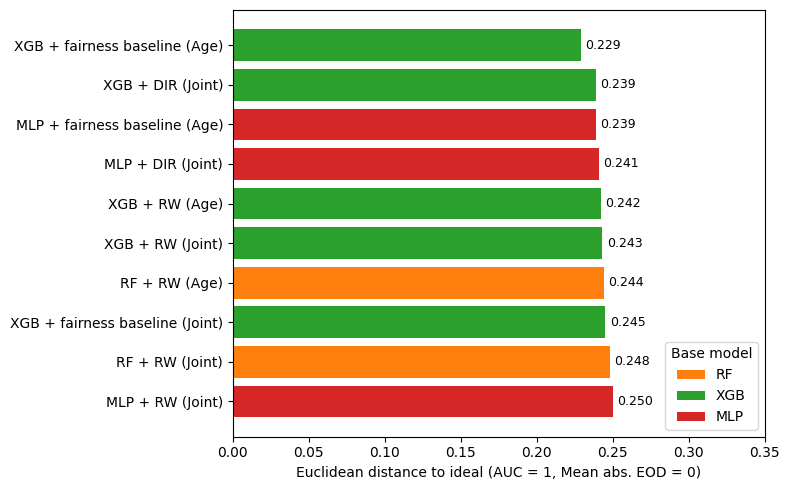

In [668]:
# --- sort by distance and take top 10 (smallest distance = best) ---
items_sorted = sorted(banking_distance_dict_fairness.items(),
                      key=lambda x: x[1])
top_items = items_sorted[:10]

labels = [k for k, v in top_items]
values = [v for k, v in top_items]

# --- color by base model (LR / RF / XGB / MLP) ---
def color_for_method(name: str) -> str:
    if name.startswith("LR"):
        return "#1f77b4"   # blue
    if name.startswith("RF"):
        return "#ff7f0e"   # orange
    if name.startswith("XGB"):
        return "#2ca02c"   # green
    if name.startswith("MLP"):
        return "#d62728"   # red
    return "grey"

colors = [color_for_method(name) for name in labels]

# --- plot ---
plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(labels)), values, color=colors)
plt.gca().invert_yaxis()  # best (smallest distance) at the top

plt.yticks(range(len(labels)), labels)
plt.xlim(0,0.35)
plt.xlabel("Euclidean distance to ideal (AUC = 1, Mean abs. EOD = 0)")

# annotate each bar with its distance value
for i, (bar, val) in enumerate(zip(bars, values)):
    plt.text(val + 0.003,              # a bit to the right of the bar
             bar.get_y() + bar.get_height()/2,
             f"{val:.3f}",
             va="center", fontsize=9)

# legend for model types
legend_elements = [
    Patch(facecolor="#ff7f0e", label="RF"),
    Patch(facecolor="#2ca02c", label="XGB"),
    Patch(facecolor="#d62728", label="MLP")
]
plt.legend(handles=legend_elements, title="Base model", loc="lower right")

plt.tight_layout()
plt.savefig("Top 10 mitigation banking")
plt.show()

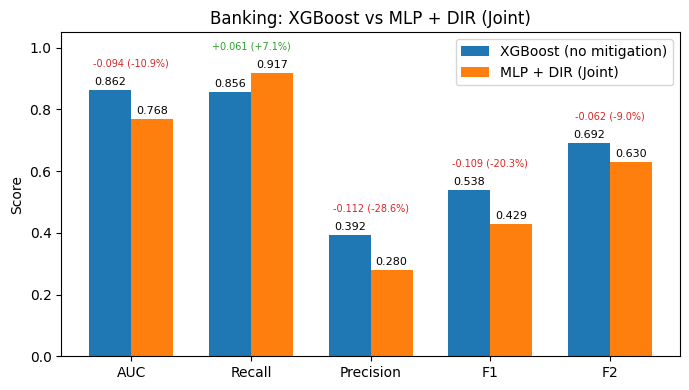

In [629]:
# ----------------- data extraction -----------------
metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

xgb_vals = np.array([
    extract_mean(v)
    for v in df_banking_performance_std.loc[metrics, "XGBoost test"]
])

mlp_dir_vals = np.array([
    extract_mean(v)
    for v in df_banking_performance_fairness_mlp_std.loc[metrics, "MLP + DIR (Joint)"]
])

deltas = mlp_dir_vals - xgb_vals

# ----------------- plotting -----------------
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))

bars_xgb = ax.bar(x - width/2, xgb_vals, width, label="XGBoost (no mitigation)")
bars_mlp = ax.bar(x + width/2, mlp_dir_vals, width, label="MLP + DIR (Joint)")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Banking: XGBoost vs MLP + DIR (Joint)")

ax.legend()

# annotate actual metric values on each bar
annotate_values(ax, bars_xgb)
annotate_values(ax, bars_mlp)

# annotate deltas (+abs and %)
annotate_deltas(ax, bars_xgb, bars_mlp, deltas, xgb_vals)

plt.tight_layout()
plt.savefig("Banking final performance evaluation")
plt.show()

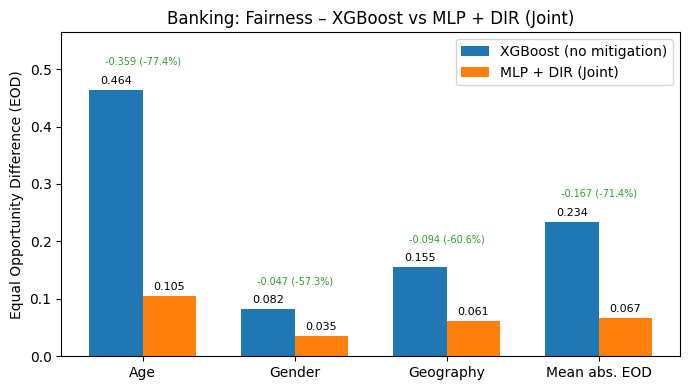

In [429]:
# ----------------- data extraction -----------------
fair_labels = ["Age", "Gender", "Geography", "Mean abs. EOD"]

# XGBoost fairness (no mitigation)
xgb_fair_vals = np.array([
    extract_mean(df_banking_fairness.loc["Age EOD",          "XGBoost"]),
    extract_mean(df_banking_fairness.loc["Gender EOD",       "XGBoost"]),
    extract_mean(df_banking_fairness.loc["Geography EOD",    "XGBoost"]),
    extract_mean(df_banking_fairness.loc["Mean Absolute EOD","XGBoost"]),
])

# MLP + DIR (Joint)
mlp_dir_fair_vals = np.array([
    extract_mean(df_banking_fairness_mlp.loc["Age",                "MLP + DIR (Joint)"]),
    extract_mean(df_banking_fairness_mlp.loc["Gender",             "MLP + DIR (Joint)"]),
    extract_mean(df_banking_fairness_mlp.loc["Location",           "MLP + DIR (Joint)"]),
    extract_mean(df_banking_fairness_mlp.loc["Mean Absolute EOD",  "MLP + DIR (Joint)"]),
])

# deltas (MLP DIR – XGB); note: negative is *better* here
deltas_fair = mlp_dir_fair_vals - xgb_fair_vals

# ----------------- plotting -----------------
x = np.arange(len(fair_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))

bars_xgb = ax.bar(x - width/2, xgb_fair_vals, width, label="XGBoost (no mitigation)")
bars_mlp = ax.bar(x + width/2, mlp_dir_fair_vals, width, label="MLP + DIR (Joint)")

ax.set_xticks(x)
ax.set_xticklabels(fair_labels)
ax.set_ylabel("Equal Opportunity Difference (EOD)")
ax.set_ylim(0, max(xgb_fair_vals.max(), mlp_dir_fair_vals.max()) + 0.1)
ax.set_title("Banking: Fairness – XGBoost vs MLP + DIR (Joint)")

ax.legend()

# annotate actual EOD values
annotate_values(ax, bars_xgb, dy=0.007)
annotate_values(ax, bars_mlp, dy=0.007)

# annotate deltas (absolute and %)
annotate_deltas(ax, bars_xgb, bars_mlp, deltas_fair, xgb_fair_vals, lower_is_better=True, dy=0.04)

plt.tight_layout()
plt.savefig("Banking final fairness evaluation")
plt.show()

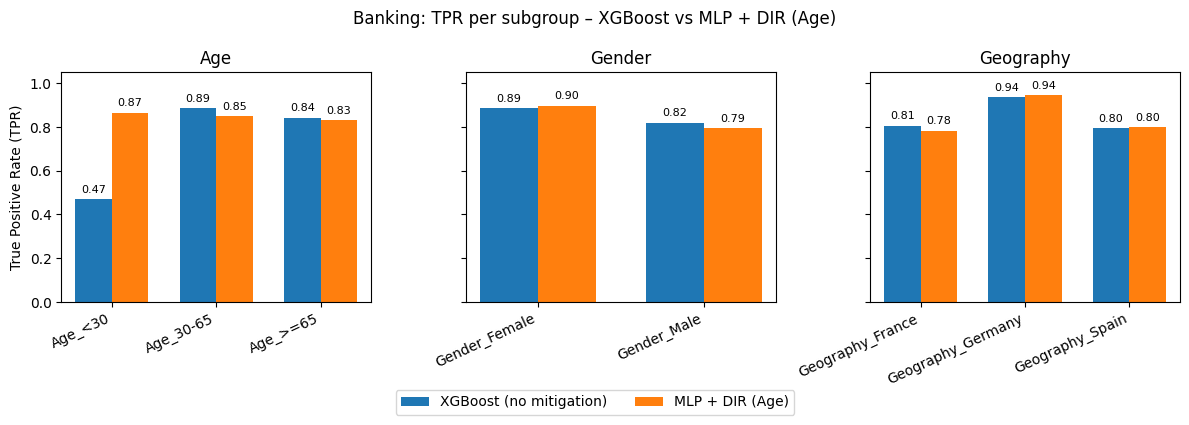

In [444]:
import numpy as np
import matplotlib.pyplot as plt

# --- helper to plot one group (age / gender / geography) ---
def plot_group(ax, title, baseline_means, fair_means, ylabel=False):
    groups = list(baseline_means.keys())
    x = np.arange(len(groups))
    width = 0.35

    baseline_vals = [baseline_means[g] for g in groups]
    fair_vals     = [fair_means[g]     for g in groups]

    b1 = ax.bar(x - width/2, baseline_vals, width, label="XGBoost (no mitigation)")
    b2 = ax.bar(x + width/2, fair_vals,     width, label="MLP + DIR (Age)")

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=25, ha="right")
    ax.set_ylim(0, 1.05)
    if ylabel:
        ax.set_ylabel("True Positive Rate (TPR)")

    # annotate values
    for bars in (b1, b2):
        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.02,
                f"{h:.2f}",
                ha="center", va="bottom", fontsize=8
            )

# --- extract means ---
age_xgb    = banking_xgb_tpr["age_means"]
gender_xgb = banking_xgb_tpr["gender_means"]
geo_xgb    = banking_xgb_tpr["geography_means"]

age_mlp    = banking_mlp_dir_age_tpr["age_means"]
gender_mlp = banking_mlp_dir_age_tpr["gender_means"]
geo_mlp    = banking_mlp_dir_age_tpr["geography_means"]

# --- create figure with 3 subplots ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

plot_group(axes[0], "Age",       age_xgb,    age_mlp,   ylabel=True)
plot_group(axes[1], "Gender",    gender_xgb, gender_mlp)
plot_group(axes[2], "Geography", geo_xgb,    geo_mlp)

fig.suptitle("Banking: TPR per subgroup – XGBoost vs MLP + DIR (Age)", fontsize=12)

# ---- FIX: put legend below the entire figure ----
fig.legend(
    ["XGBoost (no mitigation)", "MLP + DIR (Age)"],
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.05)
)

plt.subplots_adjust(bottom=0.20)  # add space so legend doesn’t overlap labels
plt.tight_layout()
plt.savefig("Banking_final_TPR_evaluation.png", bbox_inches="tight")
plt.show()

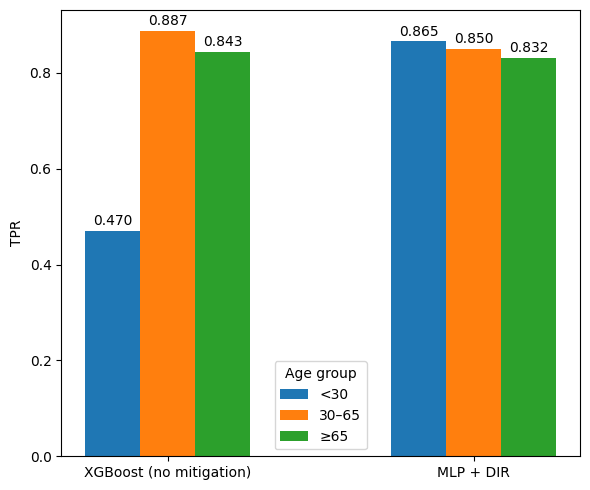

In [588]:
import numpy as np
import matplotlib.pyplot as plt

# Example dictionaries (you already have these)
# age_xgb = {'Age_<30': 0.4704, 'Age_30-65': 0.8867, 'Age_>=65': 0.8429}
# age_mlp = {'Age_<30': ..., 'Age_30-65': ..., 'Age_>=65': ...}

age_labels = list(age_xgb.keys())          # ['Age_<30', 'Age_30-65', 'Age_>=65']
models = ["XGBoost (no mitigation)", "MLP + DIR"]

# Pretty labels for legend
pretty_labels = {
    "Age_<30": "<30",
    "Age_30-65": "30–65",
    "Age_>=65": "≥65"
}

n_models = len(models)
n_age = len(age_labels)
bar_width = 0.18

x = np.arange(n_models)  # [0, 1]

plt.figure(figsize=(6, 5))

for i, age in enumerate(age_labels):
    offset = (i - (n_age - 1) / 2) * bar_width
    heights = [age_xgb[age], age_mlp[age]]
    
    bars = plt.bar(
        x + offset,
        heights,
        width=bar_width,
        label=pretty_labels.get(age, age)  # use pretty label in legend
    )
    plt.bar_label(bars, fmt="%.3f", padding=2)

plt.xticks(x, models)
plt.ylabel("TPR")
plt.legend(title="Age group")
plt.tight_layout()
plt.savefig("Banking_final_TPR_evaluation.png", bbox_inches="tight")
plt.show()

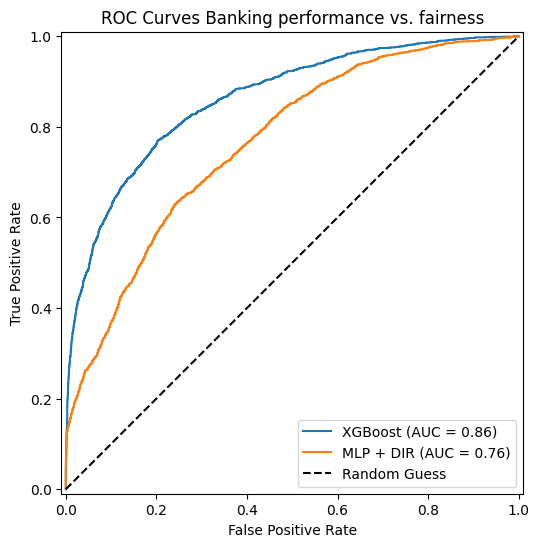

In [460]:
fig, ax = plt.subplots(figsize=(8, 6))

RocCurveDisplay.from_predictions(banking_y, banking_xgb_proba, name="XGBoost", ax=ax)
RocCurveDisplay.from_predictions(banking_y, banking_mlp_dir_proba, name="MLP + DIR", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves Banking performance vs. fairness")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("ROC curves banking fairness")
plt.show()

In [667]:
gender_tpr

[2, 1, 2, 1, 1, 2, 2, 1]

In [663]:
import numpy as np
from scipy.stats import spearmanr

# ---- Your existing ranking lists ----
banking_ranked_on_cr = [
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3
]

banking_ranked_on_tpr = [
    2, 1, 3, 2, 1, 1, 3, 2,
    2, 1, 3, 1, 2, 1, 2, 3,
    1, 2, 3, 1, 2, 1, 3, 2,
    2, 1, 3, 2, 1, 1, 3, 2
]

# Sanity checks
assert len(banking_ranked_on_cr) == len(banking_ranked_on_tpr)
assert len(banking_ranked_on_cr) % 8 == 0  # 8 groups per model

n_models = len(banking_ranked_on_cr) // 8  # here: 4 models

# Index mapping within each model block of 8:
# 0: Male, 1: Female, 2: Age<30, 3: Age 30–65,
# 4: Age>=65, 5: Germany, 6: Spain, 7: France
IDX_MALE      = 0
IDX_FEMALE    = 1
IDX_AGE_LT30  = 2
IDX_AGE_30_65 = 3
IDX_AGE_GE65  = 4
IDX_GERMANY   = 5
IDX_SPAIN     = 6
IDX_FRANCE    = 7

# Containers per attribute
gender_cr = []
gender_tpr = []

age_cr = []
age_tpr = []

geo_cr = []
geo_tpr = []

for m in range(n_models):
    base = m * 8  # start index for this model
    
    # ----- Gender -----
    gender_cr.extend([
        banking_ranked_on_cr[base + IDX_MALE],
        banking_ranked_on_cr[base + IDX_FEMALE]
    ])
    gender_tpr.extend([
        banking_ranked_on_tpr[base + IDX_MALE],
        banking_ranked_on_tpr[base + IDX_FEMALE]
    ])
    
    # ----- Age -----
    age_cr.extend([
        banking_ranked_on_cr[base + IDX_AGE_LT30],
        banking_ranked_on_cr[base + IDX_AGE_30_65],
        banking_ranked_on_cr[base + IDX_AGE_GE65]
    ])
    age_tpr.extend([
        banking_ranked_on_tpr[base + IDX_AGE_LT30],
        banking_ranked_on_tpr[base + IDX_AGE_30_65],
        banking_ranked_on_tpr[base + IDX_AGE_GE65]
    ])
    
    # ----- Geography -----
    geo_cr.extend([
        banking_ranked_on_cr[base + IDX_GERMANY],
        banking_ranked_on_cr[base + IDX_SPAIN],
        banking_ranked_on_cr[base + IDX_FRANCE]
    ])
    geo_tpr.extend([
        banking_ranked_on_tpr[base + IDX_GERMANY],
        banking_ranked_on_tpr[base + IDX_SPAIN],
        banking_ranked_on_tpr[base + IDX_FRANCE]
    ])

# ---- Compute Spearman per attribute ----
rho_gender, p_gender = spearmanr(gender_cr, gender_tpr)
rho_age,    p_age    = spearmanr(age_cr, age_tpr)
rho_geo,    p_geo    = spearmanr(geo_cr, geo_tpr)

print(f"Gender: Spearman ρ = {rho_gender:.3f}, p = {p_gender:.3f}")
print(f"Age:    Spearman ρ = {rho_age:.3f}, p = {p_age:.3f}")
print(f"Geo:    Spearman ρ = {rho_geo:.3f}, p = {p_geo:.3f}")

Gender: Spearman ρ = 0.500, p = 0.207
Age:    Spearman ρ = 0.750, p = 0.005
Geo:    Spearman ρ = 0.625, p = 0.030


In [538]:
banking_ranked_on_cr = [
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3,
    2, 1, 3, 1, 2, 1, 2, 3
]

banking_ranked_on_tpr = [
    2, 1, 3, 2, 1, 1, 3, 2,
    2, 1, 3, 1, 2, 1, 2, 3,
    1, 2, 3, 1, 2, 1, 3, 2,
    2, 1, 3, 2, 1, 1, 3, 2
]

print(np.corrcoef(banking_ranked_on_cr, banking_ranked_on_tpr)[0,1])

0.6923076923076924


### Telecommunication

In [318]:
telecom_distance_dict_fairness = {}

for x in range(6):
    auc = df_telecom_performance_fairness_lr.iloc[0, x]
    f2 = df_telecom_performance_fairness_lr.iloc[4, x]
    eod = df_telecom_fairness_lr.iloc[2, x]
    model = df_telecom_performance_fairness_lr.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    telecom_distance_dict_fairness[model] = distance

telecom_distance_dict_fairness

{'LR no mitigation': 0.173,
 'LR + fairness baseline': 0.17,
 'LR + RW': 0.162,
 'LR + DIR': 0.163,
 'LR + LFR': 0.337,
 'LR + EOPP': 0.168}

In [319]:
for x in range(6):
    auc = df_telecom_performance_fairness_rf.iloc[0, x]
    f2 = df_telecom_performance_fairness_rf.iloc[4, x]
    eod = df_telecom_fairness_rf.iloc[2, x]
    model = df_telecom_performance_fairness_rf.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    telecom_distance_dict_fairness[model] = distance

telecom_distance_dict_fairness

{'LR no mitigation': 0.173,
 'LR + fairness baseline': 0.17,
 'LR + RW': 0.162,
 'LR + DIR': 0.163,
 'LR + LFR': 0.337,
 'LR + EOPP': 0.168,
 'RF no mitigation': 0.174,
 'RF + fairness baseline': 0.169,
 'RF + RW': 0.165,
 'RF + DIR': 0.166,
 'RF + LFR': 0.291,
 'RF + EOPP': 0.173}

In [320]:
for x in range(6):
    auc = df_telecom_performance_fairness_xgb.iloc[0, x]
    f2 = df_telecom_performance_fairness_xgb.iloc[4, x]
    eod = df_telecom_fairness_xgb.iloc[2, x]
    model = df_telecom_performance_fairness_xgb.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    telecom_distance_dict_fairness[model] = distance

telecom_distance_dict_fairness

{'LR no mitigation': 0.173,
 'LR + fairness baseline': 0.17,
 'LR + RW': 0.162,
 'LR + DIR': 0.163,
 'LR + LFR': 0.337,
 'LR + EOPP': 0.168,
 'RF no mitigation': 0.174,
 'RF + fairness baseline': 0.169,
 'RF + RW': 0.165,
 'RF + DIR': 0.166,
 'RF + LFR': 0.291,
 'RF + EOPP': 0.173,
 'XGB no mitigation': 0.172,
 'XGB + fairness baseline': 0.168,
 'XGB + RW': 0.166,
 'XGB + DIR': 0.166,
 'XGB + LFR': 0.295,
 'XGB + EOPP': 0.166}

In [321]:
for x in range(6):
    auc = df_telecom_performance_fairness_mlp.iloc[0, x]
    f2 = df_telecom_performance_fairness_mlp.iloc[4, x]
    eod = df_telecom_fairness_mlp.iloc[2, x]
    model = df_telecom_performance_fairness_mlp.columns[x]
    distance = round(
        sqrt(
            (optimal_auc - auc) ** 2 +
            (optimal_eod - eod) ** 2
        ),
        3
    )
    telecom_distance_dict_fairness[model] = distance

telecom_distance_dict_fairness = dict(sorted(telecom_distance_dict_fairness.items(), key=lambda item: item[1]))

telecom_distance_dict_fairness

{'LR + RW': 0.162,
 'LR + DIR': 0.163,
 'MLP + DIR': 0.164,
 'RF + RW': 0.165,
 'RF + DIR': 0.166,
 'XGB + RW': 0.166,
 'XGB + DIR': 0.166,
 'XGB + EOPP': 0.166,
 'LR + EOPP': 0.168,
 'XGB + fairness baseline': 0.168,
 'RF + fairness baseline': 0.169,
 'LR + fairness baseline': 0.17,
 'XGB no mitigation': 0.172,
 'LR no mitigation': 0.173,
 'RF + EOPP': 0.173,
 'MLP + RW': 0.173,
 'MLP + EOPP': 0.173,
 'RF no mitigation': 0.174,
 'MLP + fairness baseline': 0.175,
 'MLP no mitigation': 0.178,
 'RF + LFR': 0.291,
 'XGB + LFR': 0.295,
 'LR + LFR': 0.337,
 'MLP + LFR': 0.361}

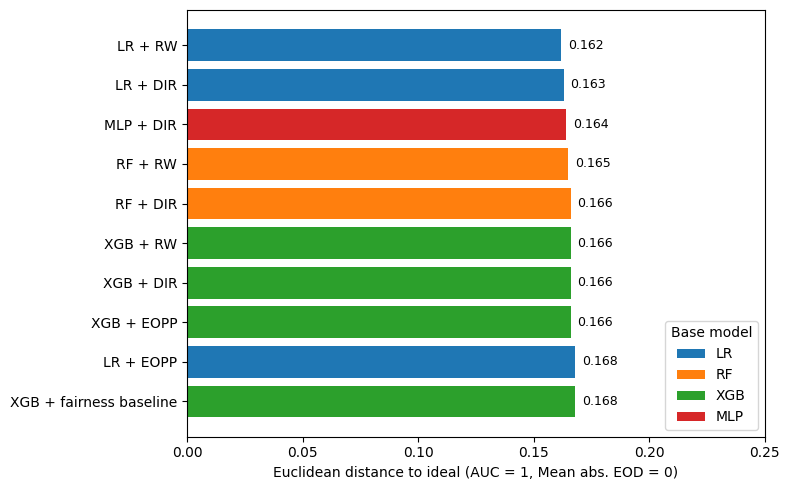

In [669]:
# --- sort by distance and take top 10 (smallest distance = best) ---
items_sorted = sorted(telecom_distance_dict_fairness.items(),
                      key=lambda x: x[1])
top_items = items_sorted[:10]

labels = [k for k, v in top_items]
values = [v for k, v in top_items]

# --- color by base model (LR / RF / XGB / MLP) ---
def color_for_method(name: str) -> str:
    if name.startswith("LR"):
        return "#1f77b4"   # blue
    if name.startswith("RF"):
        return "#ff7f0e"   # orange
    if name.startswith("XGB"):
        return "#2ca02c"   # green
    if name.startswith("MLP"):
        return "#d62728"   # red
    return "grey"

colors = [color_for_method(name) for name in labels]

# --- plot ---
plt.figure(figsize=(8, 5))
bars = plt.barh(range(len(labels)), values, color=colors)
plt.gca().invert_yaxis()  # best (smallest distance) at the top

plt.yticks(range(len(labels)), labels)
plt.xlim(0,0.25)
plt.xlabel("Euclidean distance to ideal (AUC = 1, Mean abs. EOD = 0)")

# annotate each bar with its distance value
for i, (bar, val) in enumerate(zip(bars, values)):
    plt.text(val + 0.003,              # a bit to the right of the bar
             bar.get_y() + bar.get_height()/2,
             f"{val:.3f}",
             va="center", fontsize=9)

# legend for model types
legend_elements = [
    Patch(facecolor="#1f77b4", label="LR"),
    Patch(facecolor="#ff7f0e", label="RF"),
    Patch(facecolor="#2ca02c", label="XGB"),
    Patch(facecolor="#d62728", label="MLP")
]
plt.legend(handles=legend_elements, title="Base model", loc="lower right")

plt.tight_layout()
plt.savefig("Top 10 mitigation telecommunication")
plt.show()

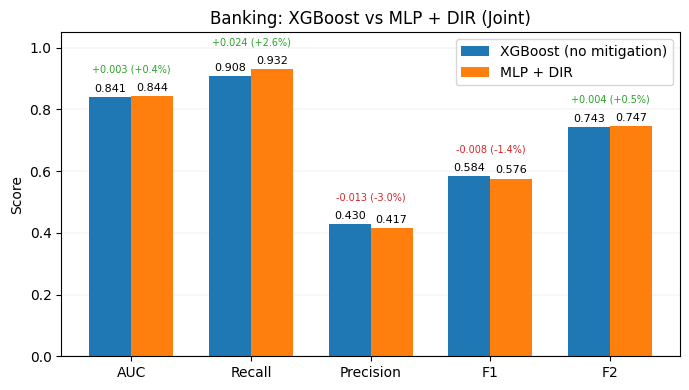

In [596]:
# ----------------- data extraction -----------------
metrics = ["AUC", "Recall", "Precision", "F1", "F2"]

xgb_vals = np.array([
    extract_mean(v)
    for v in df_telecom_performance_std.loc[metrics, "XGBoost test"]
])

mlp_dir_vals = np.array([
    extract_mean(v)
    for v in df_telecom_performance_fairness_mlp_std.loc[metrics, "MLP + DIR"]
])

deltas = mlp_dir_vals - xgb_vals

# ----------------- plotting -----------------
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))

bars_xgb = ax.bar(x - width/2, xgb_vals, width, label="XGBoost (no mitigation)")
bars_mlp = ax.bar(x + width/2, mlp_dir_vals, width, label="MLP + DIR")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Banking: XGBoost vs MLP + DIR (Joint)")

ax.legend()

# annotate actual metric values on each bar
annotate_values(ax, bars_xgb)
annotate_values(ax, bars_mlp)

# annotate deltas (+abs and %)
annotate_deltas(ax, bars_xgb, bars_mlp, deltas, xgb_vals, dy=0.07)

plt.tight_layout()
plt.grid(axis='y', linestyle='-', linewidth=0.2, alpha=0.7)
plt.gca().set_axisbelow(True)
plt.savefig("Telecom final performance evaluation")
plt.show()

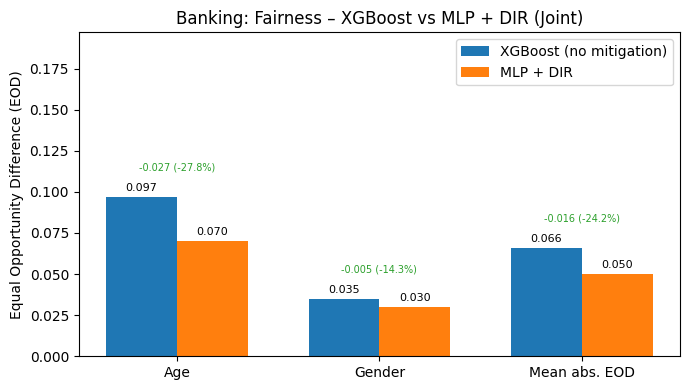

In [426]:
# ----------------- data extraction -----------------
fair_labels = ["Age", "Gender", "Mean abs. EOD"]

# XGBoost fairness (no mitigation)
xgb_fair_vals = np.array([
    extract_mean(df_telecom_fairness.loc["Age EOD",          "XGBoost"]),
    extract_mean(df_telecom_fairness.loc["Gender EOD",       "XGBoost"]),
    extract_mean(df_telecom_fairness.loc["Mean Absolute EOD","XGBoost"]),
])

# MLP + DIR (Joint)
mlp_dir_fair_vals = np.array([
    extract_mean(df_telecom_fairness_mlp.loc["Age",               "MLP + DIR"]),
    extract_mean(df_telecom_fairness_mlp.loc["Gender",            "MLP + DIR"]),
    extract_mean(df_telecom_fairness_mlp.loc["Mean Absolute EOD", "MLP + DIR"]),
])

# deltas (MLP DIR – XGB); note: negative is *better* here
deltas_fair = mlp_dir_fair_vals - xgb_fair_vals

# ----------------- plotting -----------------
x = np.arange(len(fair_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 4))

bars_xgb = ax.bar(x - width/2, xgb_fair_vals, width, label="XGBoost (no mitigation)")
bars_mlp = ax.bar(x + width/2, mlp_dir_fair_vals, width, label="MLP + DIR")

ax.set_xticks(x)
ax.set_xticklabels(fair_labels)
ax.set_ylabel("Equal Opportunity Difference (EOD)")
ax.set_ylim(0, max(xgb_fair_vals.max(), mlp_dir_fair_vals.max()) + 0.1)
ax.set_title("Banking: Fairness – XGBoost vs MLP + DIR (Joint)")

ax.legend()

# annotate actual EOD values
annotate_values(ax, bars_xgb,dy=0.0025)
annotate_values(ax, bars_mlp,dy=0.0025)

# annotate deltas (absolute and %)
annotate_deltas(ax, bars_xgb, bars_mlp, deltas_fair, xgb_fair_vals, lower_is_better=True, dy=0.015)

plt.tight_layout()
plt.savefig("Telecom final fairness evaluation")
plt.show()

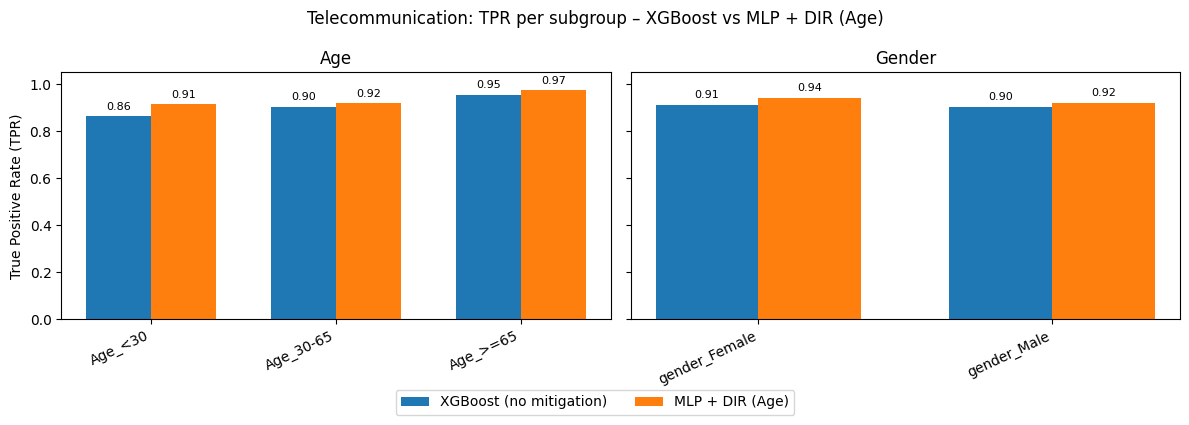

In [445]:
import numpy as np
import matplotlib.pyplot as plt

# --- helper to plot one group (age / gender / geography) ---
def plot_group(ax, title, baseline_means, fair_means, ylabel=False):
    groups = list(baseline_means.keys())
    x = np.arange(len(groups))
    width = 0.35

    baseline_vals = [baseline_means[g] for g in groups]
    fair_vals     = [fair_means[g]     for g in groups]

    b1 = ax.bar(x - width/2, baseline_vals, width, label="XGBoost (no mitigation)")
    b2 = ax.bar(x + width/2, fair_vals,     width, label="MLP + DIR (Age)")

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=25, ha="right")
    ax.set_ylim(0, 1.05)
    if ylabel:
        ax.set_ylabel("True Positive Rate (TPR)")

    # annotate values
    for bars in (b1, b2):
        for bar in bars:
            h = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2,
                h + 0.02,
                f"{h:.2f}",
                ha="center", va="bottom", fontsize=8
            )

# --- extract means ---
age_xgb    = telecom_xgb_tpr["age_means"]
gender_xgb = telecom_xgb_tpr["gender_means"]

age_mlp    = telecom_mlp_dir_age_tpr["age_means"]
gender_mlp = telecom_mlp_dir_age_tpr["gender_means"]

# --- create figure with 3 subplots ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

plot_group(axes[0], "Age",       age_xgb,    age_mlp,   ylabel=True)
plot_group(axes[1], "Gender",    gender_xgb, gender_mlp)

fig.suptitle("Telecommunication: TPR per subgroup – XGBoost vs MLP + DIR (Age)", fontsize=12)

# ---- FIX: put legend below the entire figure ----
fig.legend(
    ["XGBoost (no mitigation)", "MLP + DIR (Age)"],
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.05)
)

plt.subplots_adjust(bottom=0.20)  # add space so legend doesn’t overlap labels
plt.tight_layout()
plt.savefig("Telecom_final_TPR_evaluation.png", bbox_inches="tight")
plt.show()

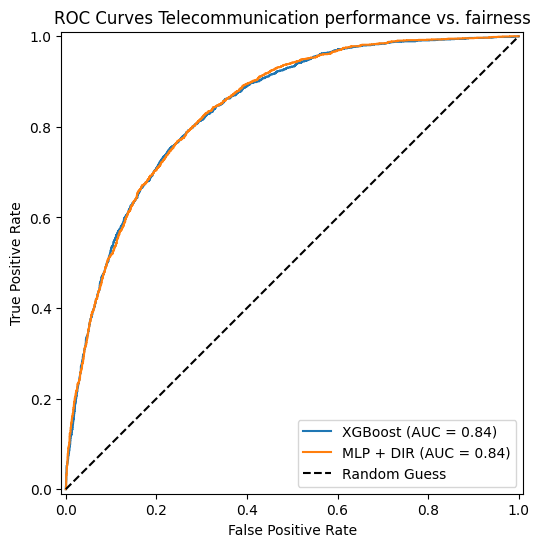

In [459]:
fig, ax = plt.subplots(figsize=(8, 6))

RocCurveDisplay.from_predictions(telecom_y, telecom_xgb_proba, name="XGBoost", ax=ax)
RocCurveDisplay.from_predictions(telecom_y, telecom_mlp_dir_age_proba, name="MLP + DIR", ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves Telecommunication performance vs. fairness")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("ROC curves telecom fairness")
plt.show()

In [539]:
telecom_ranked_on_cr = [
    3, 2, 1, 3, 2, 1,
    3, 2, 1, 3, 2, 1
]

telecom_ranked_on_tpr = [
    3, 2, 1, 3, 2, 1,
    3, 2, 1, 3, 2, 1
]

print(np.corrcoef(telecom_ranked_on_cr, telecom_ranked_on_tpr)[0,1])

1.0
